# Individual Differences Figure
Kai Sandbrink

2024-03-13

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from utils import format_axis

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from utils import flatten

analysis_folder = os.path.join('panels', 'fig_inddiffs')
os.makedirs(analysis_folder, exist_ok=True)

square=True
axes_off=True

from settings_ana import TEXTWIDTH

In [2]:
day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '..'

## Panel -A: Perturbation Plots
### PEPE

In [3]:
from settings_ana import pepe_human_ape_models as pepe_models

timestamp_traj = '20240503230802'
timestamp_original_traj = '20231006143445'
perturbation_taus = np.arange(-1.5, 1.6, 0.25).astype(float)
test_taus = np.arange(0, 1.01, 0.125)

### READING IN PERTURBED TRAJECTORIES
mistrained_traj_base_folder = os.path.join('data','perturbed','pepe')

models_mis_taus_control_errs = []
models_mis_taus_counters_peeks = []
models_mis_taus_rewss = []

for model in pepe_models:

    mis_taus_control_errs = []
    mis_taus_counters_peeks = []
    mis_taus_rewss = []

    for mistrained_tau in perturbation_taus:

        mistrained_traj_folder = os.path.join(mistrained_traj_base_folder, str(model), 'perturbed_tau_perturbation%d' %(mistrained_tau*100))
        control_errs_taus_ape = pickle.load(open(os.path.join(mistrained_traj_folder, timestamp_traj + '_perturbed_control_errs_taus_ape.pkl'), 'rb'))
        counters_peeks_taus = pickle.load(open(os.path.join(mistrained_traj_folder, timestamp_traj + '_perturbed_counters_peeks_taus.pkl'), 'rb'))
        rewss_taus = pickle.load(open(os.path.join(mistrained_traj_folder, timestamp_traj + '_rewss_taus.pkl'), 'rb'))

        mis_taus_control_errs.append(control_errs_taus_ape)
        mis_taus_counters_peeks.append(counters_peeks_taus)
        mis_taus_rewss.append(rewss_taus)

    models_mis_taus_control_errs.append(mis_taus_control_errs)
    models_mis_taus_counters_peeks.append(mis_taus_counters_peeks)
    models_mis_taus_rewss.append(mis_taus_rewss)

models_mis_taus_control_errs = np.array(models_mis_taus_control_errs)
models_mis_taus_counters_peeks = np.array(models_mis_taus_counters_peeks)
models_mis_taus_rewss = np.array(models_mis_taus_rewss)

### SELECT RELEVANT SUBMATRIX
perturbation_values_to_keep = [-1.5, -1, -0.5, 0, 0.5, 1, 1.5]
indices_to_keep = indices = np.where(np.isin(perturbation_taus, perturbation_values_to_keep))[0]
perturbation_taus = perturbation_taus[indices_to_keep]
models_mis_taus_control_errs = models_mis_taus_control_errs[:,indices_to_keep]
models_mis_taus_counters_peeks = models_mis_taus_counters_peeks[:,indices_to_keep]
models_mis_taus_rewss = models_mis_taus_rewss[:,indices_to_keep]

### READING IN ORIGINAL TRAJECTORY

eval_base_folder = os.path.join('data','eval','pepe')
models_orig_taus_control_errs = []
models_orig_taus_counters_peeks = []
models_orig_taus_rewss = []

for model in pepe_models:

    orig_traj_folder = os.path.join(eval_base_folder, str(model))

    control_errs_taus_ape = pickle.load(open(os.path.join(orig_traj_folder, timestamp_original_traj + '_control_errs_taus_ape.pkl'), 'rb'))
    counters_peeks_taus = pickle.load(open(os.path.join(orig_traj_folder, timestamp_original_traj + '_counters_peeks_taus.pkl'), 'rb'))
    rewss_taus = pickle.load(open(os.path.join(orig_traj_folder, timestamp_original_traj + '_rewss_taus.pkl'), 'rb'))

    models_orig_taus_control_errs.append(control_errs_taus_ape)
    models_orig_taus_counters_peeks.append(counters_peeks_taus)
    models_orig_taus_rewss.append(rewss_taus)

models_orig_taus_control_errs = np.array(models_orig_taus_control_errs)
models_orig_taus_counters_peeks = np.array(models_orig_taus_counters_peeks)
models_orig_taus_rewss = np.array(models_orig_taus_rewss)

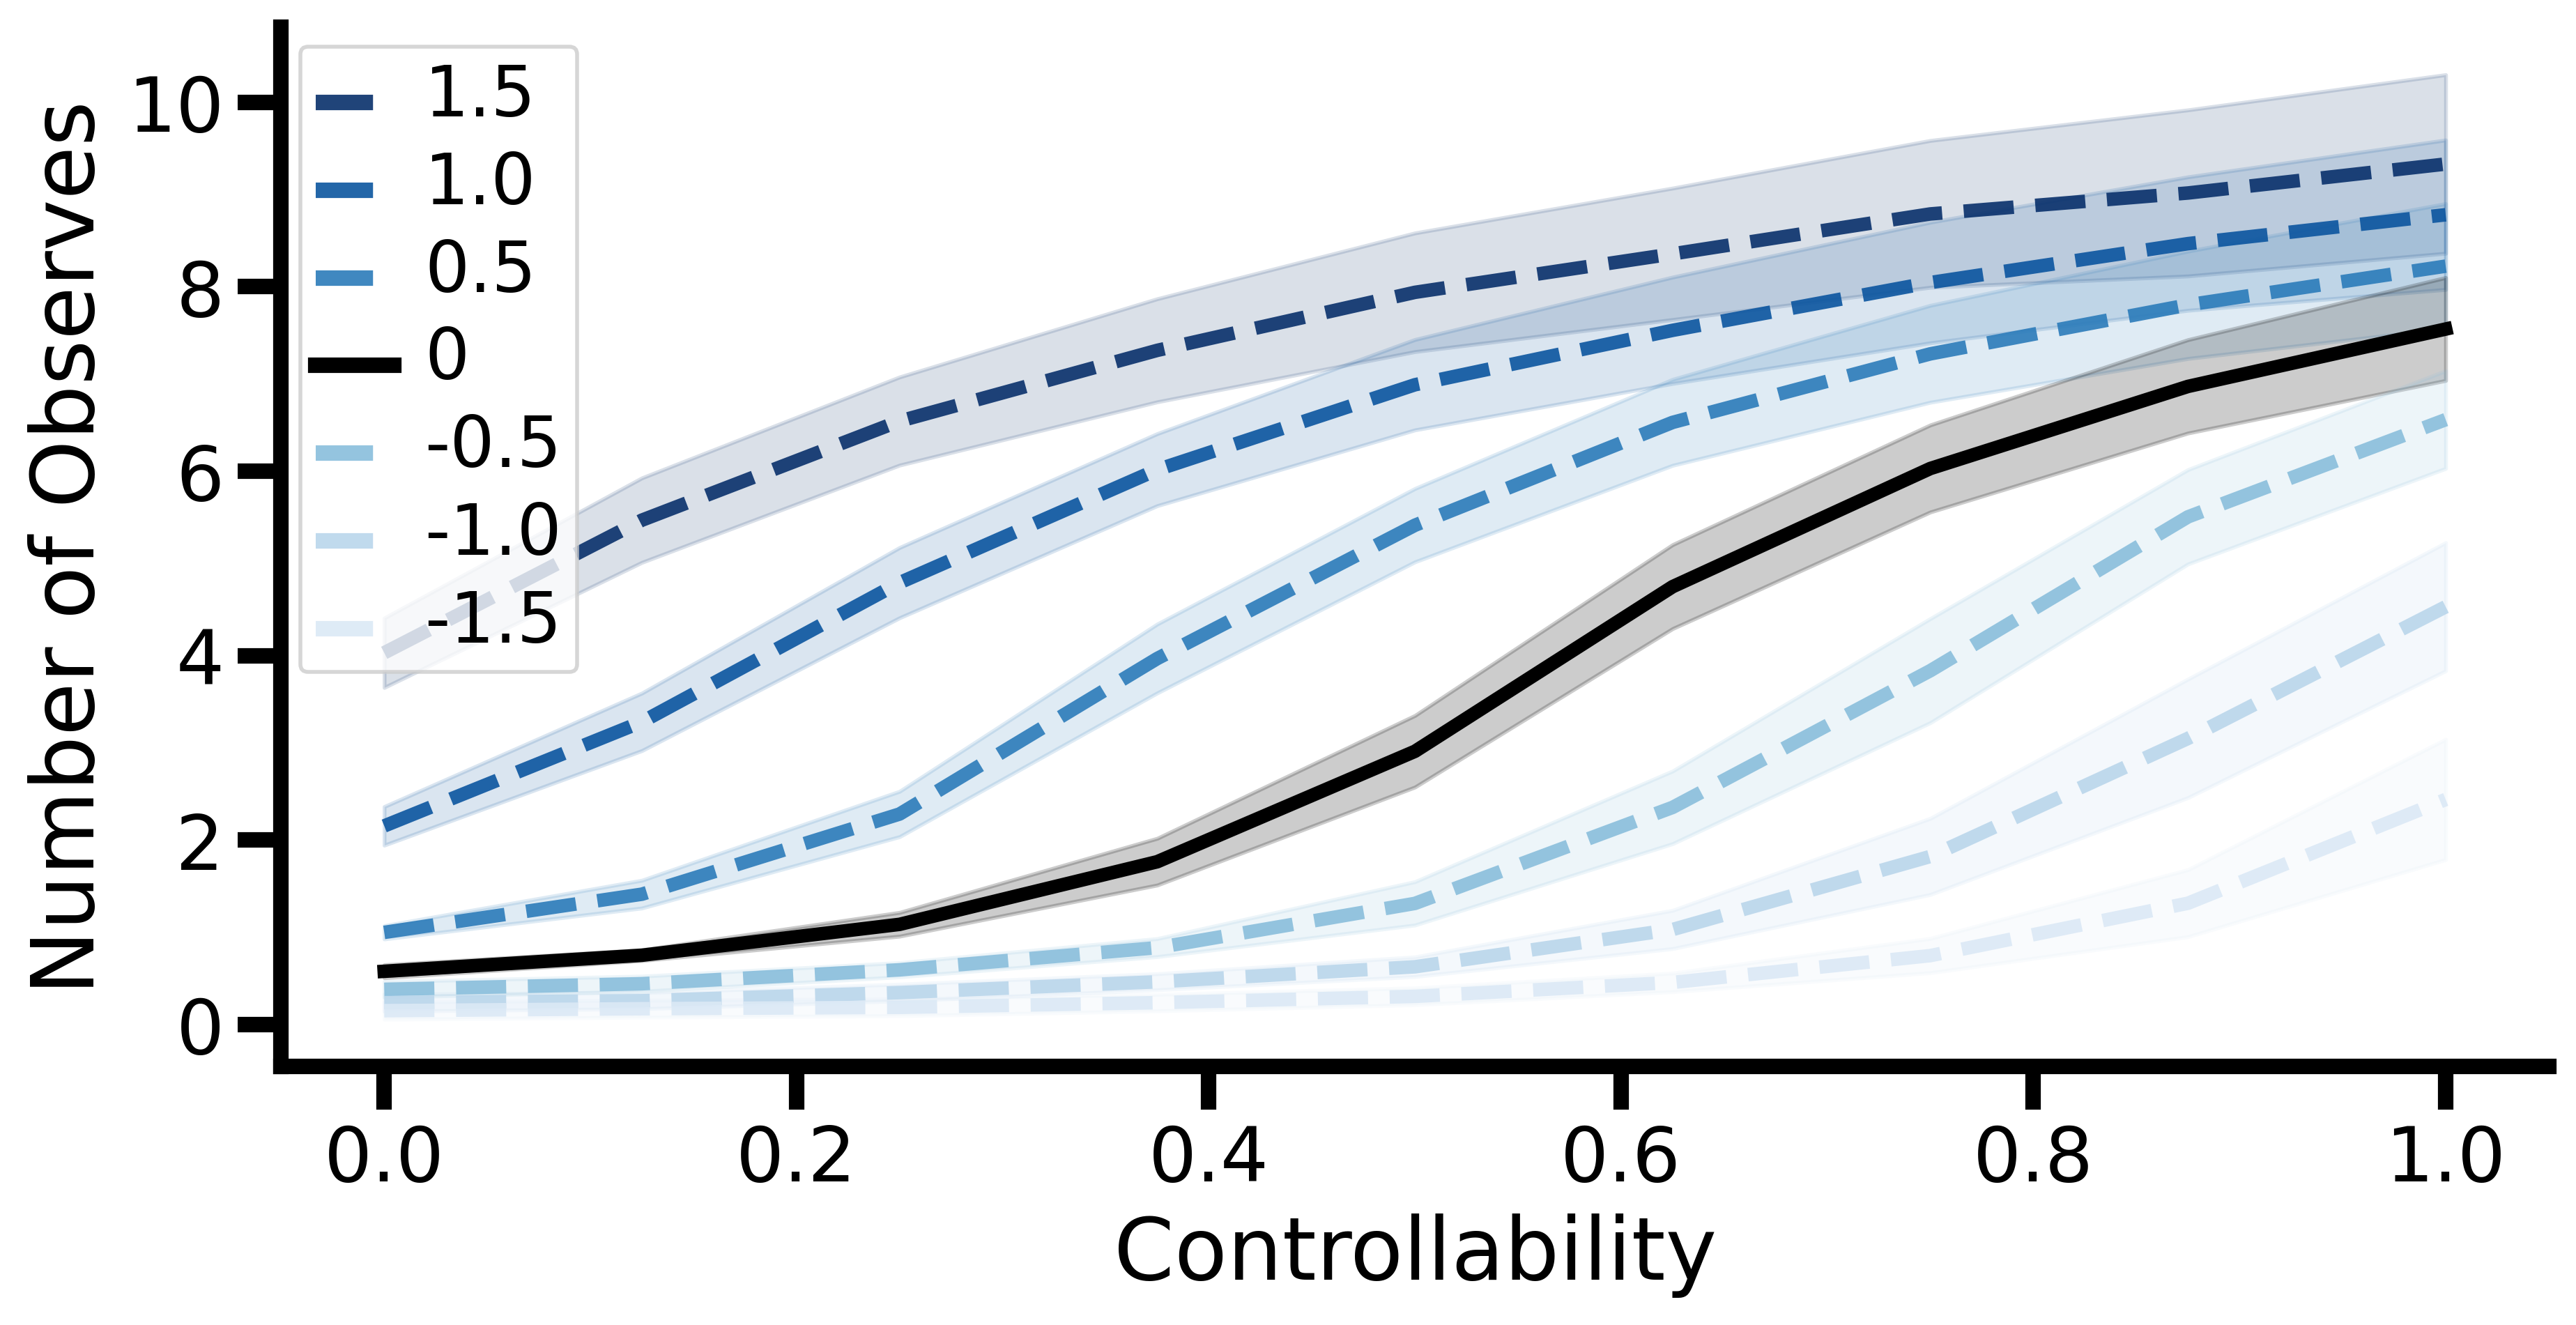

In [4]:
from test_analyses import plot_behavior_mistrained

fig = plot_behavior_mistrained(test_taus, np.flip(models_mis_taus_counters_peeks, axis=(0,2)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', cmap=mpl.cm.Blues, figsize=(10.4952, 4.9359), font_size_multiplier=1.4, perturbation_taus=perturbation_taus)

In [5]:
fig.savefig(os.path.join(analysis_folder, 'perturbed_pepe.png'))
fig.savefig(os.path.join(analysis_folder, 'perturbed_pepe.svg'))

#### Stats

In [6]:
selected_n_observes = np.flip(models_mis_taus_counters_peeks, axis=(0,2))
selected_n_observes = selected_n_observes[:, [1,3,5]].sum(axis=-1).T
tested_levels = [1, 0, -1]

In [7]:
## MEANS AND SEMS
for level, obs in zip(tested_levels, selected_n_observes):
    print("Test Controllability ", level)
    print("Mean ", obs.mean())
    print("StdErr ", obs.std()/np.sqrt(obs.shape[0]))
    print("N", obs.shape[0])

Test Controllability  1
Mean  56.007999999999996
StdErr  4.173292417264814
N 10
Test Controllability  0
Mean  32.39200000000001
StdErr  2.633572402650058
N 10
Test Controllability  -1
Mean  12.431000000000001
StdErr  2.152446259491744
N 10


In [8]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(tested_levels, selected_n_observes)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(selected_n_observes), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    -1      0   19.961 0.0006  8.4723 31.4497   True
    -1      1   43.577    0.0 32.0883 55.0657   True
     0      1   23.616 0.0001 12.1273 35.1047   True
----------------------------------------------------


In [9]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

reshaped_data = selected_n_observes.T
pvals = []
pairs = [(0, 1), (0, 2), (1, 2)]  # Indices of settings pairs
for i, (idx1, idx2) in enumerate(pairs):
    t_stat, p_val = ttest_rel(reshaped_data[:, idx1], reshaped_data[:, idx2])
    pvals.append(p_val)
    print(f"Paired t-test {i+1}: p-value = {p_val}")

# Apply Holm-Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='holm')
print("\nCorrected p-values (Holm-Bonferroni):")
for i, (reject, p_val) in enumerate(zip(reject, pvals_corrected)):
    print(f"Comparison {i+1}: reject null hypothesis = {reject}, corrected p-value = {p_val}")

Paired t-test 1: p-value = 5.880834838731732e-06
Paired t-test 2: p-value = 9.106126333118589e-07
Paired t-test 3: p-value = 1.5822394721806108e-07

Corrected p-values (Holm-Bonferroni):
Comparison 1: reject null hypothesis = True, corrected p-value = 5.880834838731732e-06
Comparison 2: reject null hypothesis = True, corrected p-value = 1.8212252666237178e-06
Comparison 3: reject null hypothesis = True, corrected p-value = 4.7467184165418325e-07


### LEVC

In [10]:
from settings_ana import levc_human_ape_models as levc_models

timestamp_traj = '20240507022148'
timestamp_original_traj = '20240311133201'
perturbation_taus = np.arange(-3, 3.01, 0.25)
test_taus = np.arange(0, 1.01, 0.125)

### READING IN PERTURBED TRAJECTORIES
mistrained_traj_base_folder = os.path.join('data','perturbed','levc')

models_mis_taus_control_errs = []
models_mis_taus_counters_peeks = []
models_mis_taus_rewss = []
models_mis_taus_sleepss = []

for model in levc_models:

    mis_taus_control_errs = []
    mis_taus_counters_peeks = []
    mis_taus_rewss = []
    mis_taus_sleepss = []

    #for mistrained_tau in target_taus:
    for mistrained_tau in perturbation_taus:

        mistrained_traj_folder = os.path.join(mistrained_traj_base_folder, str(model), 'perturbed_tau_perturbation%d' %(mistrained_tau*100))

        control_errs_taus_ape = pickle.load(open(os.path.join(mistrained_traj_folder, timestamp_traj + '_perturbed_control_errs_taus_ape.pkl'), 'rb'))
        counters_peeks_taus = pickle.load(open(os.path.join(mistrained_traj_folder, timestamp_traj + '_perturbed_counters_peeks_taus.pkl'), 'rb'))
        rewss_taus = pickle.load(open(os.path.join(mistrained_traj_folder, timestamp_traj + '_rewss_taus.pkl'), 'rb'))
        sleepss_taus = pickle.load(open(os.path.join(mistrained_traj_folder, timestamp_traj + '_perturbed_sleep_errs_taus_ape.pkl'), 'rb'))

        mis_taus_control_errs.append(control_errs_taus_ape)
        mis_taus_counters_peeks.append(counters_peeks_taus)
        mis_taus_rewss.append(rewss_taus)
        mis_taus_sleepss.append(sleepss_taus)

    models_mis_taus_control_errs.append(mis_taus_control_errs)
    models_mis_taus_counters_peeks.append(mis_taus_counters_peeks)
    models_mis_taus_rewss.append(mis_taus_rewss)
    models_mis_taus_sleepss.append(mis_taus_sleepss)

models_mis_taus_control_errs = np.array(models_mis_taus_control_errs)
models_mis_taus_counters_peeks = np.array(models_mis_taus_counters_peeks)
models_mis_taus_rewss = np.array(models_mis_taus_rewss)
models_mis_taus_sleepss = np.array(models_mis_taus_sleepss)

perturbation_values_to_keep = [-1.5, -1, -0.5, 0, 0.5, 1, 1.5]
indices_to_keep = indices = np.where(np.isin(perturbation_taus, perturbation_values_to_keep))[0]
perturbation_taus = perturbation_taus[indices_to_keep]
models_mis_taus_control_errs = models_mis_taus_control_errs[:,indices_to_keep]
models_mis_taus_counters_peeks = models_mis_taus_counters_peeks[:,indices_to_keep]
models_mis_taus_rewss = models_mis_taus_rewss[:,indices_to_keep]
models_mis_taus_sleepss = models_mis_taus_sleepss[:,indices_to_keep]

### READING IN ORIGINAL TRAJECTORY

eval_base_folder = os.path.join('data','eval','levc')
models_orig_taus_control_errs = []
models_orig_taus_counters_peeks = []
models_orig_taus_rewss = []
models_orig_taus_sleepss = []

for model in levc_models:

    orig_traj_folder = os.path.join(eval_base_folder, str(model))

    control_errs_taus_ape = pickle.load(open(os.path.join(orig_traj_folder, timestamp_original_traj + '_control_errs_taus_ape.pkl'), 'rb'))
    counters_peeks_taus = pickle.load(open(os.path.join(orig_traj_folder, timestamp_original_traj + '_counters_peeks_taus.pkl'), 'rb'))
    rewss_taus = pickle.load(open(os.path.join(orig_traj_folder, timestamp_original_traj + '_rewss_taus.pkl'), 'rb'))
    sleepss_taus = pickle.load(open(os.path.join(orig_traj_folder, timestamp_original_traj + '_sleep_errs_taus_ape.pkl'), 'rb'))

    models_orig_taus_control_errs.append(control_errs_taus_ape)
    models_orig_taus_counters_peeks.append(counters_peeks_taus)
    models_orig_taus_rewss.append(rewss_taus)
    models_orig_taus_sleepss.append(sleepss_taus)

models_orig_taus_control_errs = np.array(models_orig_taus_control_errs)
models_orig_taus_counters_peeks = np.array(models_orig_taus_counters_peeks)
models_orig_taus_rewss = np.array(models_orig_taus_rewss)
models_orig_taus_sleepss = np.array(models_orig_taus_sleepss)


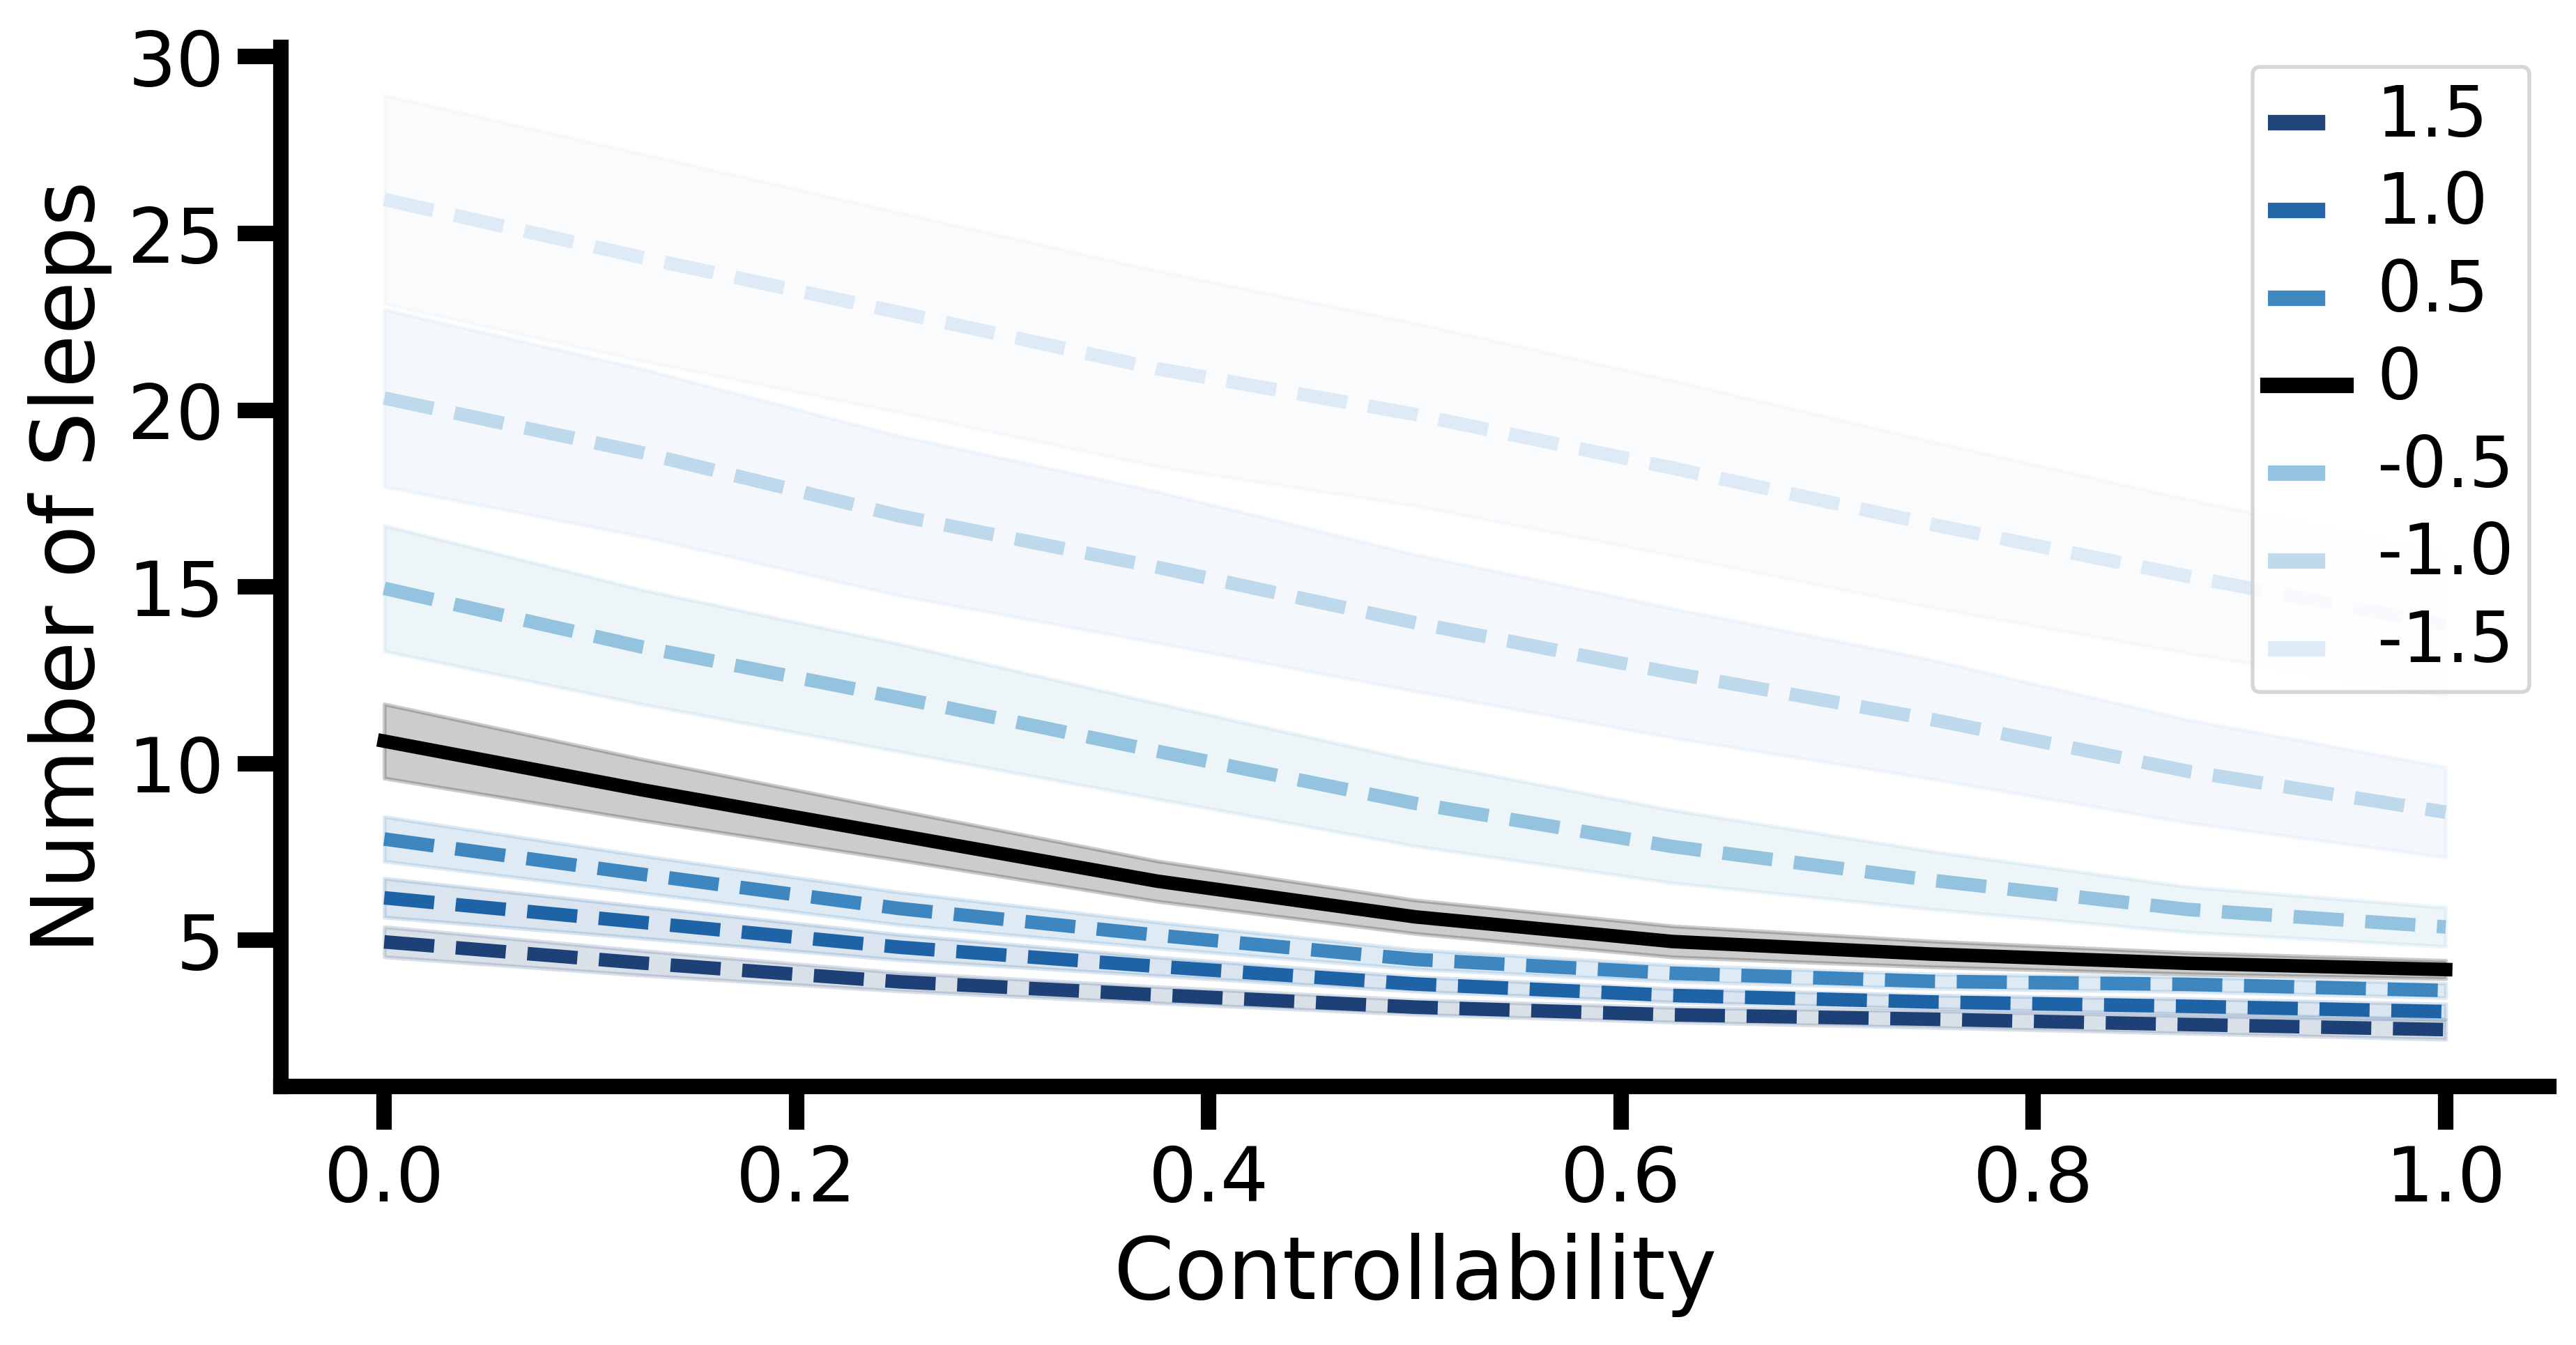

In [11]:
from test_analyses import plot_behavior_mistrained

fig = plot_behavior_mistrained(test_taus, np.flip(models_mis_taus_sleepss, axis=(0,2)), axis_xlabel='Controllability', axis_ylabel='Number of Sleeps', perturbation_taus = perturbation_taus, cmap = mpl.cm.Blues, figsize=(10.4952, 4.9359), font_size_multiplier=1.4)

In [12]:
fig.savefig(os.path.join(analysis_folder, 'perturbed_levc.png'))
fig.savefig(os.path.join(analysis_folder, 'perturbed_levc.svg'))

#### Stats

In [13]:
selected_n_sleeps = np.flip(models_mis_taus_sleepss, axis=(0,2))
selected_n_sleeps = selected_n_sleeps[:, [1,3,5]].sum(axis=-1).T
tested_levels = [1, 0, -1]

In [14]:
## MEANS AND SEMS
for level, selected_sleep in zip(tested_levels, selected_n_sleeps):
    print("Test Controllability ", level)
    print("Mean ", selected_sleep.mean())
    print("StdErr ", selected_sleep.std()/np.sqrt(selected_sleep.shape[0]))
    print("N", selected_sleep.shape[0])

Test Controllability  1
Mean  37.31699999999999
StdErr  2.3444197789645096
N 10
Test Controllability  0
Mean  58.27
StdErr  4.6951596351987845
N 10
Test Controllability  -1
Mean  127.897
StdErr  17.29780125044799
N 10


In [15]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

reshaped_data = selected_n_sleeps.T
pvals = []
pairs = [(0, 1), (0, 2), (1, 2)]  # Indices of settings pairs
for i, (idx1, idx2) in enumerate(pairs):
    t_stat, p_val = ttest_rel(reshaped_data[:, idx1], reshaped_data[:, idx2])
    pvals.append(p_val)
    print(f"Paired t-test {i+1}: p-value = {p_val}")

# Apply Holm-Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='holm')
print("\nCorrected p-values (Holm-Bonferroni):")
for i, (reject, p_val) in enumerate(zip(reject, pvals_corrected)):
    print(f"Comparison {i+1}: reject null hypothesis = {reject}, corrected p-value = {p_val}")

Paired t-test 1: p-value = 8.74203763098903e-05
Paired t-test 2: p-value = 0.0004589450954089117
Paired t-test 3: p-value = 0.0007386780003249872

Corrected p-values (Holm-Bonferroni):
Comparison 1: reject null hypothesis = True, corrected p-value = 0.0002622611289296709
Comparison 2: reject null hypothesis = True, corrected p-value = 0.0009178901908178234
Comparison 3: reject null hypothesis = True, corrected p-value = 0.0009178901908178234


## Panel A: Task 1 Observes

### Humans

In [16]:
from human_utils_project import get_clean_data

day = 'day2'
exp_date = '24-01-22-29'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

n_steps = 50

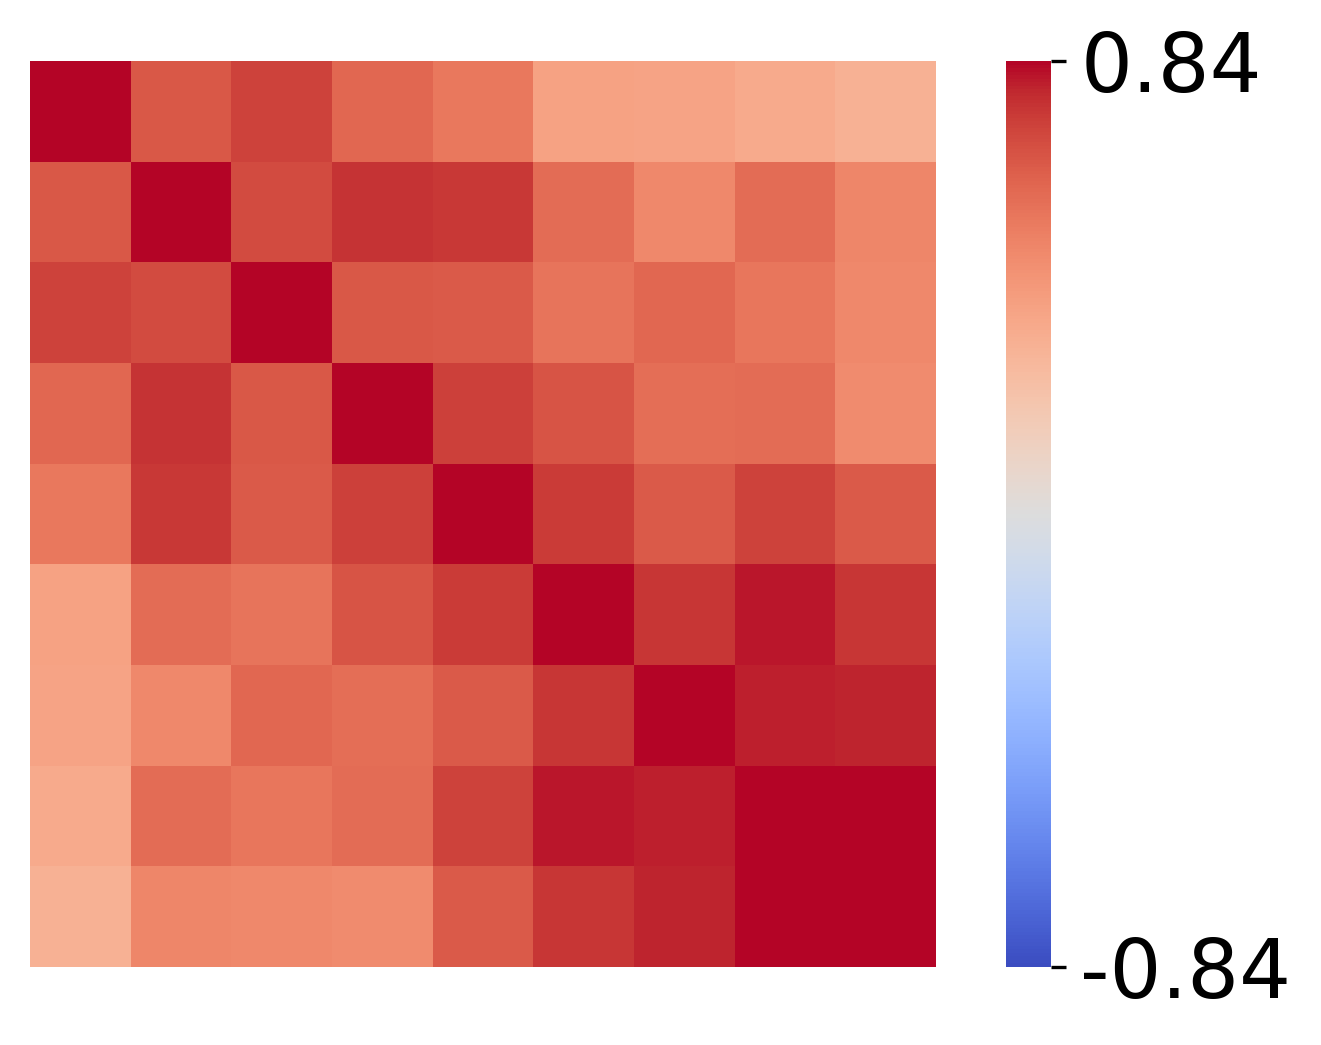

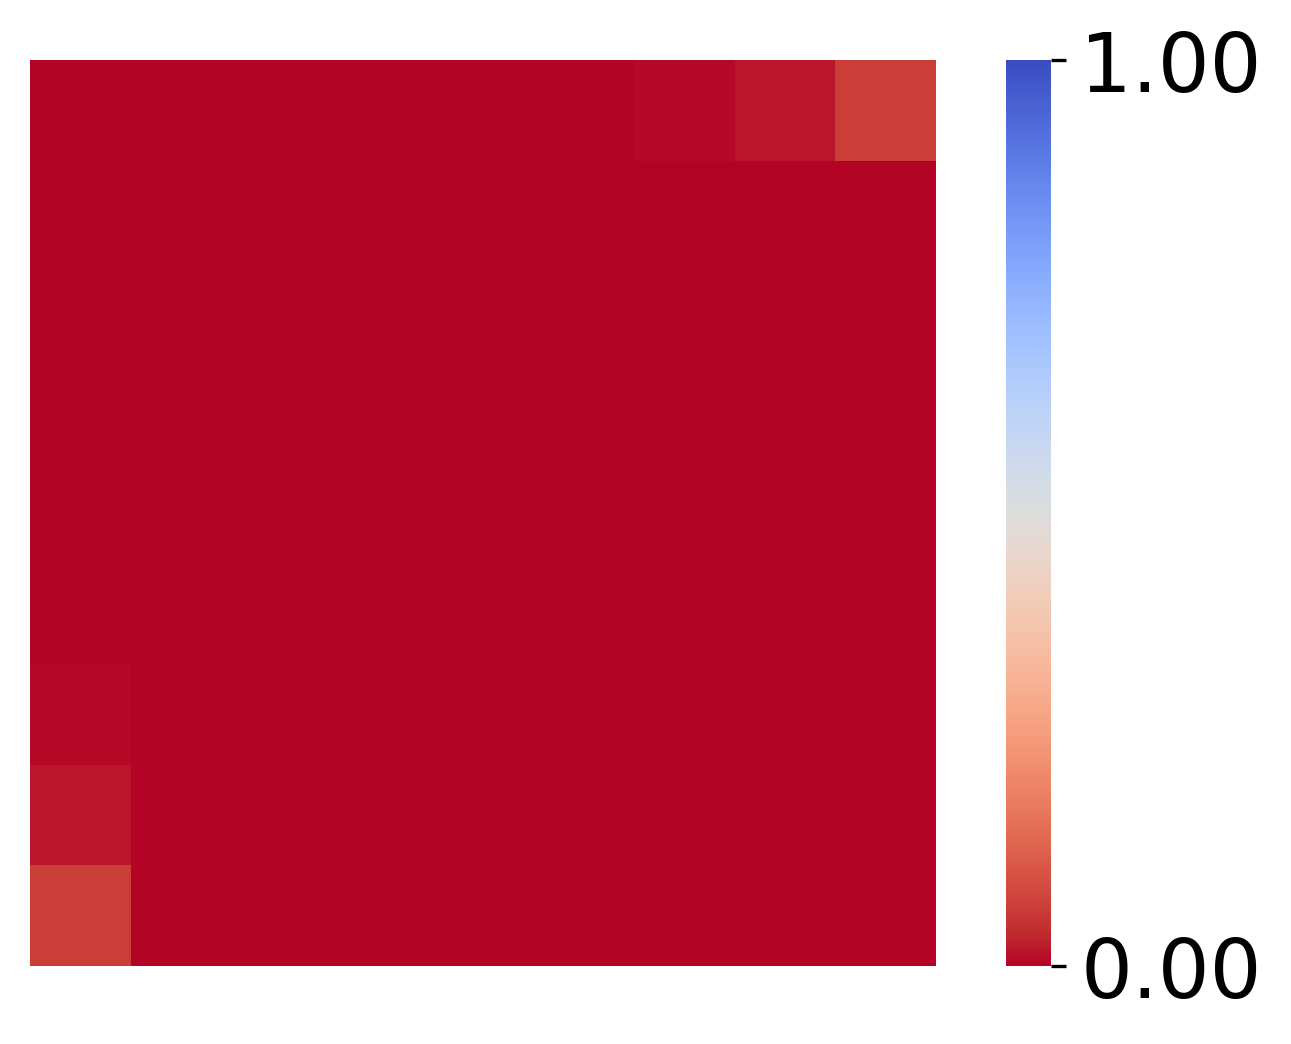

In [17]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['n_observes'], df['n_observes'], df['effs'], df['effs'], col1name = 'Observes', col2name='Observes', annot=False, resize_colorbar = True, square=square, axes_off=True, font_size_multiplier=1.4, groups=df['group'])

In [18]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_humans.svg'))

pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_humans.svg'))

#### Stats

In [19]:
## NUMBER OF HUMANS
print(len(df))

print(sum(~df['group']))
print(sum(df['group']))

111
46
65


### Trait-level simulations

In [20]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t1 as sim_timestamp

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss = np.flip(sim_rewss.T, axis=1)
sim_obss = np.flip(sim_obss.T, axis=1)

effs = np.arange(0, 1.125, 0.125)

(150, 9)


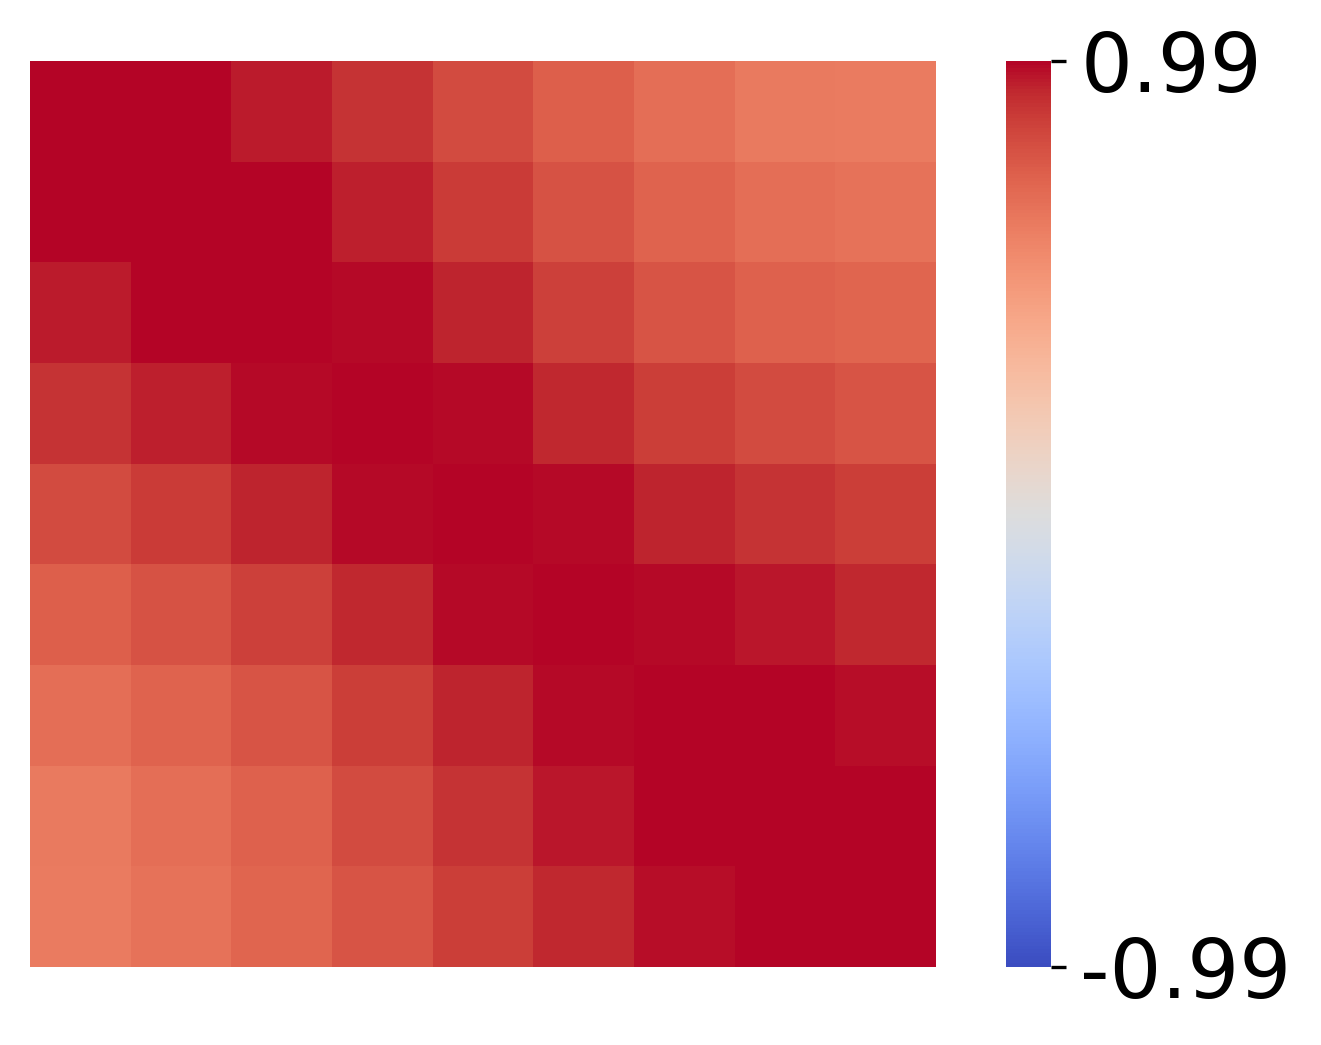

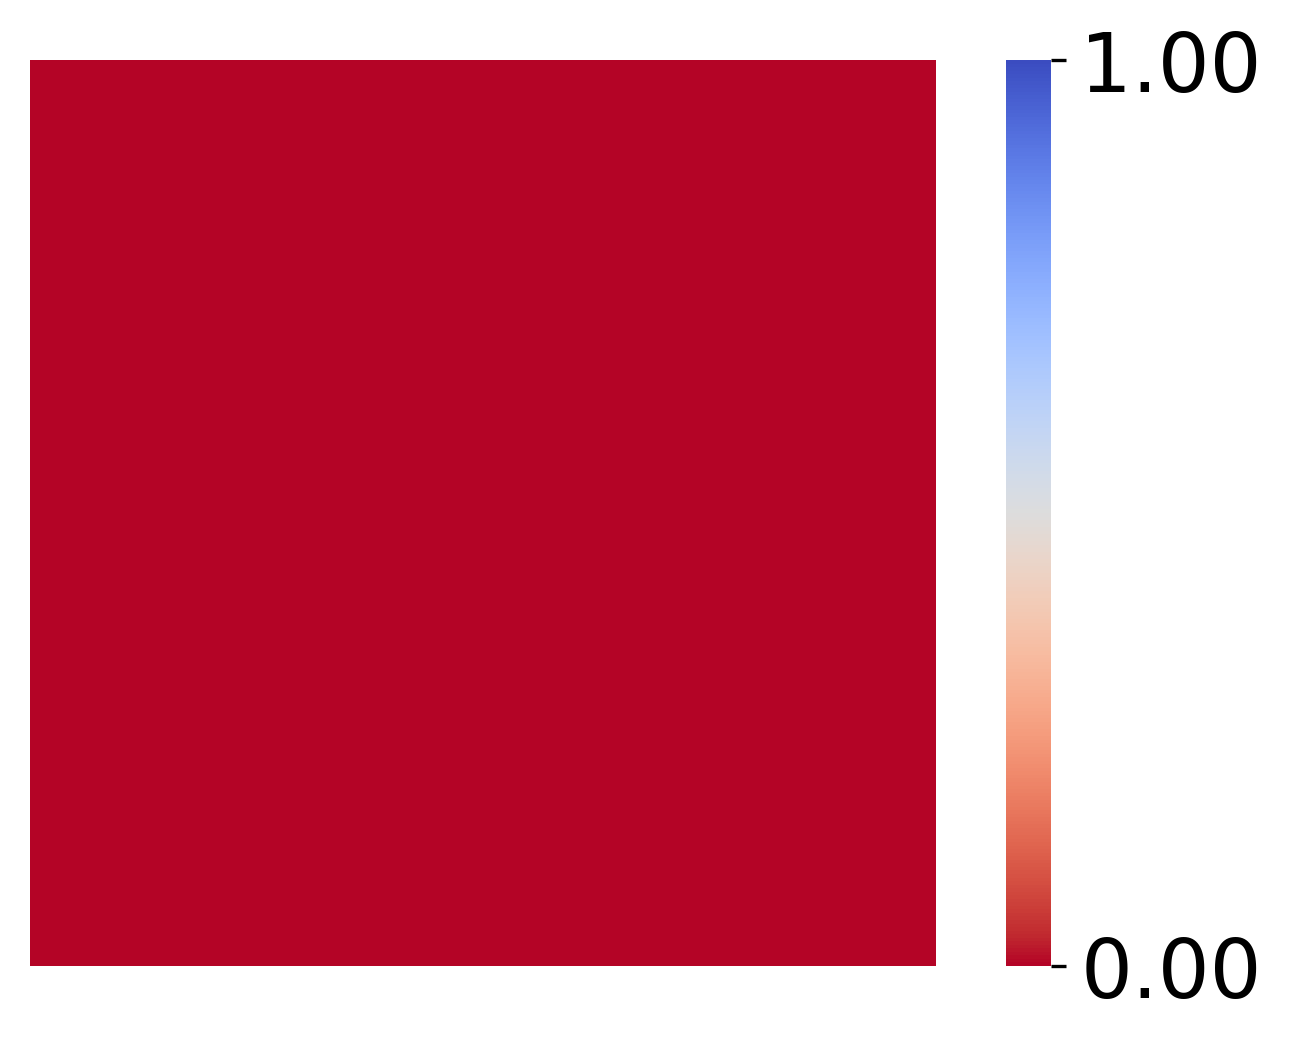

In [21]:
corr_fig, pvs_fig = compute_2D_correlation(sim_obss, sim_obss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=True, font_size_multiplier=1.4)

In [22]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_trait.svg'))

### Random Perturbations

In [23]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t1 as sim_timestamp

random_rewss, random_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

random_rewss = random_rewss.mean(axis=0)
random_obss = random_obss.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss = np.flip(random_rewss.T, axis=1)
random_obss = np.flip(random_obss.T, axis=1)

(150, 9)


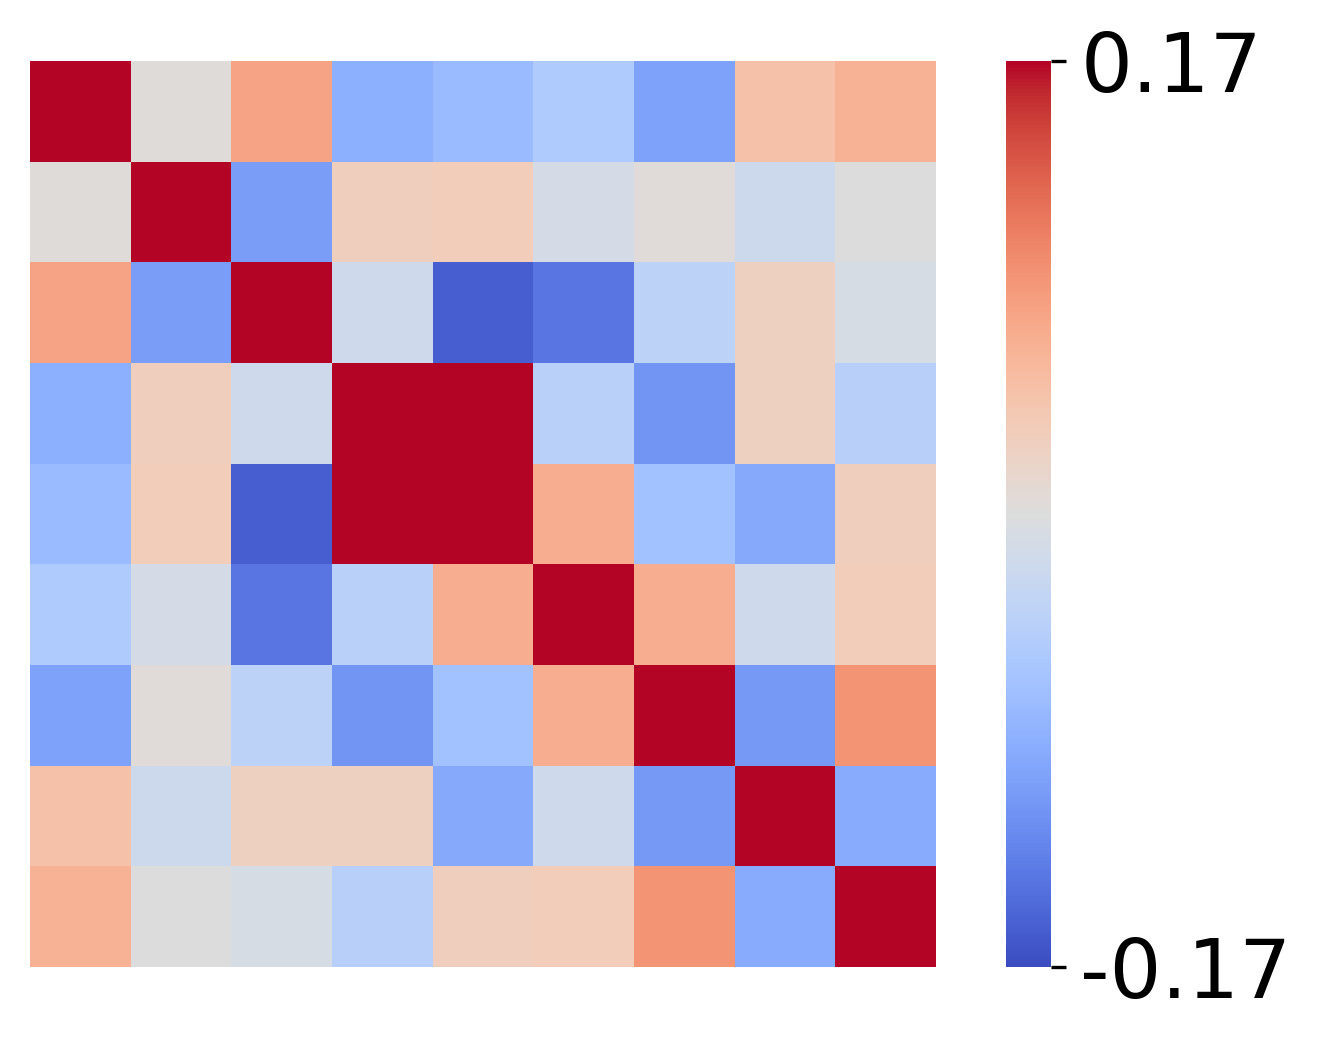

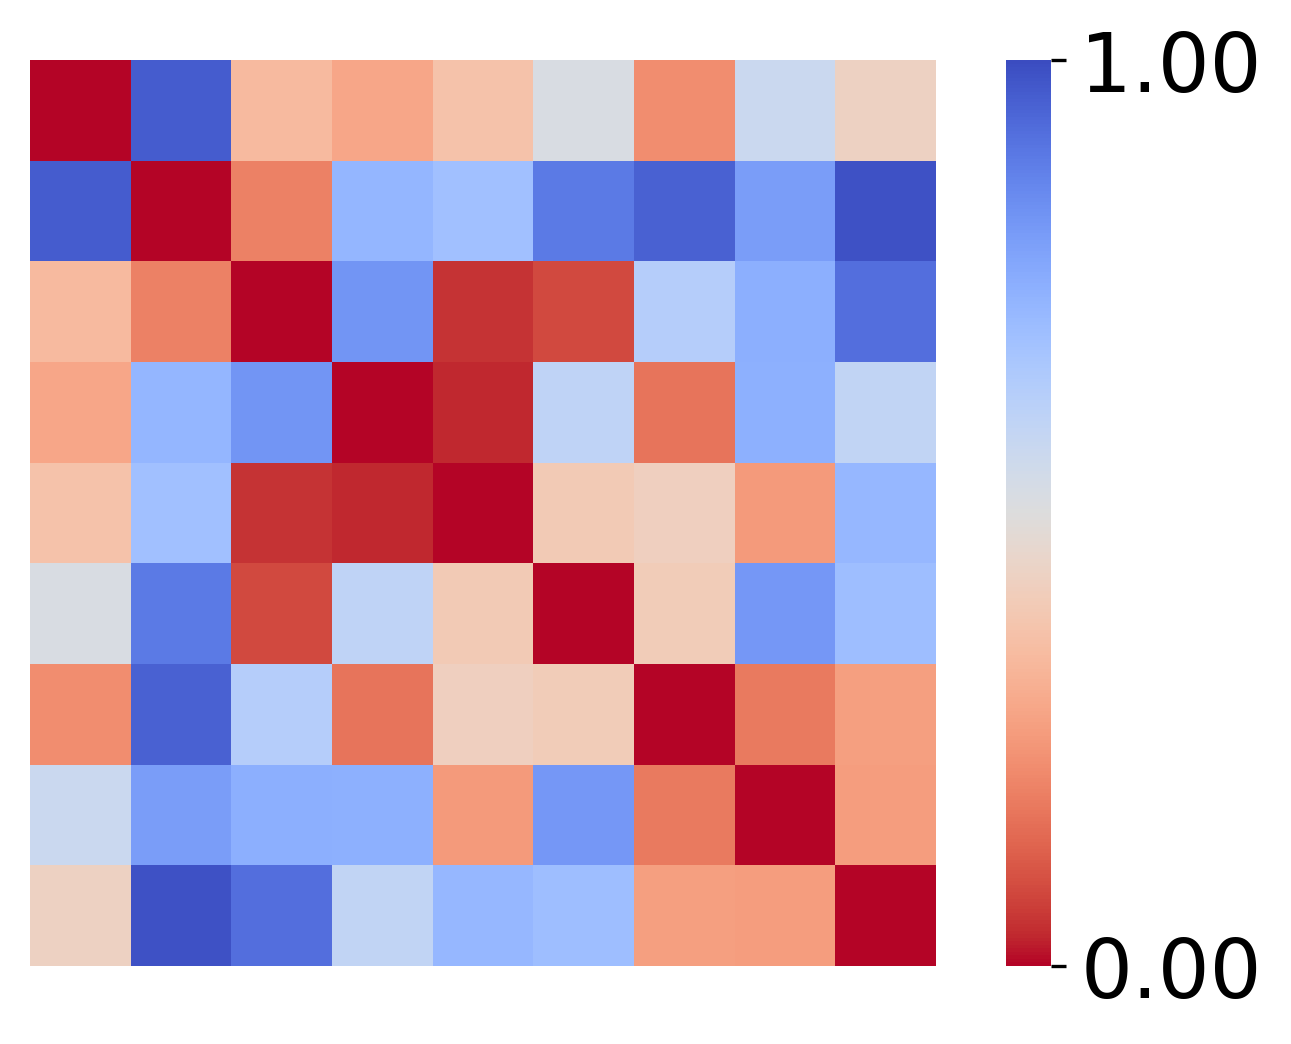

In [24]:
corr_fig, pvs_fig = compute_2D_correlation(random_obss, random_obss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=axes_off , font_size_multiplier=1.4)

In [25]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_random.svg'))

### Zeros Perturbation

In [26]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t1 as sim_timestamp

zeros_rewss, zeros_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_obss = np.flip(zeros_obss.T, axis=1)

effs = np.arange(0, 1.125, 0.125)

(150, 9)


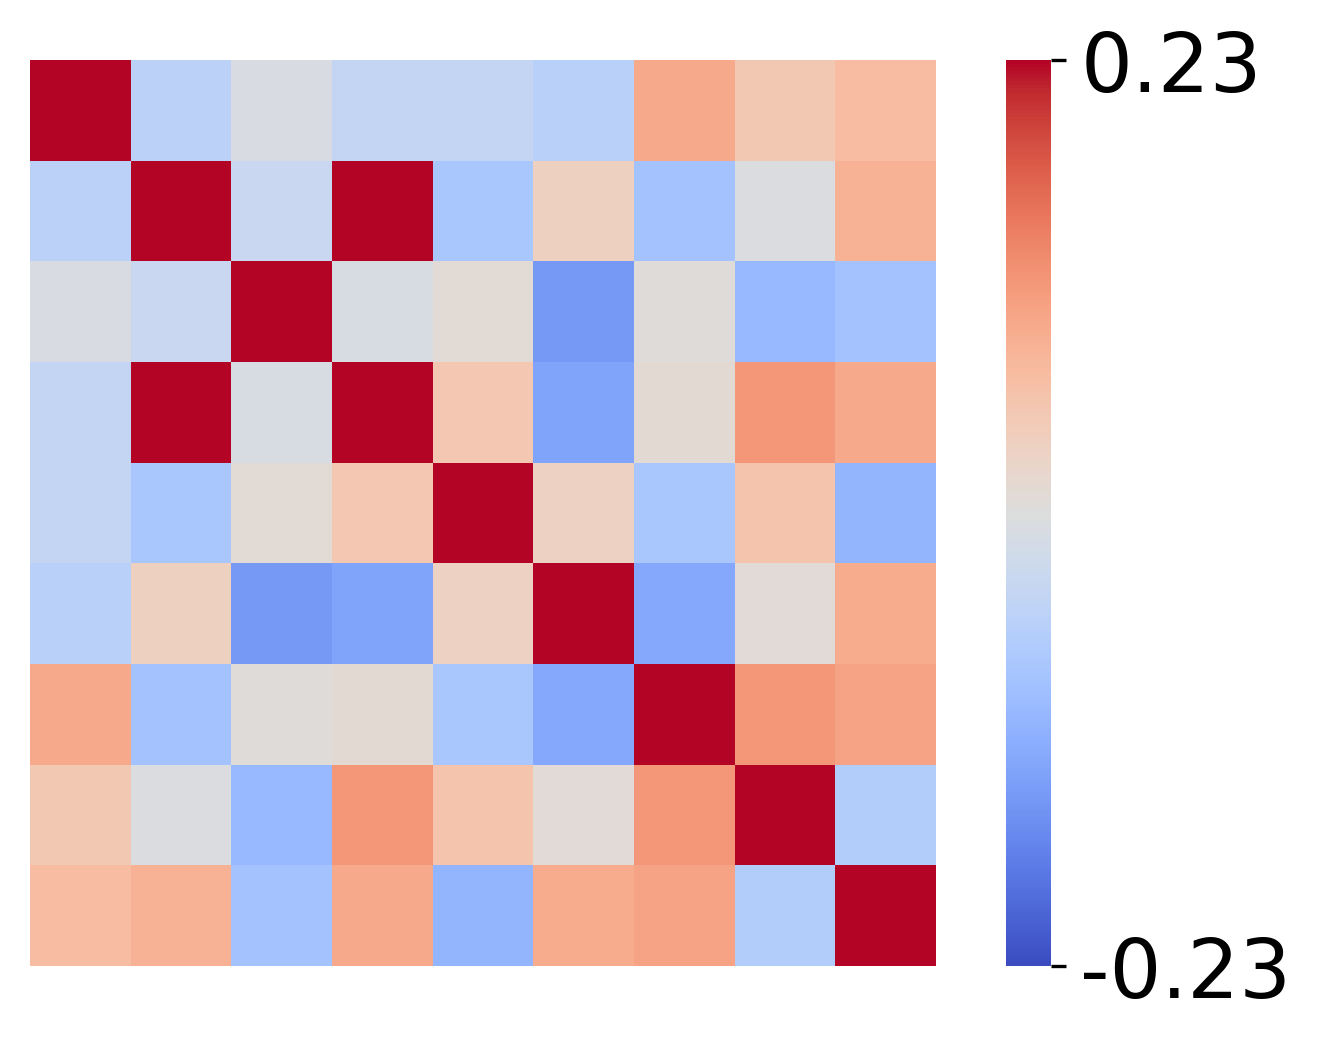

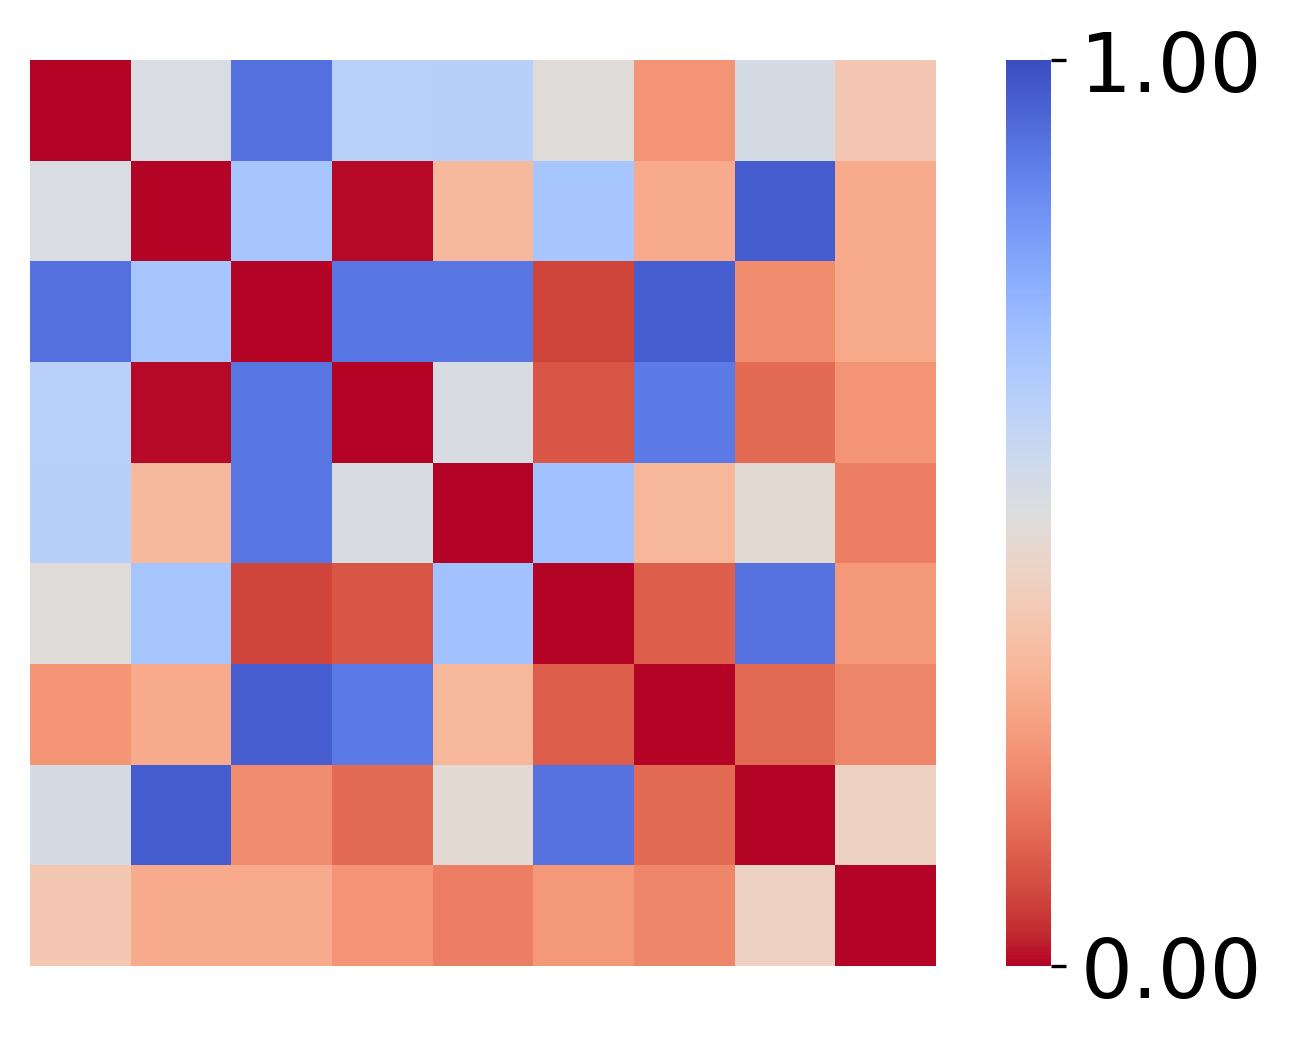

In [27]:
corr_fig, pvs_fig = compute_2D_correlation(zeros_obss, zeros_obss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=axes_off , font_size_multiplier=1.4)

In [28]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_zeros.svg'))

### Stats
#### Competitive Linear Regression

In [29]:
from human_utils_behavioral_analysis import compute_2D_correlation_matrices

data_obs_corr_g1, data_obs_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_obs_corr_g2, data_obs_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_rews_corr_g1, data_rews_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_rews_corr_g2, data_rews_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_obs_corr = (~df['group']).sum() / len(df) * data_obs_corr_g1 + (df['group']).sum() / len(df) * data_obs_corr_g2
data_obs_pvs = (~df['group']).sum() / len(df) * data_obs_pvs_g1 + (df['group']).sum() / len(df) * data_obs_pvs_g2

data_rews_corr = (~df['group']).sum() / len(df) * data_rews_corr_g1 + (df['group']).sum() / len(df) * data_rews_corr_g2
data_rews_pvs = (~df['group']).sum() / len(df) * data_rews_pvs_g1 + (df['group']).sum() / len(df) * data_rews_pvs_g2
sim_obs_corr, sim_obs_pvs = compute_2D_correlation_matrices(sim_obss, sim_obss, effs, effs,)
sim_rews_corr, sim_rews_pvs = compute_2D_correlation_matrices(sim_rewss, sim_rewss, effs, effs,)
random_obs_corr, random_obs_pvs = compute_2D_correlation_matrices(random_obss, random_obss, effs, effs,)
random_rews_corr, random_rews_pvs = compute_2D_correlation_matrices(random_rewss, random_rewss, effs, effs,)
zeros_obs_corr, zeros_obs_pvs = compute_2D_correlation_matrices(zeros_obss, zeros_obss, effs, effs,)

(46, 9)
(65, 9)
(46, 9)
(65, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)


In [30]:
from human_utils_behavioral_analysis import competitive_corr_regression, upper_tri_masking

competitive_corr_regression(upper_tri_masking(data_obs_corr), [upper_tri_masking(sim_obs_corr), upper_tri_masking(random_obs_corr), upper_tri_masking(zeros_obs_corr)], do_fisher_transform=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     20.79
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           1.17e-07
Time:                        15:54:07   Log-Likelihood:                 22.012
No. Observations:                  36   AIC:                            -36.02
Df Residuals:                      32   BIC:                            -29.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3041      0.064      4.756      0.0

#### Cosine Similarity

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(upper_tri_masking(data_obs_corr).reshape((1,-1)), upper_tri_masking(sim_obs_corr).reshape((1,-1)))[0][0])
print(cosine_similarity(upper_tri_masking(data_obs_corr).reshape((1,-1)), upper_tri_masking(random_obs_corr).reshape((1,-1)))[0][0])

0.9933362588074914
-0.20697123787211422


## Panel B: Task 1 Rewards
### Humans

In [32]:
from human_utils_project import get_clean_data

day = 'day2'
exp_date = '24-01-22-29'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

effs = np.arange(0, 1.125, 0.125)
n_steps = 50

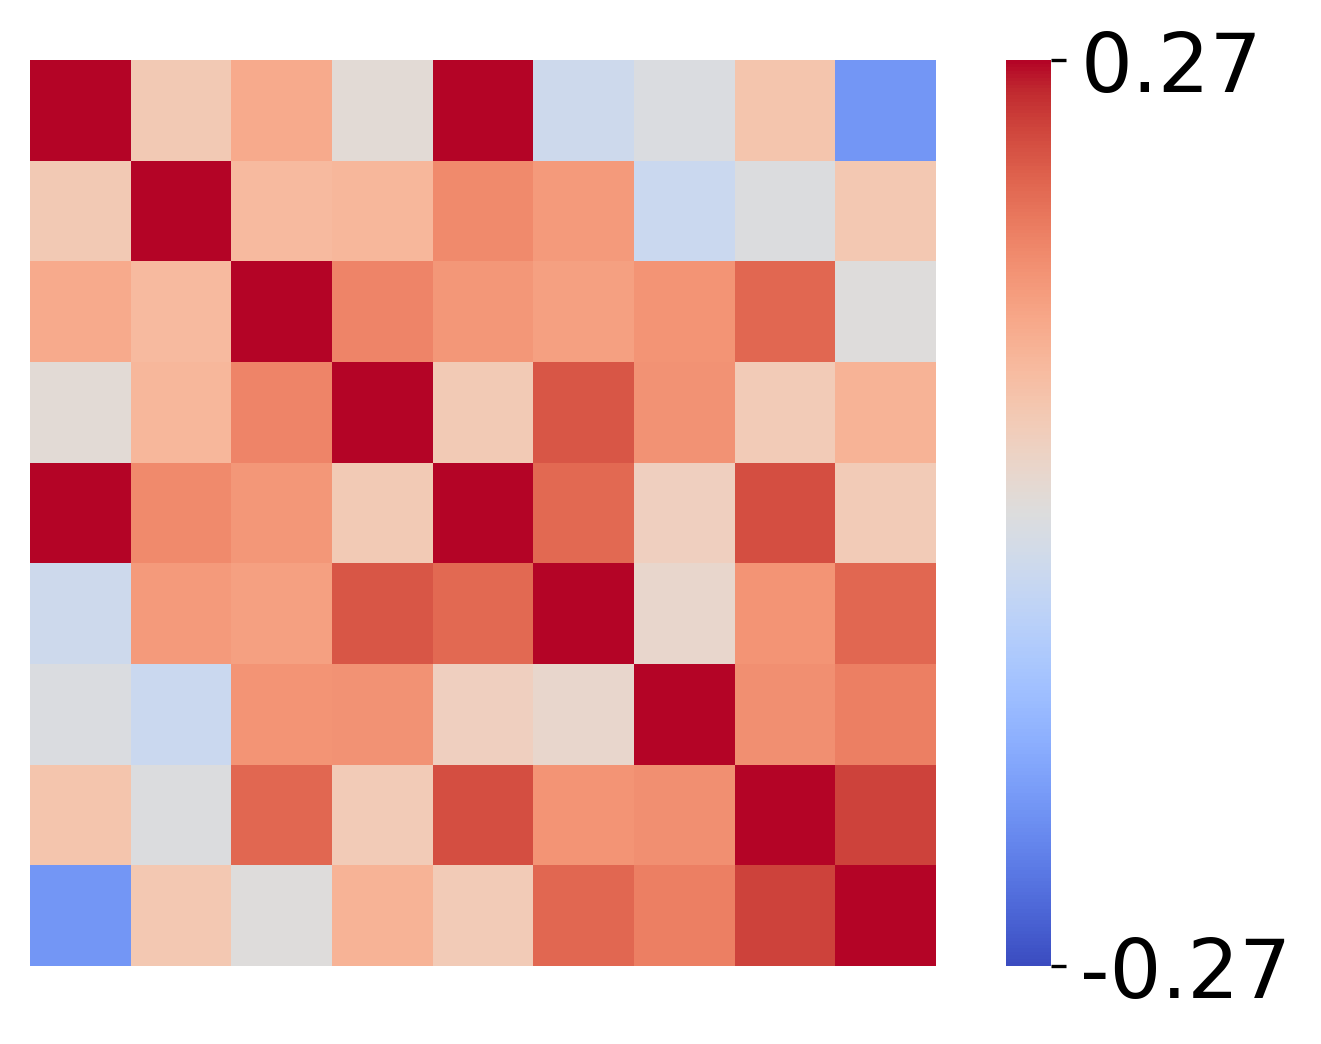

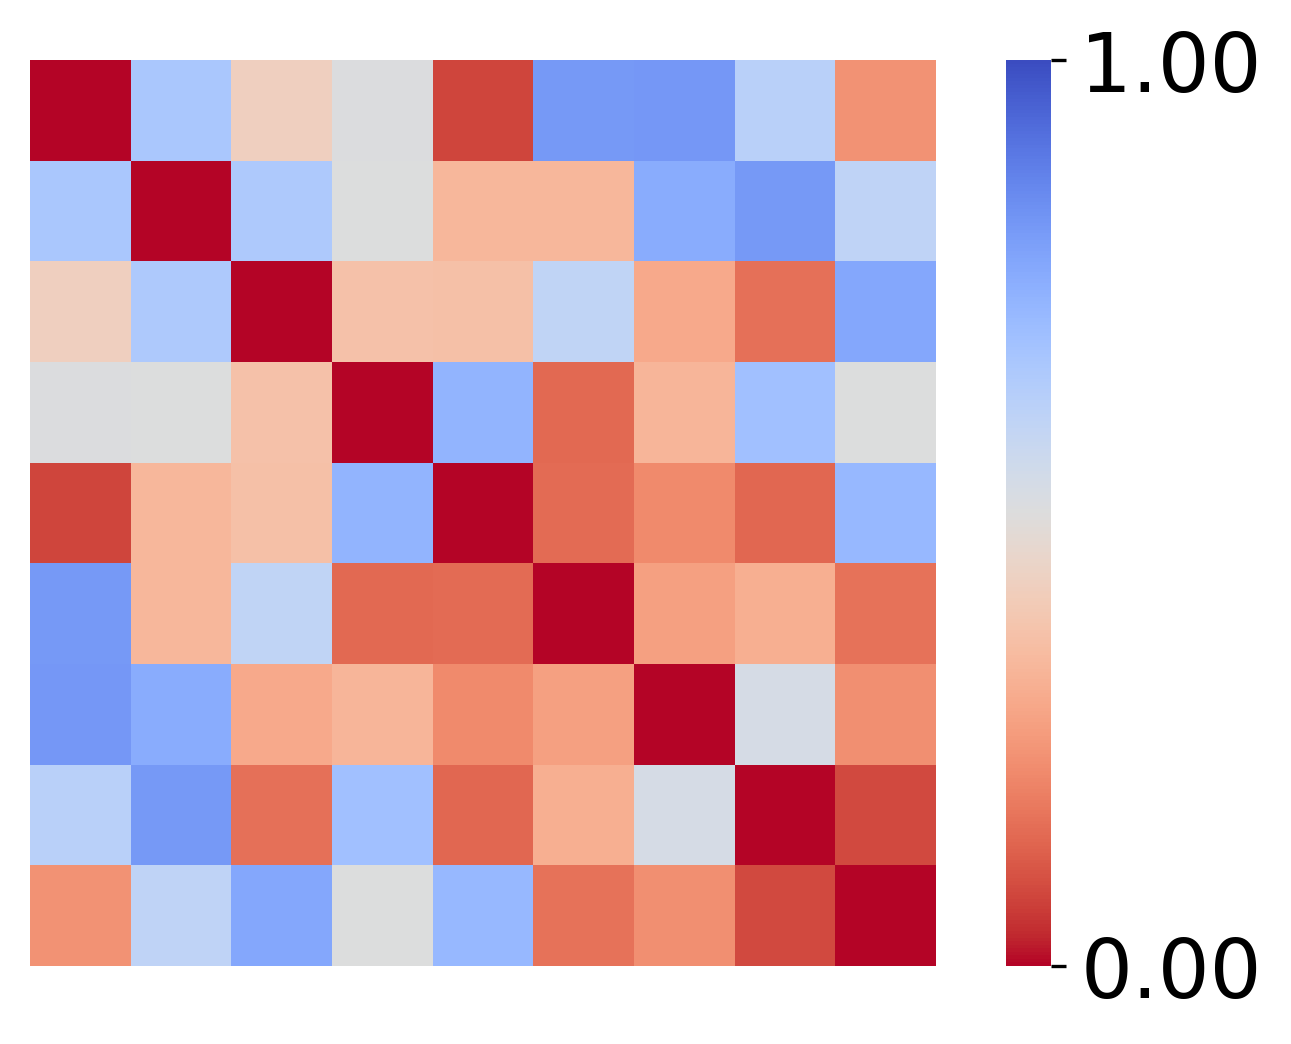

In [33]:
corr_fig, pvs_fig = compute_2D_correlation(df['rewards_tallies'], df['rewards_tallies'], df['effs'], df['effs'], col1name = 'Rewards', col2name='Rewards', annot=False, resize_colorbar = True, square=square, axes_off=True, font_size_multiplier=1.4, groups=df['group'])

In [34]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_rewards_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_rewards_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_rewards_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_rewards_humans.svg'))

### Trait-level Simulations

In [35]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t1 as sim_timestamp

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss = np.flip(sim_rewss.T, axis=1)
sim_obss = np.flip(sim_obss.T, axis=1)

(150, 9)


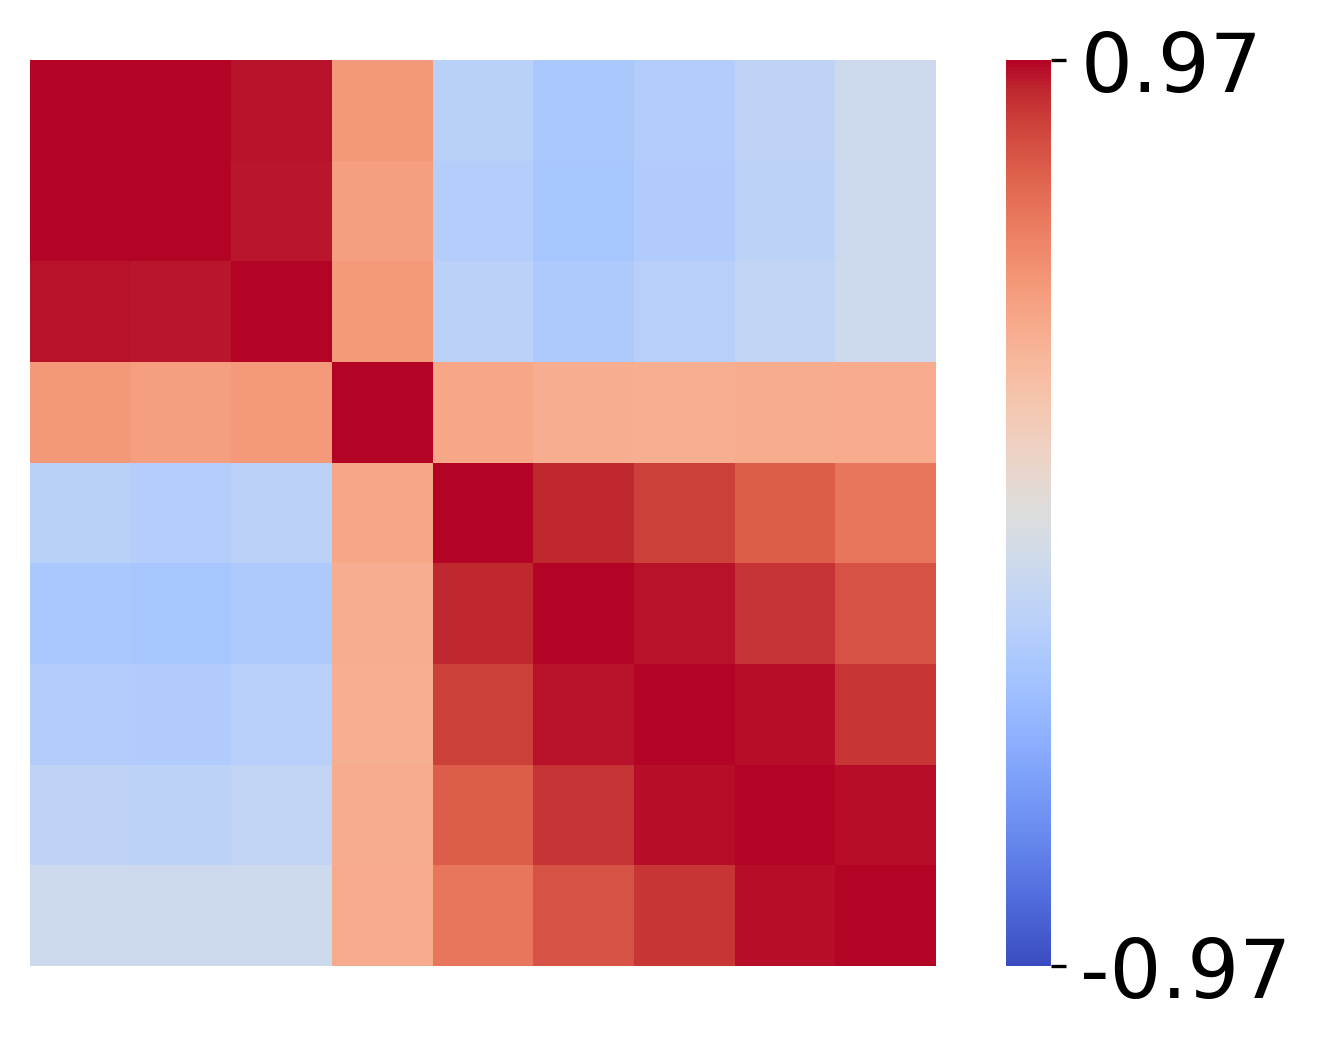

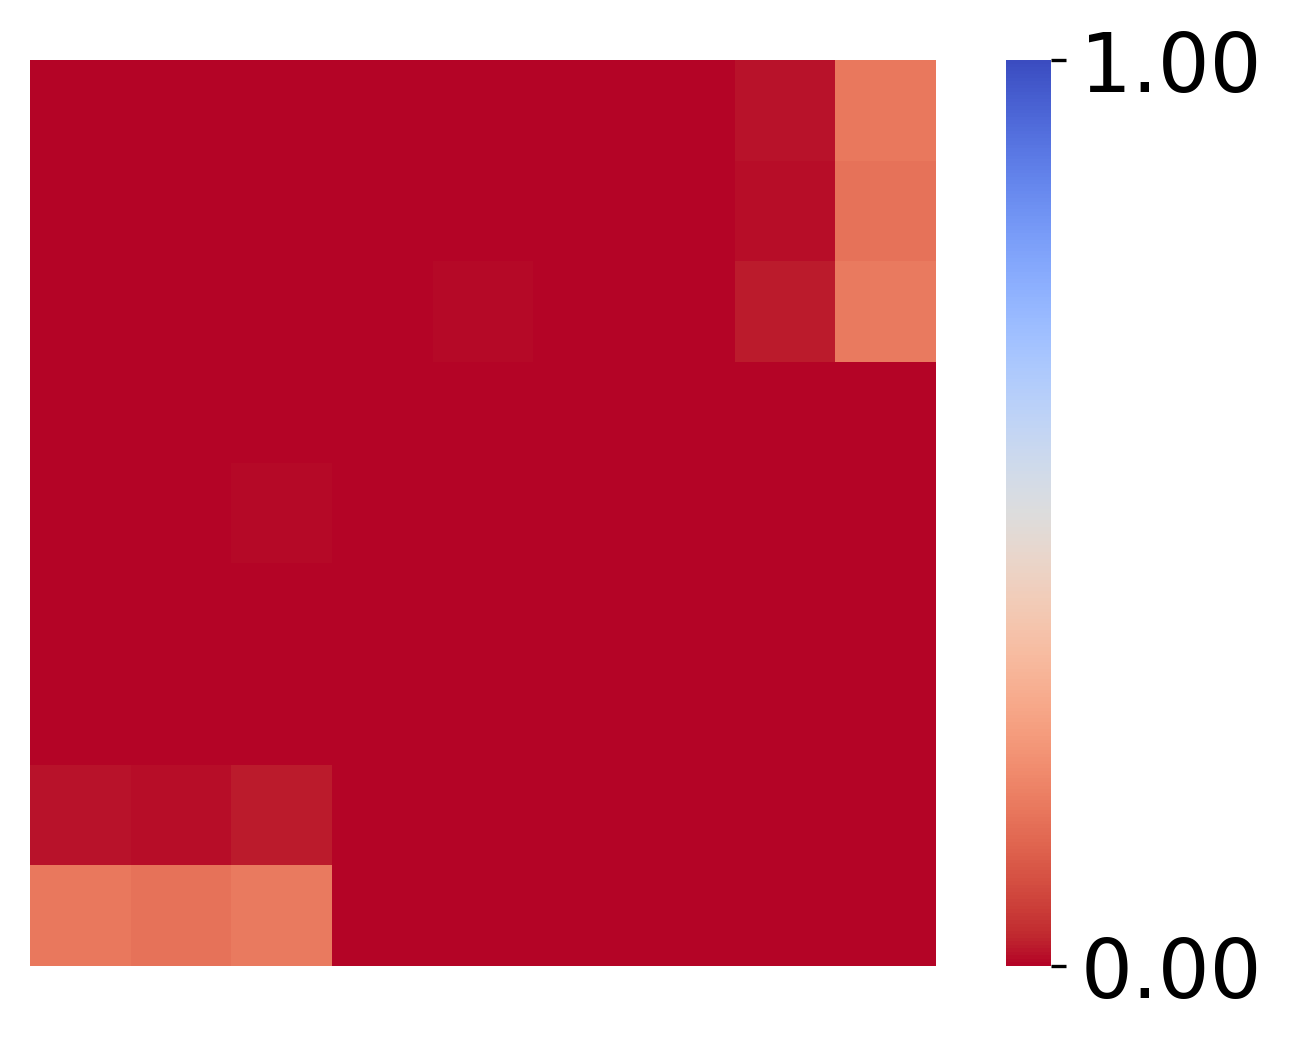

In [36]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(sim_rewss, sim_rewss, effs, effs, "Rewards", "Rewards", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [37]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_rewards_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_rewards_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_rewards_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_rewards_trait.svg'))

### Random Perturbations

In [38]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t1 as sim_timestamp

random_rewss, random_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

random_rewss = random_rewss.mean(axis=0)
random_obss = random_obss.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss = np.flip(random_rewss.T, axis=1)
random_obss = np.flip(random_obss.T, axis=1)

(150, 9)


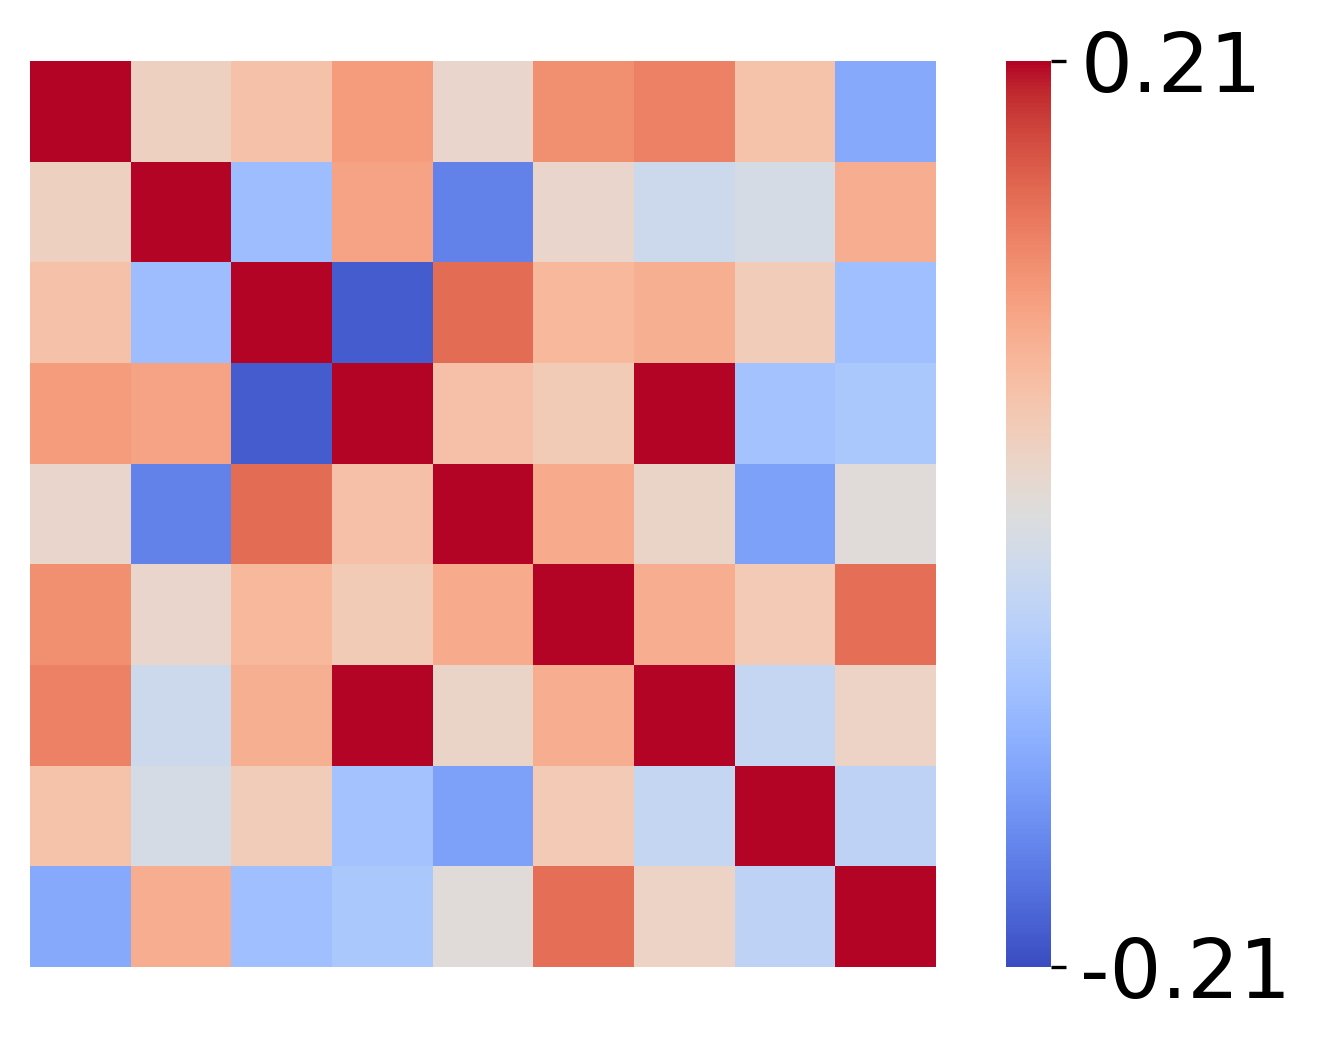

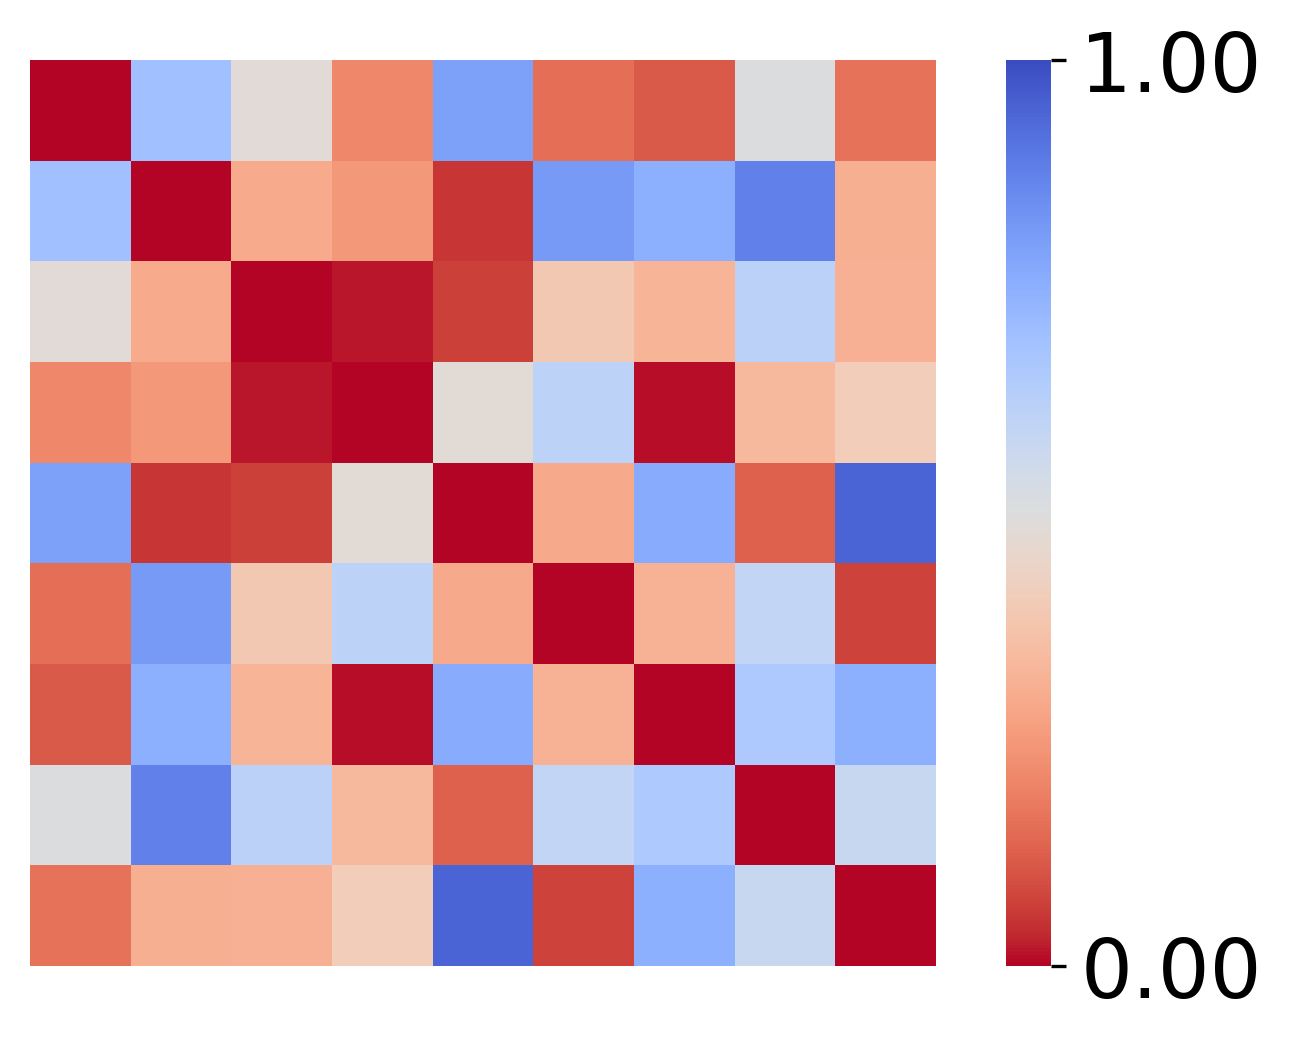

In [39]:
corr_fig, pvs_fig = compute_2D_correlation(random_rewss, random_rewss, effs, effs, "simulated rewards", "simulated rewards", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [40]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_rewards_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_rewards_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_rewards_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_rewards_random.svg'))

### Zeros Perturbation

In [41]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t1 as sim_timestamp

zeros_rewss, zeros_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_obss = np.flip(zeros_obss.T, axis=1)

effs = np.arange(0, 1.125, 0.125)

(150, 9)


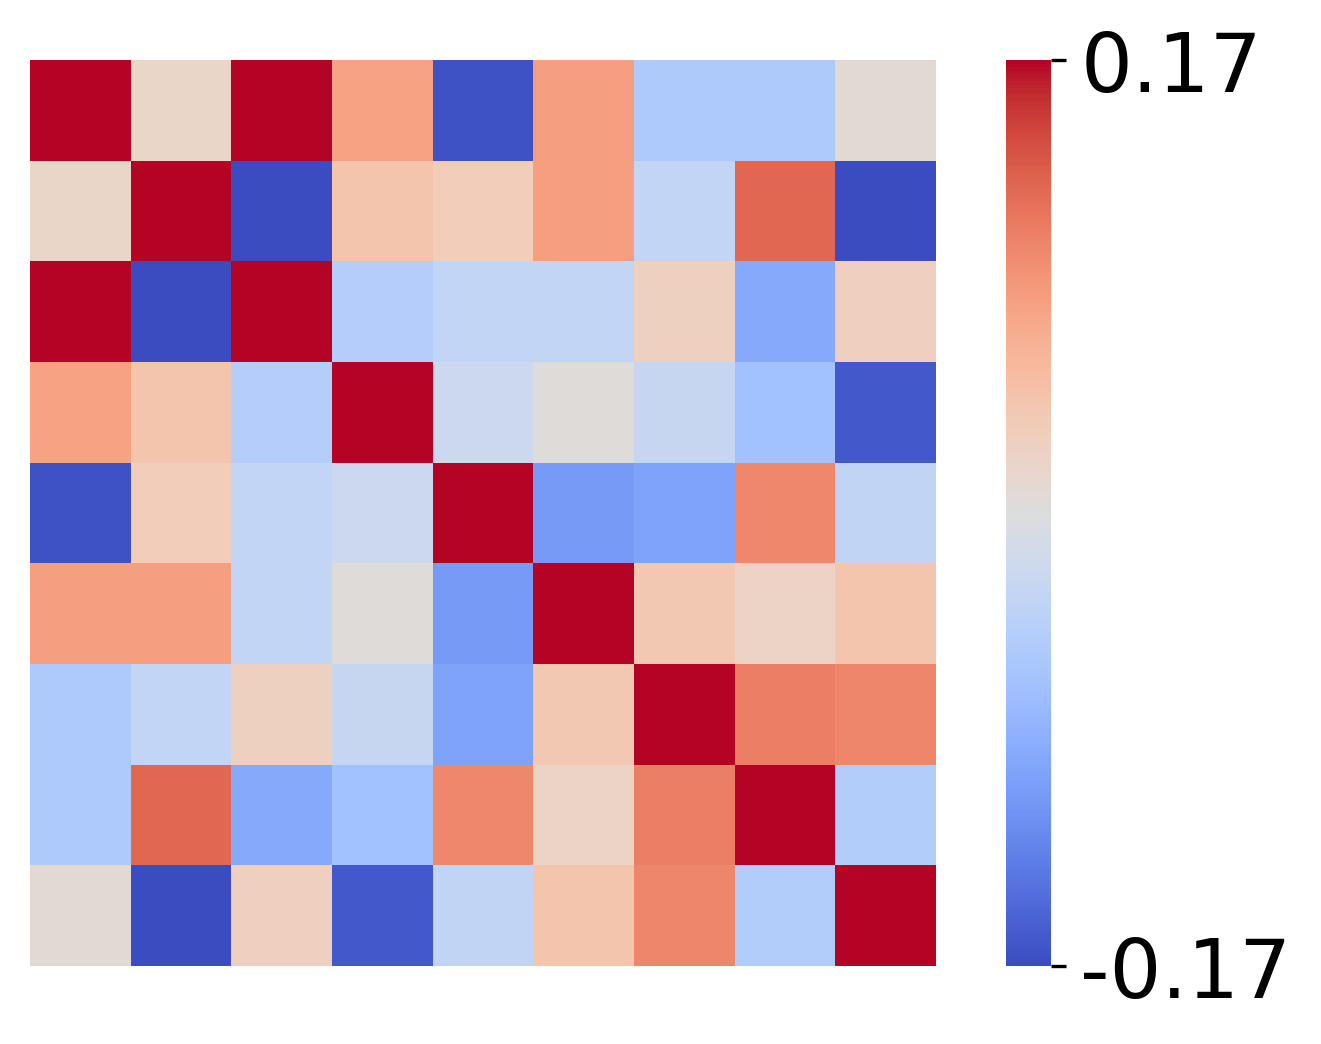

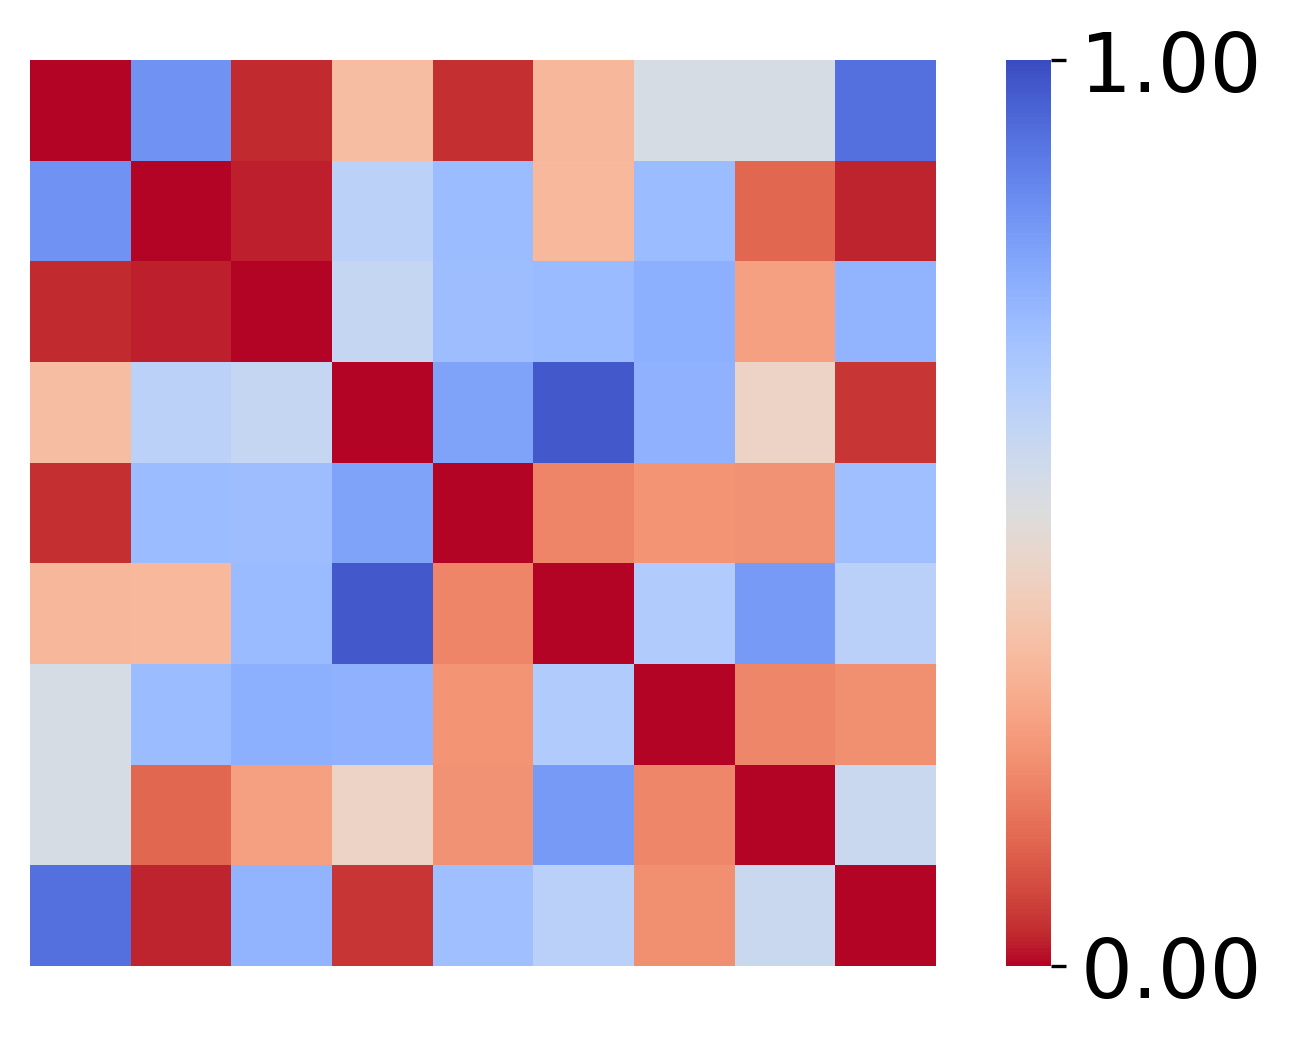

In [42]:
corr_fig, pvs_fig = compute_2D_correlation(zeros_rewss, zeros_rewss, effs, effs, "simulated rewards", "simulated rewards", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [43]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_rewards_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_rewards_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_rewards_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_rewards_zeros.svg'))

### Stats
#### Competitive linear regression

In [44]:
from human_utils_behavioral_analysis import compute_2D_correlation_matrices

data_obs_corr_g1, data_obs_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_obs_corr_g2, data_obs_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_rews_corr_g1, data_rews_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_rews_corr_g2, data_rews_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_obs_corr = (~df['group']).sum() / len(df) * data_obs_corr_g1 + (df['group']).sum() / len(df) * data_obs_corr_g2
data_obs_pvs = (~df['group']).sum() / len(df) * data_obs_pvs_g1 + (df['group']).sum() / len(df) * data_obs_pvs_g2

data_rews_corr = (~df['group']).sum() / len(df) * data_rews_corr_g1 + (df['group']).sum() / len(df) * data_rews_corr_g2
data_rews_pvs = (~df['group']).sum() / len(df) * data_rews_pvs_g1 + (df['group']).sum() / len(df) * data_rews_pvs_g2
sim_obs_corr, sim_obs_pvs = compute_2D_correlation_matrices(sim_obss, sim_obss, effs, effs,)
sim_rews_corr, sim_rews_pvs = compute_2D_correlation_matrices(sim_rewss, sim_rewss, effs, effs,)
random_obs_corr, random_obs_pvs = compute_2D_correlation_matrices(random_obss, random_obss, effs, effs,)
random_rews_corr, random_rews_pvs = compute_2D_correlation_matrices(random_rewss, random_rewss, effs, effs,)

zeros_obs_corr, zeros_obs_pvs = compute_2D_correlation_matrices(zeros_obss, zeros_obss, effs, effs,)
zeros_rews_corr, zeros_rews_pvs = compute_2D_correlation_matrices(zeros_rewss, zeros_rewss, effs, effs,)

(46, 9)
(65, 9)
(46, 9)
(65, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)


In [45]:
competitive_corr_regression(upper_tri_masking(data_rews_corr), [upper_tri_masking(sim_rews_corr), upper_tri_masking(random_rews_corr), upper_tri_masking(zeros_rews_corr)])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.8992
Date:                Mon, 07 Oct 2024   Prob (F-statistic):              0.452
Time:                        15:54:13   Log-Likelihood:                 36.041
No. Observations:                  36   AIC:                            -64.08
Df Residuals:                      32   BIC:                            -57.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0815      0.020      4.124      0.0

#### Cosine Similarity

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(upper_tri_masking(data_rews_corr).reshape((1,-1)), upper_tri_masking(sim_rews_corr).reshape((1,-1)))[0][0])
print(cosine_similarity(upper_tri_masking(data_rews_corr).reshape((1,-1)), upper_tri_masking(random_rews_corr).reshape((1,-1)))[0][0])

0.5437194110654635
0.19185671658593637


## Panel B.2 : Task 1 Estimates
### Humans

In [47]:
from human_utils_project import get_clean_data

day = 'day2'
exp_date = '24-01-22-29'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

n_steps = 50

In [48]:
df.columns

Index(['transitions_ep', 'transitions_ep_rightwrong', 'rewards_tallies', 'ps',
       'effs', 'n_observes', 'intended_correct', 'survey_responses',
       'efficacy_estimates', 'group'],
      dtype='object')

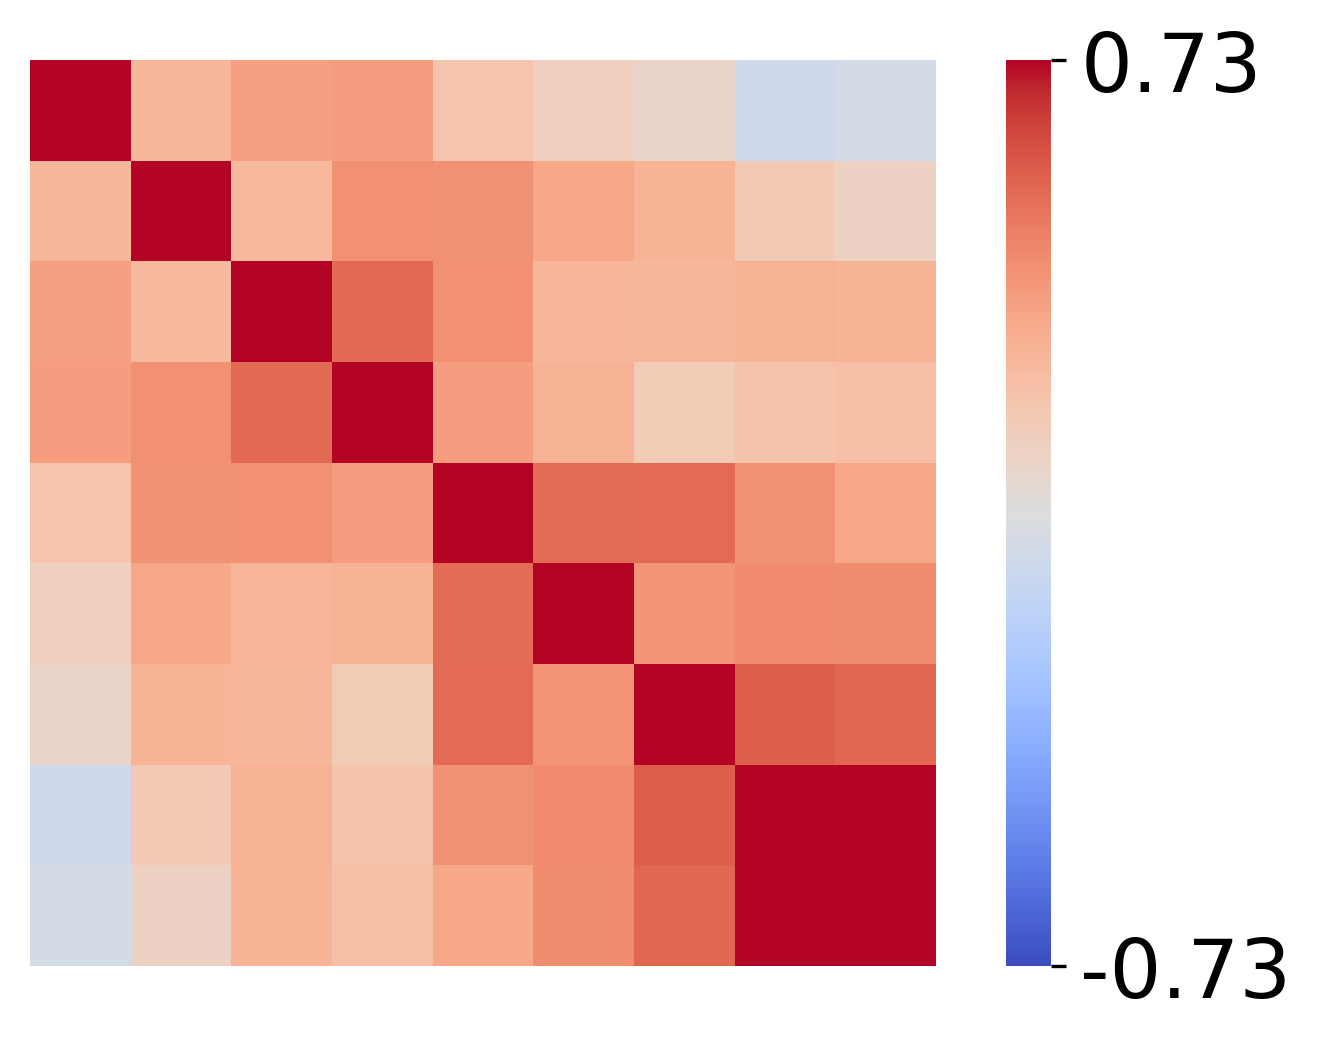

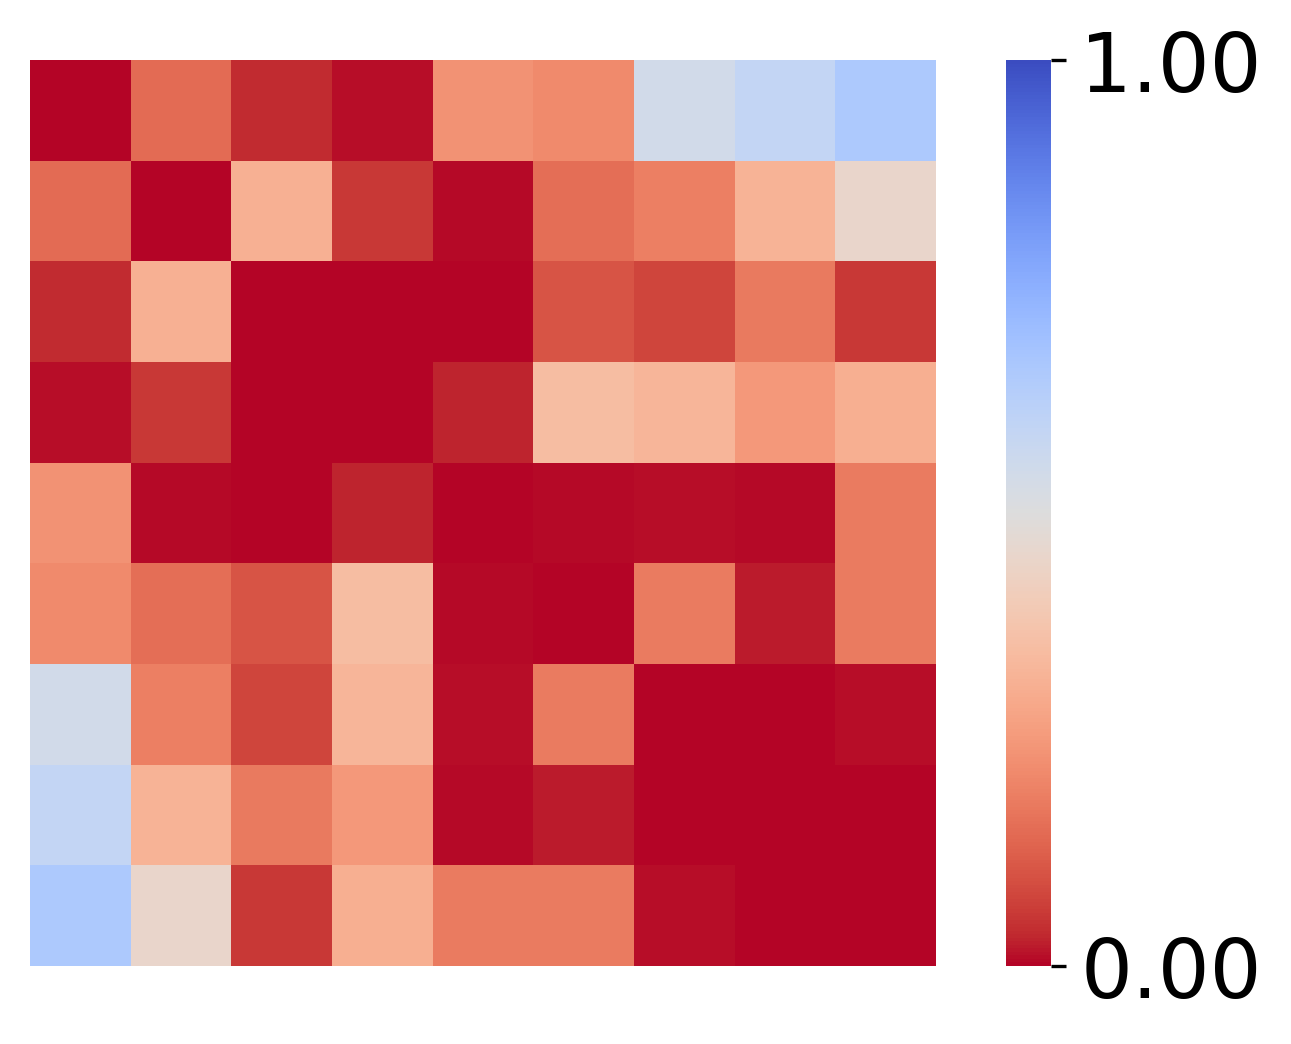

In [49]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['efficacy_estimates'], df['efficacy_estimates'], df['effs'], df['effs'], col1name = 'Rewards', col2name='Rewards', annot=False, resize_colorbar = True, square=square, axes_off=True, font_size_multiplier=1.4, groups=df['group'])

In [50]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_humans.svg'))

### Trait-level simulations

In [51]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t1 as sim_timestamp

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss = np.flip(sim_rewss.T, axis=1)
sim_obss = np.flip(sim_obss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

### CONSTRUCT SIM_ESTS
sim_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations).T

effs = np.arange(0, 1.125, 0.125)

(150, 9)


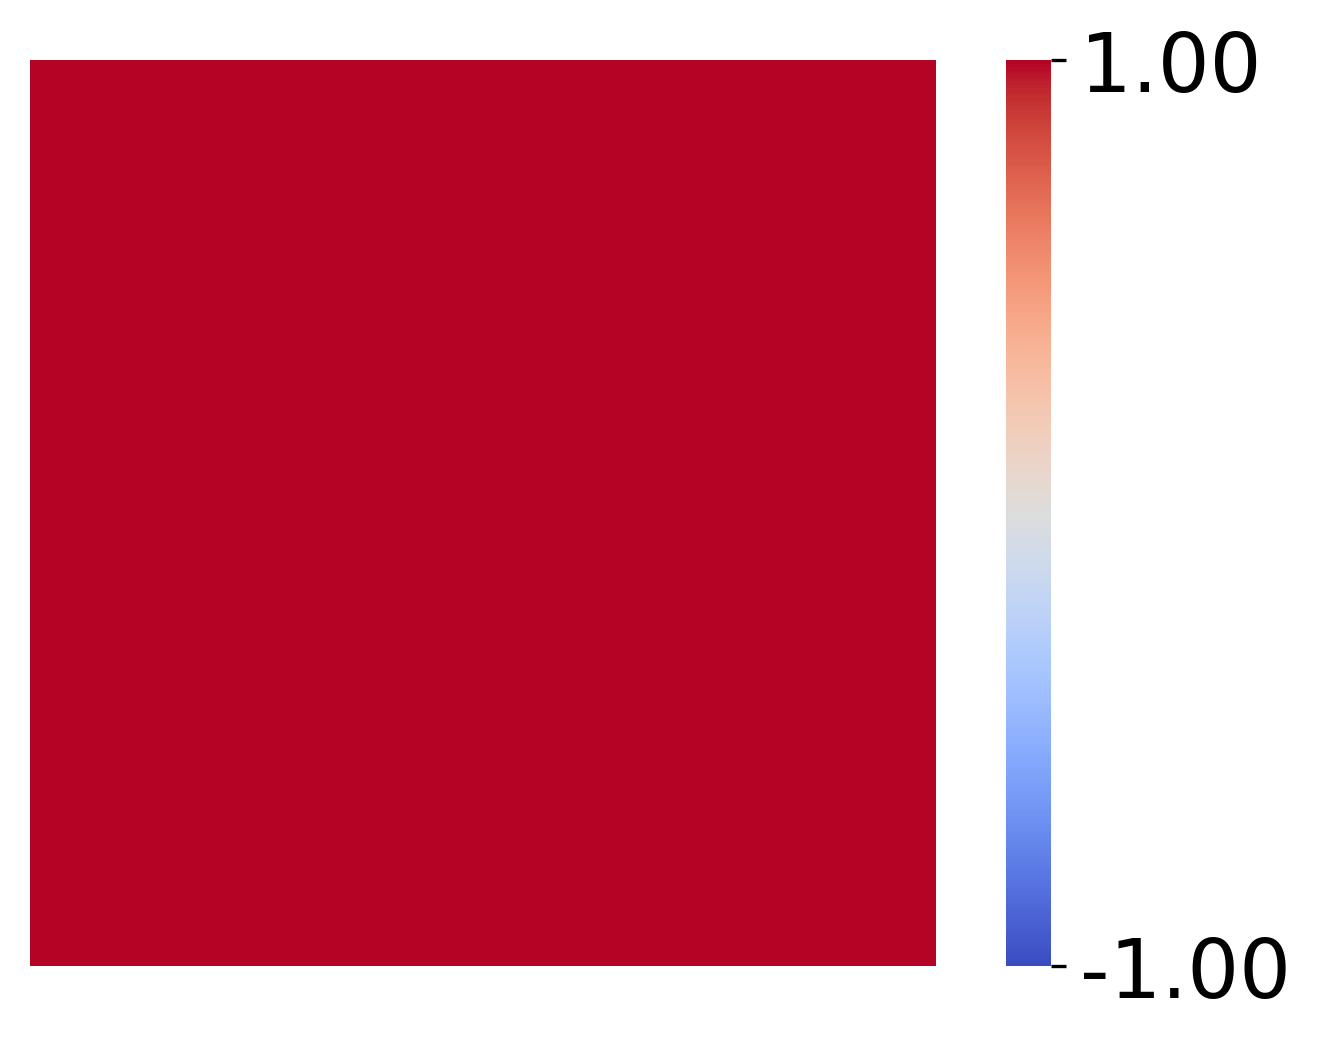

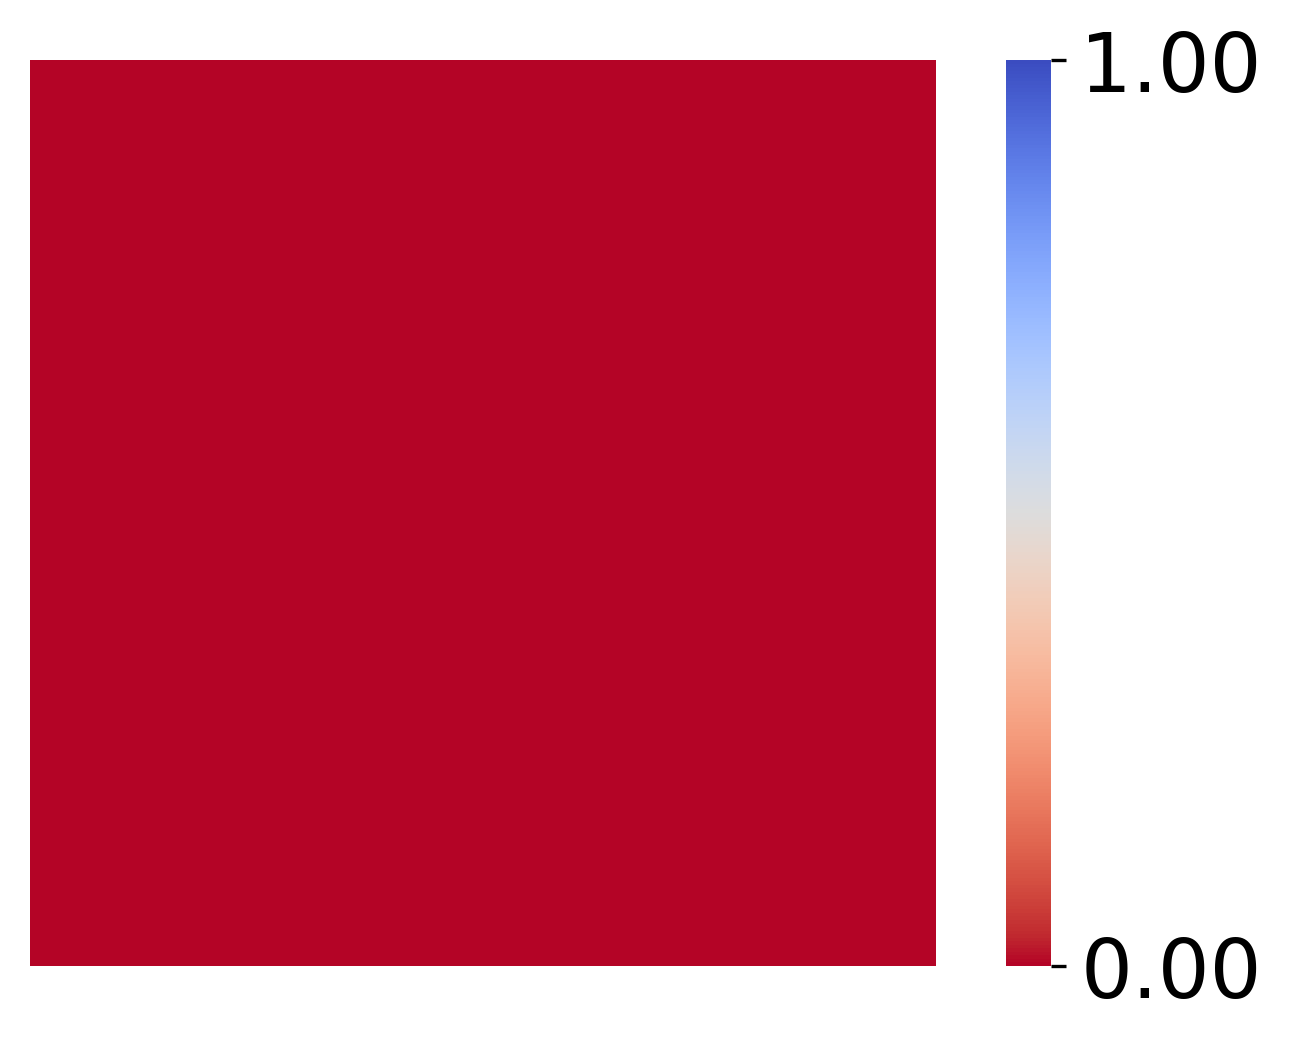

In [52]:
corr_fig, pvs_fig = compute_2D_correlation(sim_estss, sim_estss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=True, font_size_multiplier=1.4)

In [53]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_trait.svg'))

### Random Perturbations

In [54]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t1 as sim_timestamp

random_rewss, random_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

random_rewss = random_rewss.mean(axis=0)
random_obss = random_obss.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss = np.flip(random_rewss.T, axis=1)
random_obss = np.flip(random_obss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'random', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_random_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

### CONSTRUCT SIM_ESTS
random_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)) + sim_participant_perturbations)

(150, 9)


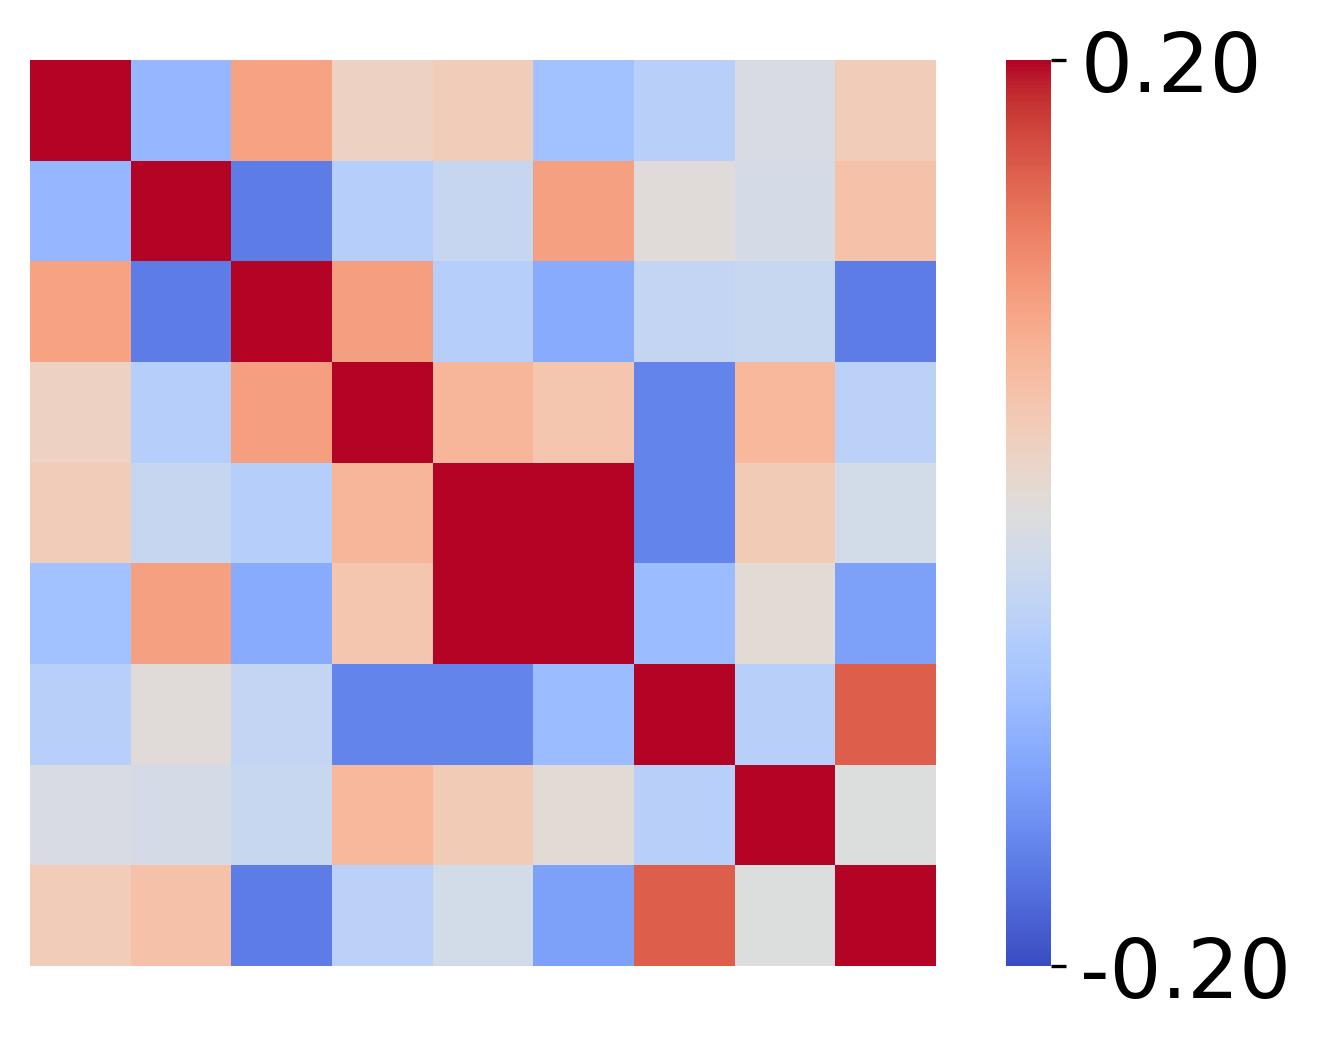

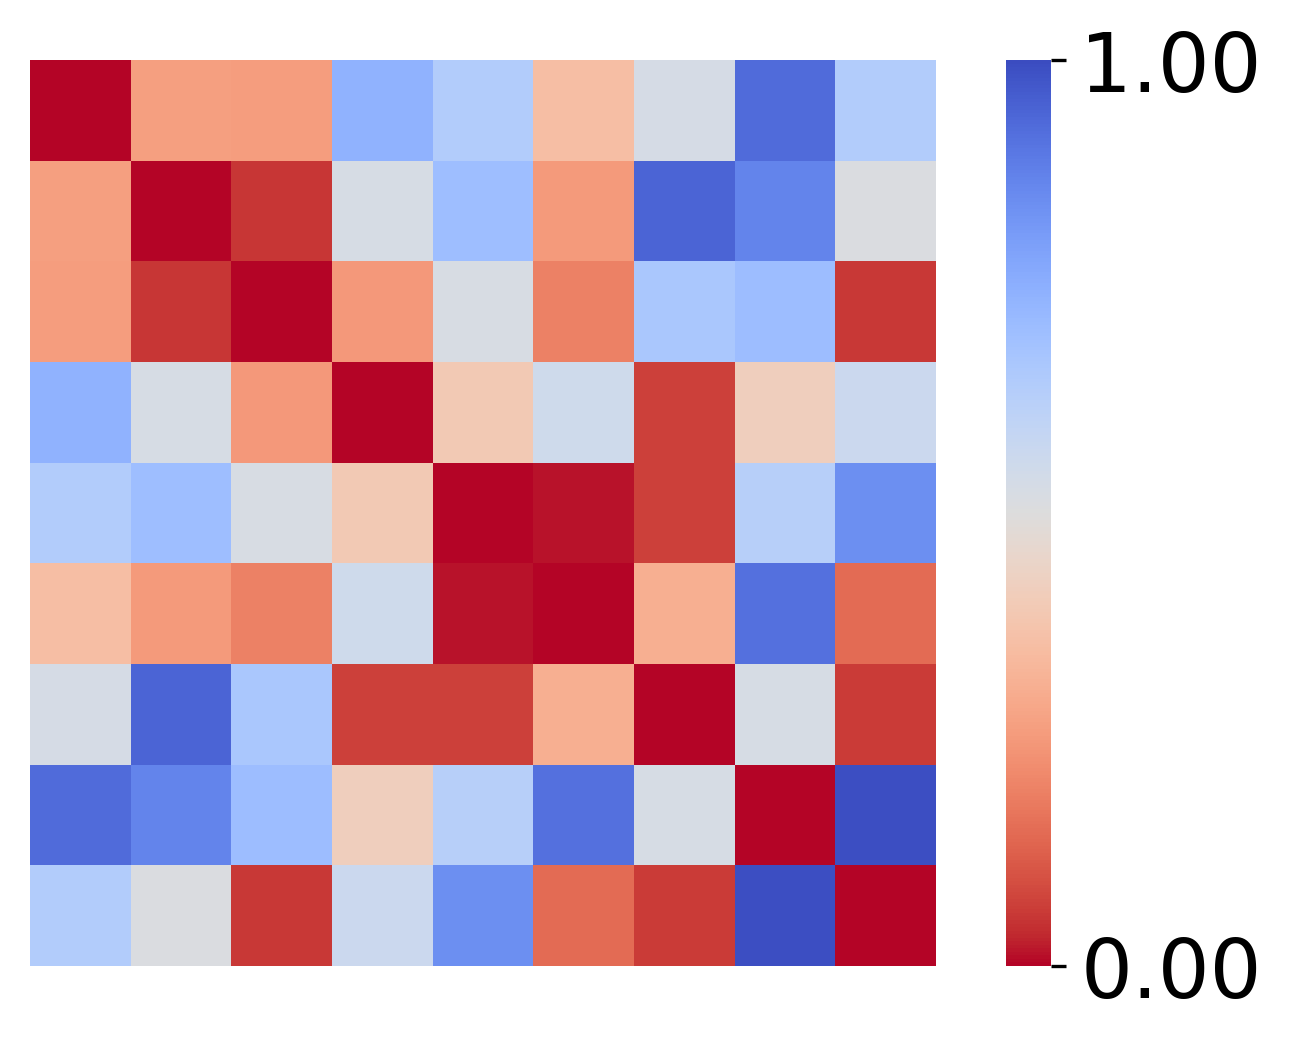

In [55]:
corr_fig, pvs_fig = compute_2D_correlation(random_estss, random_estss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=axes_off , font_size_multiplier=1.4)

In [56]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_random.svg'))

### Zeros Perturbation

In [57]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t1 as sim_timestamp

zeros_rewss, zeros_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_obss = np.flip(zeros_obss.T, axis=1)

effs = np.arange(0, 1.125, 0.125)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

zeros_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations).T

(150, 9)


/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:253: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pv = pearsonr(A[:,i], B[:,j])
/home/kai/anaconda3/envs/metacontrol-public/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4904: RuntimeWarning: divide by zero encountered in divide
  normxm = xmax * xp.linalg.vector_norm(xm/xmax, axis=axis, keepdims=True)
/home/kai/anaconda3/envs/metacontrol-public/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4905: RuntimeWarning: divide by zero encountered in divide
  normym = ymax * xp.linalg.vector_norm(ym/ymax, axis=axis, keepdims=True)


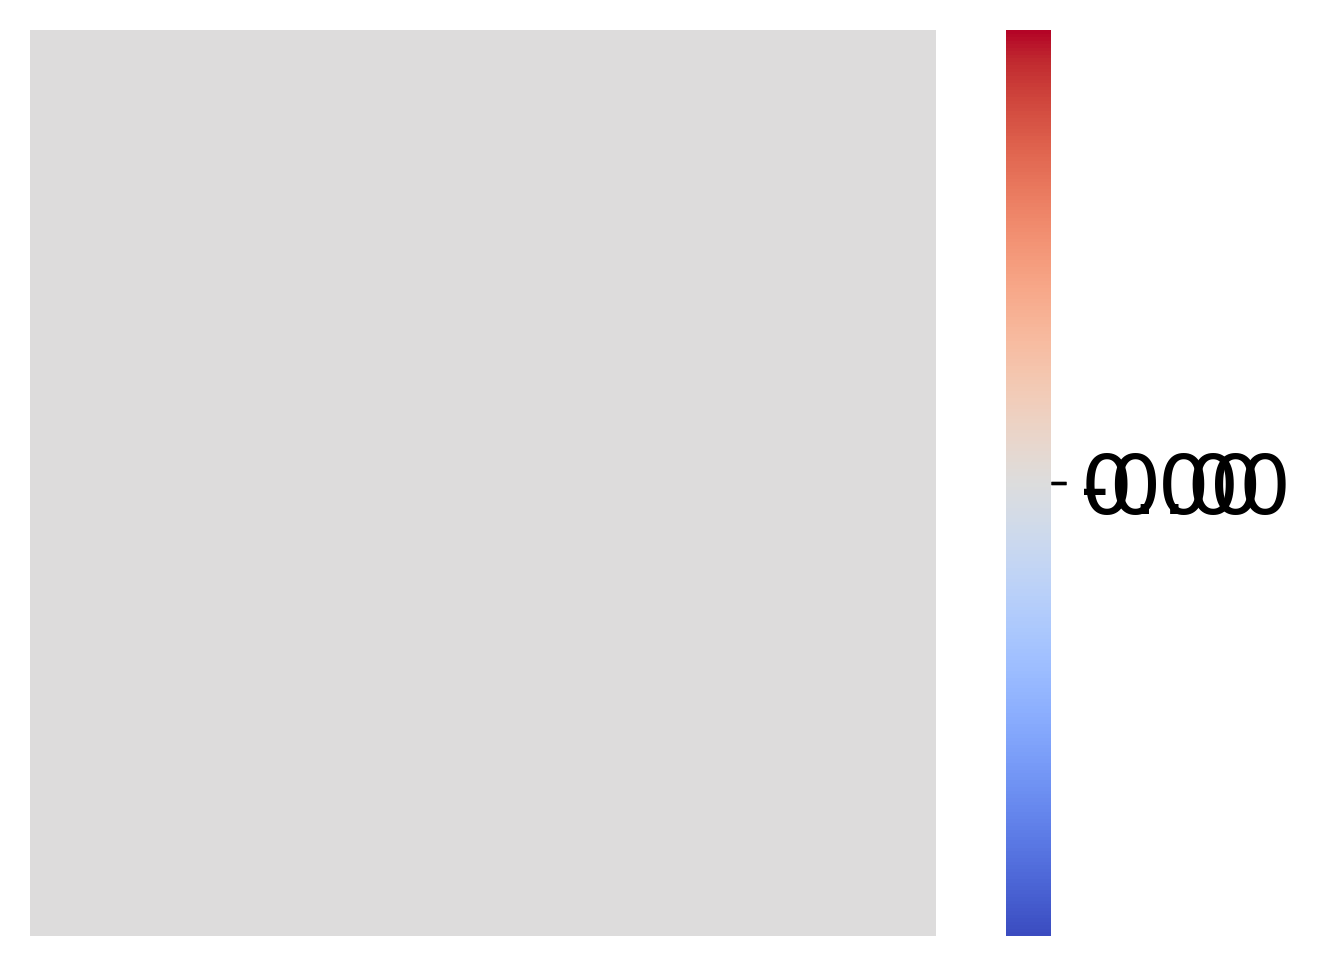

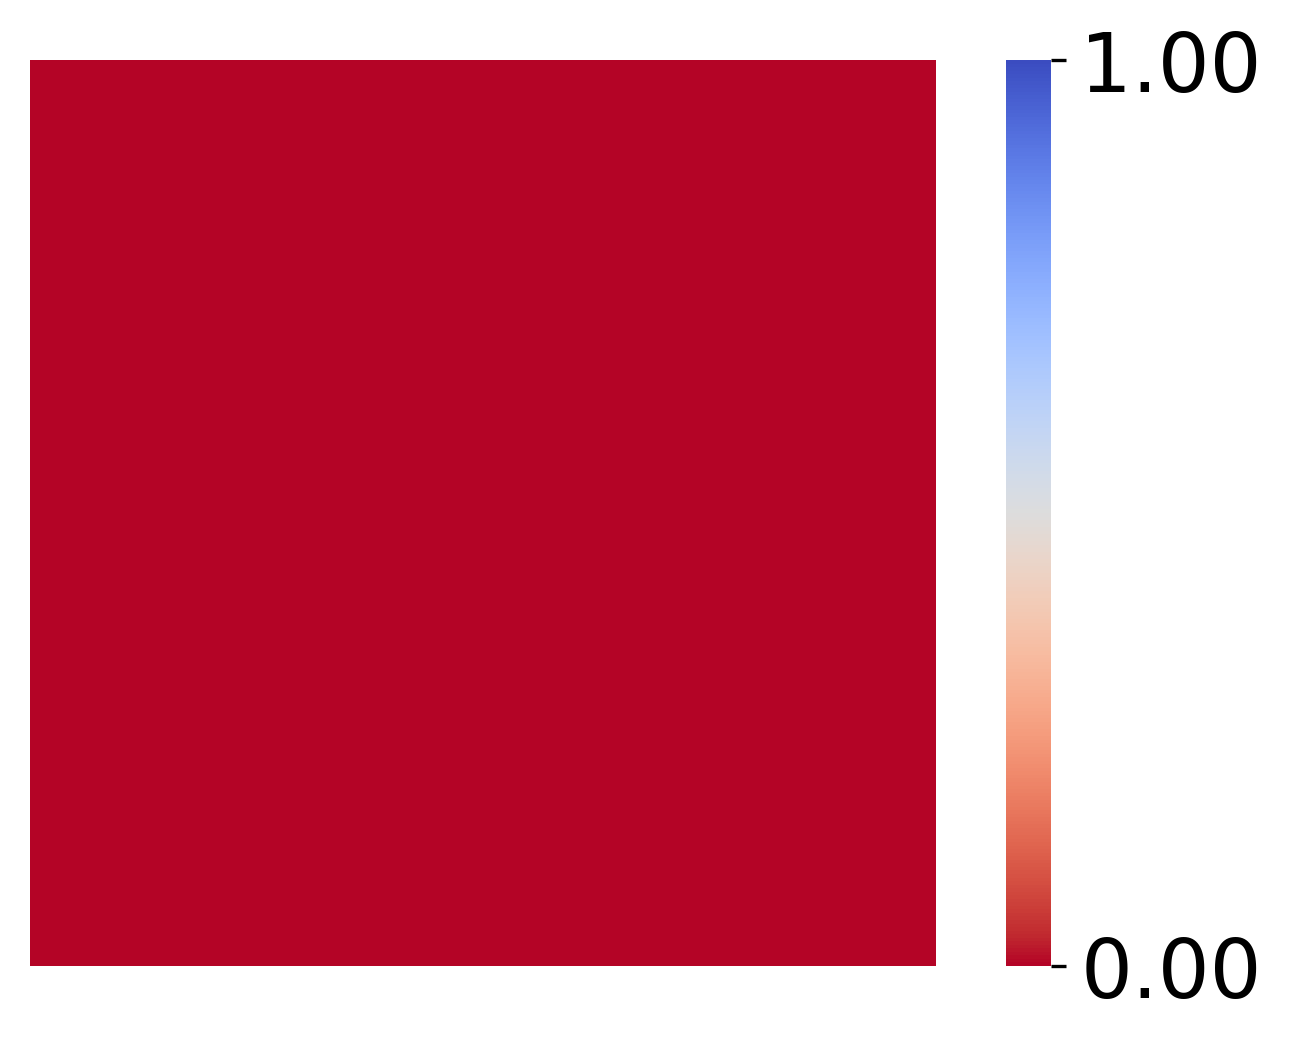

In [58]:
corr_fig, pvs_fig = compute_2D_correlation(zeros_estss, zeros_estss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=axes_off , font_size_multiplier=1.4)

In [59]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_zeros.svg'))

## Panel B.3: Task 1 Observes vs. Estimates
### Humans

In [60]:
from human_utils_project import get_clean_data

day = 'day2'
exp_date = '24-01-22-29'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

n_steps = 50

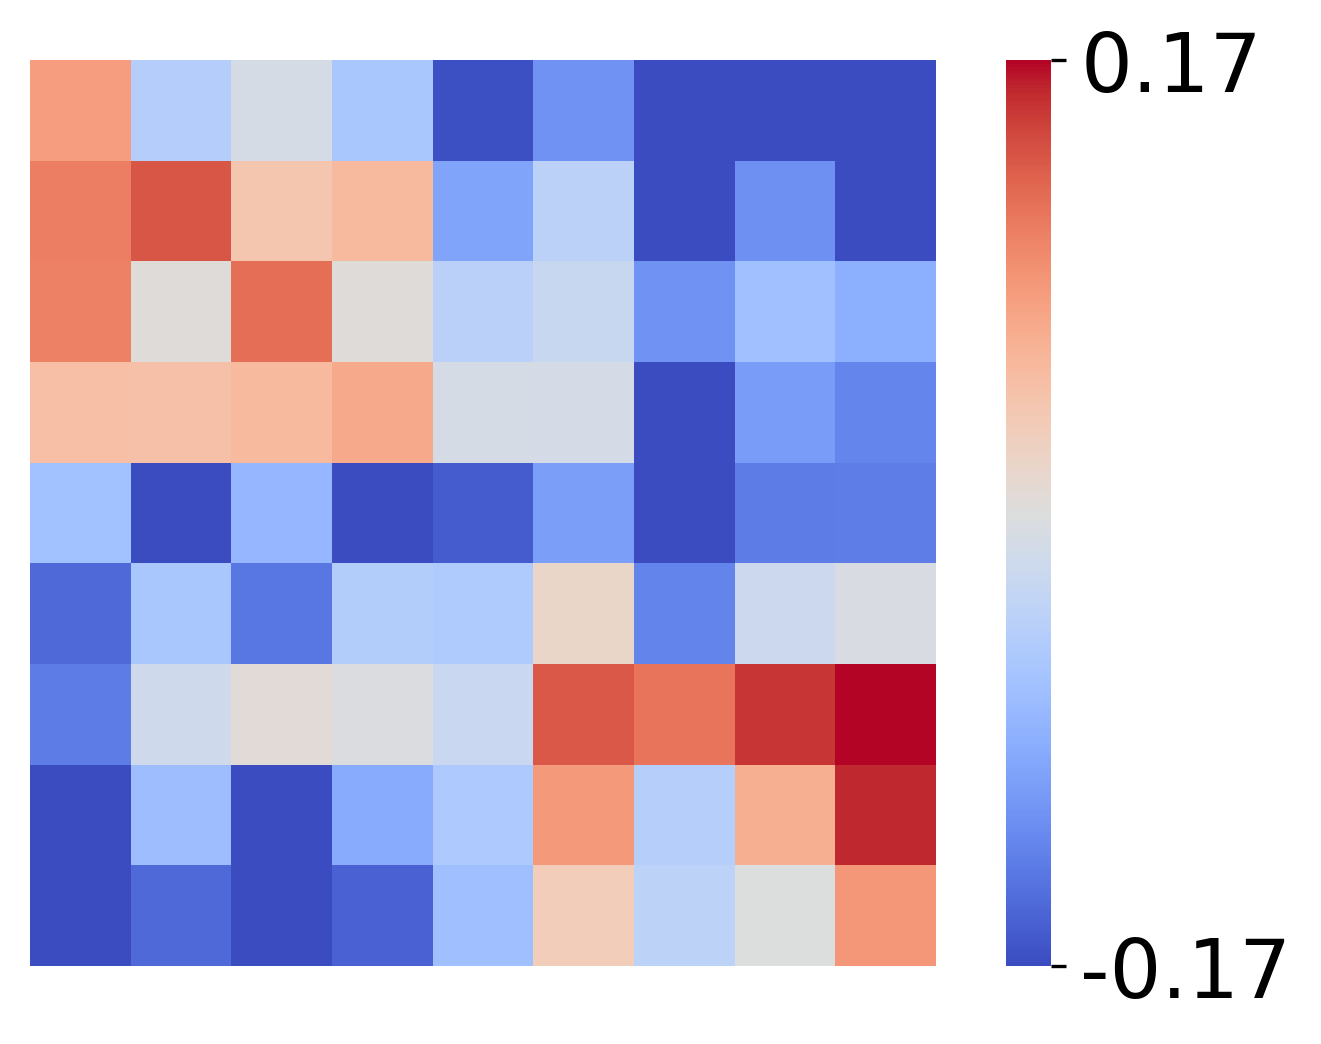

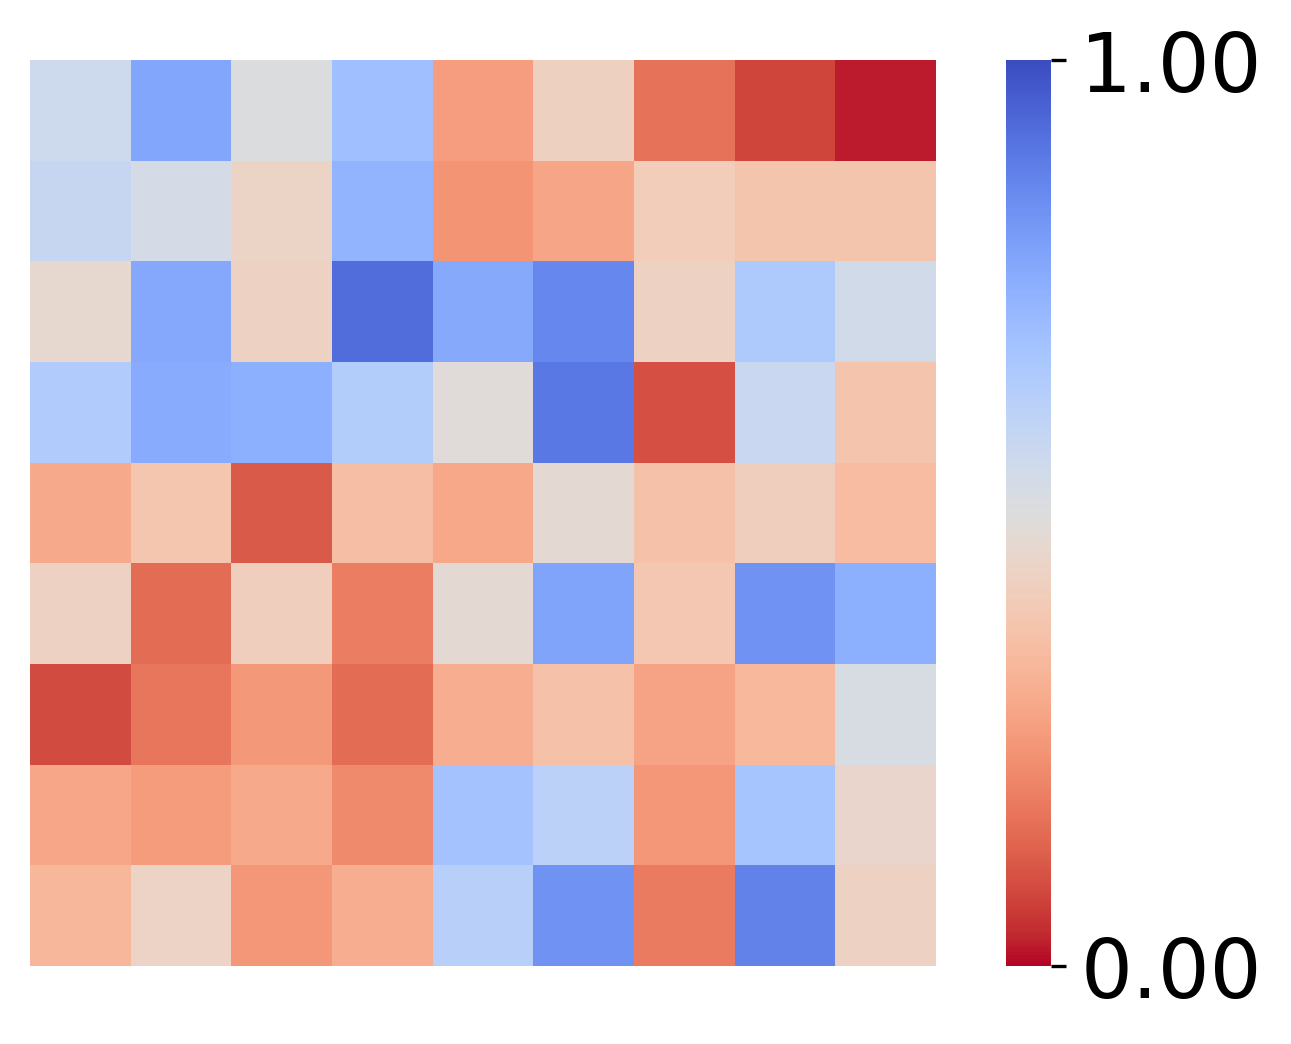

In [61]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['n_observes'],df['efficacy_estimates'], df['effs'], df['effs'], col1name = 'Observes', col2name='Estimates', annot=False, resize_colorbar = True, square=square,  font_size_multiplier=1.4, groups=df['group'], axes_off=True,)

In [62]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_observes_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_observes_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_observes_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_observes_humans.svg'))

### Trait

In [63]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t1 as sim_timestamp

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss = np.flip(sim_rewss.T, axis=1)
sim_obss = np.flip(sim_obss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

### CONSTRUCT SIM_ESTS
sim_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations).T

effs = np.arange(0, 1.125, 0.125)

(150, 9)


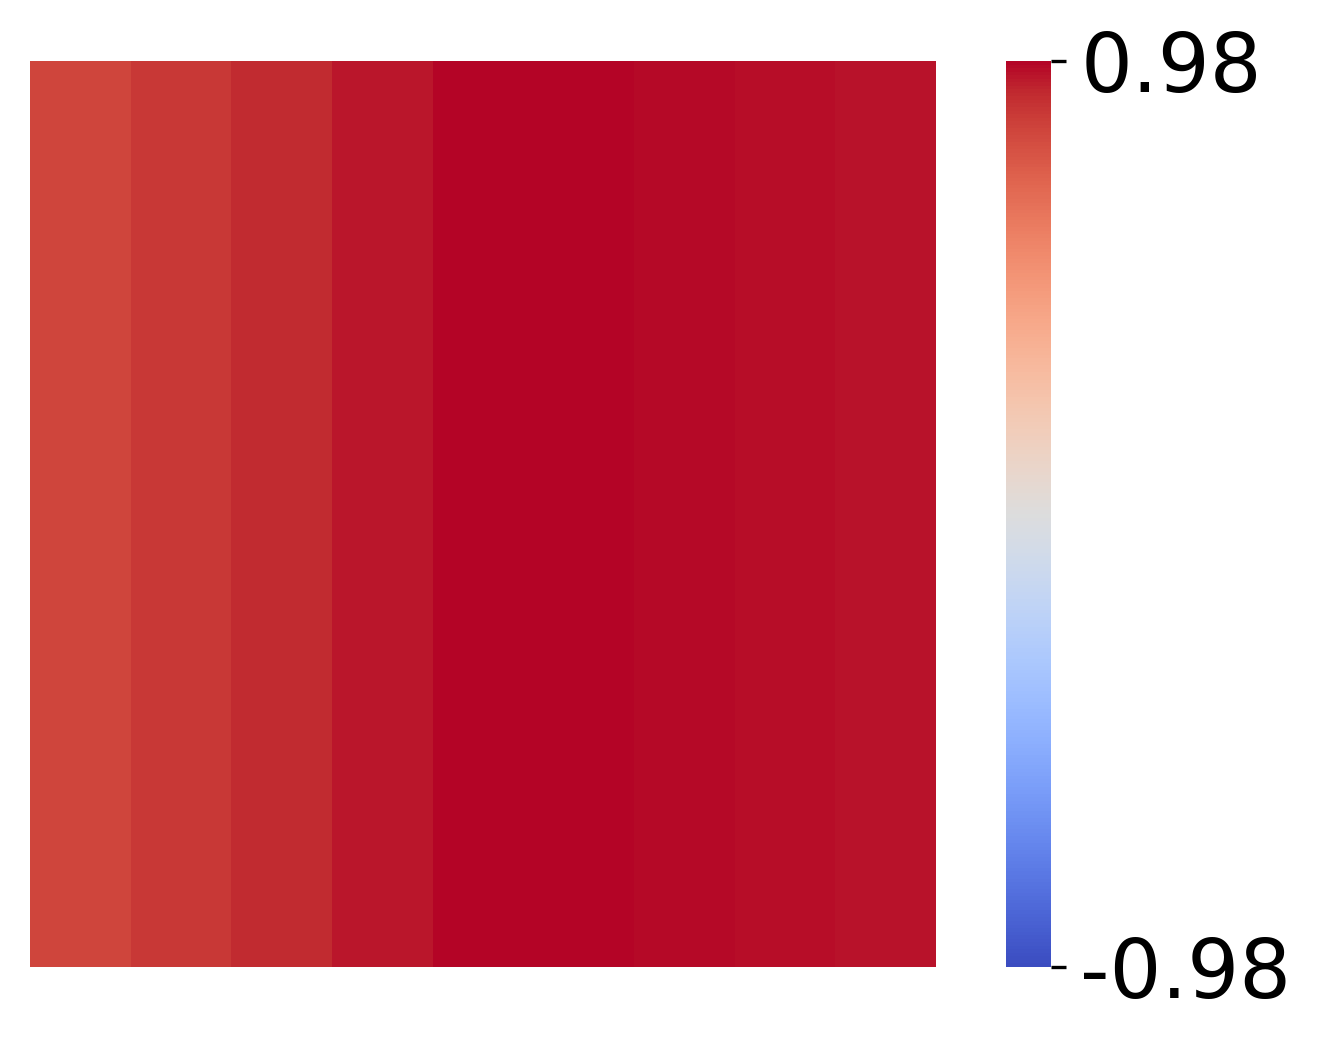

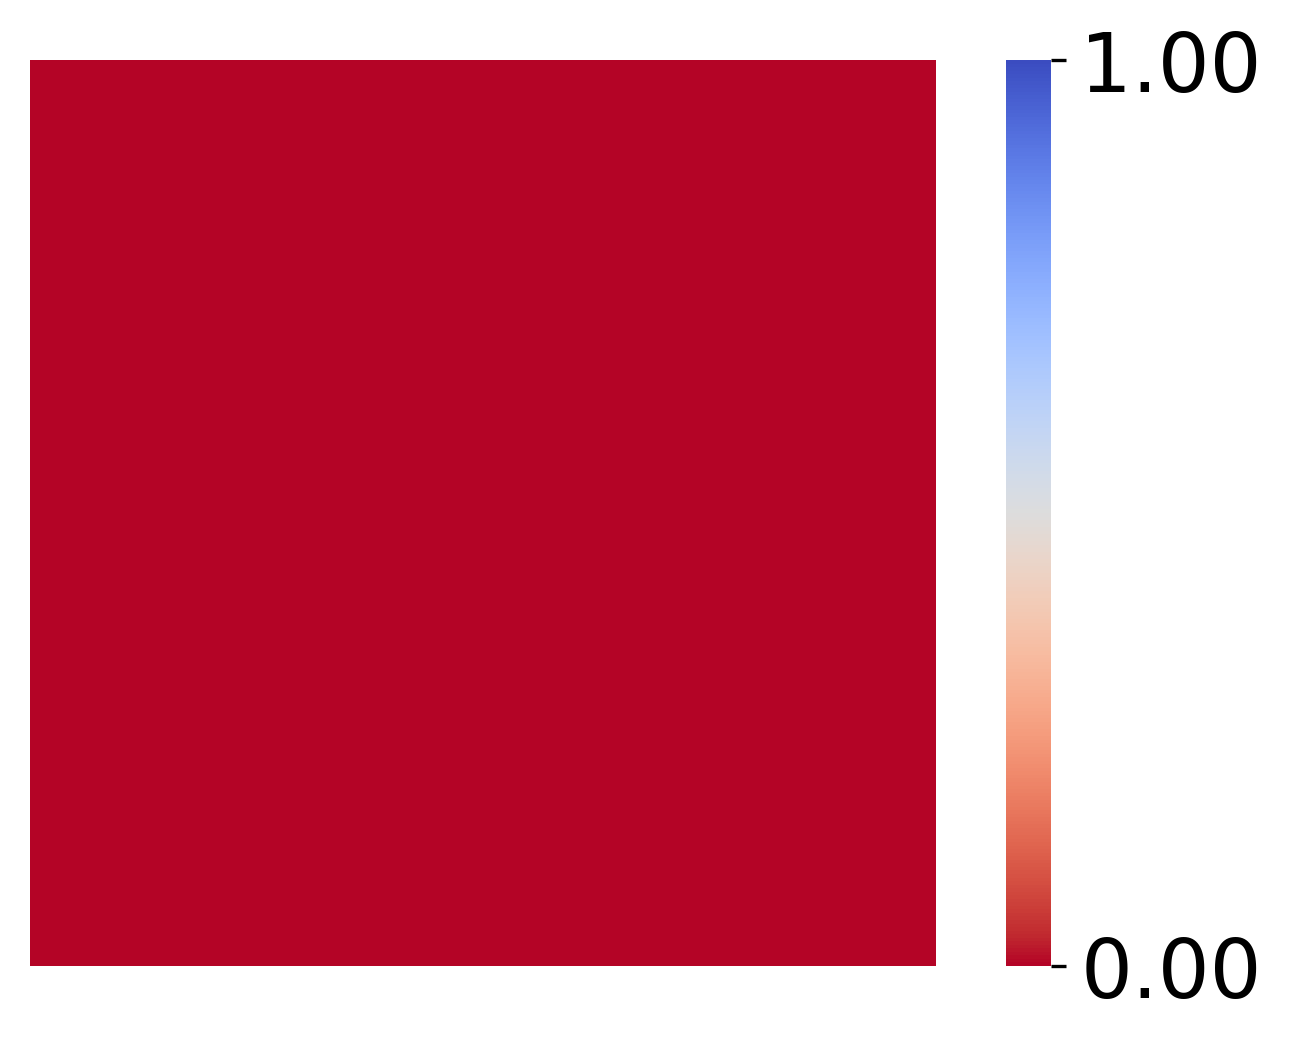

In [64]:
corr_fig, pvs_fig = compute_2D_correlation(sim_obss, sim_estss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=True, font_size_multiplier=1.4)

In [65]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_observes_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_observes_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_observes_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_observes_trait.svg'))

### Random

In [66]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t1 as sim_timestamp

random_rewss, random_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

random_rewss = random_rewss.mean(axis=0)
random_obss = random_obss.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss = np.flip(random_rewss.T, axis=1)
random_obss = np.flip(random_obss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'random', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_random_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

### CONSTRUCT SIM_ESTS
random_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)) + sim_participant_perturbations).T

(9, 9)


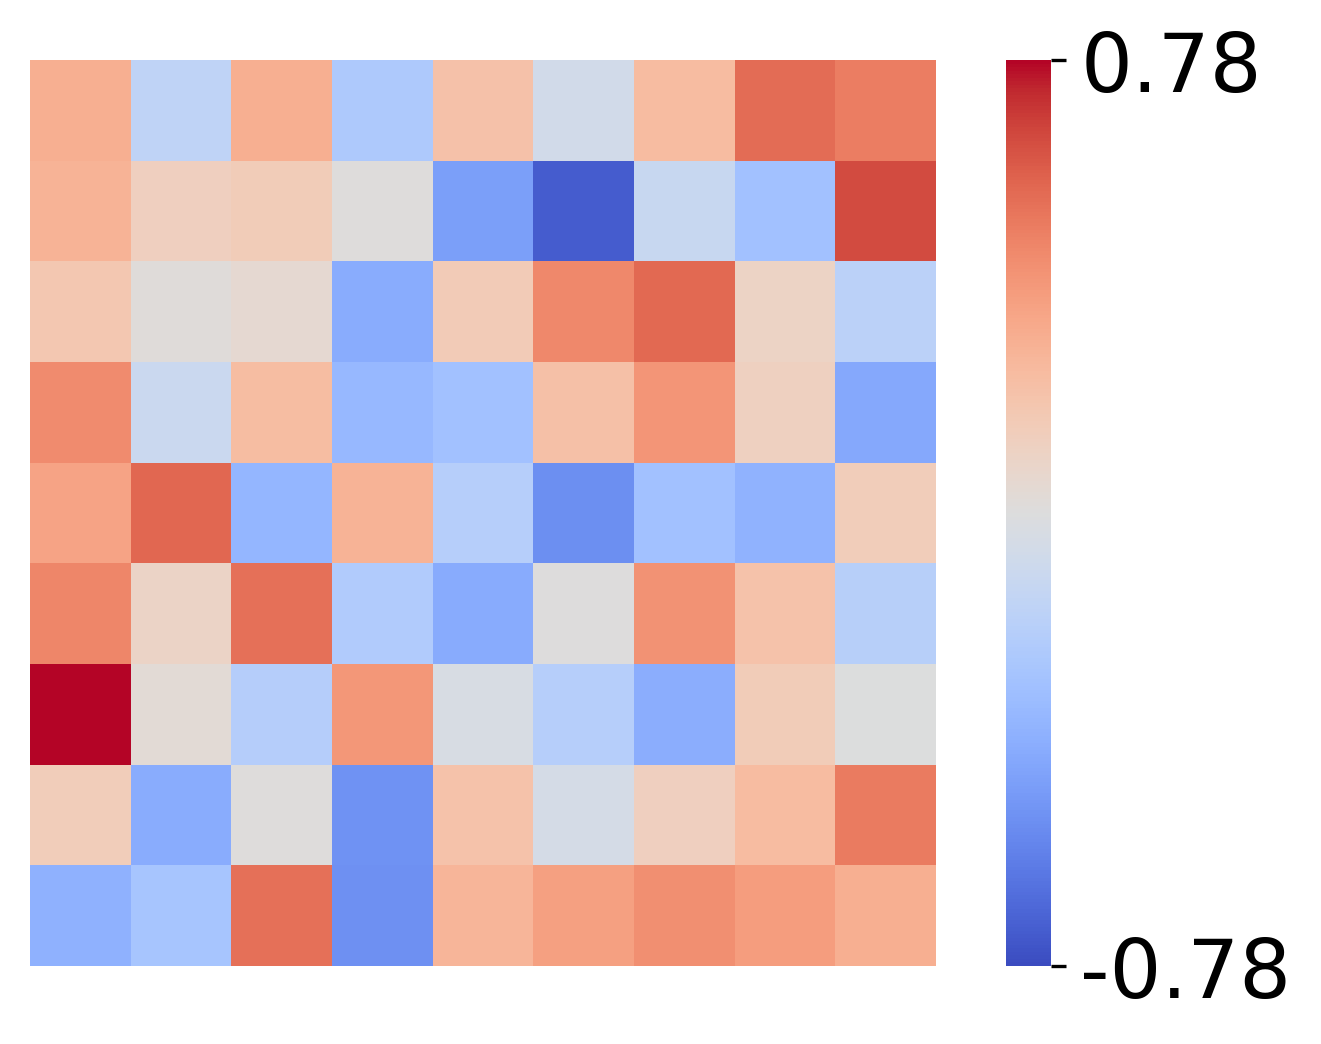

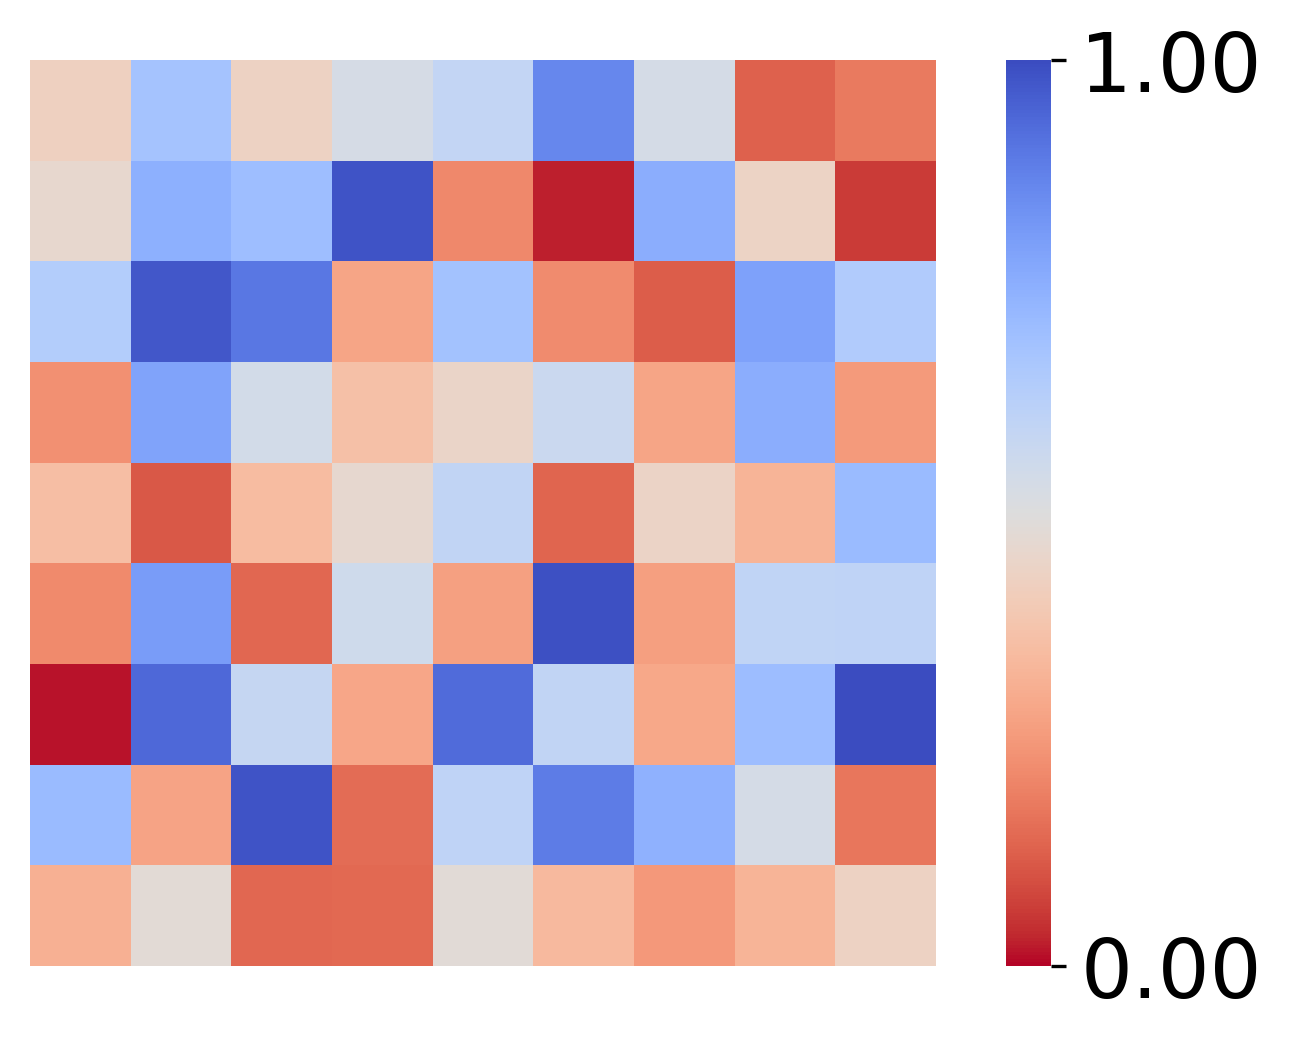

In [67]:
corr_fig, pvs_fig = compute_2D_correlation(random_obss, random_estss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=axes_off , font_size_multiplier=1.4)

In [68]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_observes_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_observes_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_observes_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_observes_random.svg'))

### Zeros

In [69]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t1 as sim_timestamp

zeros_rewss, zeros_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_obss = np.flip(zeros_obss.T, axis=1)

effs = np.arange(0, 1.125, 0.125)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

zeros_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations).T

(150, 9)


/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:253: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pv = pearsonr(A[:,i], B[:,j])
/home/kai/anaconda3/envs/metacontrol-public/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4904: RuntimeWarning: divide by zero encountered in divide
  normxm = xmax * xp.linalg.vector_norm(xm/xmax, axis=axis, keepdims=True)


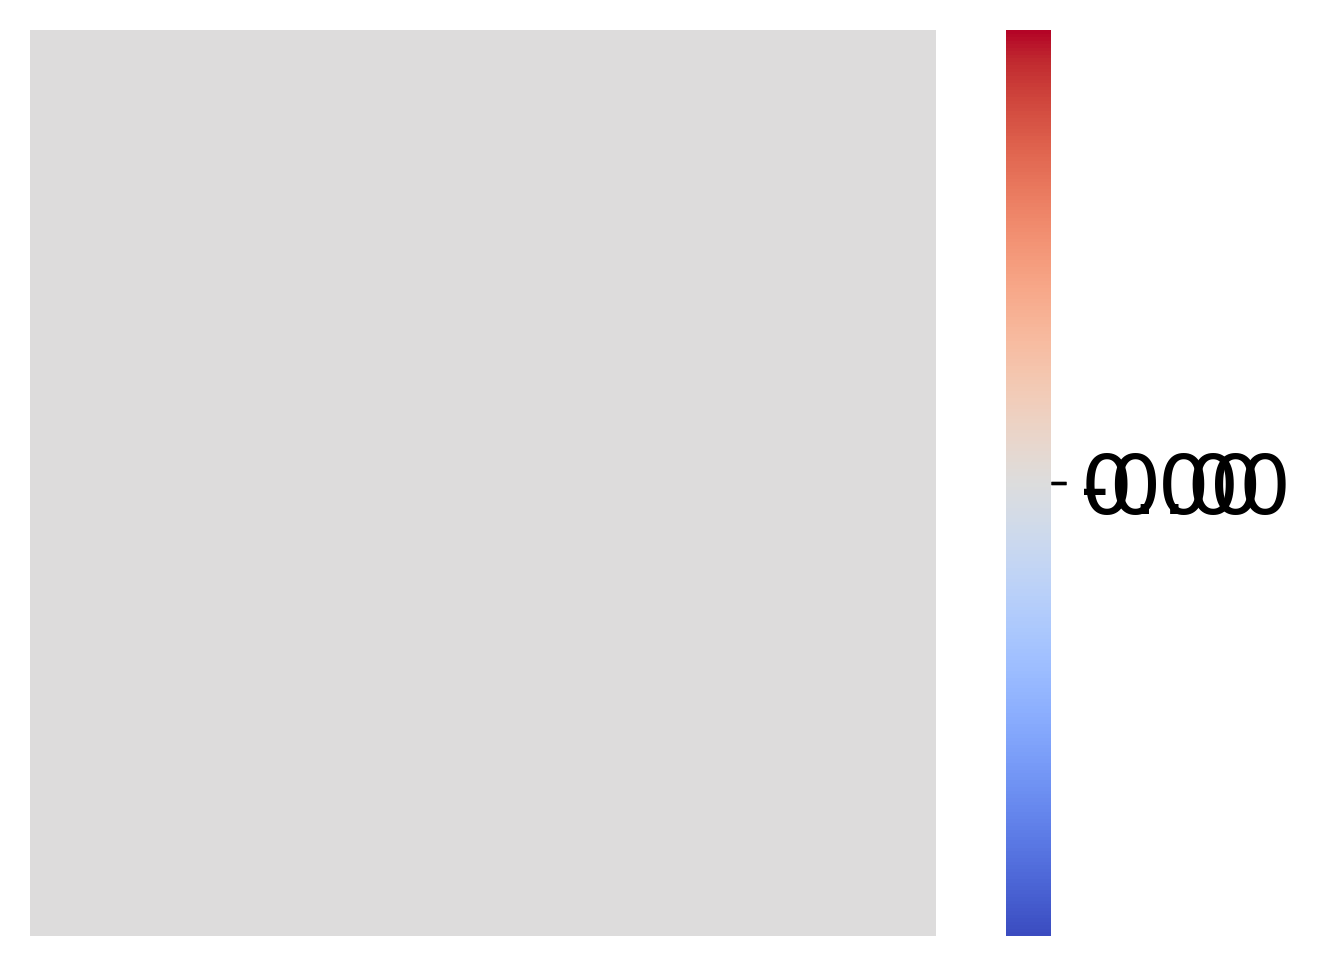

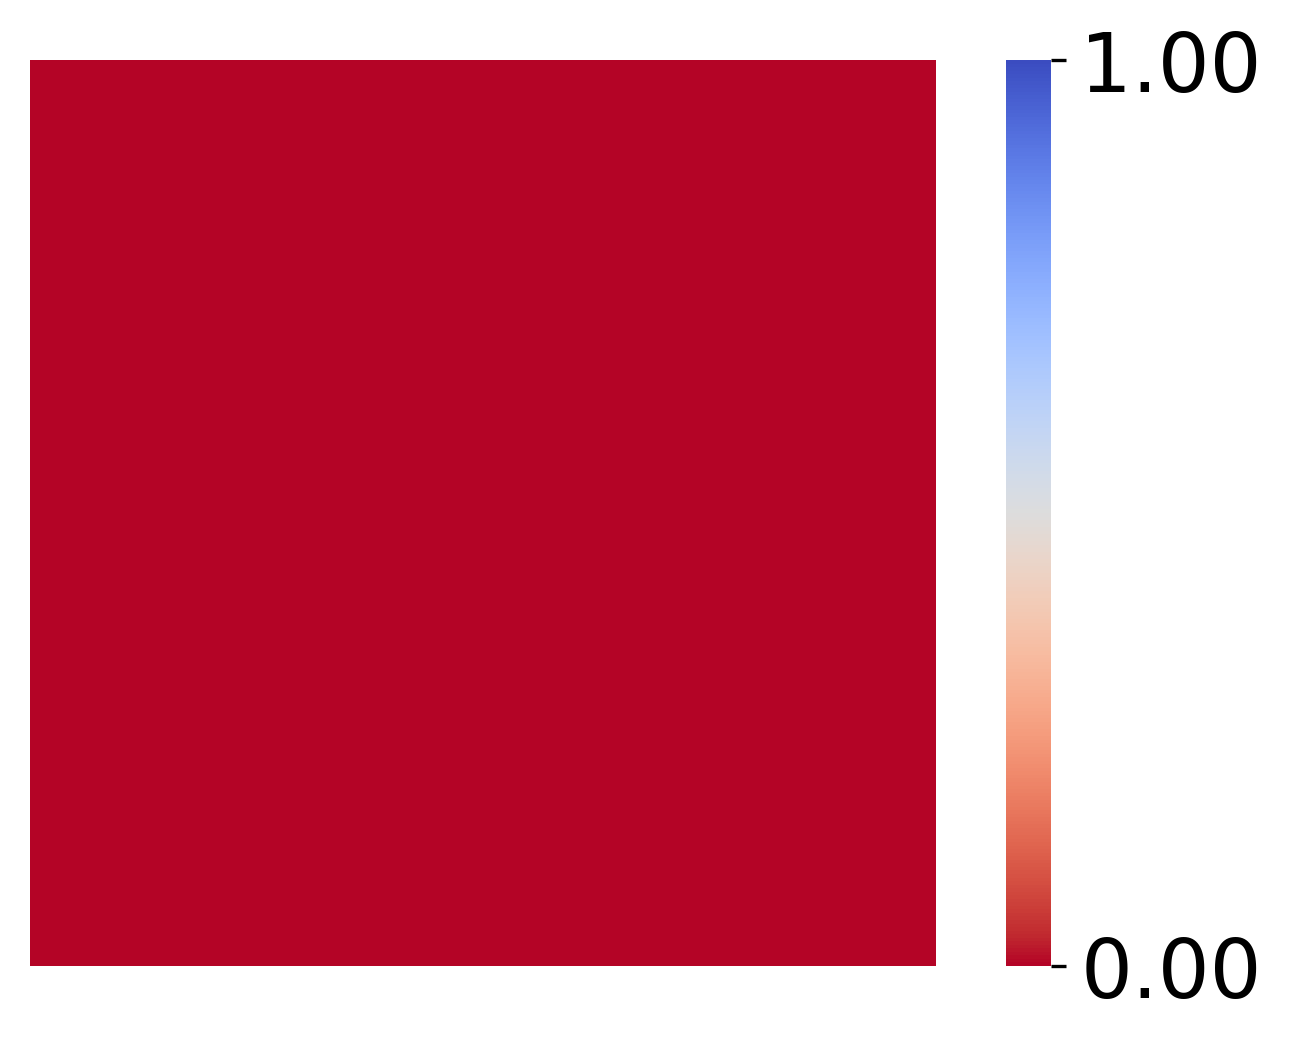

In [70]:
corr_fig, pvs_fig = compute_2D_correlation(zeros_obss, zeros_estss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=axes_off , font_size_multiplier=1.4)

In [71]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_observes_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_observes_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_observes_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_observes_zeros.svg'))

## Panel B.4: Task 1 Rewards vs. Estimates

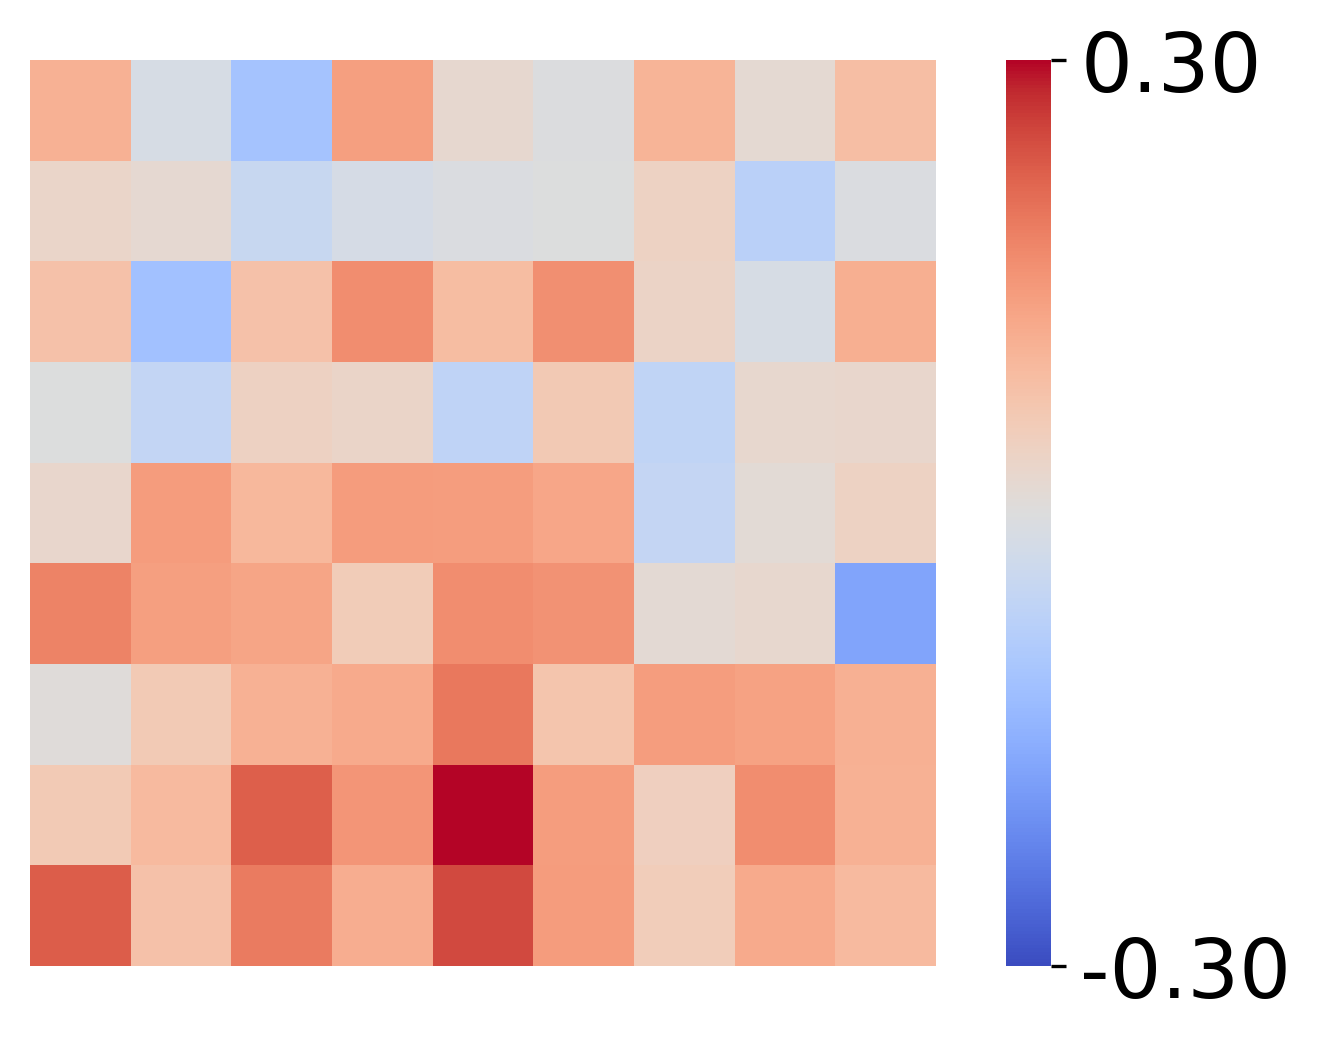

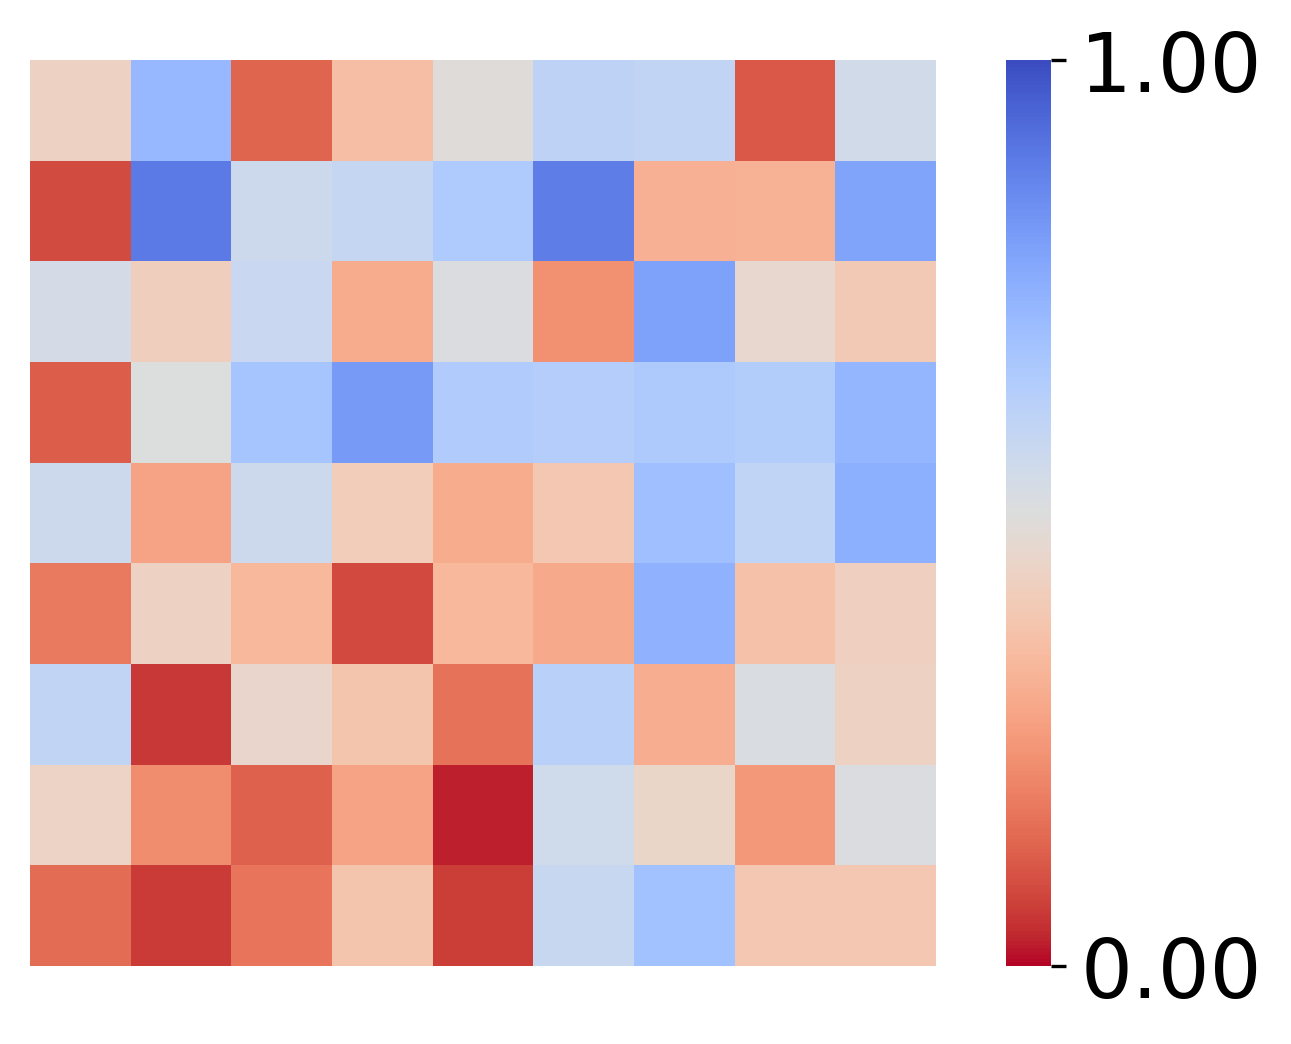

In [72]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['rewards_tallies'],df['efficacy_estimates'],  df['effs'], df['effs'], col1name = 'Estimates', col2name='Rewards', annot=False, resize_colorbar = True, square=square,  font_size_multiplier=1.4, groups=df['group'], axes_off=True,)

In [73]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_rewards_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_estimates_rewards_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_rewards_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_estimates_rewards_humans.svg'))

## Panel B.4: Task 1 Observes vs. Rewards
### Humans

In [74]:
from human_utils_project import get_clean_data

day = 'day2'
exp_date = '24-01-22-29'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

n_steps = 50

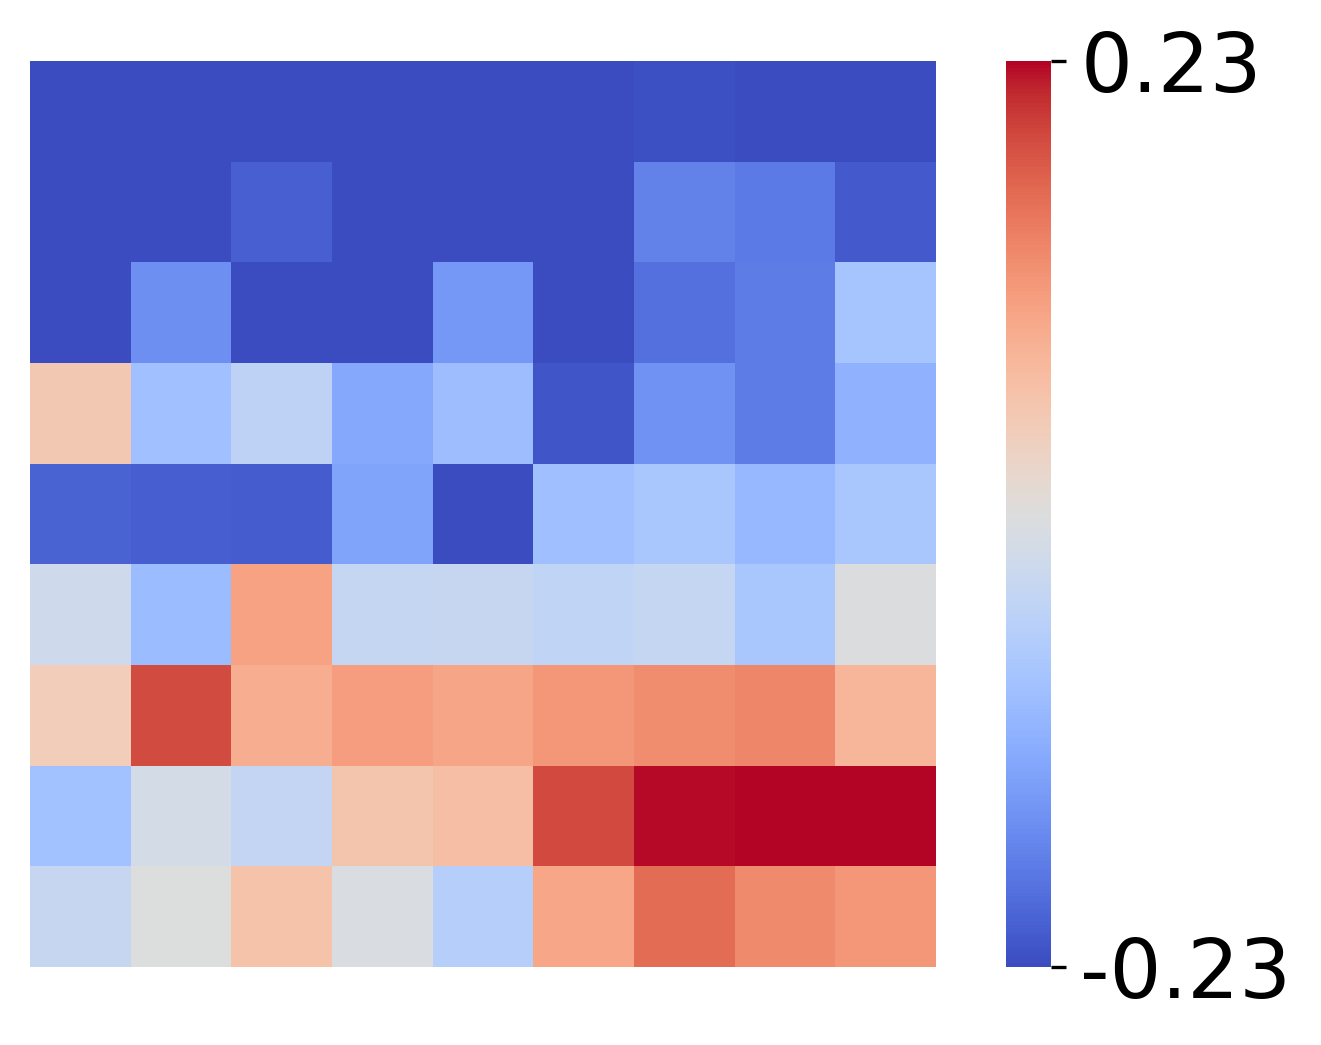

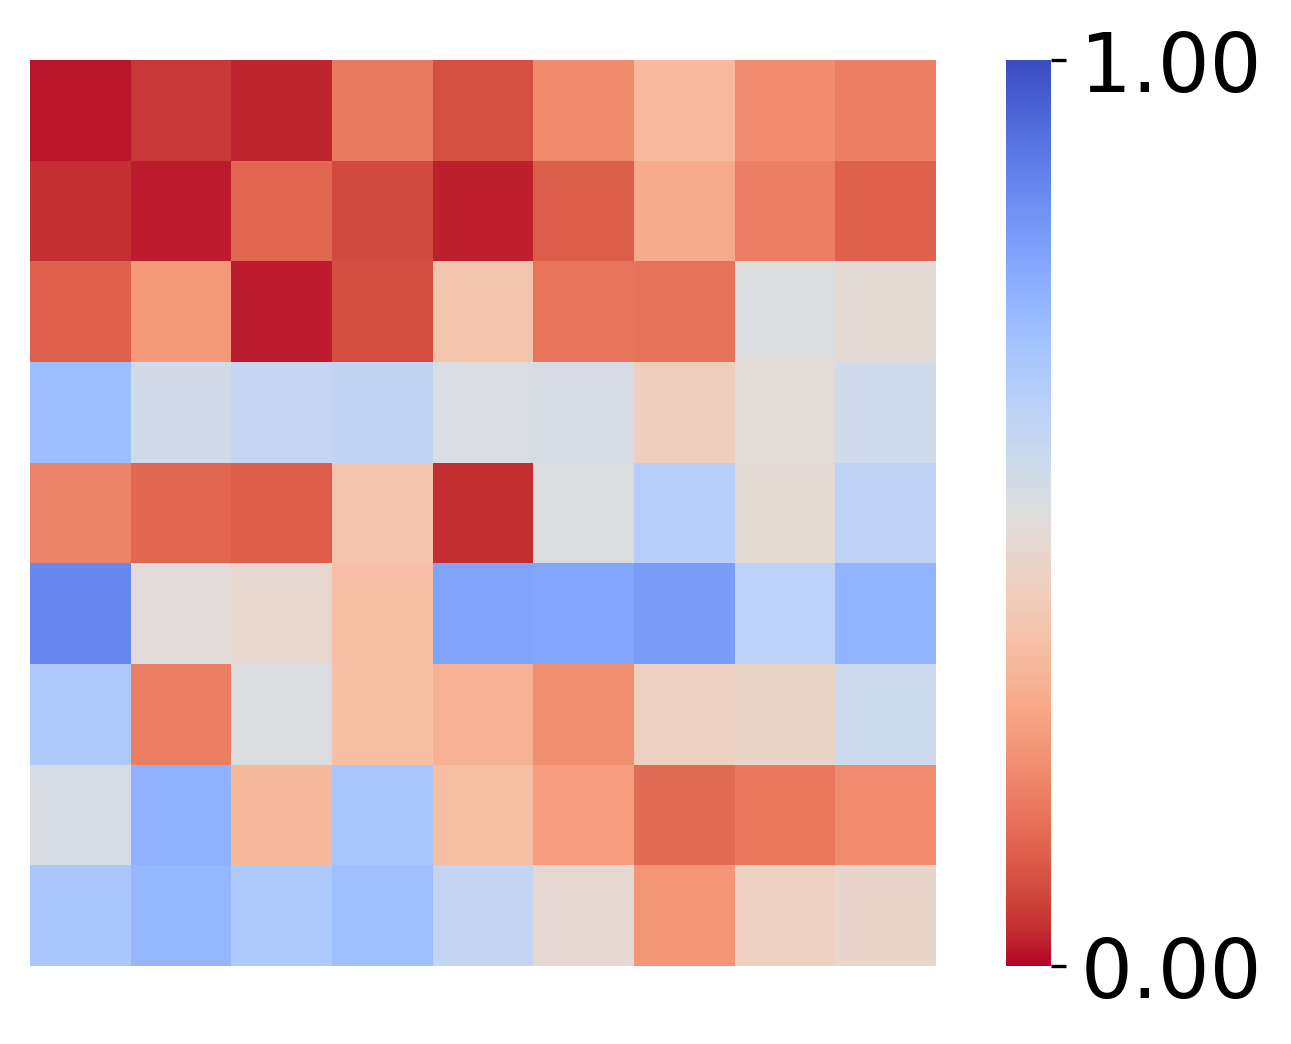

In [75]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['n_observes'], df['rewards_tallies'], df['effs'], df['effs'], col1name = 'Observes', col2name='Observes', annot=False, resize_colorbar = True, square=square, axes_off=True, font_size_multiplier=1.4, groups=df['group'])

In [76]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_rewards_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task1_observes_rewards_humans.svg'))

pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_rewards_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task1_observes_rewards_humans.svg'))

## Panel C: Task 2 Sleeps
### Humans

In [77]:
from human_utils_project import get_clean_data
day = 'day3'
exp_date = '24-01-22-29'

group = None


df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

effs = np.arange(0, 1.01, 0.125)
n_steps = 50

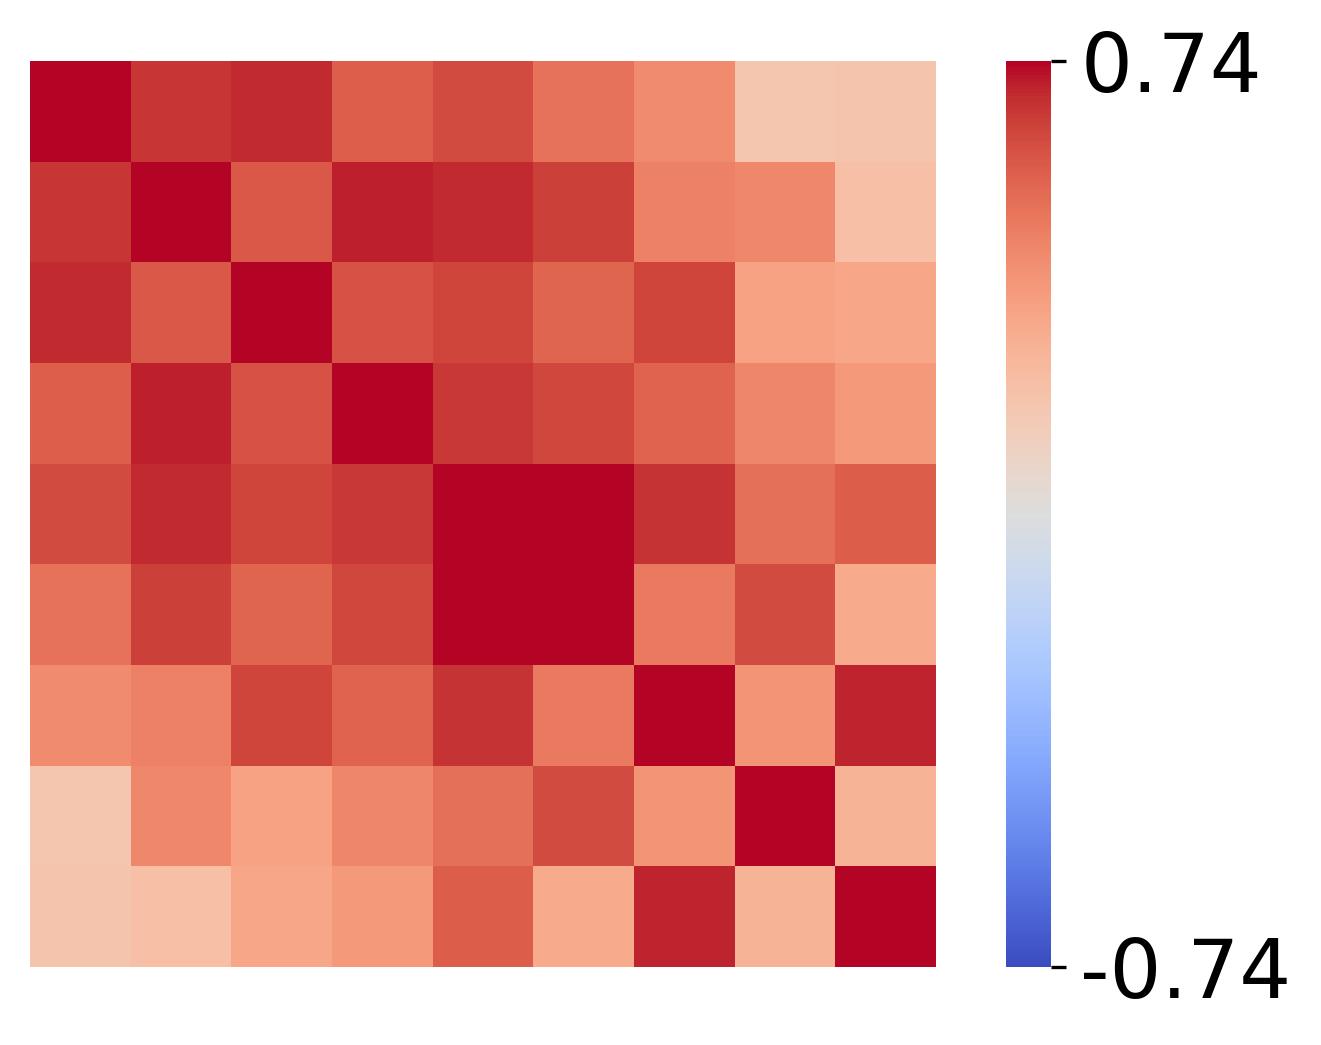

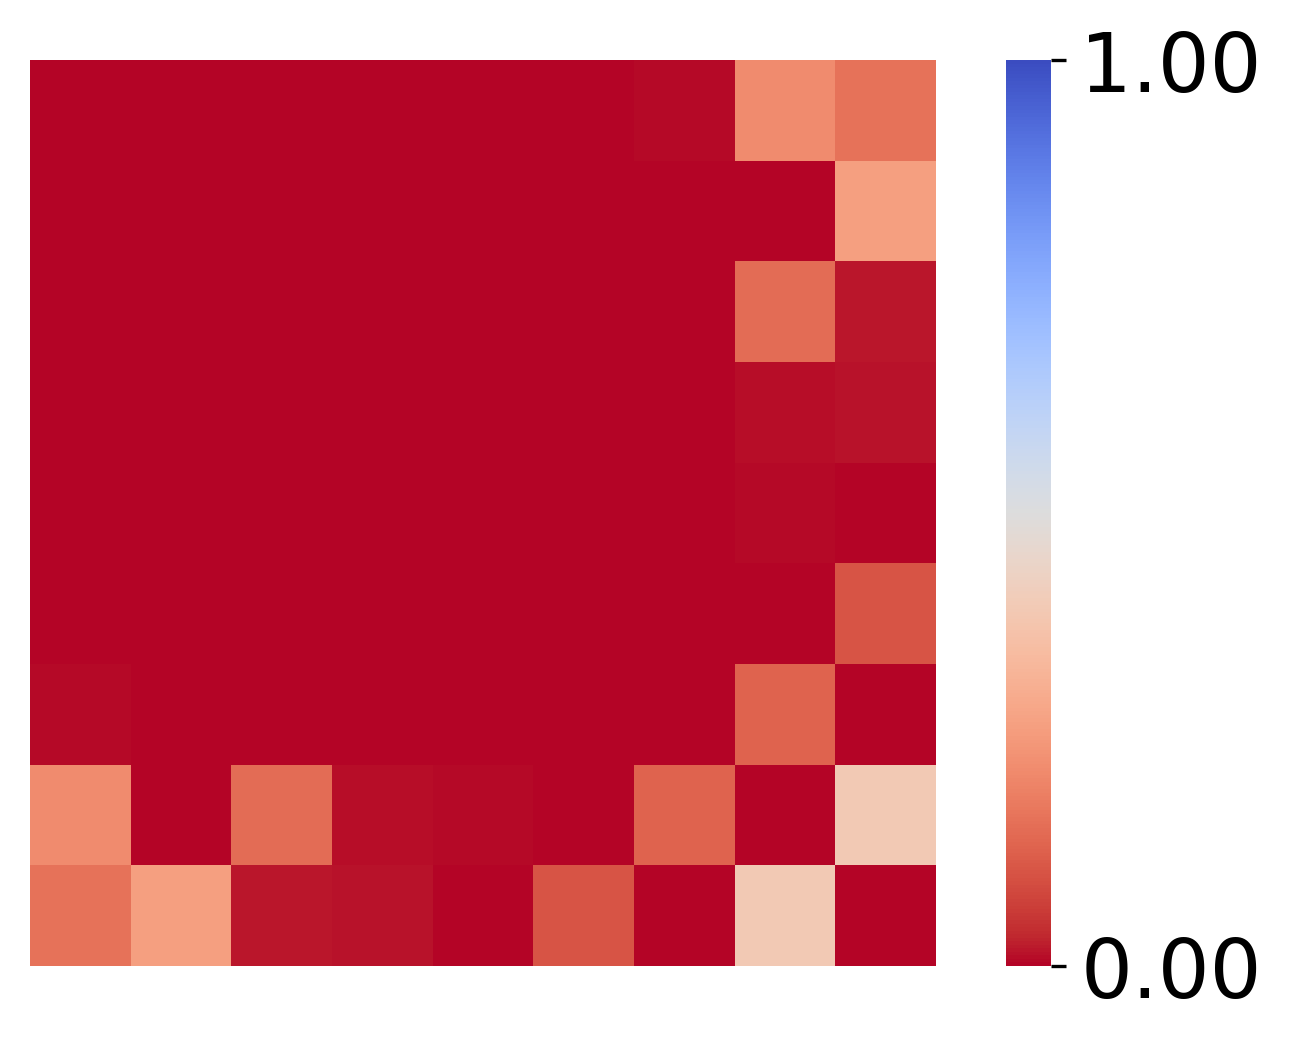

In [78]:
from human_utils_behavioral_analysis import compute_2D_correlation
corr_fig, pvs_fig = compute_2D_correlation(df['n_sleeps'], df['n_sleeps'], df['effs'], df['effs'], col1name = 'Sleeps', col2name='Sleeps', annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4, groups=df['group'])

In [79]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_humans.svg'))

### Trait-level Perturbations

In [80]:
from settings_ana import levc_human_ape_models as ape_models
from human_utils_behavioral_analysis import load_simulated_participants_across_models, compute_2D_correlation
from settings_ana import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss = np.flip(sim_rewss.T, axis=1)
sim_obss = np.flip(sim_obss.T, axis=1)
sim_sleepss = np.flip(sim_sleepss, axis=1)

(9, 9)


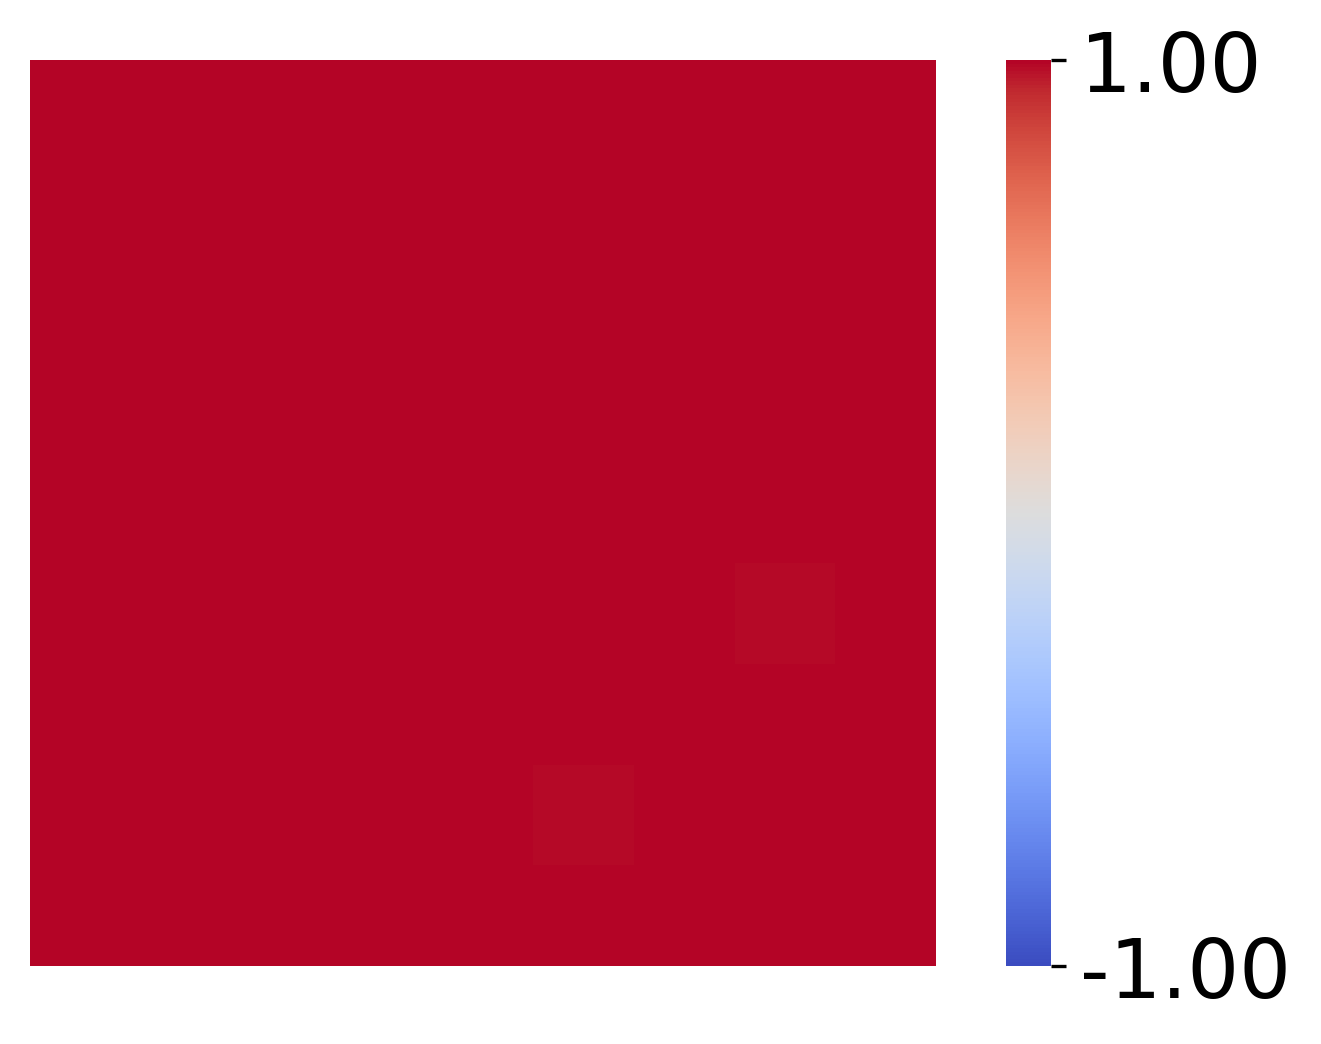

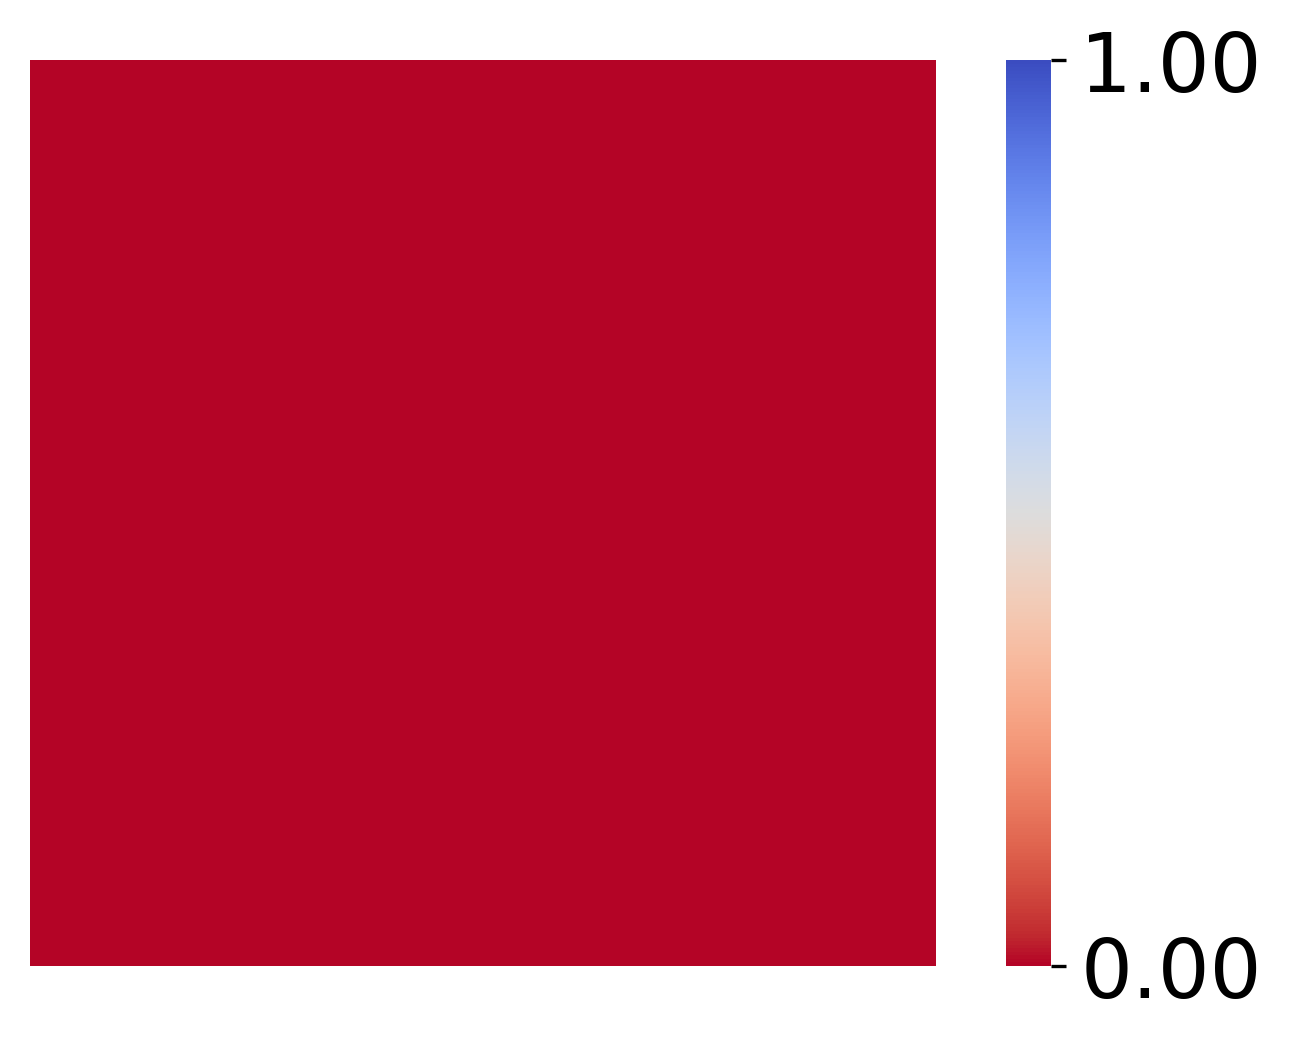

In [81]:
corr_fig, pvs_fig = compute_2D_correlation(sim_sleepss, sim_sleepss, effs, effs, "Sleeps", "Sleeps", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4,)

In [82]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_trait.svg'))

### Random Perturbations

In [83]:
from settings_ana import levc_human_ape_models as ape_models
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_ana import random_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

random_rewss, random_obss, random_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

random_rewss = random_rewss.mean(axis=0)
random_obss = random_obss.mean(axis=0)
random_sleepss = random_sleepss.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss = np.flip(random_rewss.T, axis=1)
random_obss = np.flip(random_obss.T, axis=1)
random_sleepss = np.flip(random_sleepss.T, axis=1)

(150, 9)


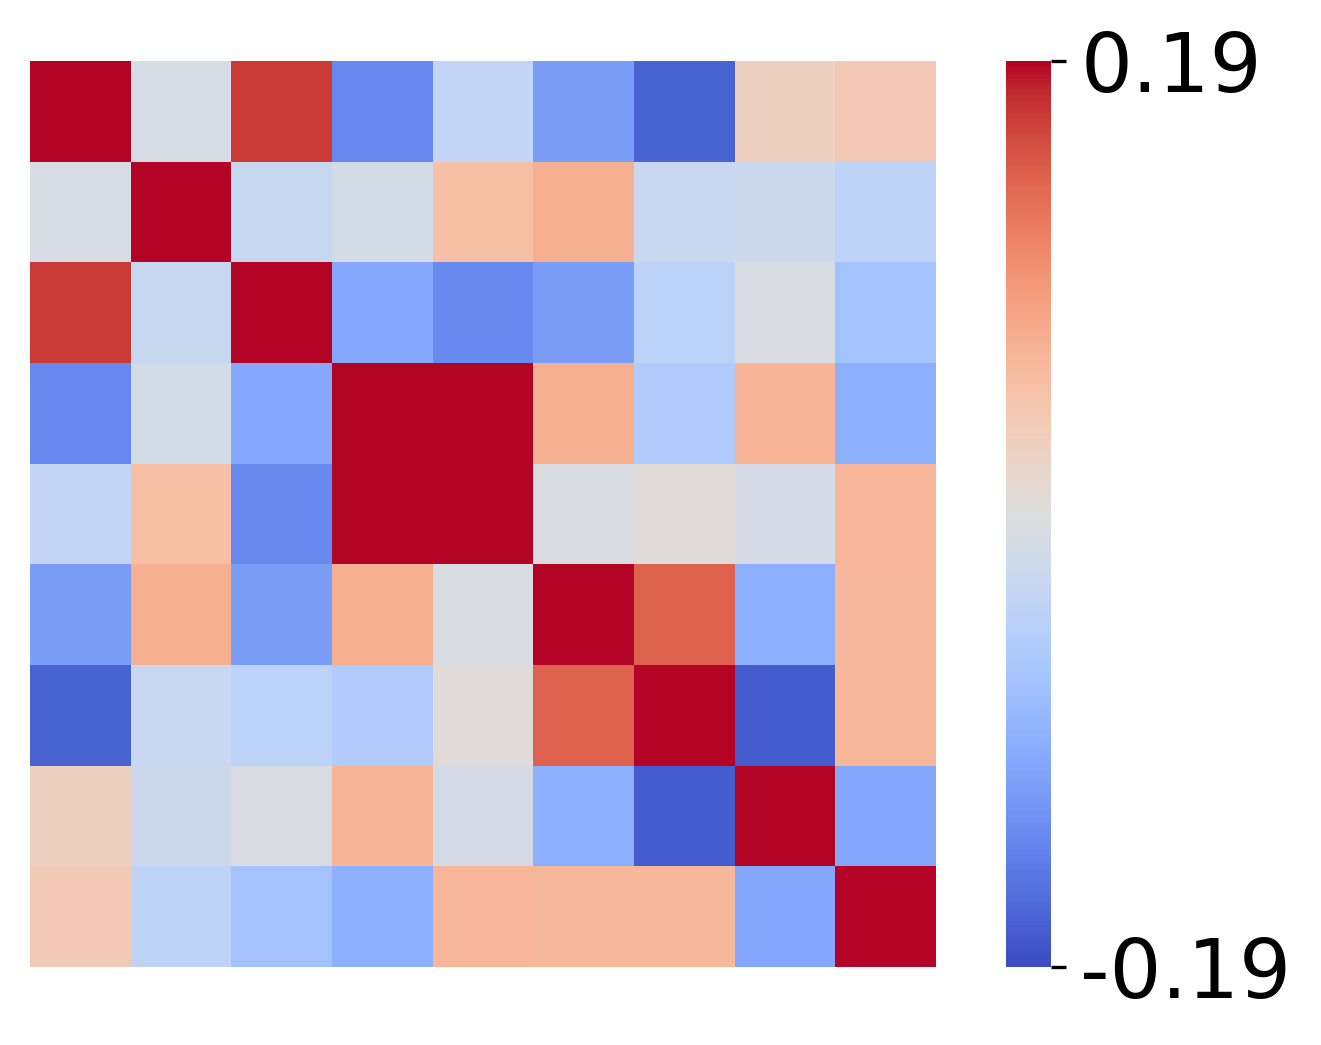

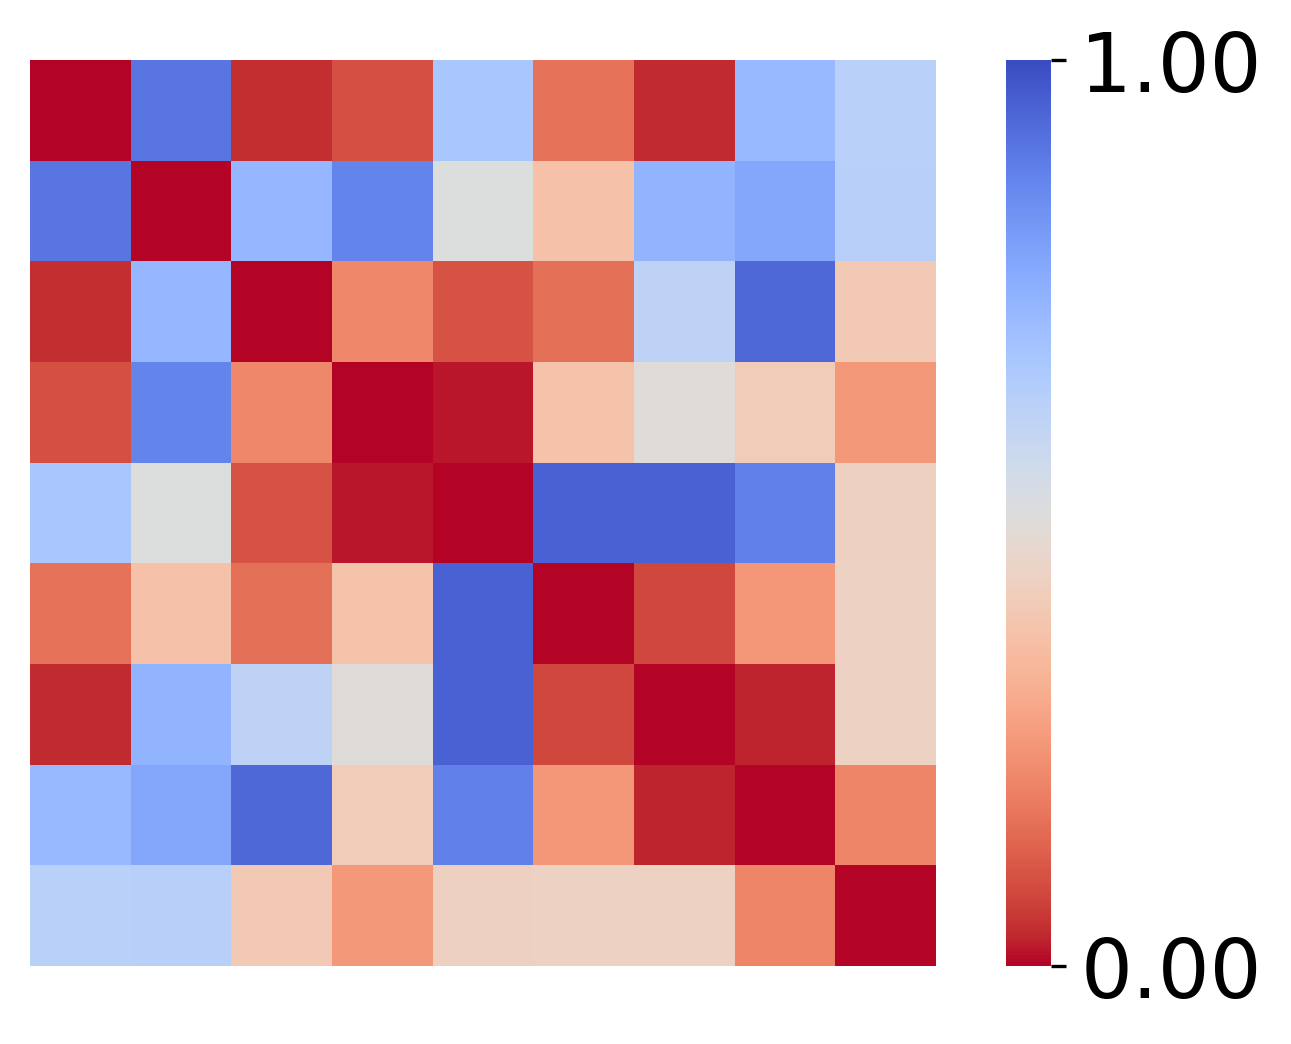

In [84]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(random_sleepss, random_sleepss, effs, effs, "Sleeps", "Sleeps", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [85]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_random.svg'))

### Zeros Perturbation

In [86]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import levc_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t2 as sim_timestamp

zeros_rewss, zeros_obss, zeros_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)
zeros_sleepss = zeros_sleepss.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_obss = np.flip(zeros_obss.T, axis=1)
zeros_sleepss = np.flip(zeros_sleepss.T, axis=1)

effs = np.arange(0, 1.125, 0.125)

(150, 9)


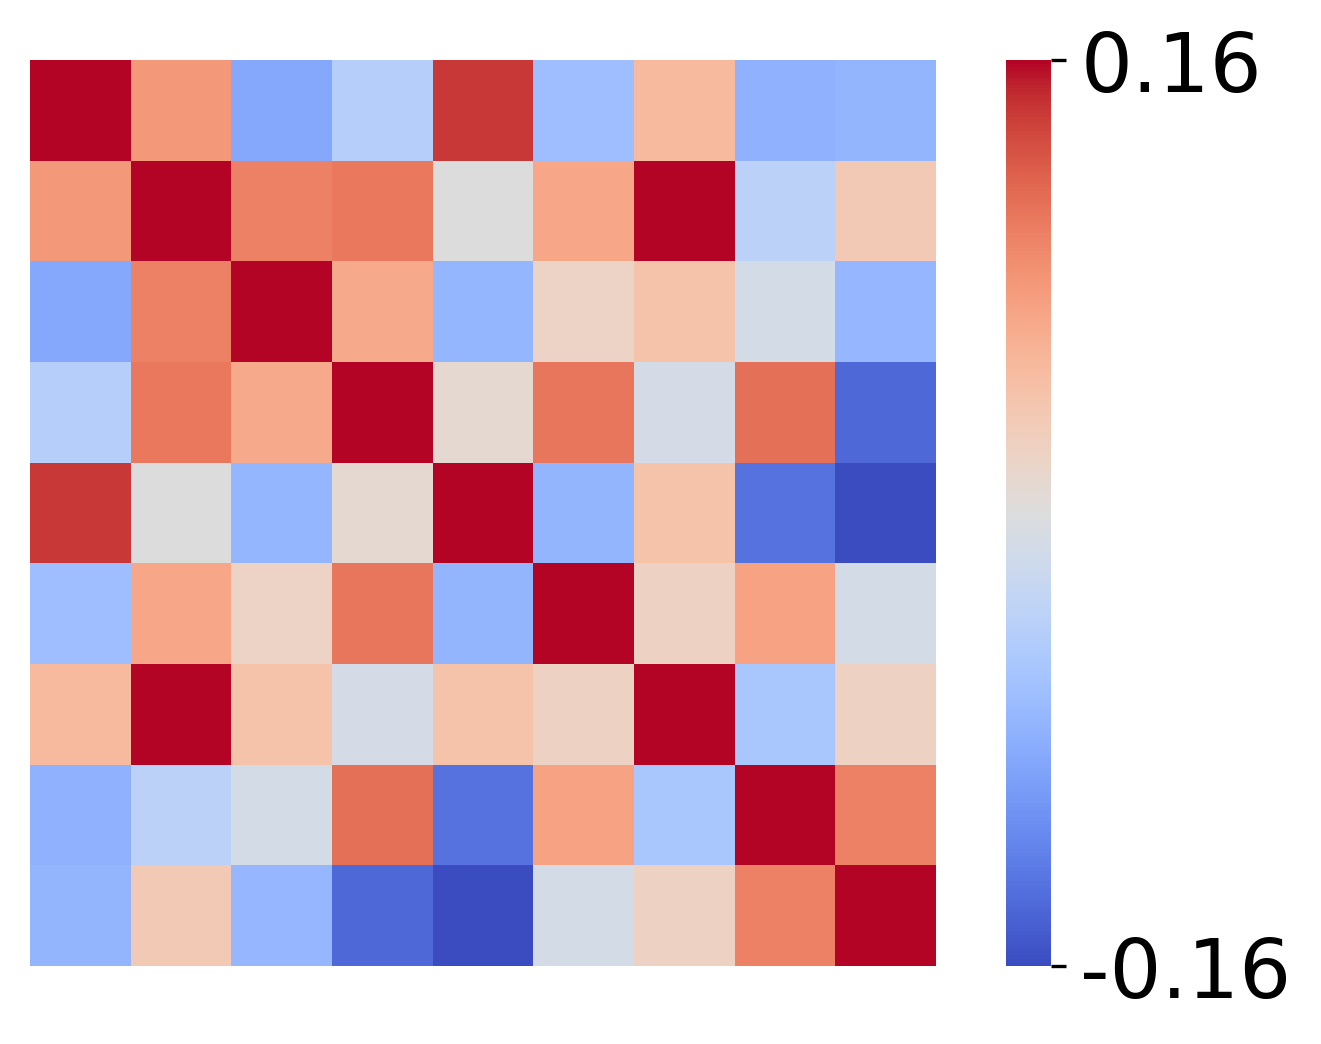

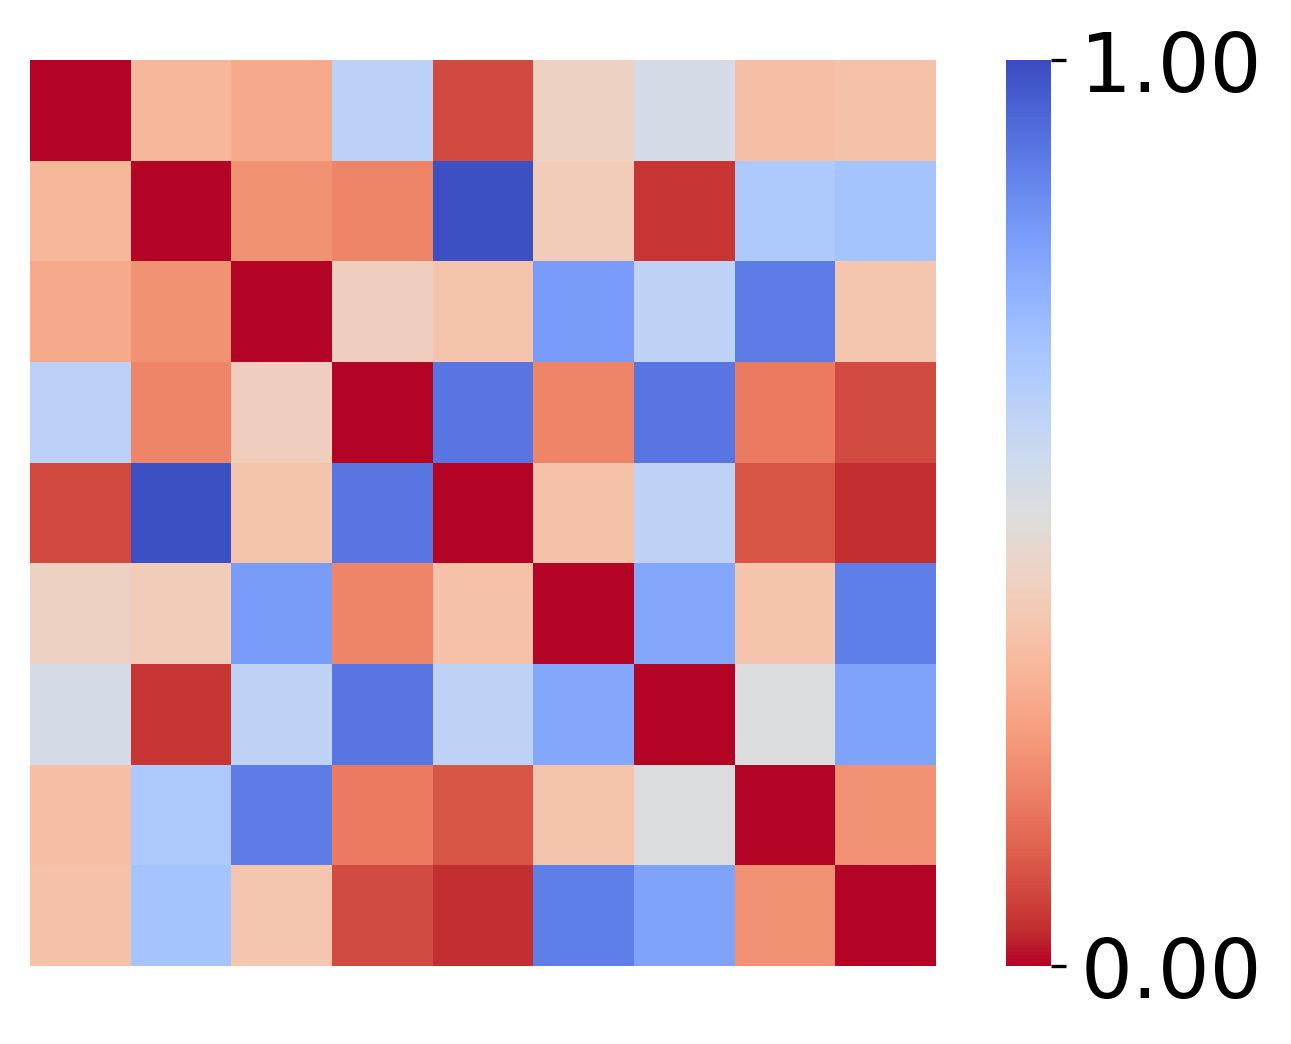

In [87]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(zeros_sleepss, zeros_sleepss, effs, effs, "Sleeps", "Sleeps", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [88]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_zeros.svg'))

### Stats

In [89]:
from human_utils_behavioral_analysis import compute_2D_correlation_matrices

data_obs_corr_g1, data_obs_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_obs_corr_g2, data_obs_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_rews_corr_g1, data_rews_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_rews_corr_g2, data_rews_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_sleeps_corr_g1, data_sleeps_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['n_sleeps'].values), np.stack(df[~df['group']]['n_sleeps'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_sleeps_corr_g2, data_sleeps_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['n_sleeps'].values), np.stack(df[df['group']]['n_sleeps'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_obs_corr = (~df['group']).sum() / len(df) * data_obs_corr_g1 + (df['group']).sum() / len(df) * data_obs_corr_g2
data_obs_pvs = (~df['group']).sum() / len(df) * data_obs_pvs_g1 + (df['group']).sum() / len(df) * data_obs_pvs_g2

data_rews_corr = (~df['group']).sum() / len(df) * data_rews_corr_g1 + (df['group']).sum() / len(df) * data_rews_corr_g2
data_rews_pvs = (~df['group']).sum() / len(df) * data_rews_pvs_g1 + (df['group']).sum() / len(df) * data_rews_pvs_g2

data_sleeps_corr = (~df['group']).sum() / len(df) * data_sleeps_corr_g1 + (df['group']).sum() / len(df) * data_sleeps_corr_g2
data_sleeps_pvs = (~df['group']).sum() / len(df) * data_sleeps_pvs_g1 + (df['group']).sum() / len(df) * data_sleeps_pvs_g2


sim_obs_corr, sim_obs_pvs = compute_2D_correlation_matrices(sim_obss, sim_obss, effs, effs,)
sim_rews_corr, sim_rews_pvs = compute_2D_correlation_matrices(sim_rewss, sim_rewss, effs, effs,)
sim_sleeps_corr, sim_sleeps_pvs = compute_2D_correlation_matrices(sim_sleepss, sim_sleepss, effs, effs,)
random_obs_corr, random_obs_pvs = compute_2D_correlation_matrices(random_obss, random_obss, effs, effs,)
random_rews_corr, random_rews_pvs = compute_2D_correlation_matrices(random_rewss, random_rewss, effs, effs,)
random_sleeps_corr, random_sleeps_pvs = compute_2D_correlation_matrices(random_sleepss, random_sleepss, effs, effs,)

zeros_obs_corr, zeros_obs_pvs = compute_2D_correlation_matrices(zeros_obss, zeros_obss, effs, effs,)
zeros_rews_corr, zeros_rews_pvs = compute_2D_correlation_matrices(zeros_rewss, zeros_rewss, effs, effs,)
zeros_sleeps_corr, zeros_sleeps_pvs = compute_2D_correlation_matrices(zeros_sleepss, zeros_sleepss, effs, effs,)


(46, 9)
(65, 9)
(46, 9)
(65, 9)
(46, 9)
(65, 9)
(150, 9)
(150, 9)
(9, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)


In [90]:
from human_utils_behavioral_analysis import competitive_corr_regression, upper_tri_masking

competitive_corr_regression(upper_tri_masking(data_sleeps_corr), [upper_tri_masking(sim_sleeps_corr), upper_tri_masking(random_sleeps_corr), upper_tri_masking(zeros_sleeps_corr)])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1.558
Date:                Mon, 07 Oct 2024   Prob (F-statistic):              0.219
Time:                        15:54:30   Log-Likelihood:                 7.6701
No. Observations:                  36   AIC:                            -7.340
Df Residuals:                      32   BIC:                            -1.006
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2791      0.268      1.040      0.3

#### Cosine Similarity

In [91]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(upper_tri_masking(data_sleeps_corr).reshape((1,-1)), upper_tri_masking(sim_sleeps_corr).reshape((1,-1)))[0][0])
print(cosine_similarity(upper_tri_masking(data_sleeps_corr).reshape((1,-1)), upper_tri_masking(random_sleeps_corr).reshape((1,-1)))[0][0])

0.9563639141465041
-0.11100447723089225


## Panel C2: Task 2 Sleeps/Observes

### Humans

In [92]:
from human_utils_project import get_clean_data

day = 'day3'
exp_date = '24-01-22-29'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

df = df[df['n_observes'].apply(sum) > 10]
df = df[df['n_sleeps'].apply(sum) > 5]

effs = np.arange(0, 1.01, 0.125)
n_steps = 50

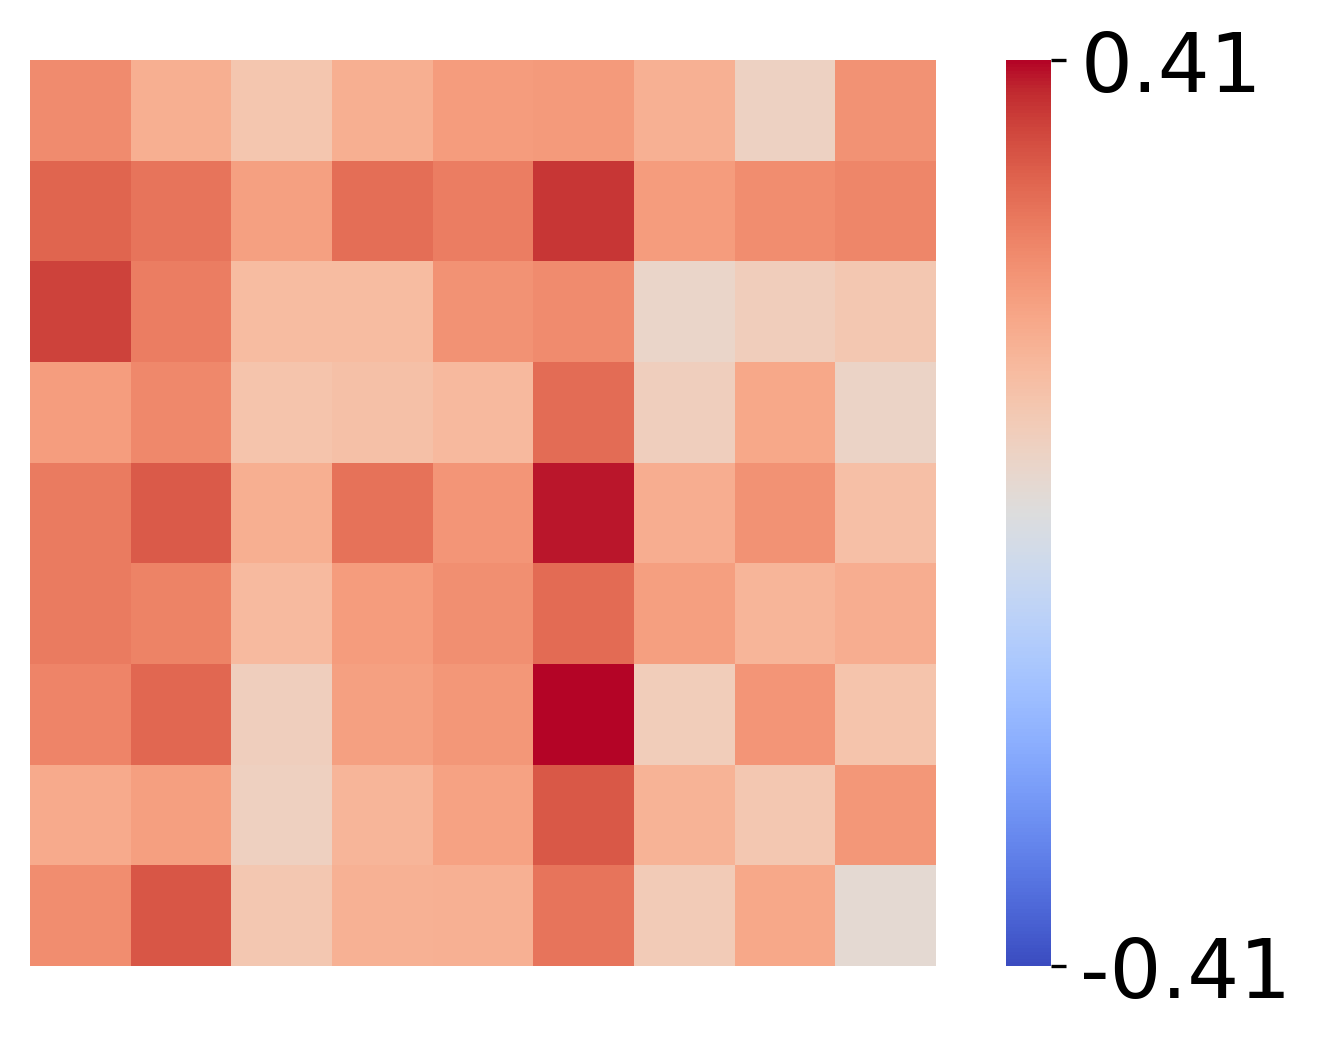

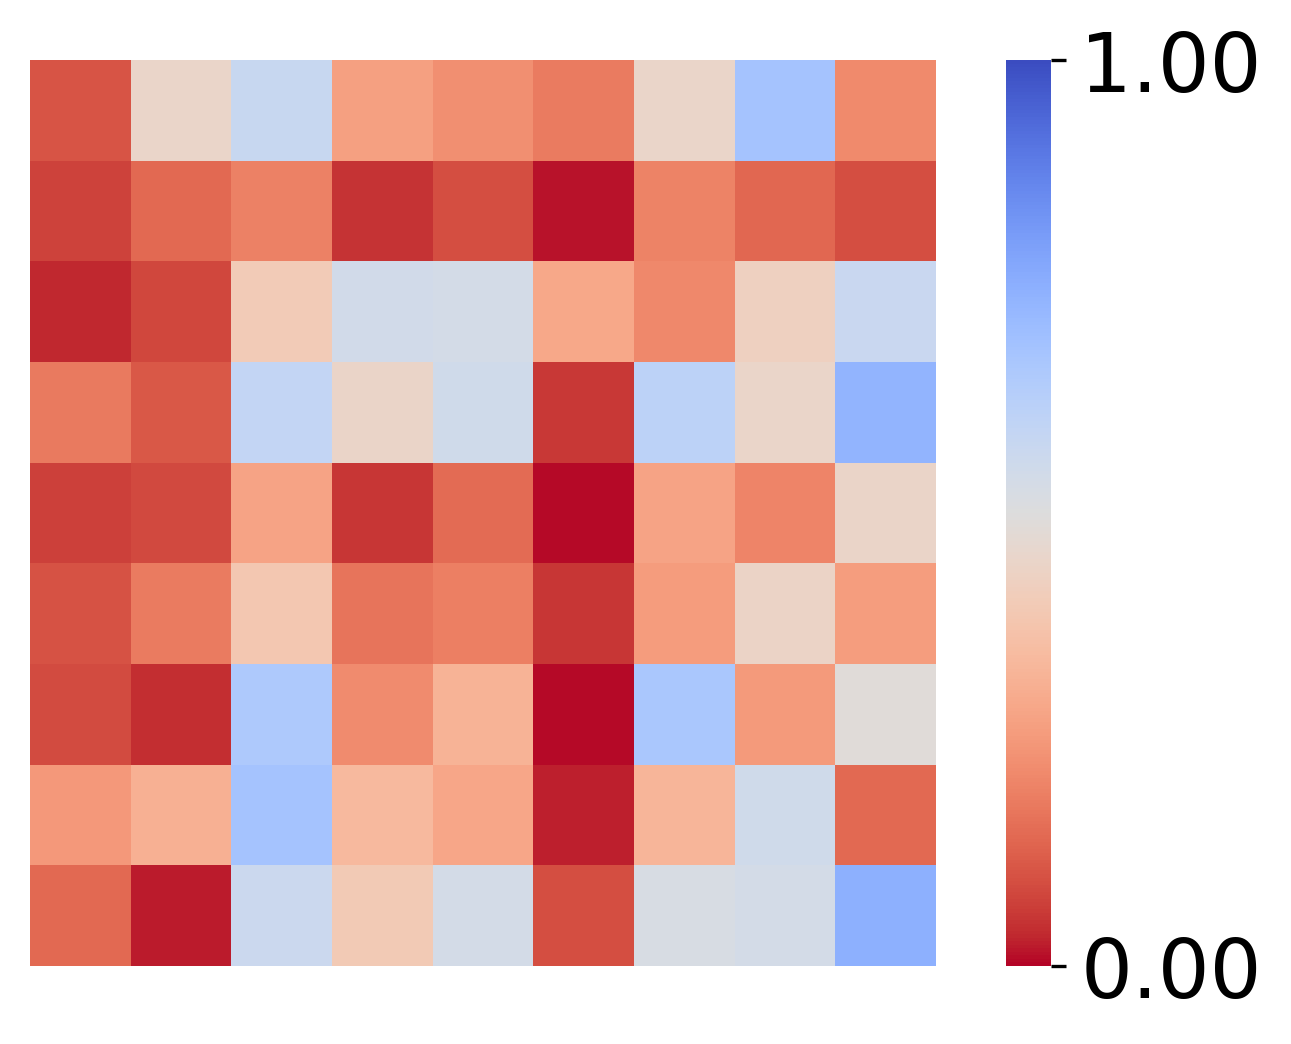

In [93]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['n_sleeps'], df['n_observes'], df['effs'], df['effs'], col1name = 'Sleeps', col2name='Observes', annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4, groups=df['group'])

In [94]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_observes_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_observes_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_observes_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_observes_humans.svg'))

### Trait-level Perturbations

In [95]:
from settings_ana import levc_human_ape_models as ape_models
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_ana import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss = np.flip(sim_rewss.T, axis=1)
sim_obss = np.flip(sim_obss.T, axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)

(150, 9)


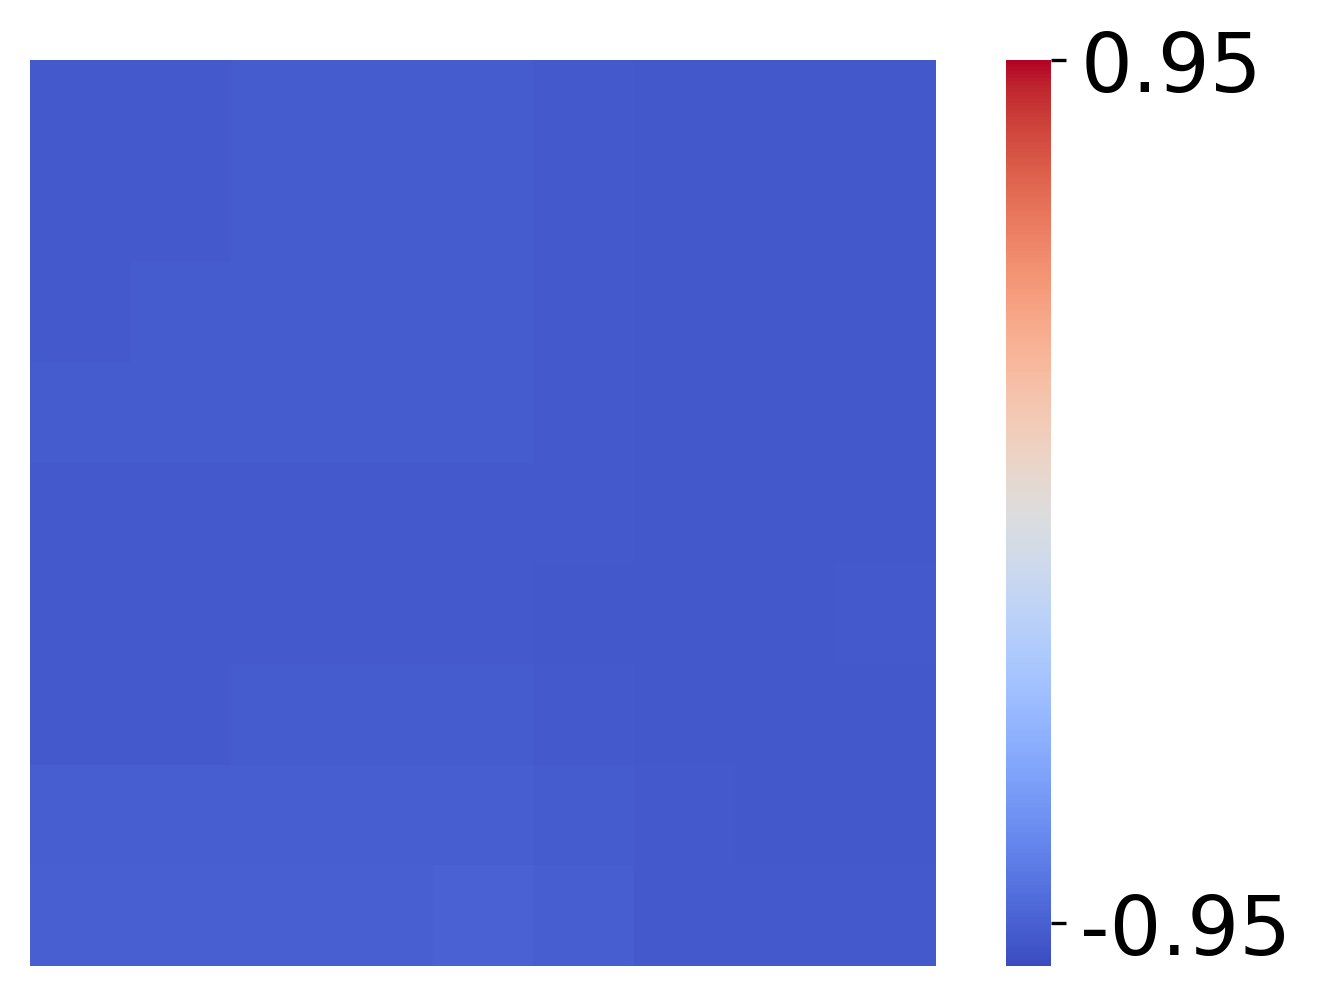

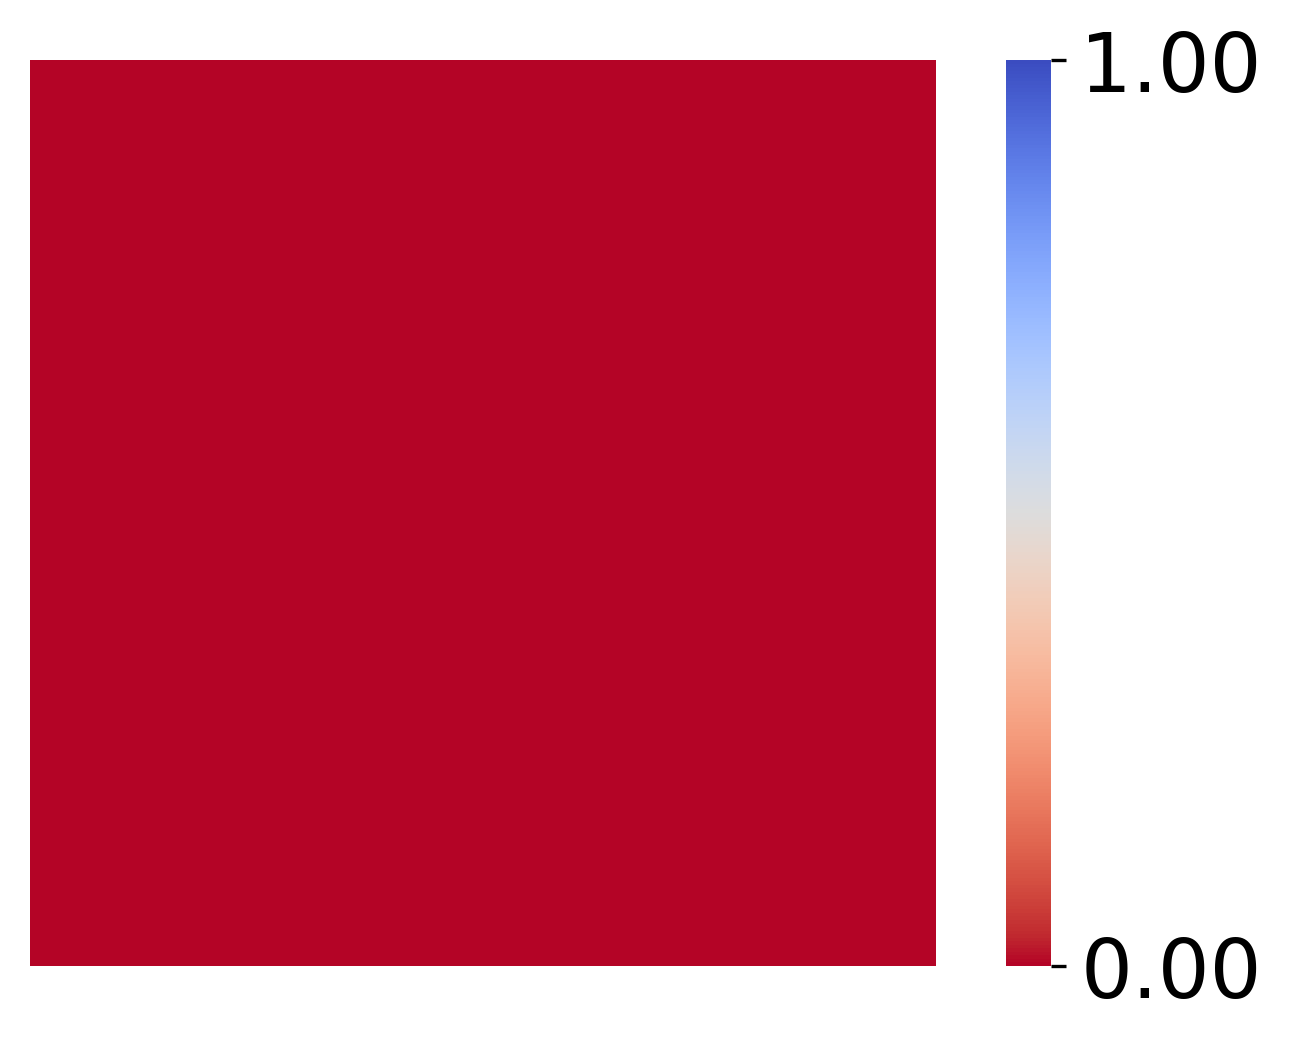

In [96]:
corr_fig, pvs_fig = compute_2D_correlation(sim_sleepss, sim_obss, effs, effs, "Sleeps", "Observes", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [97]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_observes_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_observes_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_observes_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_observes_trait.svg'))

### Random Perturbation

In [98]:
from settings_ana import levc_human_ape_models as ape_models
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_ana import random_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

random_rewss, random_obss, random_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

random_rewss = random_rewss.mean(axis=0)
random_obss = random_obss.mean(axis=0)
random_sleepss = random_sleepss.mean(axis=0)


## correcting for switching from tau to efficacy
random_rewss = np.flip(random_rewss.T, axis=1)
random_obss = np.flip(random_obss.T, axis=1)
random_sleepss = np.flip(random_sleepss.T, axis=1)

(150, 9)


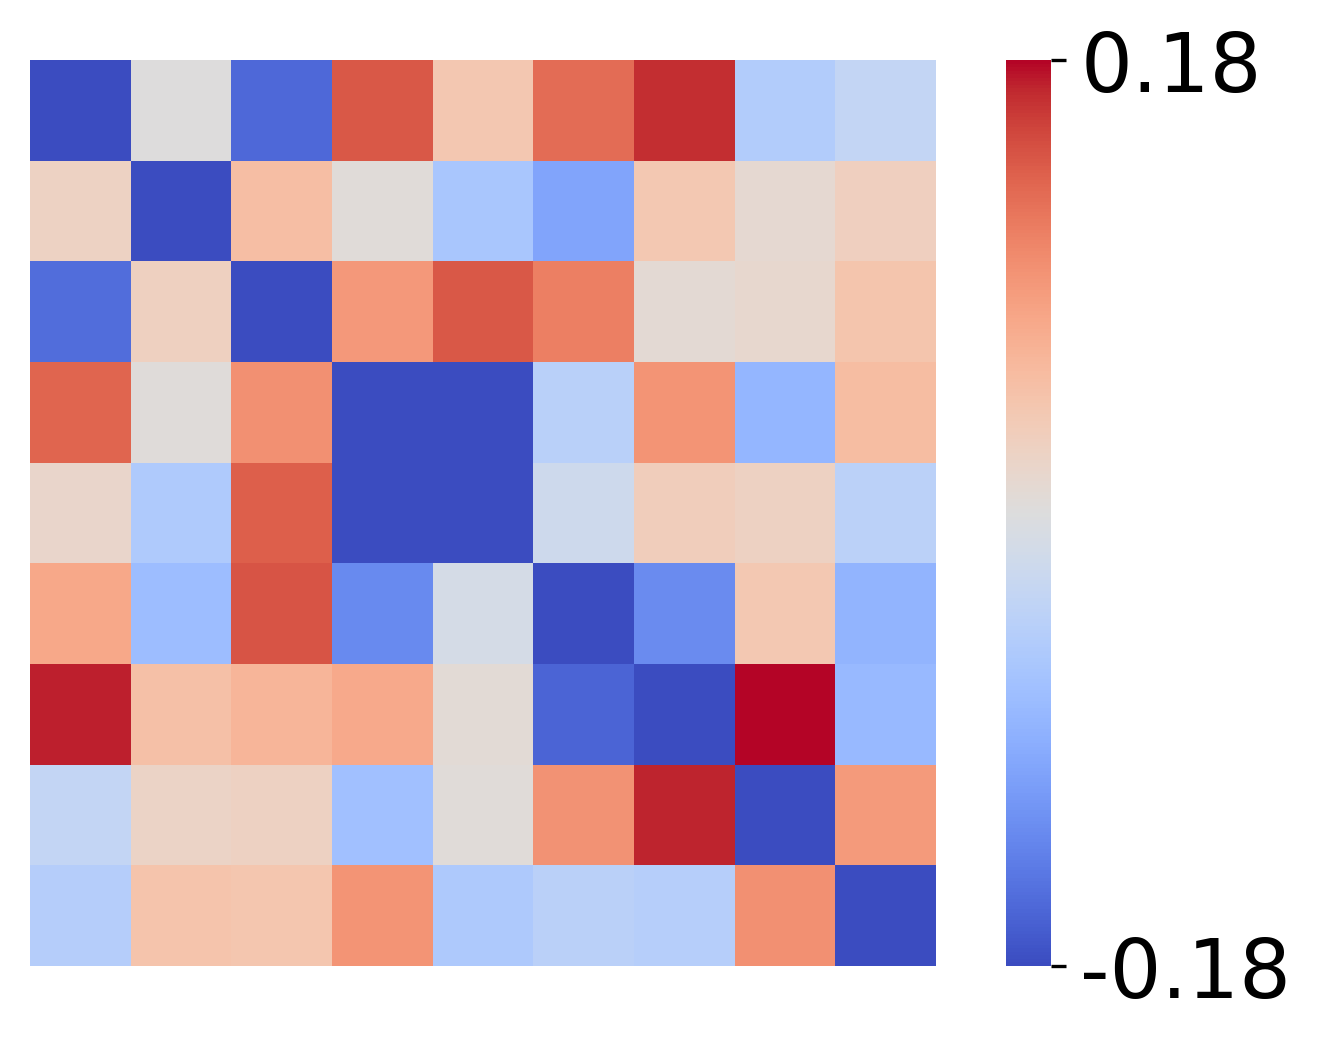

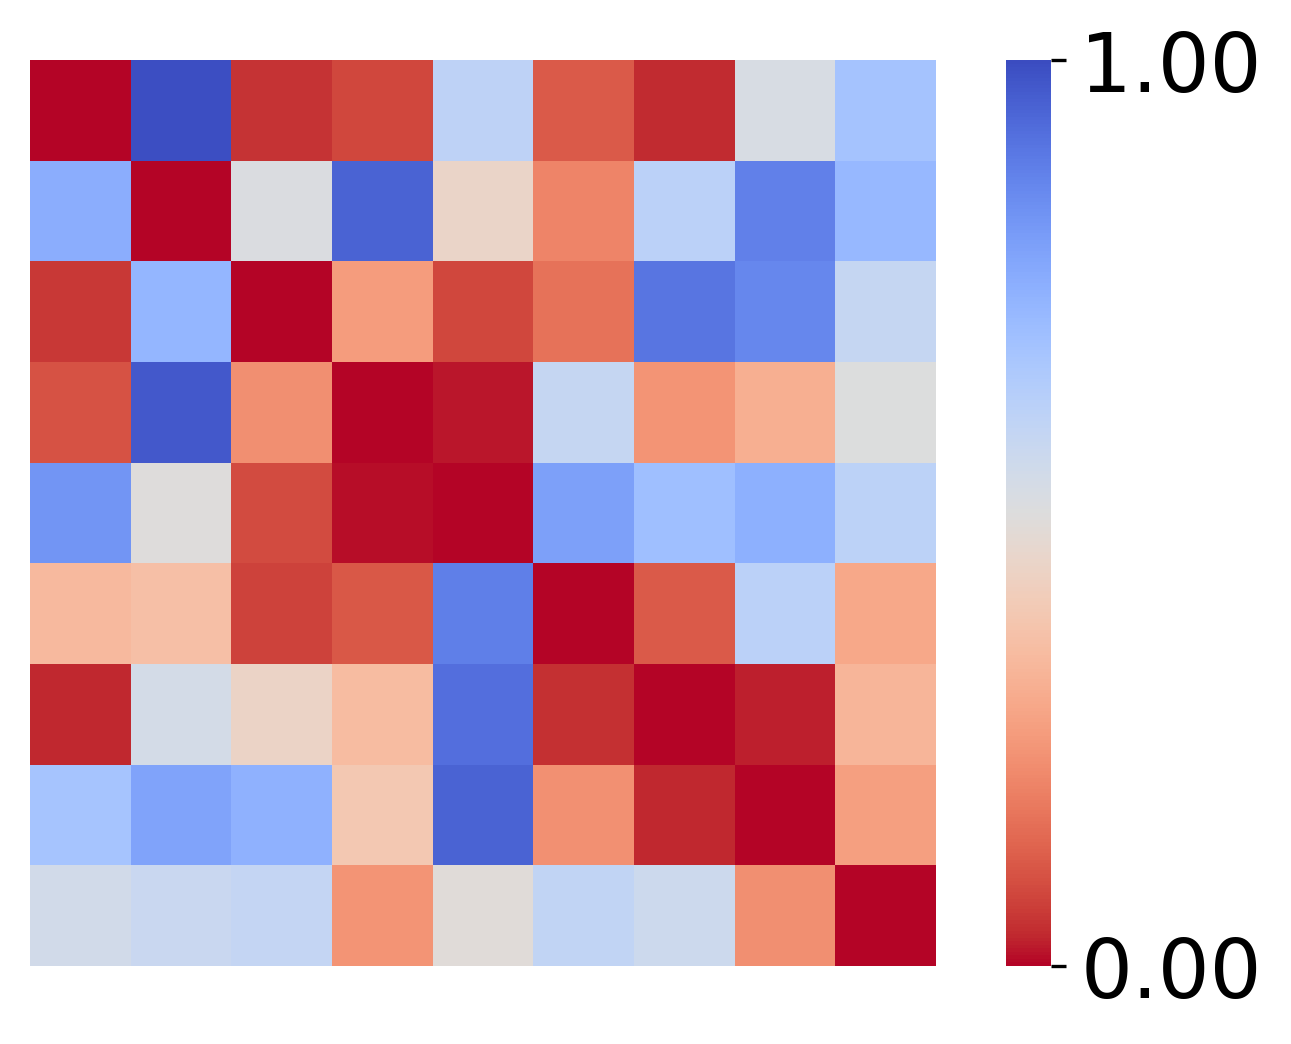

In [99]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(random_sleepss, random_obss, effs, effs, "Sleeps", "Sleeps", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [100]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_observes_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_observes_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_observes_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_observes_random.svg'))

### Zeros Perturbation

In [101]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import levc_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t2 as sim_timestamp

zeros_rewss, zeros_obss, zeros_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)
zeros_sleepss = zeros_sleepss.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_obss = np.flip(zeros_obss.T, axis=1)
zeros_sleepss = np.flip(zeros_sleepss.T, axis=1)

effs = np.arange(0, 1.125, 0.125)

(150, 9)


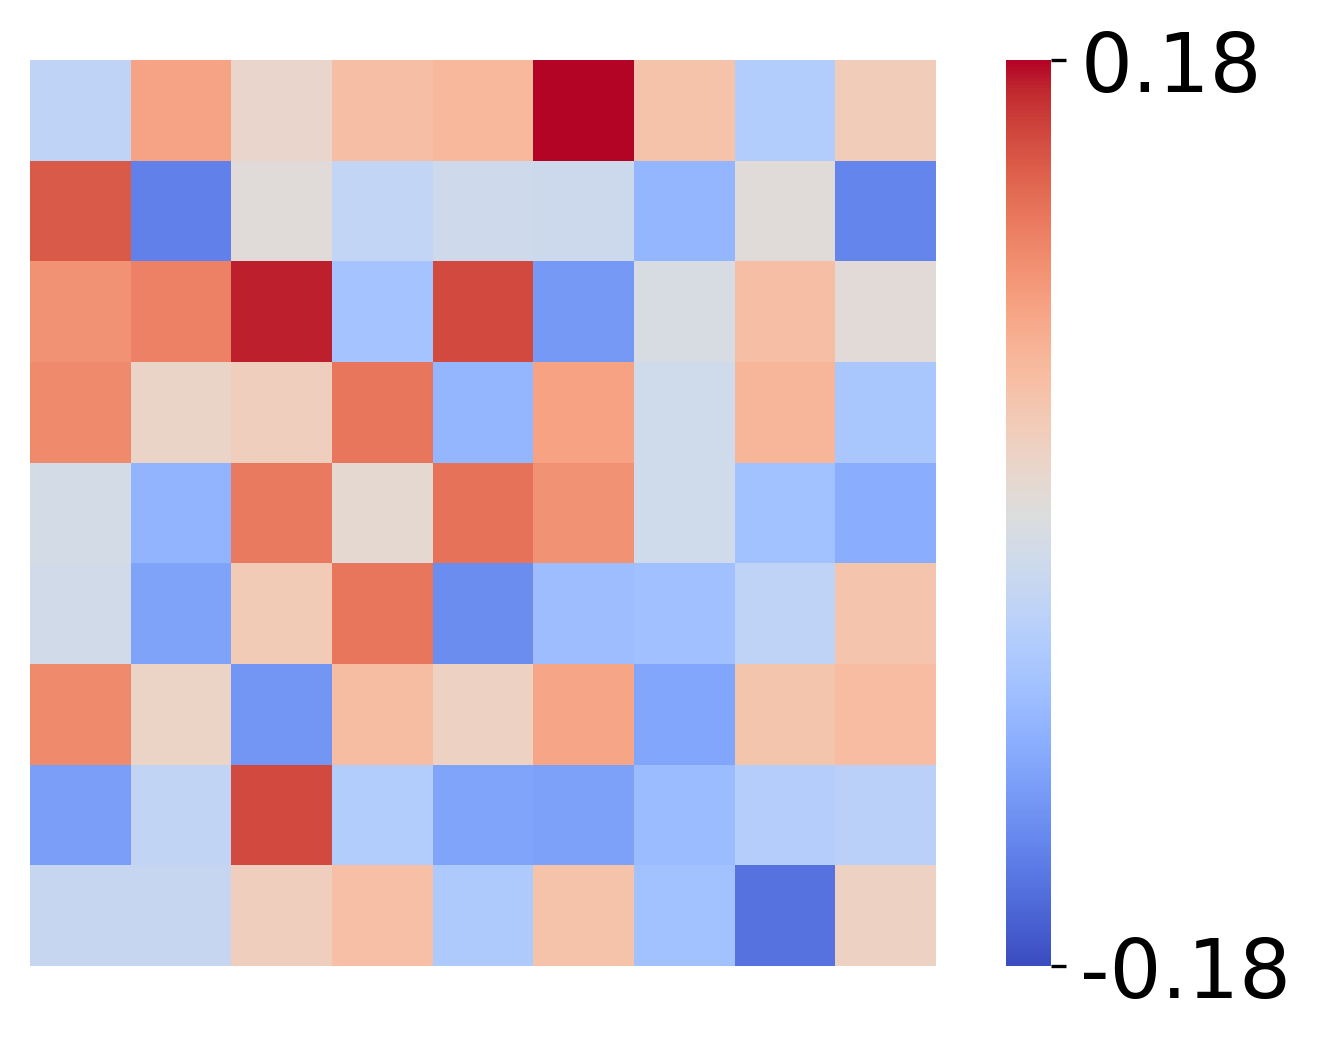

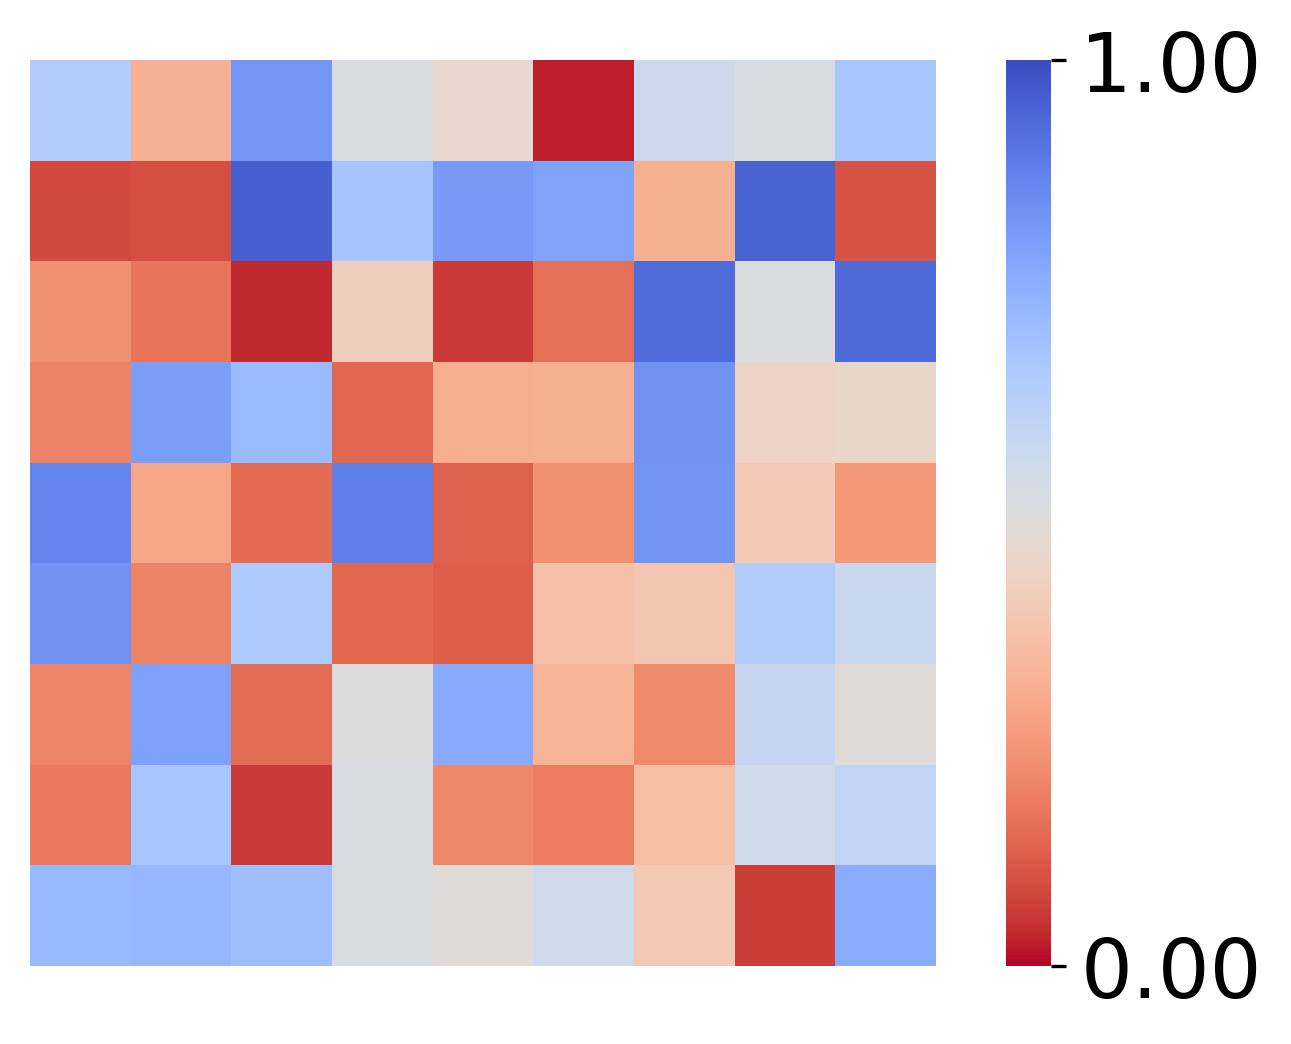

In [102]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(zeros_sleepss, zeros_obss, effs, effs, "Sleeps", "Sleeps", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [103]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_observes_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_sleeps_observes_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_observes_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_sleeps_observes_zeros.svg'))

## Panel D: Task 2 Number of Observations
### Humans

In [104]:
from human_utils_project import get_clean_data

day = 'day3'
exp_date = '24-01-22-29'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

effs = np.arange(0, 1.01, 0.125)
n_steps = 50

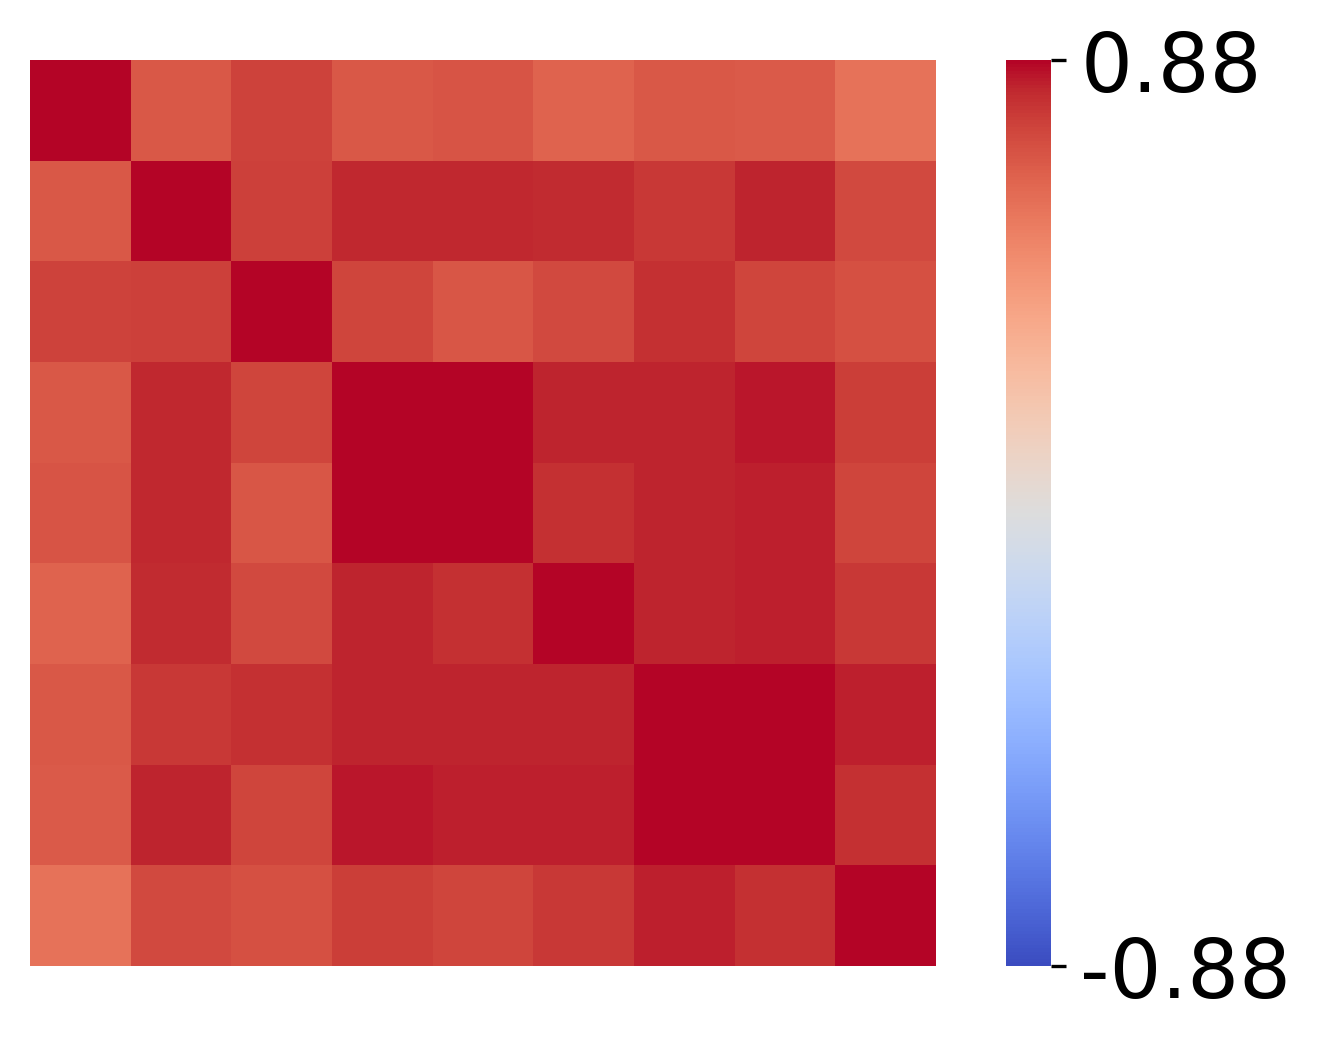

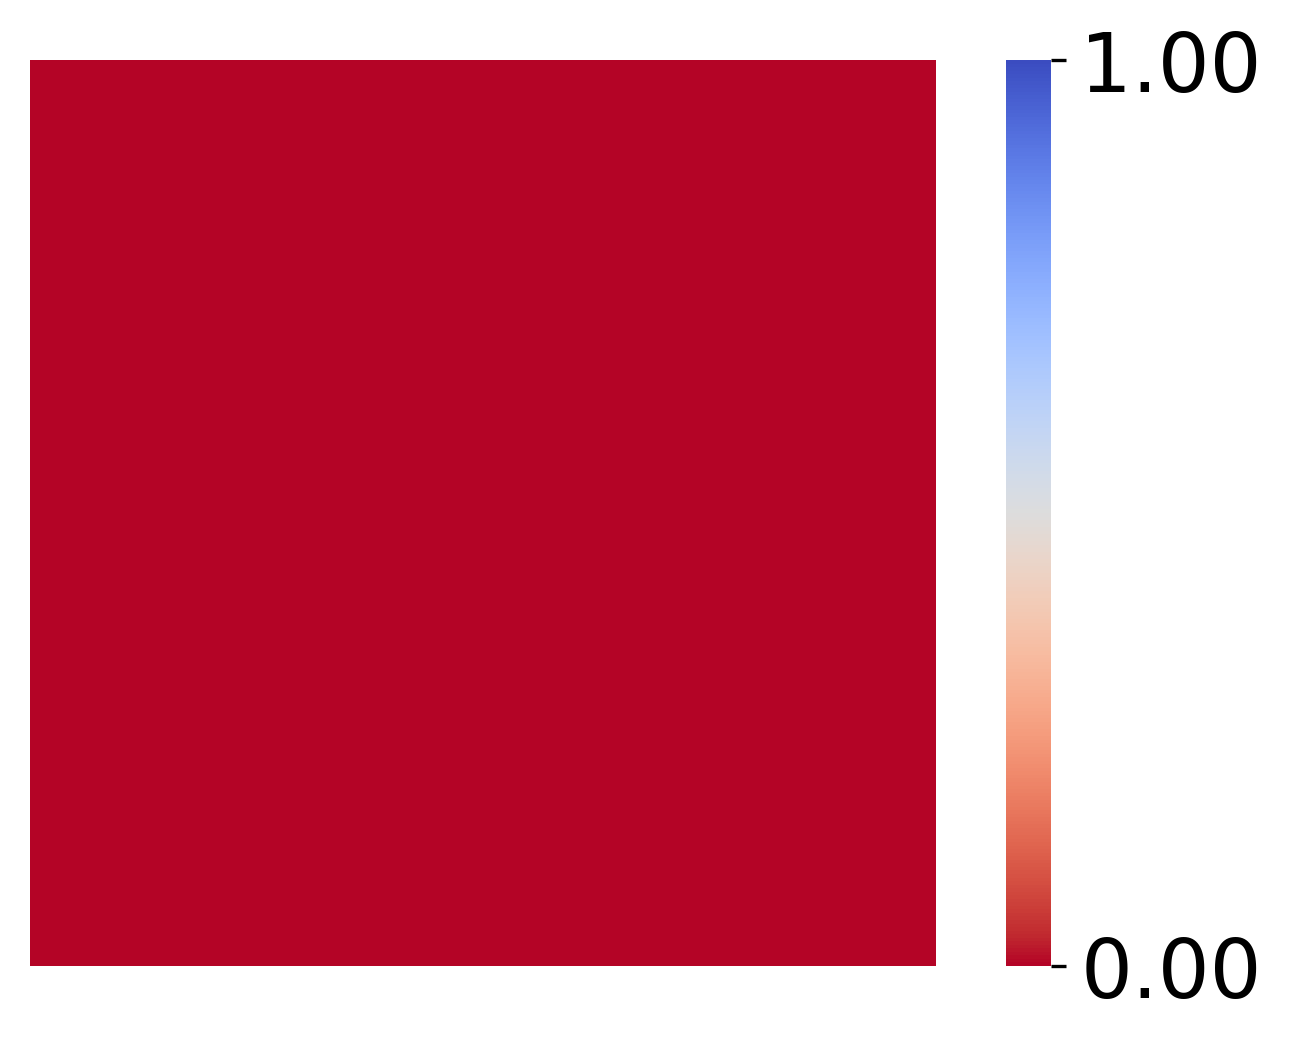

In [105]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['n_observes'], df['n_observes'], df['effs'], df['effs'], col1name = 'Observes', col2name='Observes', annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4, groups=df['group'])

In [106]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_observes_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_observes_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_observes_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_observes_humans.svg'))

### Trait-level Simulations

In [107]:
from settings_ana import levc_human_ape_models as ape_models
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_ana import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)


## correcting for switching from tau to efficacy
sim_rewss = np.flip(sim_rewss.T, axis=1)
sim_obss = np.flip(sim_obss.T, axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)

(150, 9)


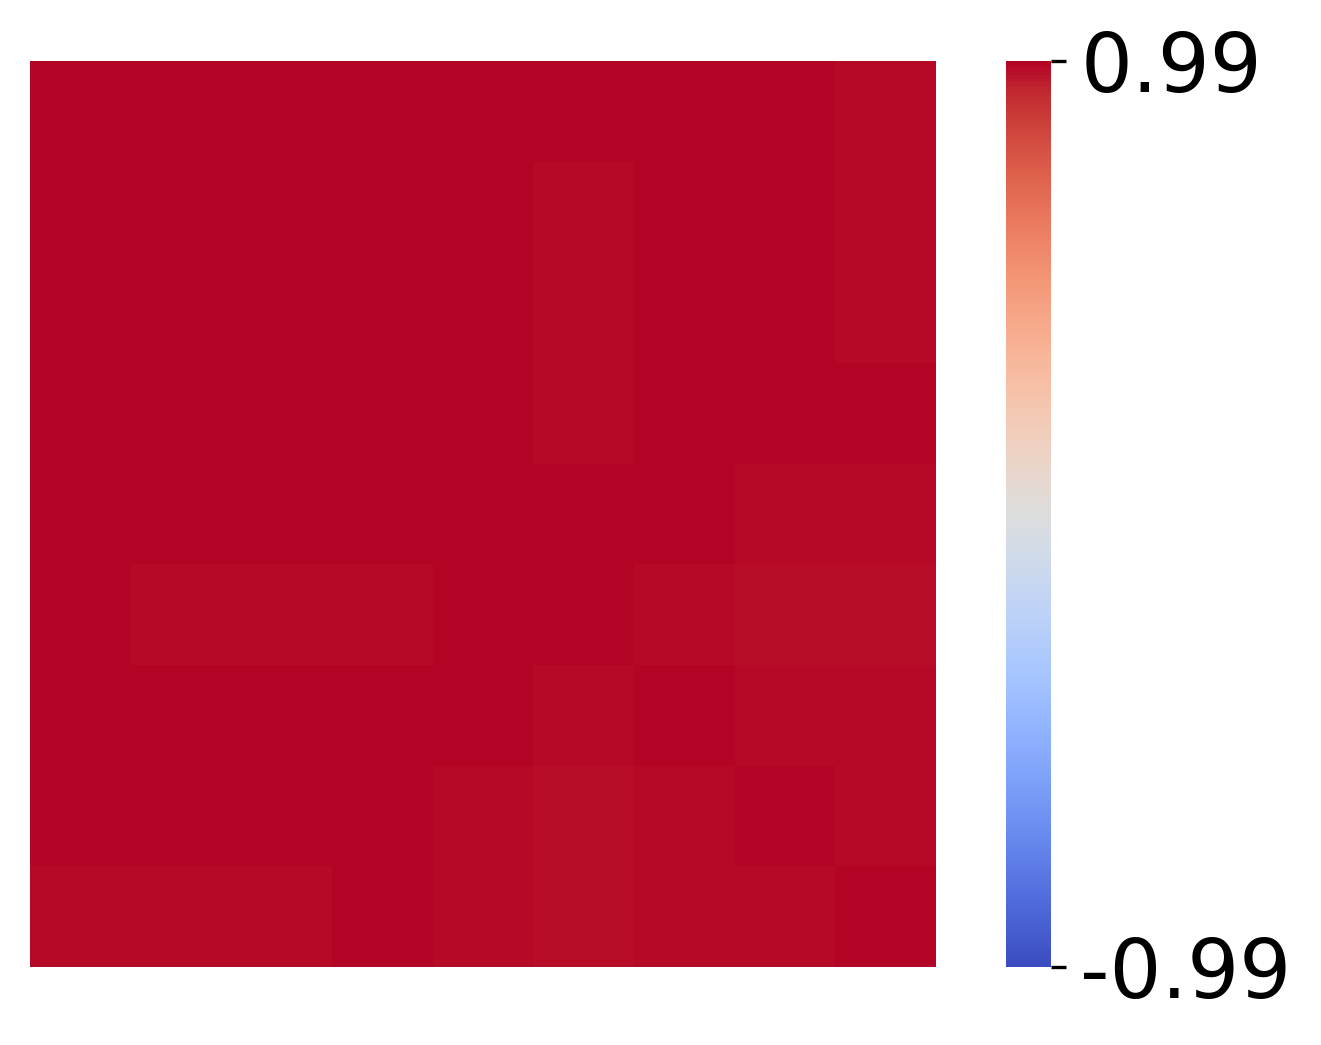

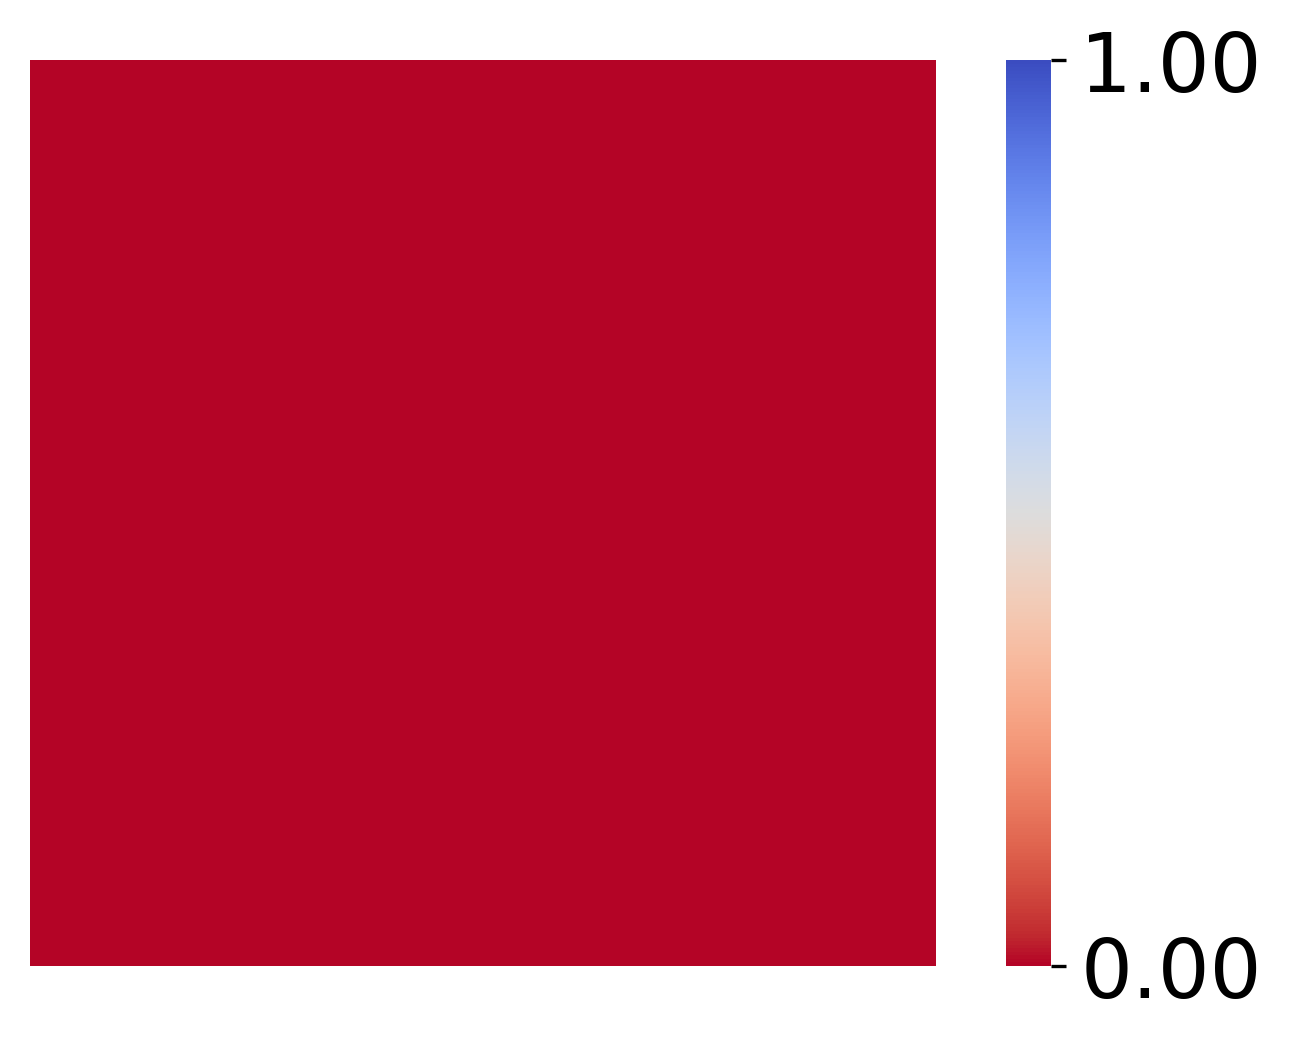

In [108]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(sim_obss, sim_obss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [109]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_observes_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_observes_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_observes_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_observes_trait.svg'))

### Random Perturbations

In [110]:
from settings_ana import levc_human_ape_models as ape_models
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_ana import random_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

random_rewss, random_obss, random_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

random_rewss = random_rewss.mean(axis=0)
random_obss = random_obss.mean(axis=0)
random_sleepss = random_sleepss.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss = np.flip(random_rewss.T, axis=1)
random_obss = np.flip(random_obss.T, axis=1)
random_sleepss = np.flip(random_sleepss.T, axis=1)

(150, 9)


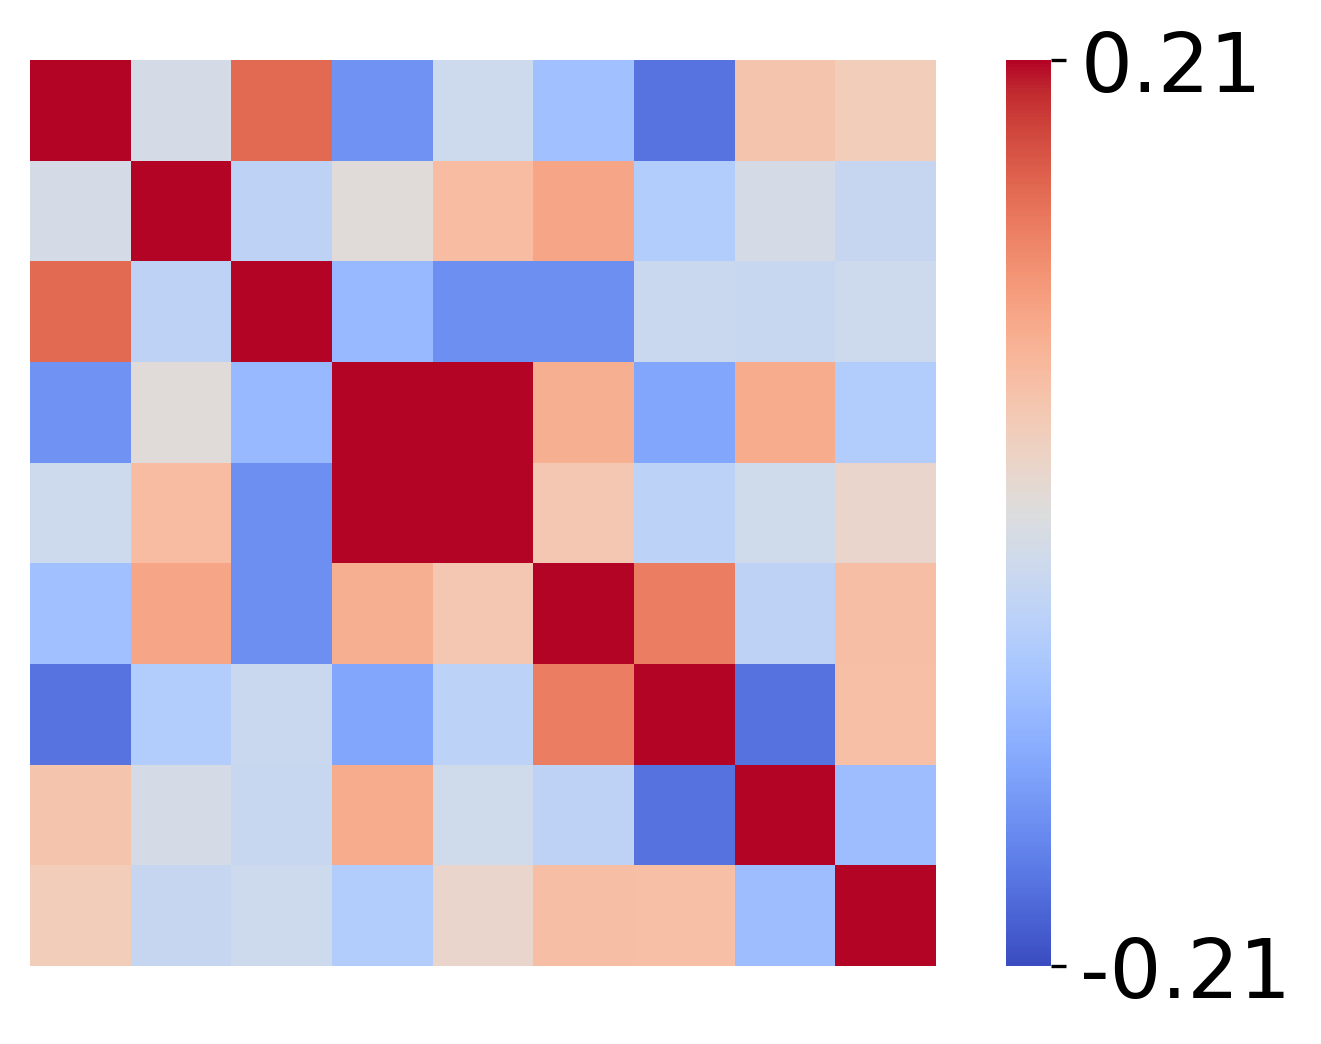

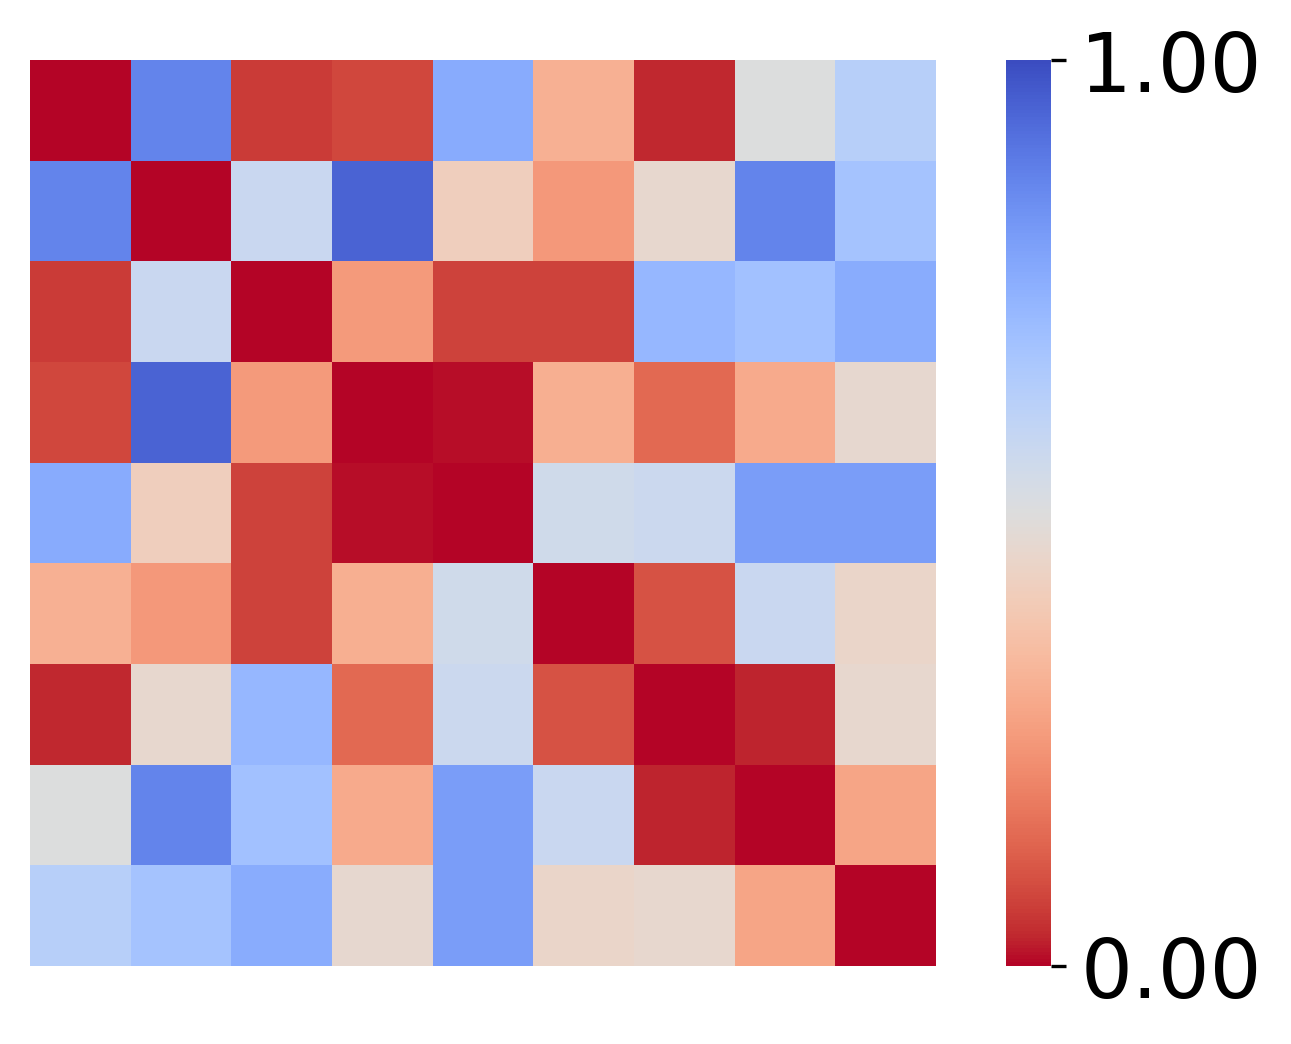

In [111]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(random_obss, random_obss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [112]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_observes_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_observes_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_observes_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_observes_random.svg'))

### Zeros Perturbations

In [113]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import levc_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t2 as sim_timestamp

zeros_rewss, zeros_obss, zeros_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)
zeros_sleepss = zeros_sleepss.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_obss = np.flip(zeros_obss.T, axis=1)
zeros_sleepss = np.flip(zeros_sleepss.T, axis=1)

effs = np.arange(0, 1.125, 0.125)

(150, 9)


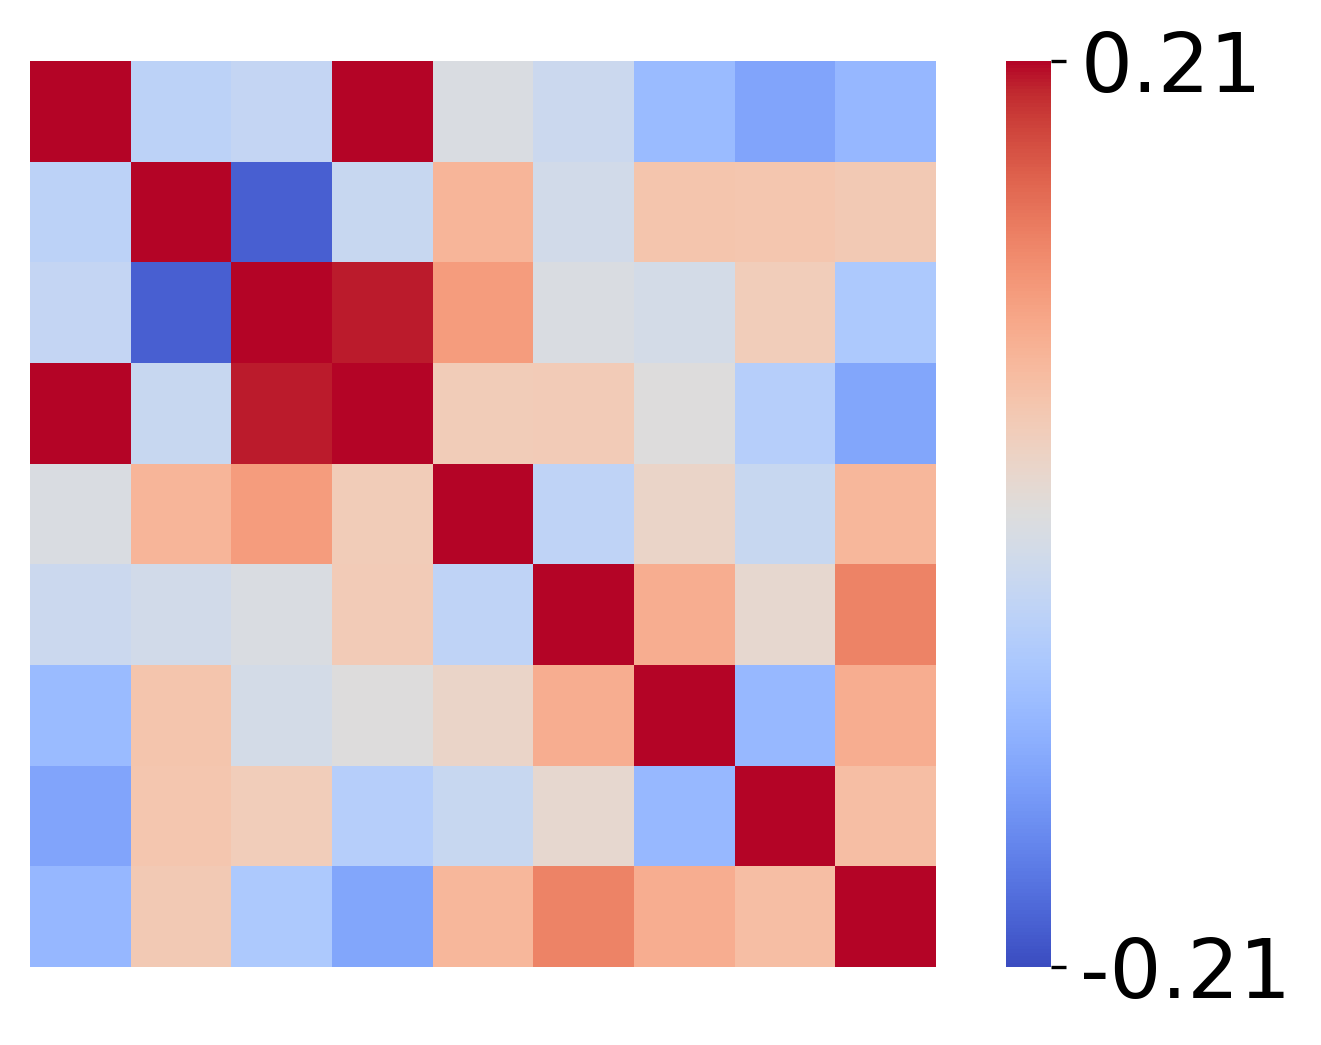

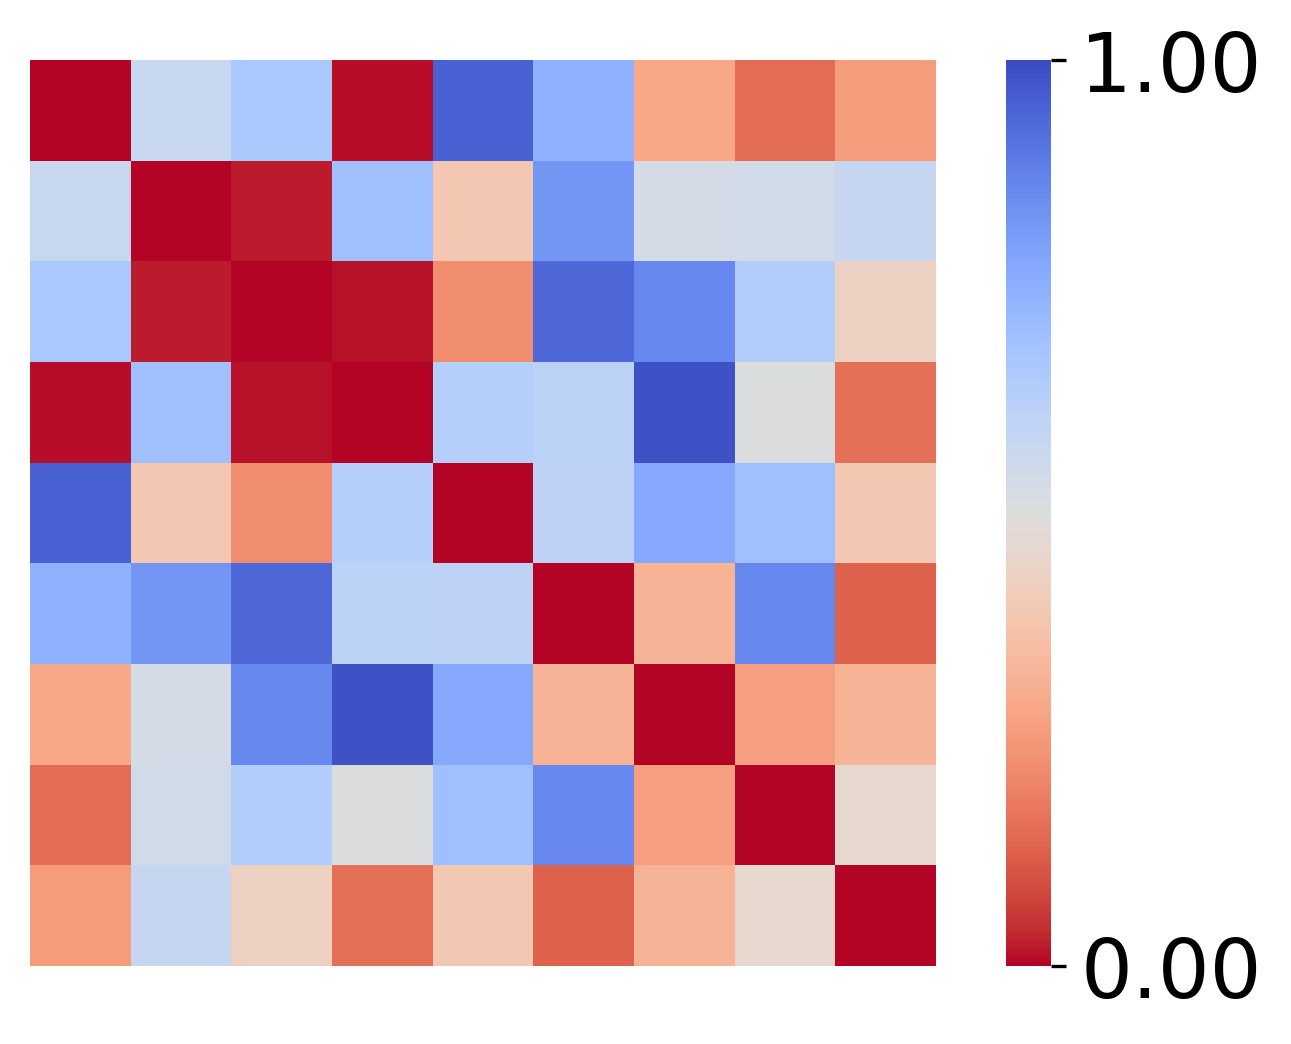

In [114]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(zeros_obss, zeros_obss, effs, effs, "Observations", "Observations", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [115]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_observes_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_observes_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_observes_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_observes_zeros.svg'))

### Stats

In [116]:
from human_utils_behavioral_analysis import compute_2D_correlation_matrices

data_obs_corr_g1, data_obs_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_obs_corr_g2, data_obs_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_rews_corr_g1, data_rews_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_rews_corr_g2, data_rews_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_sleeps_corr_g1, data_sleeps_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['n_sleeps'].values), np.stack(df[~df['group']]['n_sleeps'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_sleeps_corr_g2, data_sleeps_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['n_sleeps'].values), np.stack(df[df['group']]['n_sleeps'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_obs_corr = (~df['group']).sum() / len(df) * data_obs_corr_g1 + (df['group']).sum() / len(df) * data_obs_corr_g2
data_obs_pvs = (~df['group']).sum() / len(df) * data_obs_pvs_g1 + (df['group']).sum() / len(df) * data_obs_pvs_g2

data_rews_corr = (~df['group']).sum() / len(df) * data_rews_corr_g1 + (df['group']).sum() / len(df) * data_rews_corr_g2
data_rews_pvs = (~df['group']).sum() / len(df) * data_rews_pvs_g1 + (df['group']).sum() / len(df) * data_rews_pvs_g2

data_sleeps_corr = (~df['group']).sum() / len(df) * data_sleeps_corr_g1 + (df['group']).sum() / len(df) * data_sleeps_corr_g2
data_sleeps_pvs = (~df['group']).sum() / len(df) * data_sleeps_pvs_g1 + (df['group']).sum() / len(df) * data_sleeps_pvs_g2


sim_obs_corr, sim_obs_pvs = compute_2D_correlation_matrices(sim_obss, sim_obss, effs, effs,)
sim_rews_corr, sim_rews_pvs = compute_2D_correlation_matrices(sim_rewss, sim_rewss, effs, effs,)
sim_sleeps_corr, sim_sleeps_pvs = compute_2D_correlation_matrices(sim_sleepss, sim_sleepss, effs, effs,)
random_obs_corr, random_obs_pvs = compute_2D_correlation_matrices(random_obss, random_obss, effs, effs,)
random_rews_corr, random_rews_pvs = compute_2D_correlation_matrices(random_rewss, random_rewss, effs, effs,)
random_sleeps_corr, random_sleeps_pvs = compute_2D_correlation_matrices(random_sleepss, random_sleepss, effs, effs,)

zeros_obs_corr, zeros_obs_pvs = compute_2D_correlation_matrices(zeros_obss, zeros_obss, effs, effs,)
zeros_rews_corr, zeros_rews_pvs = compute_2D_correlation_matrices(zeros_rewss, zeros_rewss, effs, effs,)
zeros_sleeps_corr, zeros_sleeps_pvs = compute_2D_correlation_matrices(zeros_sleepss, zeros_sleepss, effs, effs,)

(46, 9)
(65, 9)
(46, 9)
(65, 9)
(46, 9)
(65, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)


In [117]:
from human_utils_behavioral_analysis import competitive_corr_regression, upper_tri_masking

competitive_corr_regression(upper_tri_masking(data_obs_corr), [upper_tri_masking(sim_obs_corr), upper_tri_masking(random_obs_corr), upper_tri_masking(zeros_obs_corr)], do_fisher_transform=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.582
Date:                Mon, 07 Oct 2024   Prob (F-statistic):              0.213
Time:                        15:54:39   Log-Likelihood:                 15.409
No. Observations:                  36   AIC:                            -22.82
Df Residuals:                      32   BIC:                            -16.48
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5621      0.565      2.763      0.0

#### Cosine Similarity

In [118]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(upper_tri_masking(data_obs_corr).reshape((1,-1)), upper_tri_masking(sim_obs_corr).reshape((1,-1)))[0][0])
print(cosine_similarity(upper_tri_masking(data_obs_corr).reshape((1,-1)), upper_tri_masking(random_obs_corr).reshape((1,-1)))[0][0])

0.9960169137687078
-0.12234407813340314


## Panel E: Task 2 Rewards
### Humans

In [119]:
from human_utils_project import get_clean_data

day = 'day3'
exp_date = '24-01-22-29'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

effs = np.arange(0, 1.01, 0.125)
n_steps = 50

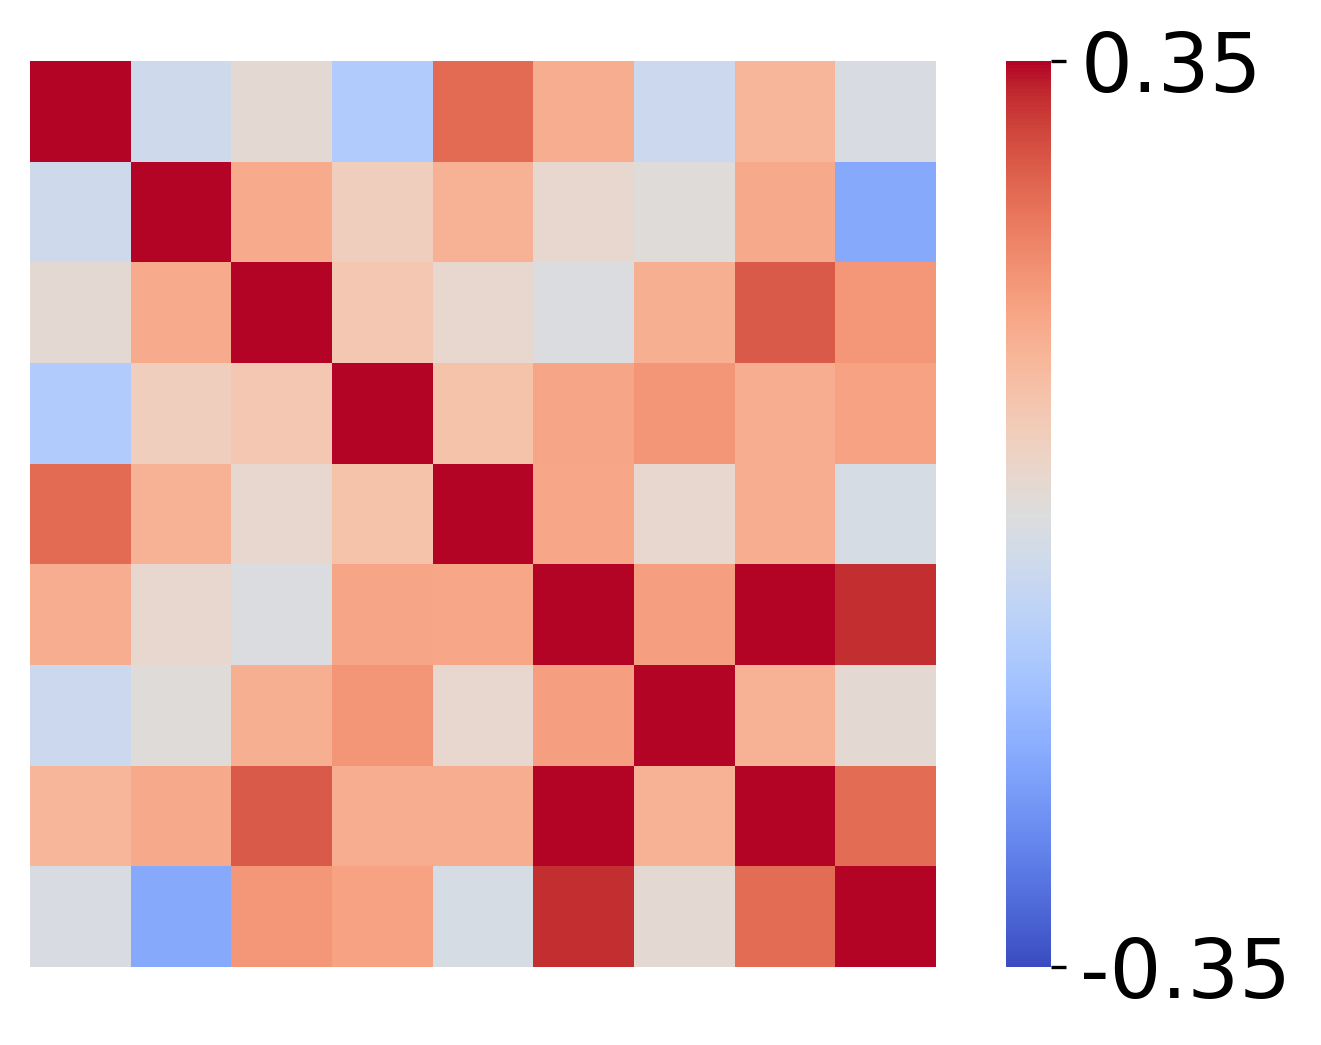

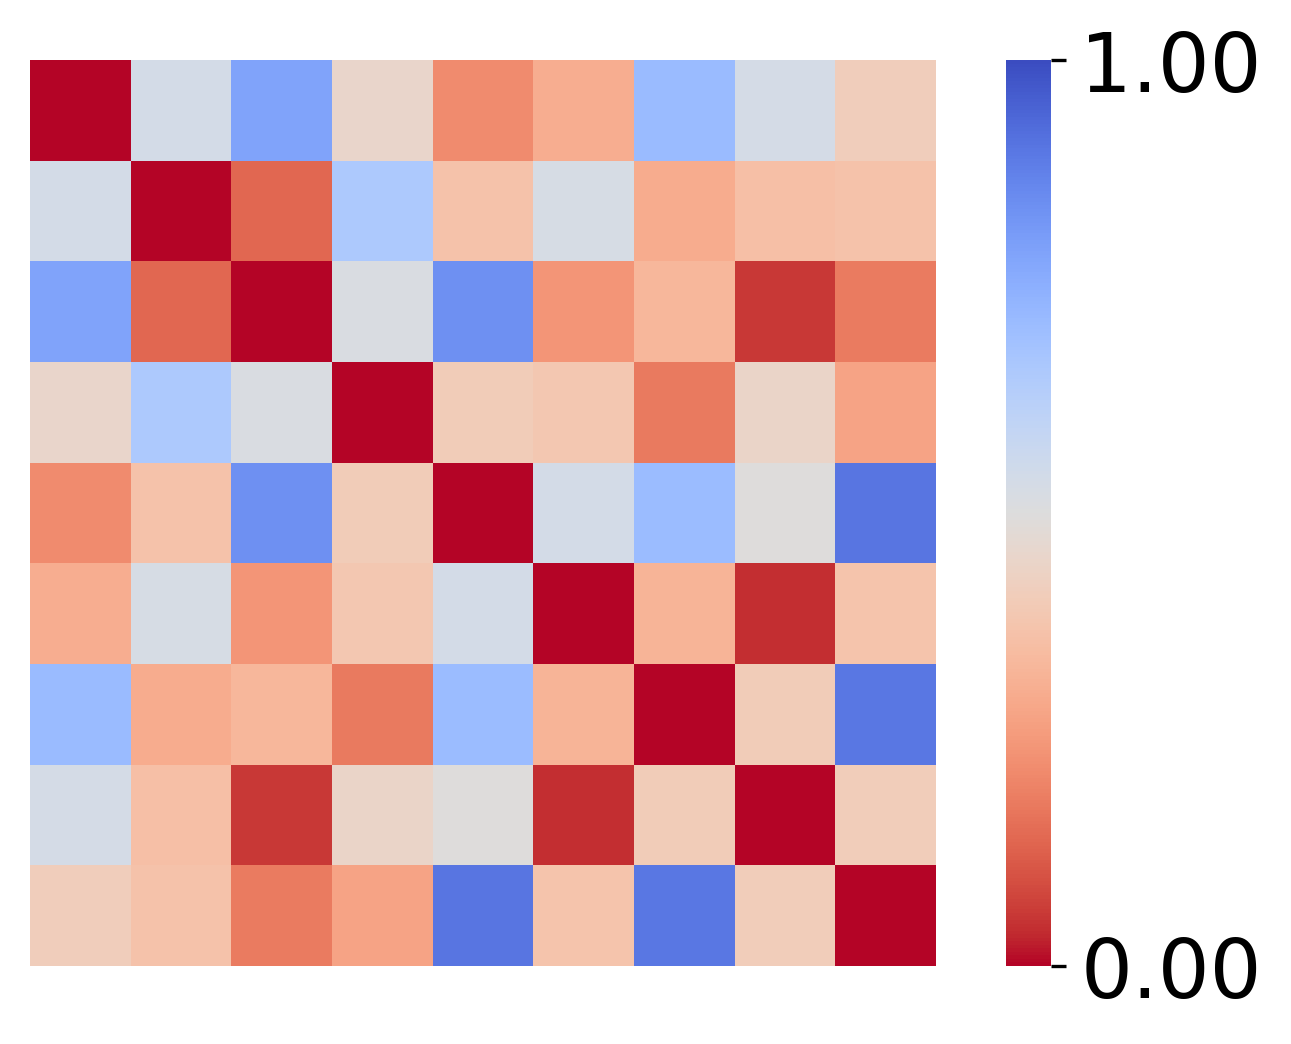

In [120]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['rewards_tallies'], df['rewards_tallies'], df['effs'], df['effs'], col1name = 'Rewards', col2name='Rewards', annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4, groups=df['group'])

In [121]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_rewards_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_rewards_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_rewards_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_rewards_humans.svg'))

### Trait-Level Perturbations

In [122]:
from settings_ana import levc_human_ape_models as ape_models
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_ana import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss = np.flip(sim_rewss.T, axis=1)
sim_obss = np.flip(sim_obss.T, axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)

(150, 9)


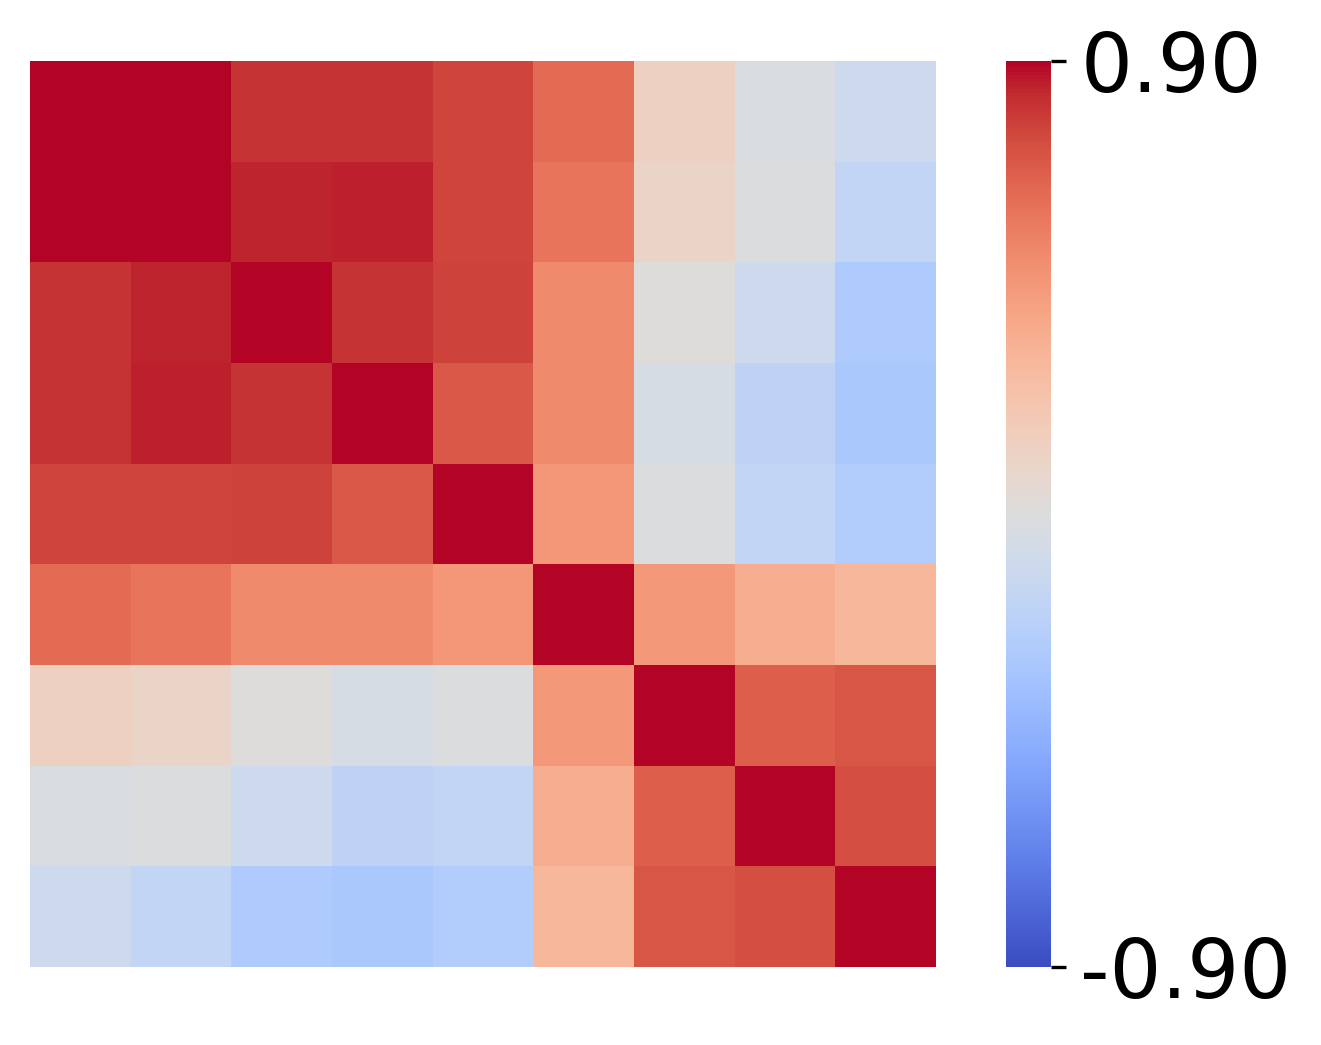

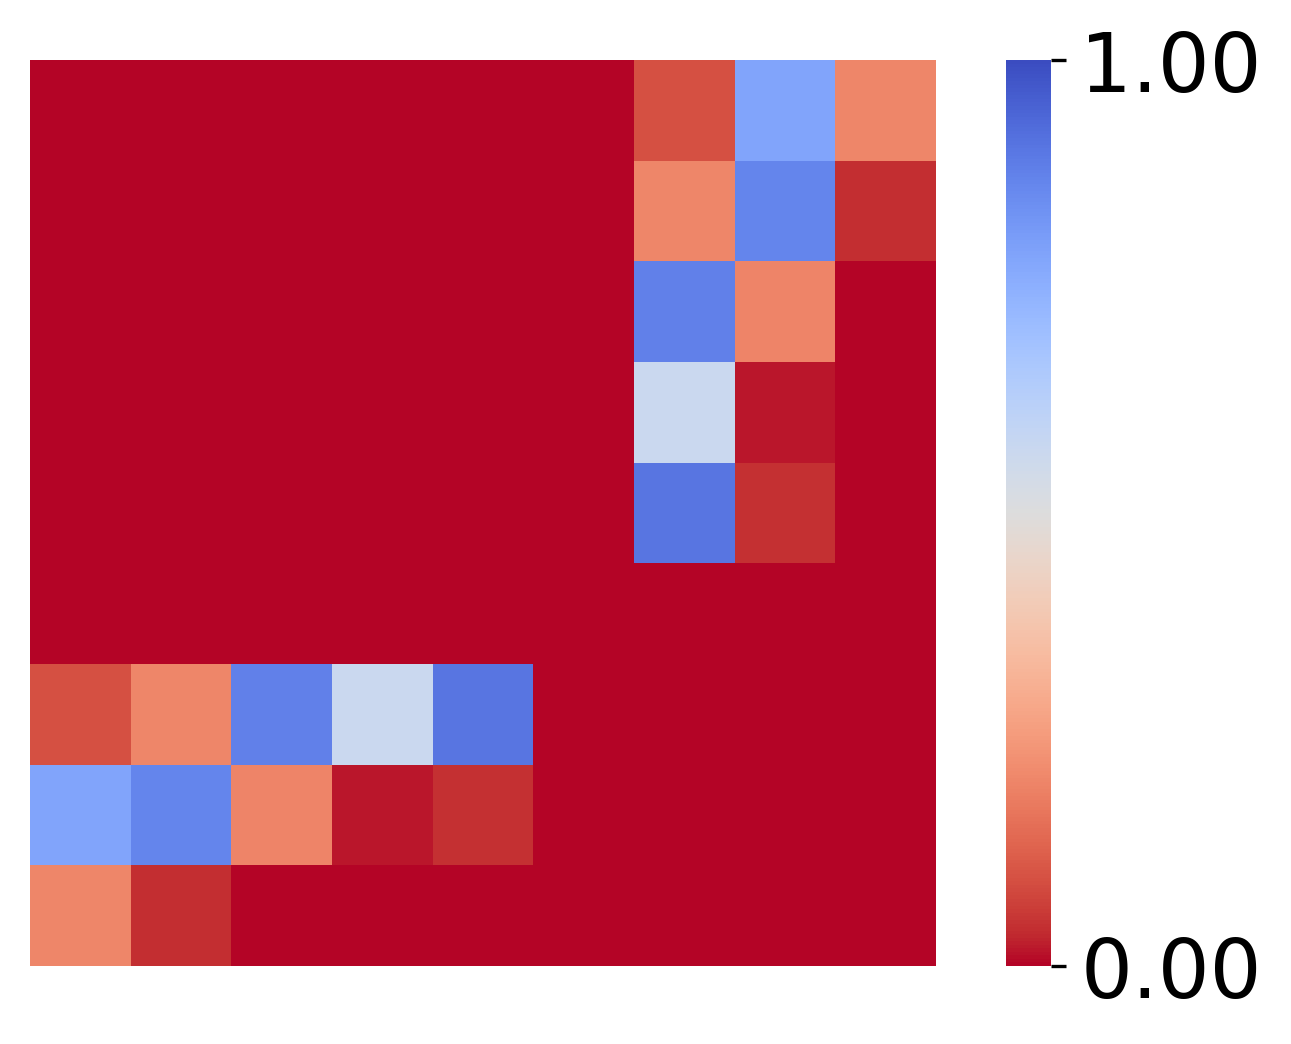

In [123]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(sim_rewss, sim_rewss, effs, effs, "Rewards", "Rewards", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [124]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_rewards_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_rewards_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_rewards_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_rewards_trait.svg'))

### Random Perturbations

In [125]:
from settings_ana import levc_human_ape_models as ape_models
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_ana import random_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

random_rewss, random_obss, random_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

random_rewss = random_rewss.mean(axis=0)
random_obss = random_obss.mean(axis=0)
random_sleepss = random_sleepss.mean(axis=0)


## correcting for switching from tau to efficacy
random_rewss = np.flip(random_rewss.T, axis=1)
random_obss = np.flip(random_obss.T, axis=1)
random_sleepss = np.flip(random_sleepss.T, axis=1)

(150, 9)


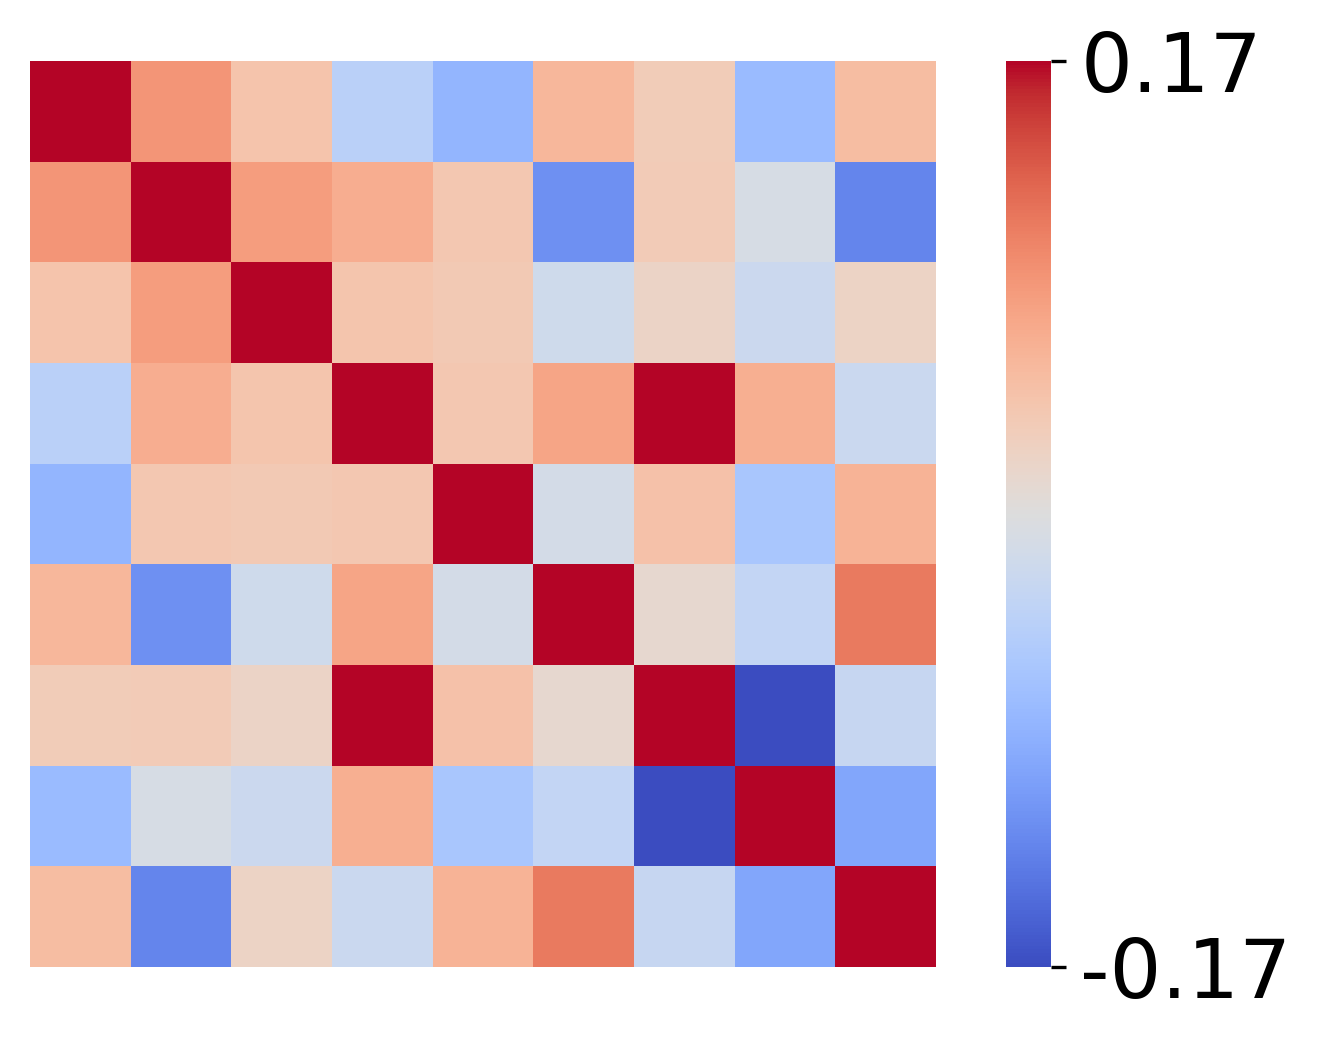

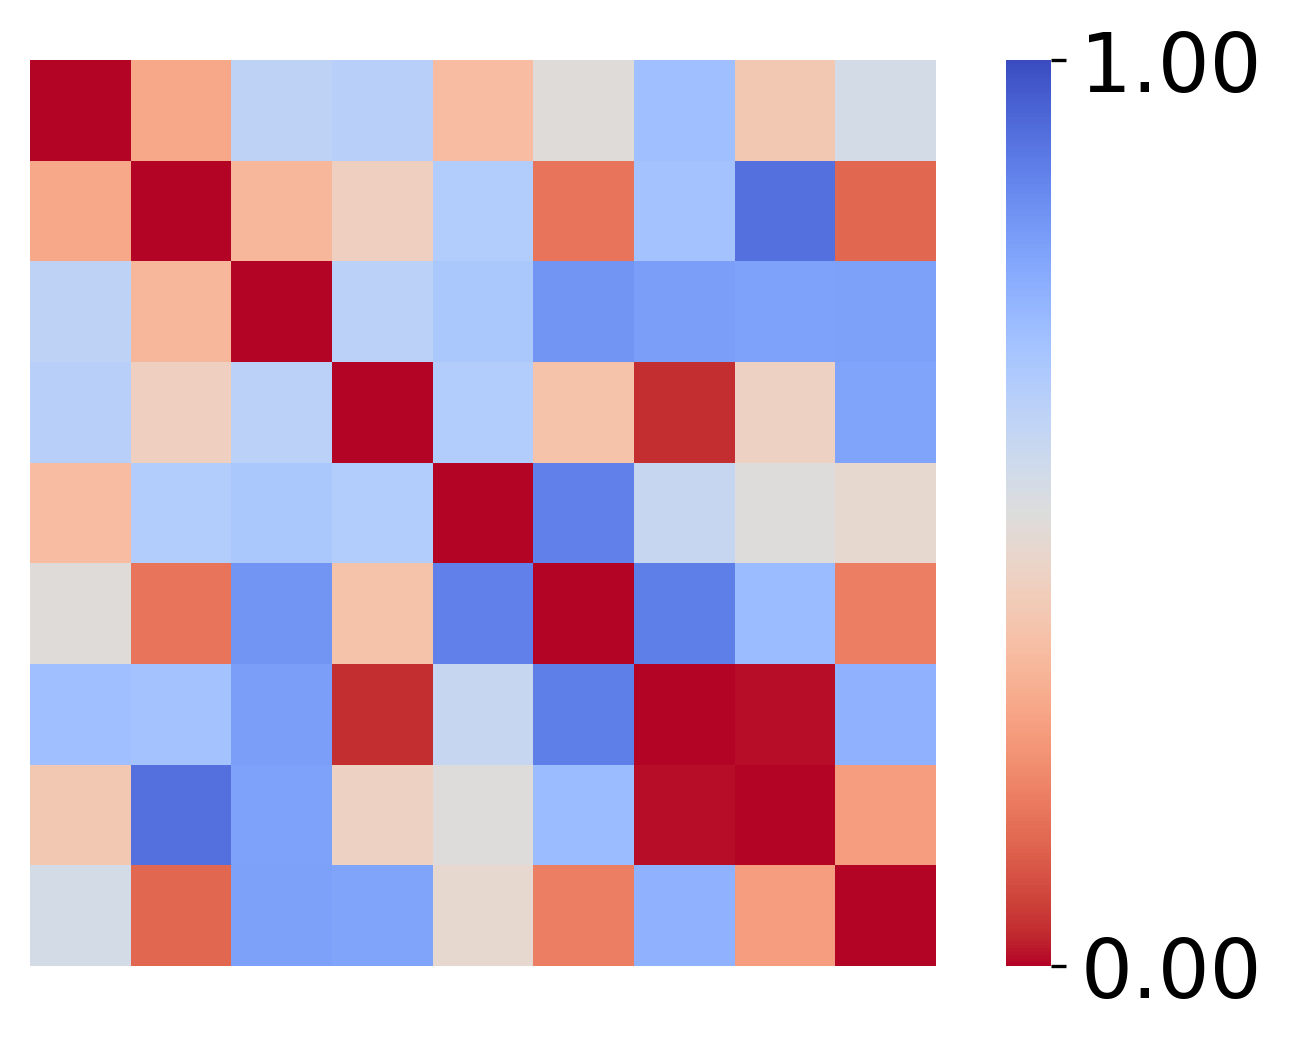

In [126]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(random_rewss, random_rewss, effs, effs, "Rewards", "Rewards", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)


In [127]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_rewards_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_rewards_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_rewards_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_rewards_random.svg'))

### Zeros Perturbations

In [128]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import levc_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t2 as sim_timestamp

zeros_rewss, zeros_obss, zeros_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)
zeros_sleepss = zeros_sleepss.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_obss = np.flip(zeros_obss.T, axis=1)
zeros_sleepss = np.flip(zeros_sleepss.T, axis=1)

effs = np.arange(0, 1.125, 0.125)

(150, 9)


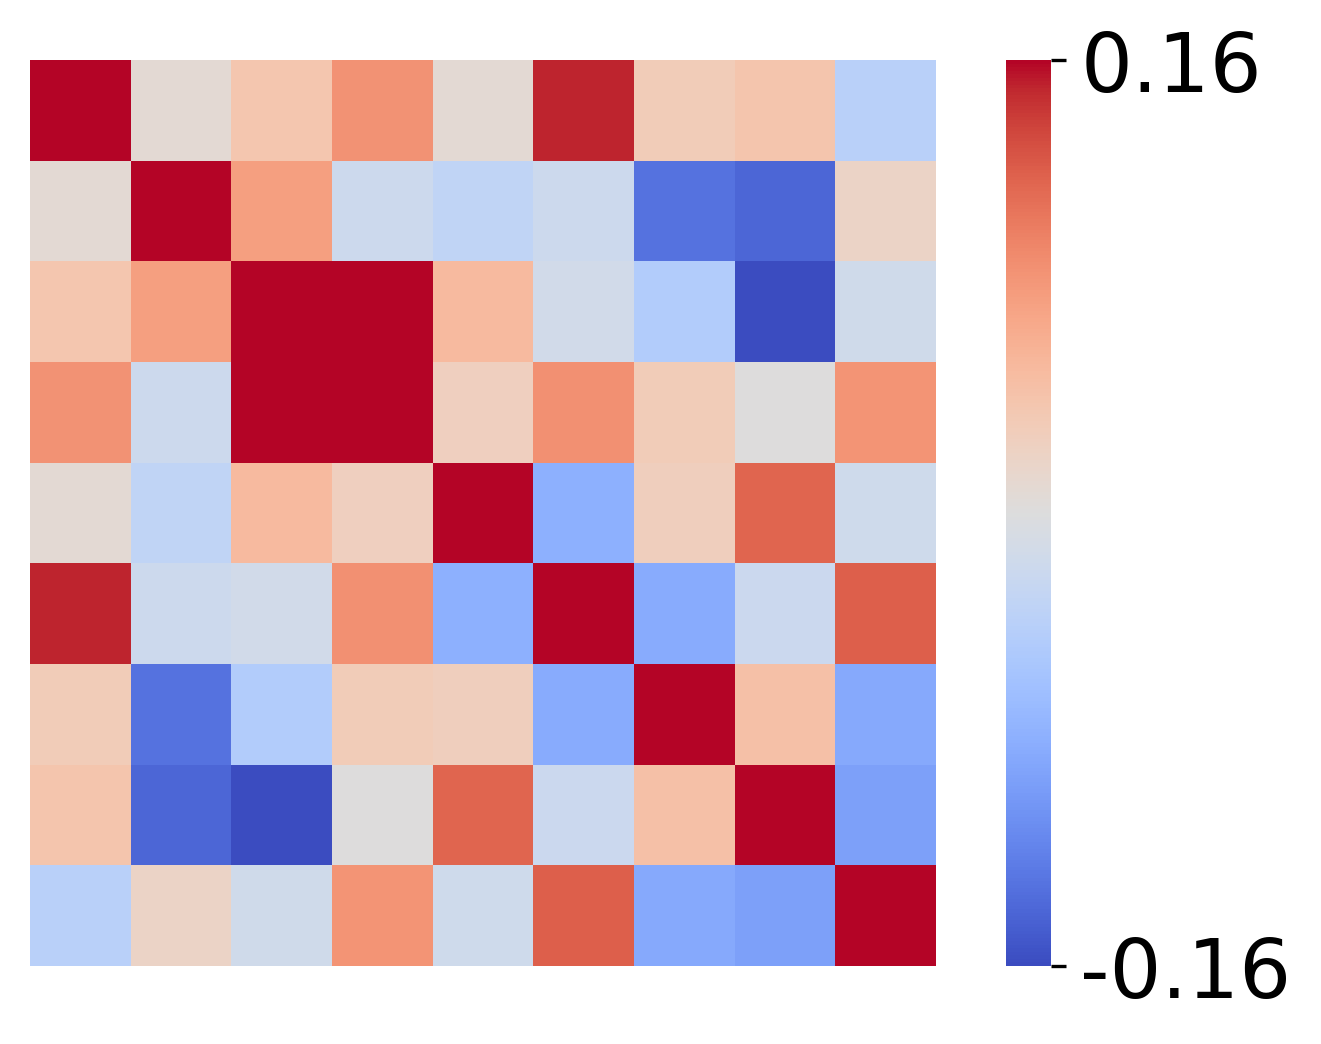

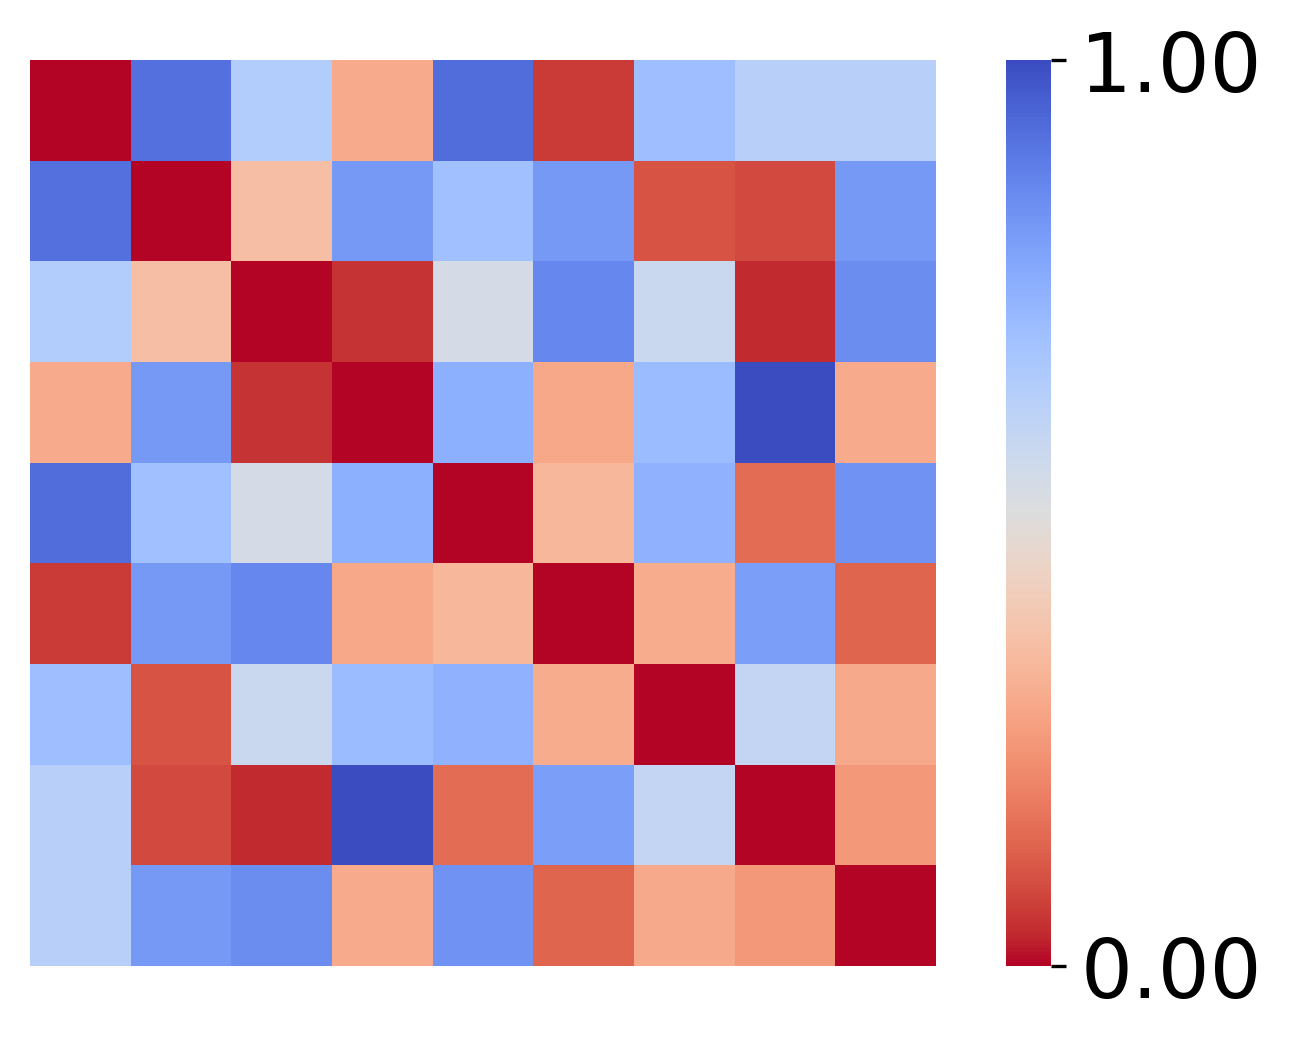

In [129]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(zeros_rewss, zeros_rewss, effs, effs, "Rewards", "Rewards", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)


In [130]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_rewards_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_task2_rewards_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_rewards_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_task2_rewards_zeros.svg'))

### Stats

In [131]:
from human_utils_behavioral_analysis import compute_2D_correlation_matrices

data_obs_corr_g1, data_obs_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['n_observes'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_obs_corr_g2, data_obs_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['n_observes'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_rews_corr_g1, data_rews_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['rewards_tallies'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_rews_corr_g2, data_rews_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['rewards_tallies'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_sleeps_corr_g1, data_sleeps_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group']]['n_sleeps'].values), np.stack(df[~df['group']]['n_sleeps'].values), np.stack(df[~df['group']]['effs'].values), np.stack(df[~df['group']]['effs'].values),)
data_sleeps_corr_g2, data_sleeps_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group']]['n_sleeps'].values), np.stack(df[df['group']]['n_sleeps'].values), np.stack(df[df['group']]['effs'].values), np.stack(df[df['group']]['effs'].values),)

data_obs_corr = (~df['group']).sum() / len(df) * data_obs_corr_g1 + (df['group']).sum() / len(df) * data_obs_corr_g2
data_obs_pvs = (~df['group']).sum() / len(df) * data_obs_pvs_g1 + (df['group']).sum() / len(df) * data_obs_pvs_g2

data_rews_corr = (~df['group']).sum() / len(df) * data_rews_corr_g1 + (df['group']).sum() / len(df) * data_rews_corr_g2
data_rews_pvs = (~df['group']).sum() / len(df) * data_rews_pvs_g1 + (df['group']).sum() / len(df) * data_rews_pvs_g2

data_sleeps_corr = (~df['group']).sum() / len(df) * data_sleeps_corr_g1 + (df['group']).sum() / len(df) * data_sleeps_corr_g2
data_sleeps_pvs = (~df['group']).sum() / len(df) * data_sleeps_pvs_g1 + (df['group']).sum() / len(df) * data_sleeps_pvs_g2


sim_obs_corr, sim_obs_pvs = compute_2D_correlation_matrices(sim_obss, sim_obss, effs, effs,)
sim_rews_corr, sim_rews_pvs = compute_2D_correlation_matrices(sim_rewss, sim_rewss, effs, effs,)
sim_sleeps_corr, sim_sleeps_pvs = compute_2D_correlation_matrices(sim_sleepss, sim_sleepss, effs, effs,)
random_obs_corr, random_obs_pvs = compute_2D_correlation_matrices(random_obss, random_obss, effs, effs,)
random_rews_corr, random_rews_pvs = compute_2D_correlation_matrices(random_rewss, random_rewss, effs, effs,)
random_sleeps_corr, random_sleeps_pvs = compute_2D_correlation_matrices(random_sleepss, random_sleepss, effs, effs,)

zeros_obs_corr, zeros_obs_pvs = compute_2D_correlation_matrices(zeros_obss, zeros_obss, effs, effs,)
zeros_rews_corr, zeros_rews_pvs = compute_2D_correlation_matrices(zeros_rewss, zeros_rewss, effs, effs,)
zeros_sleeps_corr, zeros_sleeps_pvs = compute_2D_correlation_matrices(zeros_sleepss, zeros_sleepss, effs, effs,)

(46, 9)
(65, 9)
(46, 9)
(65, 9)
(46, 9)
(65, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)
(150, 9)


In [132]:
from human_utils_behavioral_analysis import competitive_corr_regression, upper_tri_masking

competitive_corr_regression(upper_tri_masking(data_rews_corr), [upper_tri_masking(sim_rews_corr), upper_tri_masking(random_rews_corr), upper_tri_masking(zeros_rews_corr)])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                    0.1667
Date:                Mon, 07 Oct 2024   Prob (F-statistic):              0.918
Time:                        15:54:45   Log-Likelihood:                 26.559
No. Observations:                  36   AIC:                            -45.12
Df Residuals:                      32   BIC:                            -38.78
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1105      0.027      4.047      0.0

#### Cosine Similarity

In [133]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(upper_tri_masking(data_rews_corr).reshape((1,-1)), upper_tri_masking(sim_rews_corr).reshape((1,-1)))[0][0])
print(cosine_similarity(upper_tri_masking(data_rews_corr).reshape((1,-1)), upper_tri_masking(random_rews_corr).reshape((1,-1)))[0][0])

0.4083015073544655
0.10255412104940596


## Panel F: Across-Tasks Behavior Sleep / Observes
### Humans

In [134]:
from human_utils_project import get_clean_data

day = 'day3'
exp_date = '24-01-22-29'

group = None

df_day1, effs_train_day1, effs_test_day1, test_start_day1 = get_clean_data(day=1, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group= group, file_base=human_data_file_base)
df_day2, effs_train_day2, effs_test_day2, test_start_day2 = get_clean_data(day=2, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)
df_day3, effs_train_day3, effs_test_day3, test_start_day3 = get_clean_data(day=3, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)
effs = np.arange(0, 1.01, 0.125)
n_steps = 50

## WITH INNER JOIN SO THAT ONLY ROWS FROM ALL THREE DAYS ARE KEPT
df = df_day1.join(df_day2, how='inner', lsuffix='_day1', rsuffix='_day2')
df = df.join(df_day3.rename(columns=lambda x: f"{x}_day3"), how='inner')


          n        r          CI95%    p-val
pearson  46  0.16779  [-0.13, 0.44]  0.27058
          n         r          CI95%     p-val
pearson  46  0.218663  [-0.08, 0.48]  0.148995
          n         r          CI95%     p-val
pearson  46  0.168621  [-0.13, 0.44]  0.268179
          n         r          CI95%     p-val
pearson  46  0.262189  [-0.03, 0.52]  0.081875
          n         r          CI95%     p-val
pearson  46  0.132778  [-0.17, 0.41]  0.384575
          n         r          CI95%    p-val
pearson  46  0.075988  [-0.22, 0.36]  0.61981
          n         r         CI95%     p-val
pearson  46  0.329154  [0.04, 0.57]  0.027256
          n         r          CI95%     p-val
pearson  46  0.248897  [-0.05, 0.51]  0.099203
          n         r         CI95%     p-val
pearson  46  0.339197  [0.05, 0.58]  0.022642
          n        r         CI95%     p-val
pearson  46  0.11899  [-0.18, 0.4]  0.436261
          n         r          CI95%     p-val
pearson  46 -0.077177  [-0.

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r        CI95%     p-val
pearson  46  0.297482  [0.0, 0.54]  0.047189
          n         r          CI95%     p-val
pearson  46  0.214061  [-0.08, 0.48]  0.157955
          n         r          CI95%     p-val
pearson  46  0.270071  [-0.03, 0.52]  0.072779
          n         r         CI95%     p-val
pearson  46  0.095375  [-0.2, 0.38]  0.533143
          n         r         CI95%    p-val
pearson  46  0.356962  [0.07, 0.59]  0.01608
          n         r          CI95%     p-val
pearson  46  0.276113  [-0.02, 0.53]  0.066361
          n         r         CI95%     p-val
pearson  46  0.473642  [0.21, 0.67]  0.001015
          n         r          CI95%     p-val
pearson  46  0.264627  [-0.03, 0.52]  0.078972
          n         r          CI95%     p-val
pearson  46  0.268427  [-0.03, 0.52]  0.074607
          n         r         CI95%     p-val
pearson  46  0.338951  [0.05, 0.58]  0.022747
          n         r          CI95%     p-val
pearson  46  0.076574  [-0.

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n        r         CI95%     p-val
pearson  65  0.05385  [-0.19, 0.3]  0.672575
          n        r          CI95%     p-val
pearson  65  0.08722  [-0.16, 0.33]  0.493145
          n         r          CI95%     p-val
pearson  65  0.101621  [-0.15, 0.34]  0.424282
          n         r          CI95%     p-val
pearson  65  0.097058  [-0.15, 0.33]  0.445486
          n         r          CI95%     p-val
pearson  65  0.004713  [-0.24, 0.25]  0.970514
          n         r          CI95%     p-val
pearson  65 -0.030626  [-0.27, 0.22]  0.810148
          n         r          CI95%     p-val
pearson  65 -0.098684  [-0.34, 0.15]  0.437861
          n        r          CI95%     p-val
pearson  65 -0.01071  [-0.26, 0.24]  0.933063
          n         r          CI95%     p-val
pearson  65 -0.017129  [-0.26, 0.23]  0.893134
          n         r          CI95%     p-val
pearson  65  0.231361  [-0.02, 0.45]  0.065848
          n         r          CI95%     p-val
pearson  65  0.012362

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r         CI95%     p-val
pearson  65  0.056846  [-0.19, 0.3]  0.655478
          n         r          CI95%     p-val
pearson  65  0.071154  [-0.18, 0.31]  0.576349
          n         r          CI95%     p-val
pearson  65 -0.073838  [-0.31, 0.18]  0.562014
          n         r          CI95%     p-val
pearson  65 -0.209332  [-0.43, 0.04]  0.096895
          n         r          CI95%     p-val
pearson  65 -0.191526  [-0.42, 0.06]  0.129499
          n         r          CI95%     p-val
pearson  65 -0.098985  [-0.34, 0.15]  0.436458
          n         r          CI95%    p-val
pearson  65 -0.239078  [-0.46, 0.01]  0.05709
          n         r         CI95%     p-val
pearson  65  0.301446  [0.06, 0.51]  0.015493
          n         r          CI95%     p-val
pearson  65  0.163982  [-0.09, 0.39]  0.195393
          n         r          CI95%     p-val
pearson  65  0.232545  [-0.01, 0.45]  0.064439
          n         r          CI95%    p-val
pearson  65  0.07311

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

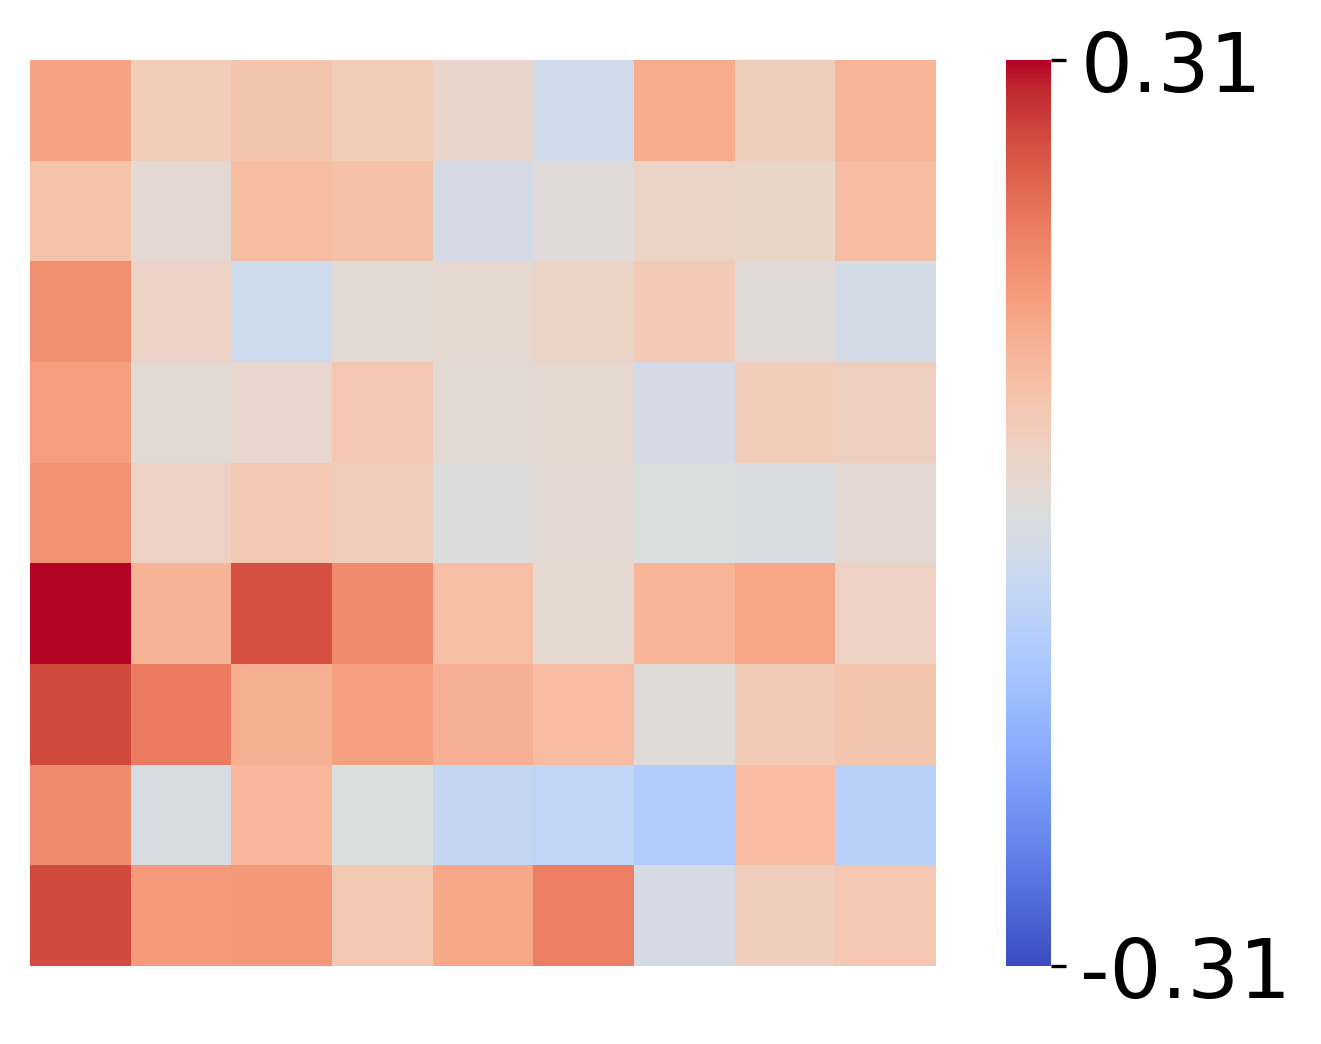

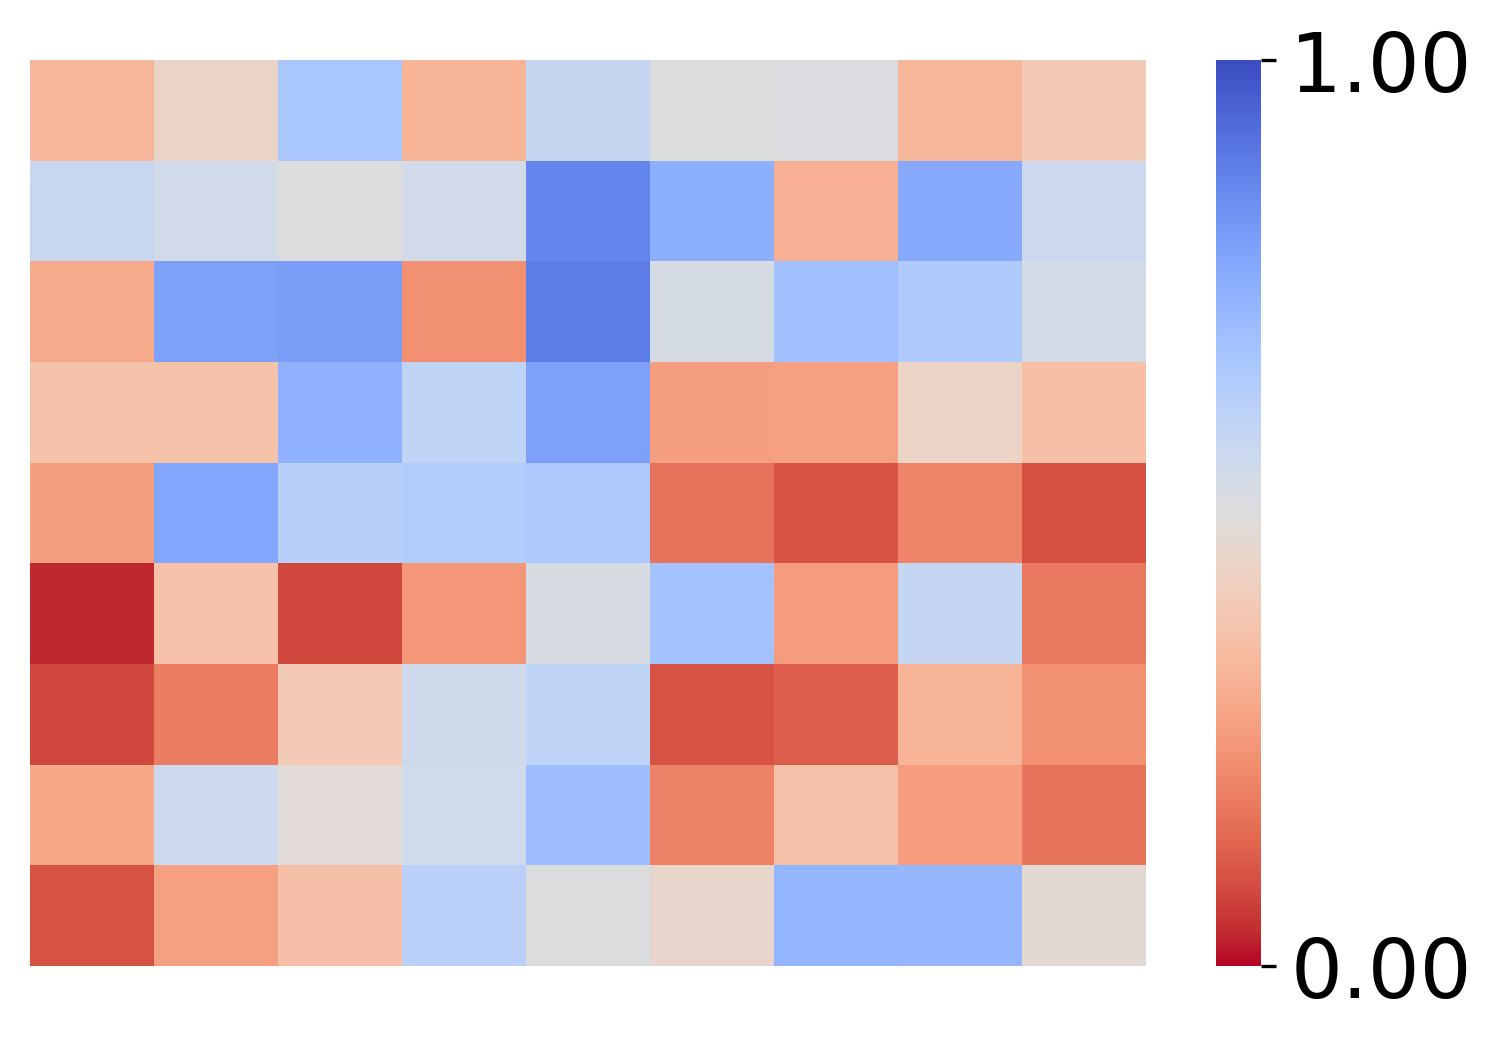

In [135]:
from human_utils_behavioral_analysis import compute_partial_2D_correlation, compute_2D_correlation

corr_fig, pvs_fig = compute_partial_2D_correlation(df['n_observes_day2'], df['n_sleeps_day3'], df['n_observes_day3'], df['effs_day2'], df['effs_day3'], df['effs_day3'], semi=False, col1name = 'Observes Task 1', col2name = 'Sleeps Task 2', annot=False, resize_colorbar=True, groups=df['group_day1'], square=square, axes_off=axes_off, font_size_multiplier=1.4)


In [136]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_humans_partialed.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_humans_partialed.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_humans_partialed.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_humans_partialed.svg'))

# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_humans.png'))
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_humans.svg'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_humans.png'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_humans.svg'))

### Trait-Level Perturbations

In [137]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t1 as sim_timestamp

sim_rewss_t1, sim_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss_t1 = sim_rewss_t1.mean(axis=0)
sim_obss_t1 = sim_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss_t1 = np.flip(sim_rewss_t1.T, axis=1)
sim_obss_t1 = np.flip(sim_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t2 as sim_timestamp

effs_sorted = effs = np.arange(0, 1.01, 0.125)

sim_rewss_t2, sim_obss_t2, sim_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss_t2 = sim_rewss_t2.mean(axis=0)
sim_obss_t2 = sim_obss_t2.mean(axis=0)
sim_sleepss_t2 = sim_sleepss_t2.mean(axis=0)


## correcting for switching from tau to efficacy
sim_rewss_t2 = np.flip(sim_rewss_t2.T, axis=1)
sim_obss_t2 = np.flip(sim_obss_t2.T, axis=1)
sim_sleepss_t2 = np.flip(sim_sleepss_t2.T, axis=1)

(150, 9)
           n         r         CI95%         p-val
pearson  150  0.594518  [0.48, 0.69]  1.310298e-15
           n         r       CI95%         p-val
pearson  150  0.609794  [0.5, 0.7]  1.532026e-16
           n         r         CI95%         p-val
pearson  150  0.621243  [0.51, 0.71]  2.838481e-17
           n         r         CI95%         p-val
pearson  150  0.601038  [0.49, 0.69]  5.316430e-16
           n         r         CI95%         p-val
pearson  150  0.450248  [0.31, 0.57]  8.347274e-09
           n         r          CI95%     p-val
pearson  150  0.051702  [-0.11, 0.21]  0.531175
           n       r           CI95%         p-val
pearson  150 -0.4051  [-0.53, -0.26]  2.980774e-07
           n         r           CI95%         p-val
pearson  150 -0.712272  [-0.78, -0.62]  2.316684e-24
           n         r           CI95%         p-val
pearson  150 -0.881342  [-0.91, -0.84]  1.013275e-49
           n         r         CI95%         p-val
pearson  150  0.497916  

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r         CI95%     p-val
pearson  150  0.292925  [0.14, 0.43]  0.000289
           n        r         CI95%    p-val
pearson  150  0.21548  [0.06, 0.36]  0.00831
           n         r          CI95%     p-val
pearson  150  0.120809  [-0.04, 0.28]  0.142205
           n         r          CI95%     p-val
pearson  150  0.021188  [-0.14, 0.18]  0.797579
           n         r          CI95%     p-val
pearson  150 -0.089039  [-0.25, 0.07]  0.280207
           n         r           CI95%     p-val
pearson  150 -0.201041  [-0.35, -0.04]  0.013952
           n         r           CI95%     p-val
pearson  150 -0.301028  [-0.44, -0.15]  0.000191
           n         r           CI95%         p-val
pearson  150 -0.415791  [-0.54, -0.27]  1.339291e-07
           n         r           CI95%         p-val
pearson  150 -0.540412  [-0.65, -0.42]  1.130874e-12
           n         r         CI95%     p-val
pearson  150  0.217689  [0.06, 0.37]  0.007655
           n         r    

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

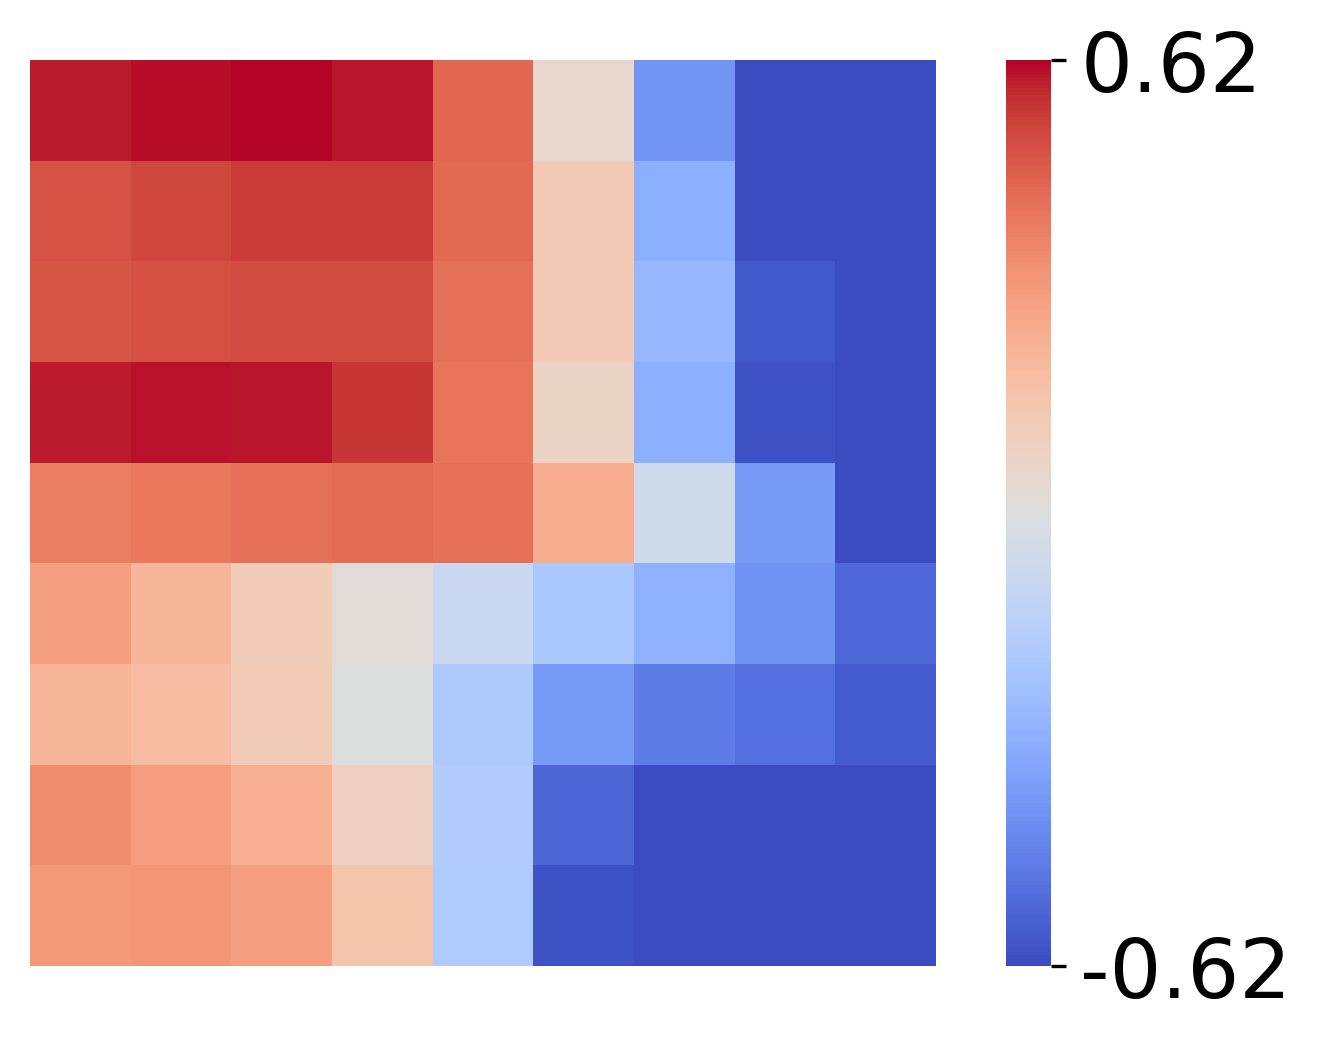

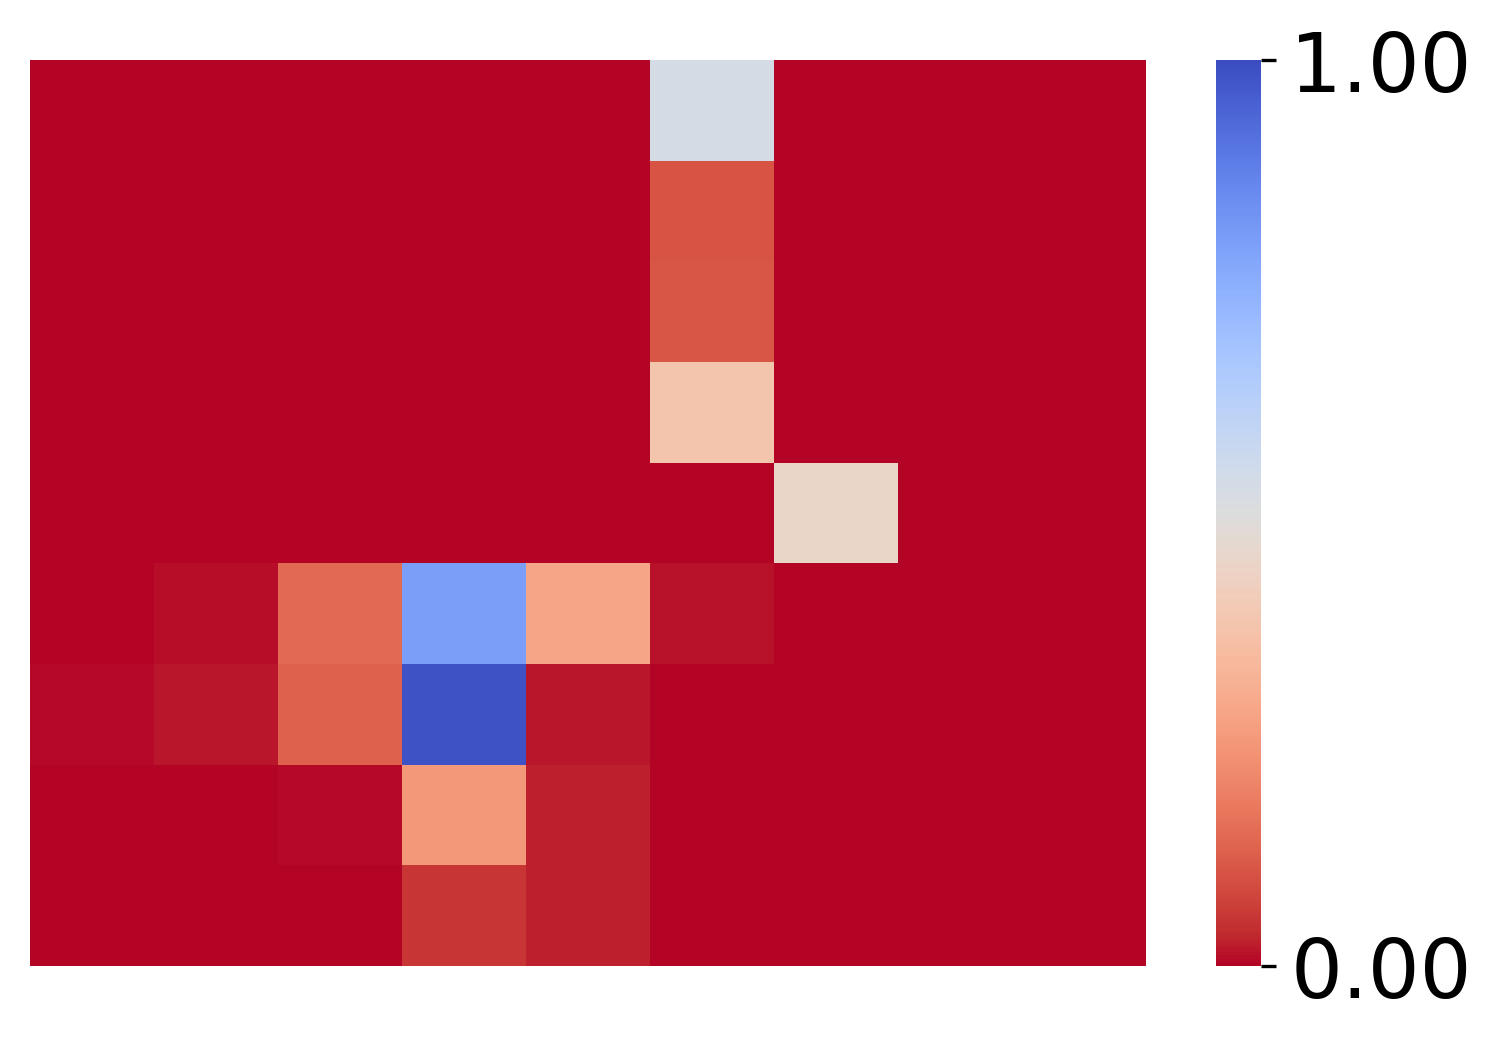

In [138]:
from human_utils_behavioral_analysis import compute_partial_2D_correlation

corr_fig, pvs_fig = compute_partial_2D_correlation(sim_obss_t1, sim_sleepss_t2, sim_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False, col1name = 'Observes Task 1', col2name = 'Sleeps Task 2', annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

#corr_fig, pvs_fig = compute_2D_correlation(sim_obss_t1.T, sim_sleepss_t2.T, effs_sorted, effs_sorted, col1name = 'Observes Task 1', col2name = 'Sleeps Task 2', annot=False)

In [139]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_trait_partialed.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_trait_partialed.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_trait_partialed.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_trait_partialed.svg'))

# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_trait.png'))
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_trait.svg'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_trait.png'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_trait.svg'))

### Random Perturbation

In [140]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t1 as sim_timestamp

random_rewss_t1, random_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

random_rewss_t1 = random_rewss_t1.mean(axis=0)
random_obss_t1 = random_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss_t1 = np.flip(random_rewss_t1.T, axis=1)
random_obss_t1 = np.flip(random_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

random_rewss_t2, random_obss_t2, random_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

## post-hoc adjustment to get rid of relationship across tasks - TODO: resample cleanly
rng = np.random.default_rng()
random_rewss_t2 = rng.permuted(random_rewss_t2, axis=-1)
random_obss_t2 = rng.permuted(random_obss_t2, axis=-1)
random_sleepss_t2 = rng.permuted(random_sleepss_t2, axis=-1)

random_rewss_t2 = random_rewss_t2.mean(axis=0)
random_obss_t2 = random_obss_t2.mean(axis=0)
random_sleepss_t2 = random_sleepss_t2.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss_t2 = np.flip(random_rewss_t2.T, axis=1)
random_obss_t2 = np.flip(random_obss_t2.T, axis=1)
random_sleepss_t2 = np.flip(random_sleepss_t2.T, axis=1)

(150, 9)
           n         r          CI95%    p-val
pearson  150  0.129486  [-0.03, 0.28]  0.11551
           n        r          CI95%     p-val
pearson  150 -0.12778  [-0.28, 0.03]  0.120425
           n         r          CI95%     p-val
pearson  150 -0.020455  [-0.18, 0.14]  0.804434
           n         r         CI95%    p-val
pearson  150  0.059004  [-0.1, 0.22]  0.47474
           n         r          CI95%     p-val
pearson  150 -0.123914  [-0.28, 0.04]  0.132161
           n         r           CI95%     p-val
pearson  150 -0.177201  [-0.33, -0.02]  0.030623
           n         r          CI95%     p-val
pearson  150 -0.019968  [-0.18, 0.14]  0.809007
           n         r         CI95%    p-val
pearson  150  0.063615  [-0.1, 0.22]  0.44085
           n         r          CI95%     p-val
pearson  150  0.085784  [-0.08, 0.24]  0.298236
           n         r         CI95%     p-val
pearson  150  0.042527  [-0.12, 0.2]  0.606574
           n        r          CI95%     p-

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150 -0.017108  [-0.18, 0.14]  0.835943
           n         r          CI95%     p-val
pearson  150  0.094781  [-0.07, 0.25]  0.250226
           n         r         CI95%     p-val
pearson  150  0.044696  [-0.12, 0.2]  0.588327
           n         r          CI95%     p-val
pearson  150 -0.082504  [-0.24, 0.08]  0.317161
           n         r         CI95%     p-val
pearson  150 -0.044602  [-0.2, 0.12]  0.589115
           n         r         CI95%     p-val
pearson  150 -0.062682  [-0.22, 0.1]  0.447592
           n         r          CI95%    p-val
pearson  150 -0.105477  [-0.26, 0.06]  0.20046
           n         r          CI95%     p-val
pearson  150 -0.094304  [-0.25, 0.07]  0.252629
           n         r          CI95%     p-val
pearson  150  0.107561  [-0.05, 0.26]  0.191661
           n         r          CI95%     p-val
pearson  150 -0.134769  [-0.29, 0.03]  0.101277
           n         r          CI95%     p-val


/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

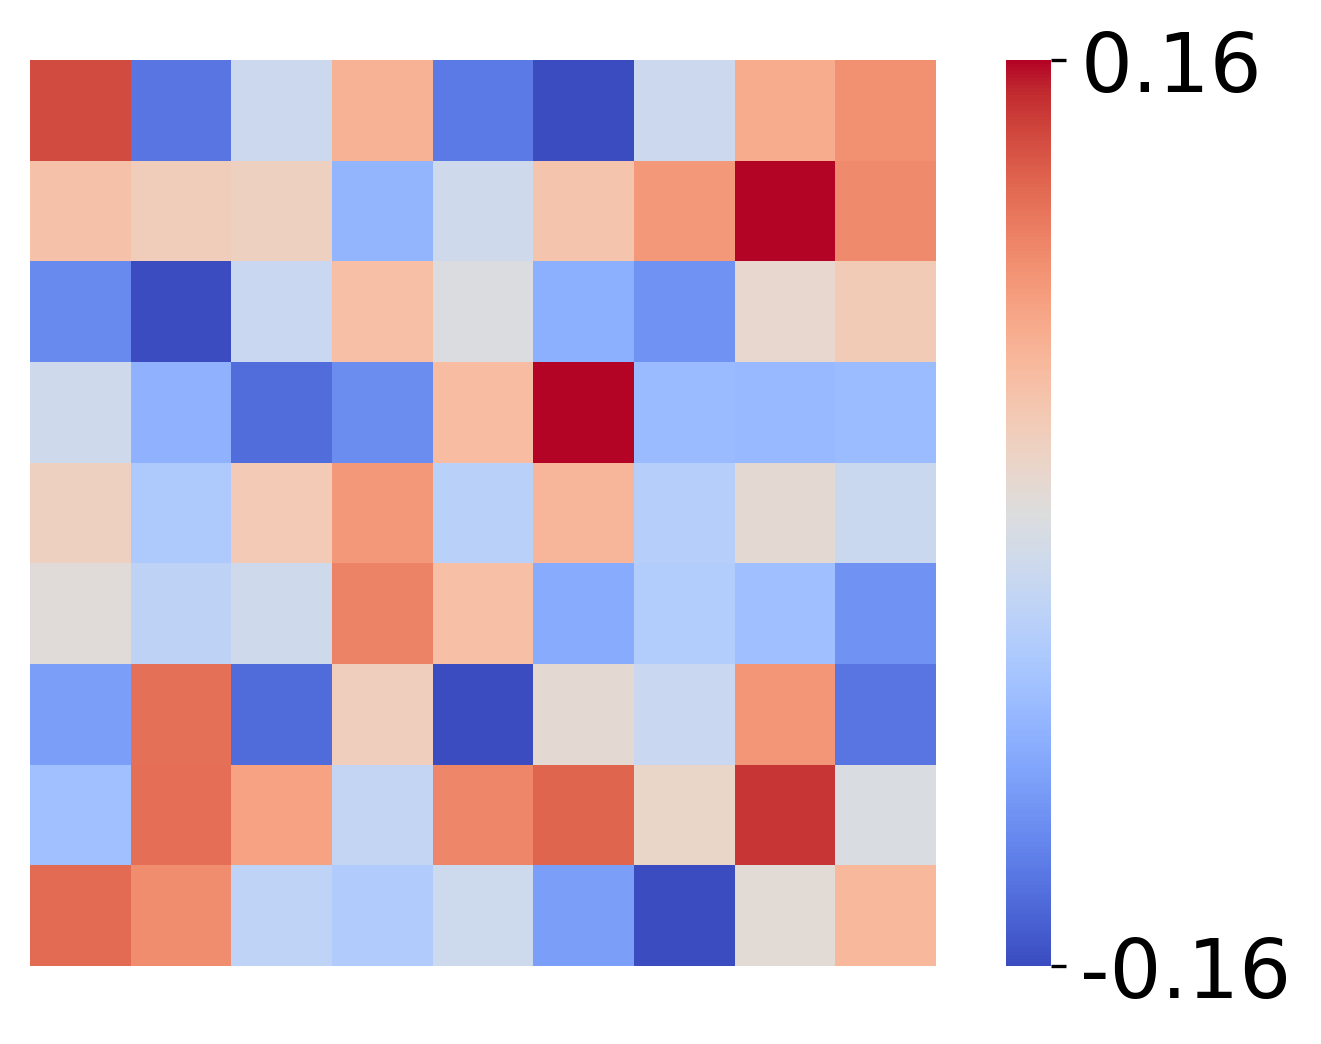

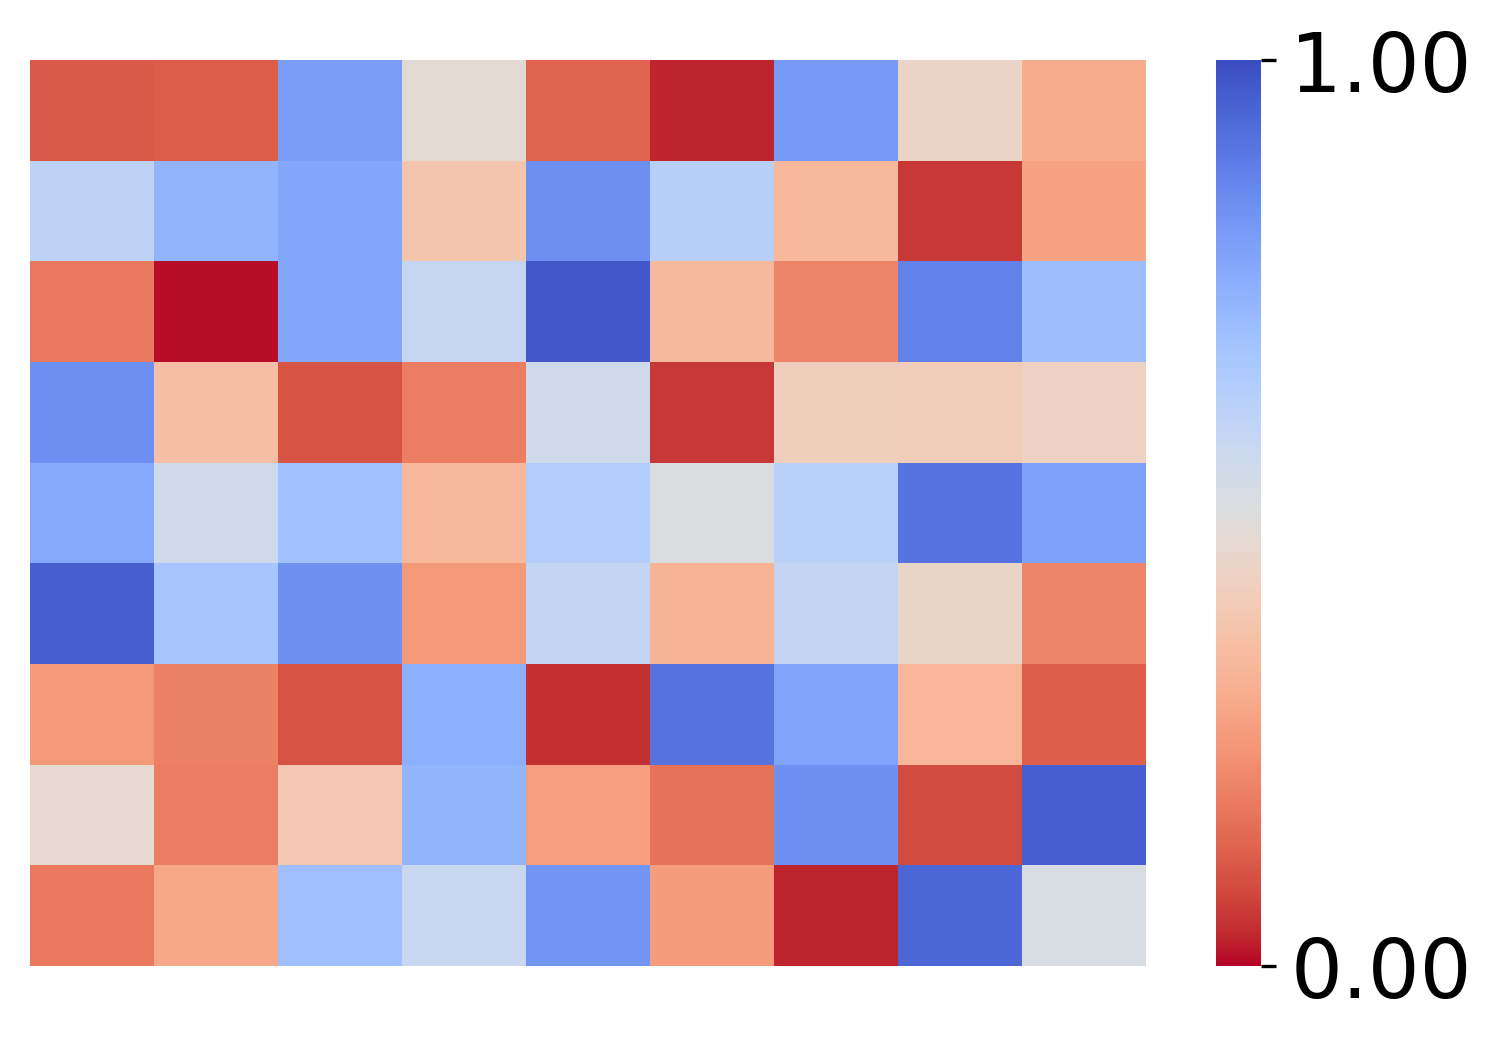

In [141]:
from human_utils_behavioral_analysis import compute_partial_2D_correlation, compute_2D_correlation

corr_fig, pvs_fig = compute_partial_2D_correlation(random_obss_t1, random_sleepss_t2, random_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False, col1name = 'Observes Task 1', col2name = 'Sleeps Task 2', annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

#corr_fig, pvs_fig = compute_2D_correlation(random_obss_t1.T, random_sleepss_t2.T, effs_sorted, effs_sorted, col1name = 'Observes Task 1', col2name = 'Sleeps Task 2', annot=False)

In [142]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random_partialed.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random_partialed.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random_partialed.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random_partialed.svg'))

# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random.png'))
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random.svg'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random.png'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random.svg'))

### Zeros Perturbations

In [143]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models

from settings_ana import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t1 as sim_timestamp

zeros_rewss_t1, zeros_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

zeros_rewss_t1 =zeros_rewss_t1.mean(axis=0)
zeros_obss_t1 = zeros_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss_t1 = np.flip(zeros_rewss_t1.T, axis=1)
zeros_obss_t1 = np.flip(zeros_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)
effs_sorted = np.arange(0, 1.01, 0.125)

zeros_rewss_t2, zeros_obss_t2,zeros_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

## TODO: Check to make sure this is no longer necessary
rng = np.random.default_rng()
zeros_rewss_t2 = rng.permuted(zeros_rewss_t2, axis=-1)
zeros_obss_t2 = rng.permuted(zeros_obss_t2, axis=-1)
zeros_sleepss_t2 = rng.permuted(zeros_sleepss_t2, axis=-1)

zeros_rewss_t2 = zeros_rewss_t2.mean(axis=0)
zeros_obss_t2 = zeros_obss_t2.mean(axis=0)
zeros_sleepss_t2 = zeros_sleepss_t2.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss_t2 = np.flip(zeros_rewss_t2.T, axis=1)
zeros_obss_t2 = np.flip(zeros_obss_t2.T, axis=1)
zeros_sleepss_t2 = np.flip(zeros_sleepss_t2.T, axis=1)

(150, 9)
           n         r          CI95%     p-val
pearson  150 -0.078724  [-0.24, 0.08]  0.339912
           n         r         CI95%     p-val
pearson  150  0.036165  [-0.13, 0.2]  0.661478
           n         r         CI95%     p-val
pearson  150  0.064833  [-0.1, 0.22]  0.432132
           n         r          CI95%     p-val
pearson  150 -0.106511  [-0.26, 0.06]  0.196059
           n        r          CI95%     p-val
pearson  150 -0.12348  [-0.28, 0.04]  0.133533
           n         r         CI95%     p-val
pearson  150 -0.035676  [-0.2, 0.13]  0.665775
           n         r         CI95%     p-val
pearson  150 -0.042283  [-0.2, 0.12]  0.608639
           n         r         CI95%     p-val
pearson  150 -0.150149  [-0.3, 0.01]  0.067587
           n         r          CI95%     p-val
pearson  150  0.105297  [-0.06, 0.26]  0.201235
           n         r          CI95%     p-val
pearson  150  0.119655  [-0.04, 0.28]  0.146085
           n         r          CI95%     p

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150 -0.014537  [-0.17, 0.15]  0.860327
           n         r          CI95%     p-val
pearson  150 -0.008358  [-0.17, 0.15]  0.919415
           n         r         CI95%     p-val
pearson  150 -0.061298  [-0.22, 0.1]  0.457704
           n         r          CI95%     p-val
pearson  150 -0.055861  [-0.21, 0.11]  0.498627
           n         r          CI95%     p-val
pearson  150 -0.015234  [-0.18, 0.15]  0.853696
           n         r          CI95%     p-val
pearson  150  0.079081  [-0.08, 0.24]  0.337718
           n         r         CI95%     p-val
pearson  150 -0.141584  [-0.3, 0.02]  0.084999
           n         r          CI95%     p-val
pearson  150  0.006985  [-0.15, 0.17]  0.932625
           n         r         CI95%     p-val
pearson  150 -0.036773  [-0.2, 0.12]  0.656146
           n         r          CI95%     p-val
pearson  150 -0.128271  [-0.28, 0.03]  0.118996
           n         r          CI95%     p-va

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

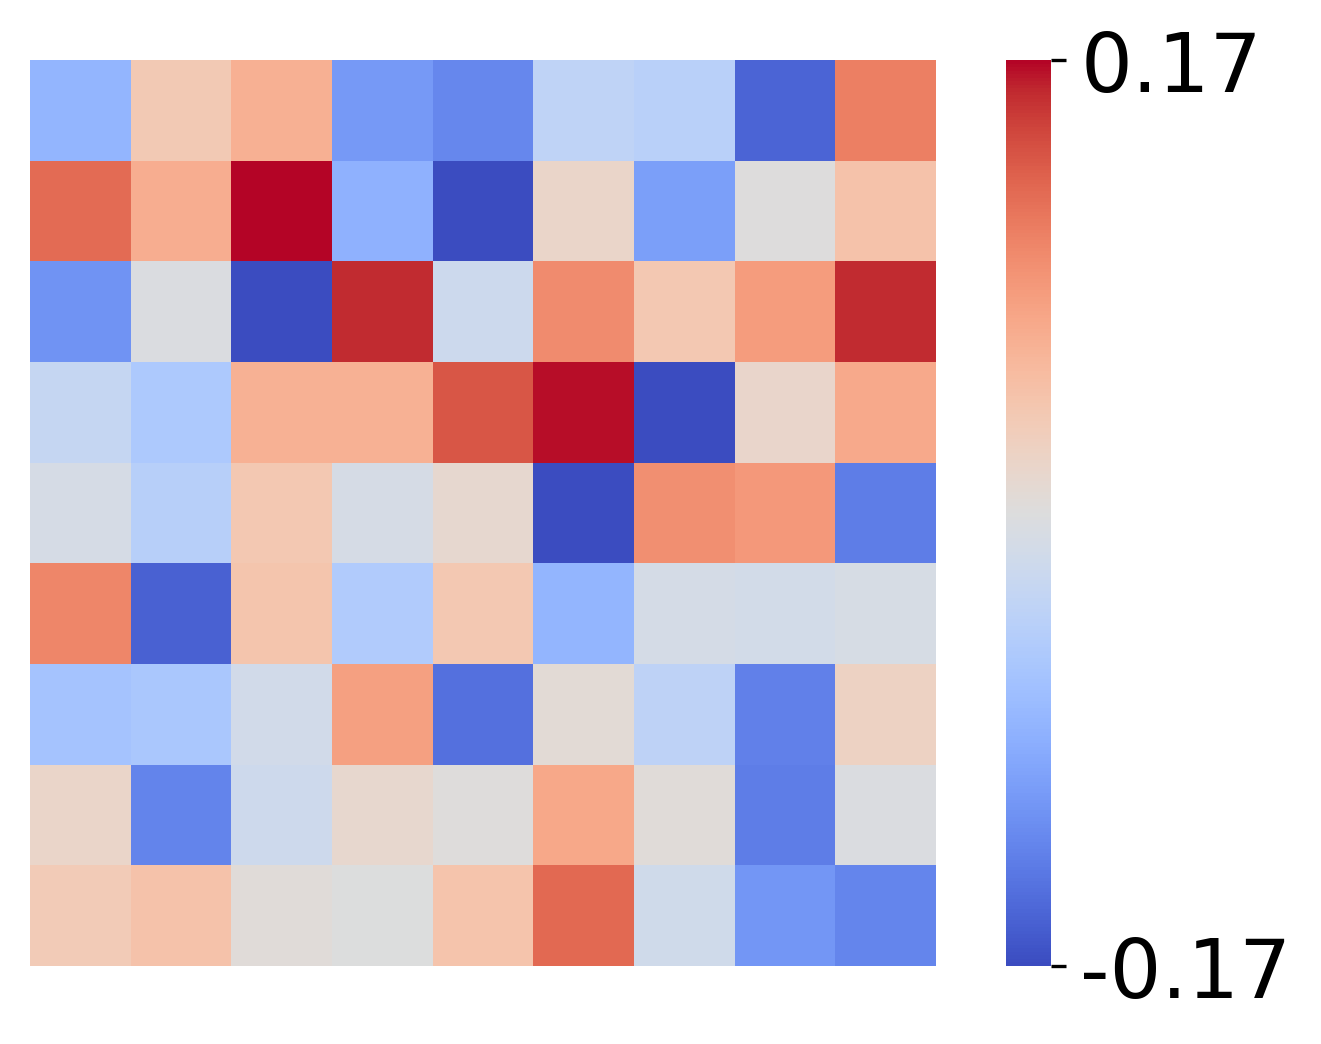

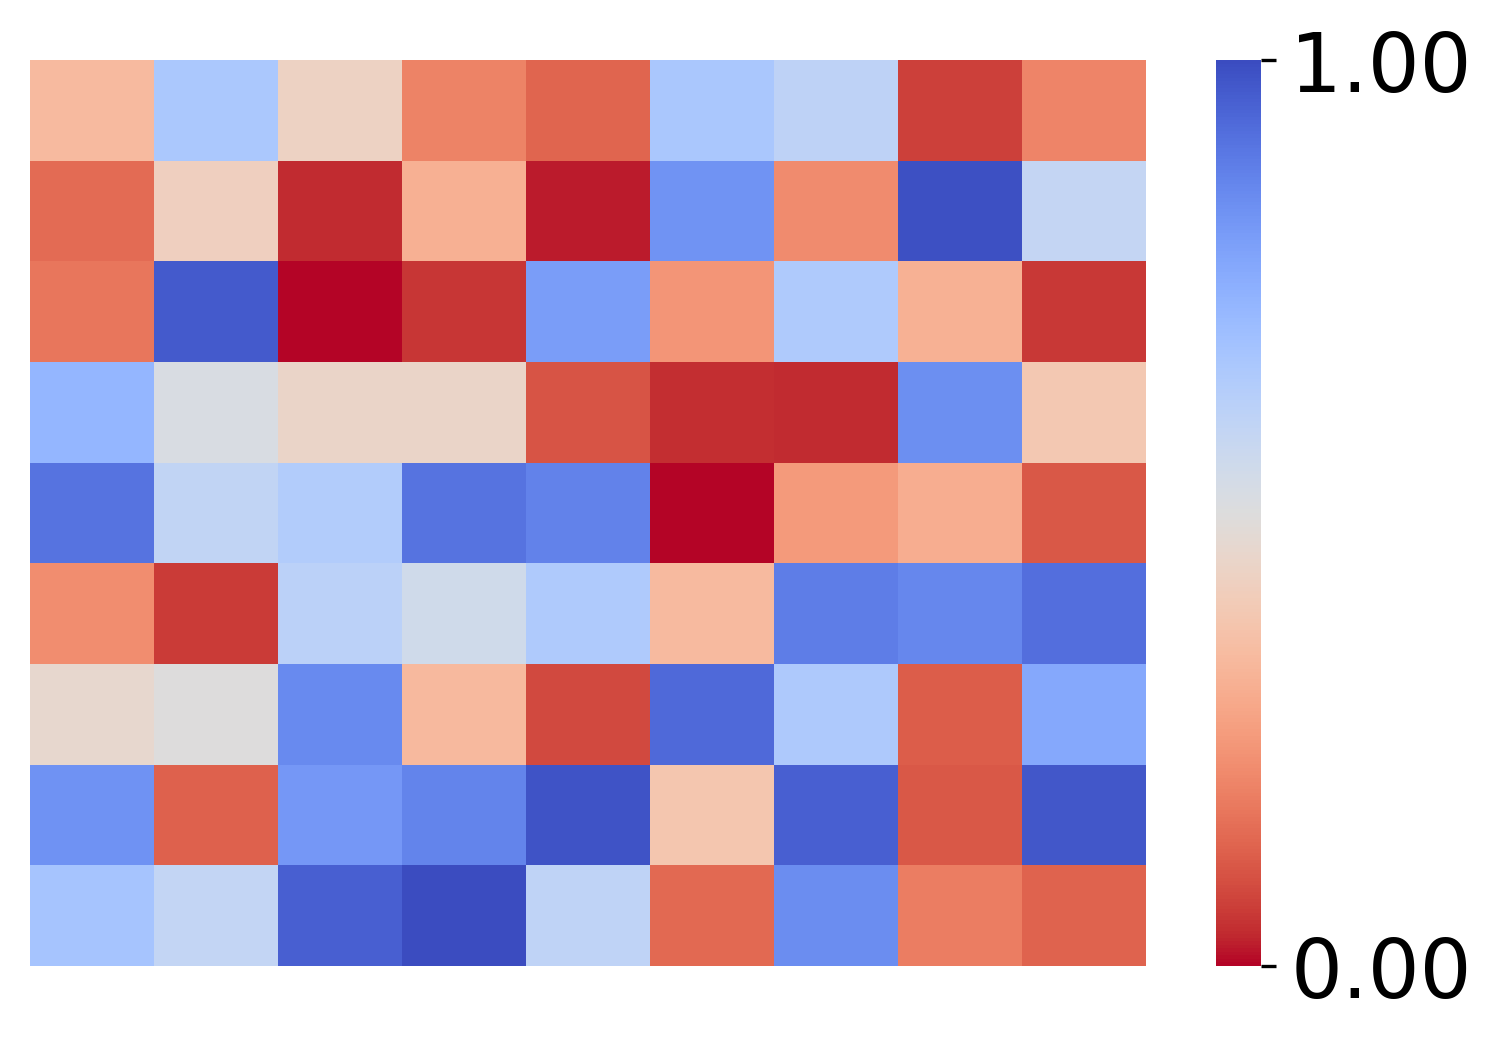

In [144]:
from human_utils_behavioral_analysis import compute_partial_2D_correlation, compute_2D_correlation

corr_fig, pvs_fig = compute_partial_2D_correlation(zeros_obss_t1, zeros_sleepss_t2, zeros_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False, col1name = 'Observes Task 1', col2name = 'Sleeps Task 2', annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

#corr_fig, pvs_fig = compute_2D_correlation(random_obss_t1.T, random_sleepss_t2.T, effs_sorted, effs_sorted, col1name = 'Observes Task 1', col2name = 'Sleeps Task 2', annot=False)

In [145]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_zeros_partialed.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_zeros_partialed.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_zeros_partialed.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_zeros_partialed.svg'))

# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random.png'))
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random.svg'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random.png'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random.svg'))

### Stats

In [146]:
df['group_day2']

104    False
105    False
106     True
108     True
114     True
       ...  
094    False
096     True
098     True
101     True
103     True
Name: group_day2, Length: 111, dtype: bool

In [147]:
from human_utils_behavioral_analysis import compute_2D_correlation_matrices, compute_partial_2D_correlation_matrices

## day 2
data_obs_corr_g1, data_obs_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group_day2']]['n_observes_day2'].values), np.stack(df[~df['group_day2']]['n_observes_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day3']]['effs_day3'].values),)
data_obs_corr_g2, data_obs_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group_day2']]['n_observes_day2'].values), np.stack(df[df['group_day2']]['n_observes_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day3']]['effs_day3'].values),)

data_rews_corr_g1, data_rews_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group_day2']]['rewards_tallies_day2'].values), np.stack(df[~df['group_day2']]['rewards_tallies_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day3']]['effs_day3'].values),)
data_rews_corr_g2, data_rews_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group_day2']]['rewards_tallies_day2'].values), np.stack(df[df['group_day2']]['rewards_tallies_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day3']]['effs_day3'].values),)

data_obs_corr = (~df['group_day2']).sum() / len(df) * data_obs_corr_g1 + (df['group_day2']).sum() / len(df) * data_obs_corr_g2
data_obs_pvs = (~df['group_day2']).sum() / len(df) * data_obs_pvs_g1 + (df['group_day2']).sum() / len(df) * data_obs_pvs_g2

data_rews_corr = (~df['group_day2']).sum() / len(df) * data_rews_corr_g1 + (df['group_day2']).sum() / len(df) * data_rews_corr_g2
data_rews_pvs = (~df['group_day2']).sum() / len(df) * data_rews_pvs_g1 + (df['group_day2']).sum() / len(df) * data_rews_pvs_g2

data_sleeps_corr_g1, data_sleeps_pvs_g1 = compute_partial_2D_correlation_matrices(np.stack(df[~df['group_day2']]['n_observes_day2'].values), np.stack(df[~df['group_day2']]['n_sleeps_day3'].values), np.stack(df[~df['group_day2']]['n_observes_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day2']]['effs_day3'].values), np.stack(df[~df['group_day2']]['effs_day3'].values), semi=False)
data_sleeps_corr_g2, data_sleeps_pvs_g2 = compute_partial_2D_correlation_matrices(np.stack(df[df['group_day2']]['n_observes_day2'].values), np.stack(df[df['group_day2']]['n_sleeps_day3'].values), np.stack(df[df['group_day2']]['n_observes_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day2']]['effs_day3'].values),np.stack(df[df['group_day2']]['effs_day3'].values),semi=False )
# data_sleeps_corr_g1, data_sleeps_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group_day2']]['n_observes_day2'].values), np.stack(df[~df['group_day2']]['n_sleeps_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day2']]['effs_day3'].values), )
# data_sleeps_corr_g2, data_sleeps_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group_day2']]['n_observes_day2'].values), np.stack(df[df['group_day2']]['n_sleeps_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day2']]['effs_day3'].values), )

data_sleeps_corr = (~df['group_day2']).sum() / len(df) * data_sleeps_corr_g1 + (df['group_day2']).sum() / len(df) * data_sleeps_corr_g2
data_sleeps_pvs = (~df['group_day2']).sum() / len(df) * data_sleeps_pvs_g1 + (df['group_day2']).sum() / len(df) * data_sleeps_pvs_g2

sim_obs_corr, sim_obs_pvs = compute_2D_correlation_matrices(sim_obss_t1, sim_obss_t2, effs, effs,)
sim_rews_corr, sim_rews_pvs = compute_2D_correlation_matrices(sim_rewss_t1, sim_rewss_t2, effs, effs,)
sim_sleeps_corr, sim_sleeps_pvs = compute_partial_2D_correlation_matrices(sim_obss_t1, sim_sleepss_t2, sim_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False,)
#sim_sleeps_corr, sim_sleeps_pvs = compute_2D_correlation_matrices(sim_obss_t1, sim_sleepss_t2, effs_sorted, effs_sorted)
random_obs_corr, random_obs_pvs = compute_2D_correlation_matrices(random_obss_t1, random_obss_t2, effs, effs,)
random_rews_corr, random_rews_pvs = compute_2D_correlation_matrices(random_rewss_t1, random_rewss_t2, effs, effs,)
random_sleeps_corr, random_sleeps_pvs = compute_partial_2D_correlation_matrices(random_obss_t1, random_sleepss_t2, random_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False,)
#random_sleeps_corr, random_sleeps_pvs = compute_2D_correlation_matrices(random_obss_t1, random_sleepss_t2, effs_sorted, effs_sorted,)

zeros_obs_corr, zeros_obs_pvs = compute_2D_correlation_matrices(zeros_obss_t1, zeros_obss_t2, effs, effs,)
zeros_rews_corr, zeros_rews_pvs = compute_2D_correlation_matrices(zeros_rewss_t1, zeros_rewss_t2, effs, effs,)
zeros_sleeps_corr, zeros_sleeps_pvs = compute_partial_2D_correlation_matrices(zeros_obss_t1, zeros_sleepss_t2, zeros_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False,)


(46, 9)
(65, 9)
(46, 9)
(65, 9)
(46, 9)
          n        r          CI95%    p-val
pearson  46  0.16779  [-0.13, 0.44]  0.27058
          n         r          CI95%     p-val
pearson  46  0.150584  [-0.15, 0.43]  0.323462
          n         r         CI95%    p-val
pearson  46  0.094526  [-0.2, 0.38]  0.53681
          n         r          CI95%     p-val
pearson  46 -0.085092  [-0.37, 0.21]  0.578374
          n         r          CI95%     p-val
pearson  46  0.185669  [-0.11, 0.45]  0.222046
          n         r          CI95%     p-val
pearson  46  0.275501  [-0.02, 0.53]  0.066991
          n         r          CI95%     p-val
pearson  46  0.113613  [-0.19, 0.39]  0.457417
          n         r          CI95%     p-val
pearson  46  0.135381  [-0.16, 0.41]  0.375241
          n         r          CI95%     p-val
pearson  46  0.025859  [-0.27, 0.32]  0.866102
          n         r          CI95%     p-val
pearson  46  0.260511  [-0.04, 0.51]  0.083923
          n         r       

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r          CI95%     p-val
pearson  46 -0.265001  [-0.52, 0.03]  0.078533
          n         r         CI95%    p-val
pearson  46  0.099403  [-0.2, 0.38]  0.51591
          n         r          CI95%     p-val
pearson  46  0.137246  [-0.16, 0.41]  0.368635
          n         r          CI95%     p-val
pearson  46 -0.105472  [-0.39, 0.19]  0.490481
          n         r          CI95%     p-val
pearson  46  0.078265  [-0.22, 0.36]  0.609332
          n         r          CI95%     p-val
pearson  46 -0.092073  [-0.38, 0.21]  0.547477
          n         r          CI95%     p-val
pearson  46  0.074225  [-0.22, 0.36]  0.627978
          n         r         CI95%     p-val
pearson  46 -0.100197  [-0.38, 0.2]  0.512545
          n         r          CI95%    p-val
pearson  46  0.287822  [-0.01, 0.54]  0.05521
          n         r          CI95%     p-val
pearson  46 -0.167634  [-0.44, 0.13]  0.271031
          n         r         CI95%     p-val
pearson  46  0.360507 

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r        CI95%     p-val
pearson  65  0.291698  [0.05, 0.5]  0.019351
          n         r          CI95%     p-val
pearson  65  0.234006  [-0.01, 0.45]  0.062733
          n         r         CI95%     p-val
pearson  65  0.269944  [0.03, 0.48]  0.030989
          n         r          CI95%     p-val
pearson  65 -0.103397  [-0.34, 0.15]  0.416187
          n        r          CI95%     p-val
pearson  65  0.08722  [-0.16, 0.33]  0.493145
          n        r          CI95%     p-val
pearson  65 -0.12848  [-0.36, 0.12]  0.311643
          n         r          CI95%     p-val
pearson  65  0.024056  [-0.22, 0.27]  0.850344
          n         r          CI95%    p-val
pearson  65  0.002273  [-0.24, 0.25]  0.98578
          n         r         CI95%     p-val
pearson  65  0.149846  [-0.1, 0.38]  0.237275
          n         r         CI95%     p-val
pearson  65  0.058251  [-0.19, 0.3]  0.647519
          n         r          CI95%     p-val
pearson  65 -0.026624  [-0.27

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r          CI95%     p-val
pearson  65 -0.220644  [-0.44, 0.03]  0.079769
          n         r          CI95%     p-val
pearson  65 -0.164349  [-0.39, 0.08]  0.194383
          n         r          CI95%    p-val
pearson  65 -0.095676  [-0.33, 0.15]  0.45202
          n         r          CI95%     p-val
pearson  65  0.010699  [-0.24, 0.26]  0.933127
          n        r          CI95%     p-val
pearson  65 -0.13858  [-0.37, 0.11]  0.274802
          n         r         CI95%    p-val
pearson  65 -0.054031  [-0.3, 0.19]  0.67154
          n         r          CI95%     p-val
pearson  65 -0.095346  [-0.33, 0.15]  0.453588
          n         r          CI95%     p-val
pearson  65 -0.030104  [-0.27, 0.22]  0.813328
          n         r          CI95%    p-val
pearson  65 -0.192279  [-0.42, 0.06]  0.12797
          n         r          CI95%     p-val
pearson  65 -0.098985  [-0.34, 0.15]  0.436458
          n         r          CI95%     p-val
pearson  65 -0.190797  

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r           CI95%     p-val
pearson  150 -0.201041  [-0.35, -0.04]  0.013952
           n         r           CI95%         p-val
pearson  150 -0.642417  [-0.73, -0.54]  1.039752e-18
           n         r           CI95%         p-val
pearson  150 -0.810941  [-0.86, -0.75]  4.930588e-36
           n         r           CI95%         p-val
pearson  150 -0.855159  [-0.89, -0.81]  8.628028e-44
           n         r           CI95%         p-val
pearson  150 -0.514216  [-0.62, -0.39]  1.977029e-11
           n         r           CI95%         p-val
pearson  150 -0.456017  [-0.57, -0.32]  5.085399e-09
           n         r          CI95%     p-val
pearson  150 -0.354103  [-0.49, -0.2]  0.000009
           n         r           CI95%     p-val
pearson  150 -0.285463  [-0.43, -0.13]  0.000417
           n         r           CI95%     p-val
pearson  150 -0.173572  [-0.33, -0.01]  0.034263
           n         r           CI95%     p-val
pearson  150 -0.230058  [-0.38,

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

(150, 9)
           n         r          CI95%    p-val
pearson  150  0.129486  [-0.03, 0.28]  0.11551
           n         r          CI95%     p-val
pearson  150  0.028098  [-0.13, 0.19]  0.733741
           n         r          CI95%     p-val
pearson  150 -0.112378  [-0.27, 0.05]  0.172404
           n         r          CI95%     p-val
pearson  150 -0.022242  [-0.18, 0.14]  0.787744
           n         r          CI95%     p-val
pearson  150  0.011139  [-0.15, 0.17]  0.892745
           n         r          CI95%     p-val
pearson  150  0.003142  [-0.16, 0.16]  0.969664
           n         r          CI95%    p-val
pearson  150 -0.098548  [-0.26, 0.06]  0.23181
           n         r         CI95%     p-val
pearson  150 -0.060749  [-0.22, 0.1]  0.461746
           n         r          CI95%     p-val
pearson  150  0.110471  [-0.05, 0.27]  0.179847
           n         r          CI95%     p-val
pearson  150 -0.126115  [-0.28, 0.04]  0.125377
           n        r          CI95% 

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150  0.112028  [-0.05, 0.27]  0.173751
           n         r          CI95%     p-val
pearson  150 -0.093631  [-0.25, 0.07]  0.256046
           n         r          CI95%     p-val
pearson  150 -0.012413  [-0.17, 0.15]  0.880564
           n         r          CI95%     p-val
pearson  150  0.079292  [-0.08, 0.24]  0.336428
           n         r          CI95%     p-val
pearson  150 -0.104274  [-0.26, 0.06]  0.205672
           n         r          CI95%     p-val
pearson  150 -0.079597  [-0.24, 0.08]  0.334566
           n         r         CI95%     p-val
pearson  150 -0.038193  [-0.2, 0.12]  0.643763
           n         r         CI95%     p-val
pearson  150 -0.043958  [-0.2, 0.12]  0.594507
           n         r          CI95%     p-val
pearson  150 -0.022574  [-0.18, 0.14]  0.784652
           n         r          CI95%     p-val
pearson  150  0.009366  [-0.15, 0.17]  0.909744
           n         r           CI95%     p

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

(150, 9)
           n         r          CI95%     p-val
pearson  150 -0.078724  [-0.24, 0.08]  0.339912
           n         r          CI95%     p-val
pearson  150  0.123447  [-0.04, 0.28]  0.133635
           n         r          CI95%     p-val
pearson  150 -0.115521  [-0.27, 0.05]  0.160636
           n         r          CI95%    p-val
pearson  150 -0.031018  [-0.19, 0.13]  0.70727
           n         r          CI95%     p-val
pearson  150  0.002002  [-0.16, 0.16]  0.980664
           n         r          CI95%     p-val
pearson  150  0.096542  [-0.07, 0.25]  0.241497
           n         r         CI95%     p-val
pearson  150 -0.065122  [-0.22, 0.1]  0.430075
           n         r          CI95%     p-val
pearson  150  0.020061  [-0.14, 0.18]  0.808134
           n         r          CI95%     p-val
pearson  150  0.031982  [-0.13, 0.19]  0.698608
           n         r          CI95%     p-val
pearson  150  0.017435  [-0.14, 0.18]  0.832856
           n         r          CI9

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150  0.104771  [-0.06, 0.26]  0.203504
           n         r         CI95%     p-val
pearson  150  0.165697  [0.01, 0.32]  0.043431
           n         r         CI95%    p-val
pearson  150 -0.258143  [-0.4, -0.1]  0.00148
           n         r          CI95%     p-val
pearson  150 -0.078414  [-0.24, 0.08]  0.341821
           n         r          CI95%     p-val
pearson  150  0.008411  [-0.15, 0.17]  0.918906
           n         r          CI95%     p-val
pearson  150  0.077995  [-0.08, 0.24]  0.344415
           n        r          CI95%     p-val
pearson  150  0.10934  [-0.05, 0.27]  0.184374
           n         r         CI95%     p-val
pearson  150 -0.044658  [-0.2, 0.12]  0.588646
           n         r          CI95%     p-val
pearson  150 -0.098331  [-0.26, 0.06]  0.232841
           n         r         CI95%     p-val
pearson  150  0.040103  [-0.12, 0.2]  0.627259
           n         r           CI95%     p-val
pea

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

In [148]:
from human_utils_behavioral_analysis import competitive_corr_regression

competitive_corr_regression((data_sleeps_corr), [(sim_sleeps_corr), (random_sleeps_corr), (zeros_sleeps_corr)])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.698
Date:                Mon, 07 Oct 2024   Prob (F-statistic):             0.0516
Time:                        15:54:53   Log-Likelihood:                 84.017
No. Observations:                  81   AIC:                            -160.0
Df Residuals:                      77   BIC:                            -150.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0473      0.010      4.635      0.0

#### Cosine Similarity

In [149]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(data_sleeps_corr.reshape((1,-1)), sim_sleeps_corr.reshape((1,-1)))[0][0])
print(cosine_similarity(data_sleeps_corr.reshape((1,-1)), random_sleeps_corr.reshape((1,-1)))[0][0])

0.22175647807818658
-0.025863712719028275


#### Check if sum of partialed correlation is significantly different from zero

In [150]:
from scipy.stats import ttest_1samp

data_sleeps_corr_flattened = data_sleeps_corr.flatten()

print("Mean", np.mean(data_sleeps_corr_flattened))
print("StdErr", np.mean(data_sleeps_corr_flattened)/np.sqrt(len(data_sleeps_corr_flattened)))

t_stat, p_value = ttest_1samp(data_sleeps_corr_flattened, 0)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("The mean of data_sleeps_corr is statistically different from 0.")
else:
    print("There is no statistical difference between the mean of data_sleeps_corr and 0.")

Mean 0.03916087492781406
StdErr 0.004351208325312673
T-statistic: 3.92895826092211
P-value: 0.0001800806689667412
The mean of data_sleeps_corr is statistically different from 0.


## Panel F v2: Across-Tasks Behavior Sleep / Observes Unpartialed
### Humans

In [151]:
from human_utils_project import get_clean_data


day = 'day3'
exp_date = '24-01-22-29'

group = None

df_day1, effs_train_day1, effs_test_day1, test_start_day1 = get_clean_data(day=1, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group= group, file_base=human_data_file_base)
df_day2, effs_train_day2, effs_test_day2, test_start_day2 = get_clean_data(day=2, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)
df_day3, effs_train_day3, effs_test_day3, test_start_day3 = get_clean_data(day=3, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)
effs = np.arange(0, 1.01, 0.125)
n_steps = 50

## WITH INNER JOIN SO THAT ONLY ROWS FROM ALL THREE DAYS ARE KEPT
df = df_day1.join(df_day2, how='inner', lsuffix='_day1', rsuffix='_day2')
df = df.join(df_day3.rename(columns=lambda x: f"{x}_day3"), how='inner')


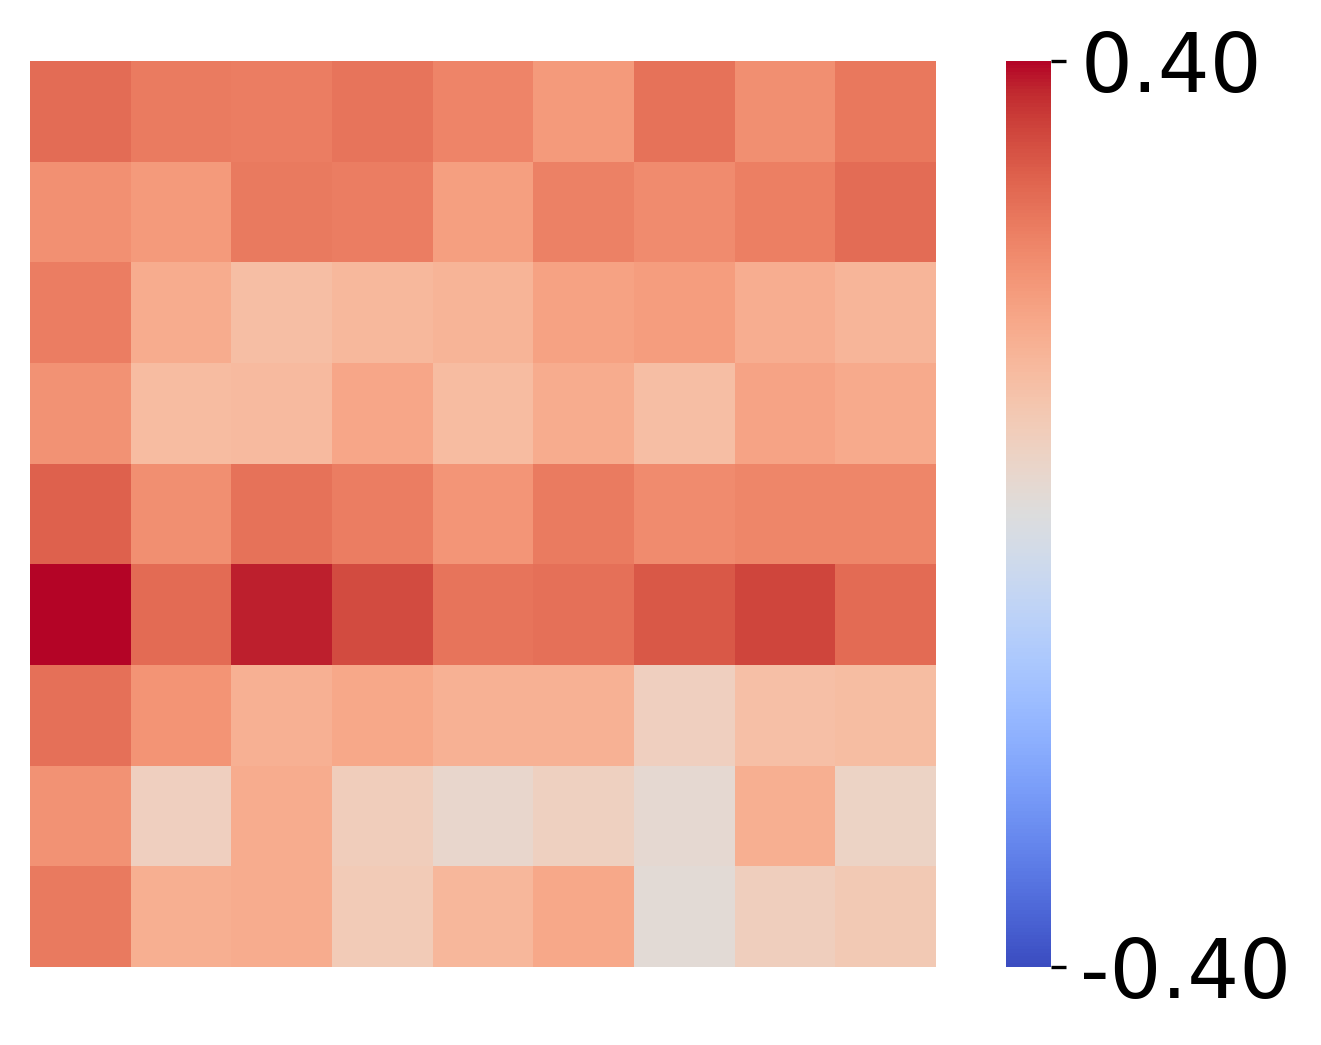

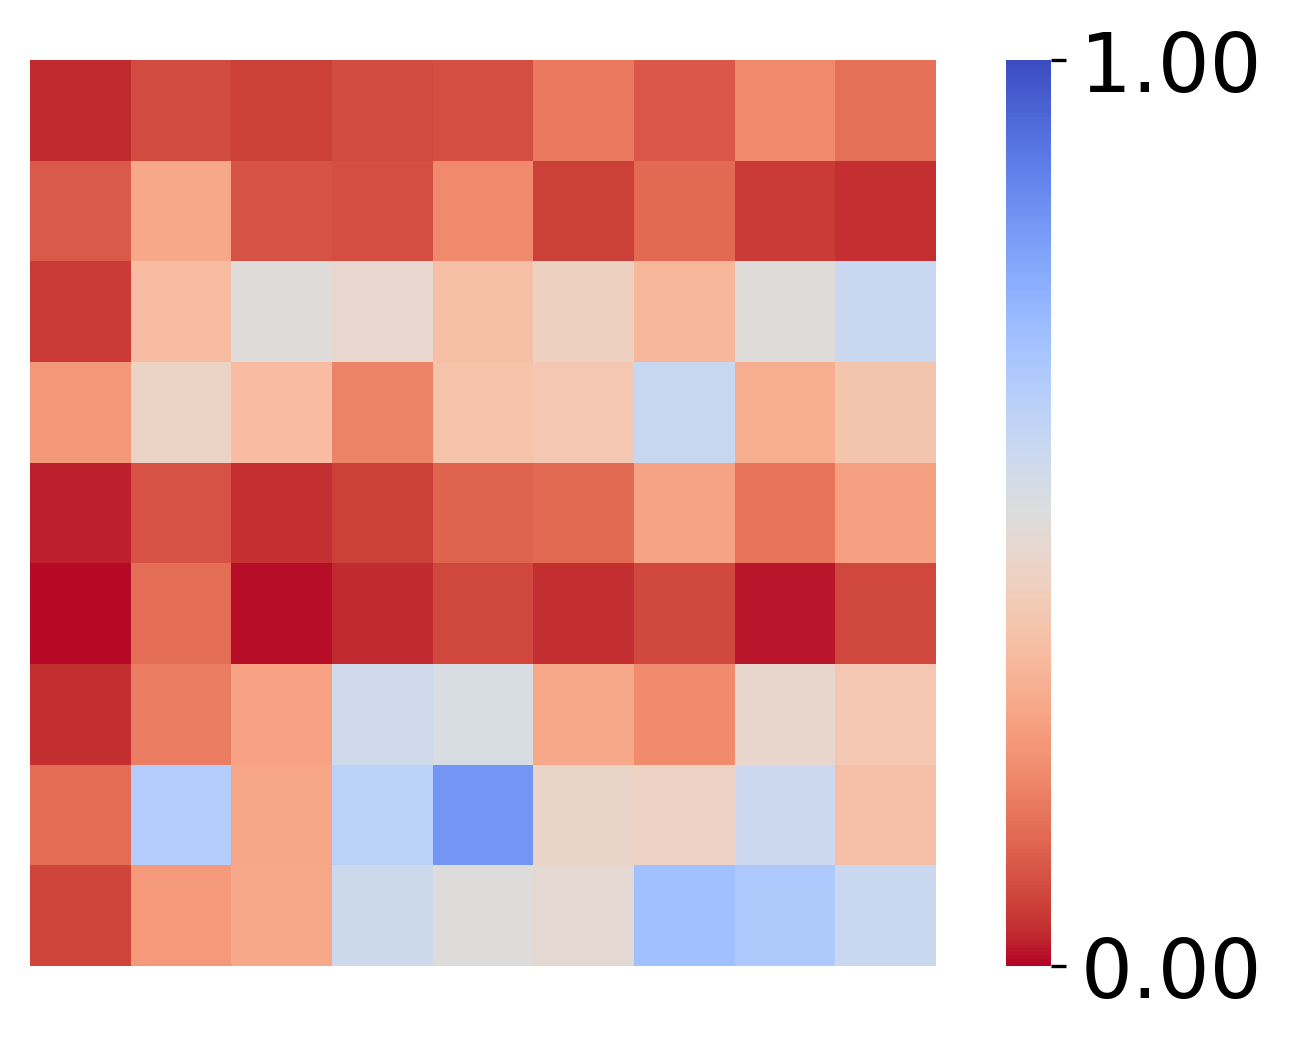

In [152]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['n_observes_day2'], df['n_sleeps_day3'], df['effs_day2'], df['effs_day3'], "Rewards Task 1", "Rewards Task 2", annot=False, groups=df['group_day1'], resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [153]:
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_humans_partialed.png'))
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_humans_partialed.svg'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_humans_partialed.png'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_humans_partialed.svg'))

corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_humans.svg'))

### Trait-Level Perturbations

In [154]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t1 as sim_timestamp

sim_rewss_t1, sim_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss_t1 = sim_rewss_t1.mean(axis=0)
sim_obss_t1 = sim_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss_t1 = np.flip(sim_rewss_t1.T, axis=1)
sim_obss_t1 = np.flip(sim_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t2 as sim_timestamp

effs_sorted = effs = np.arange(0, 1.01, 0.125)

sim_rewss_t2, sim_obss_t2, sim_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss_t2 = sim_rewss_t2.mean(axis=0)
sim_obss_t2 = sim_obss_t2.mean(axis=0)
sim_sleepss_t2 = sim_sleepss_t2.mean(axis=0)


## correcting for switching from tau to efficacy
sim_rewss_t2 = np.flip(sim_rewss_t2.T, axis=1)
sim_obss_t2 = np.flip(sim_obss_t2.T, axis=1)
sim_sleepss_t2 = np.flip(sim_sleepss_t2.T, axis=1)

(150, 9)


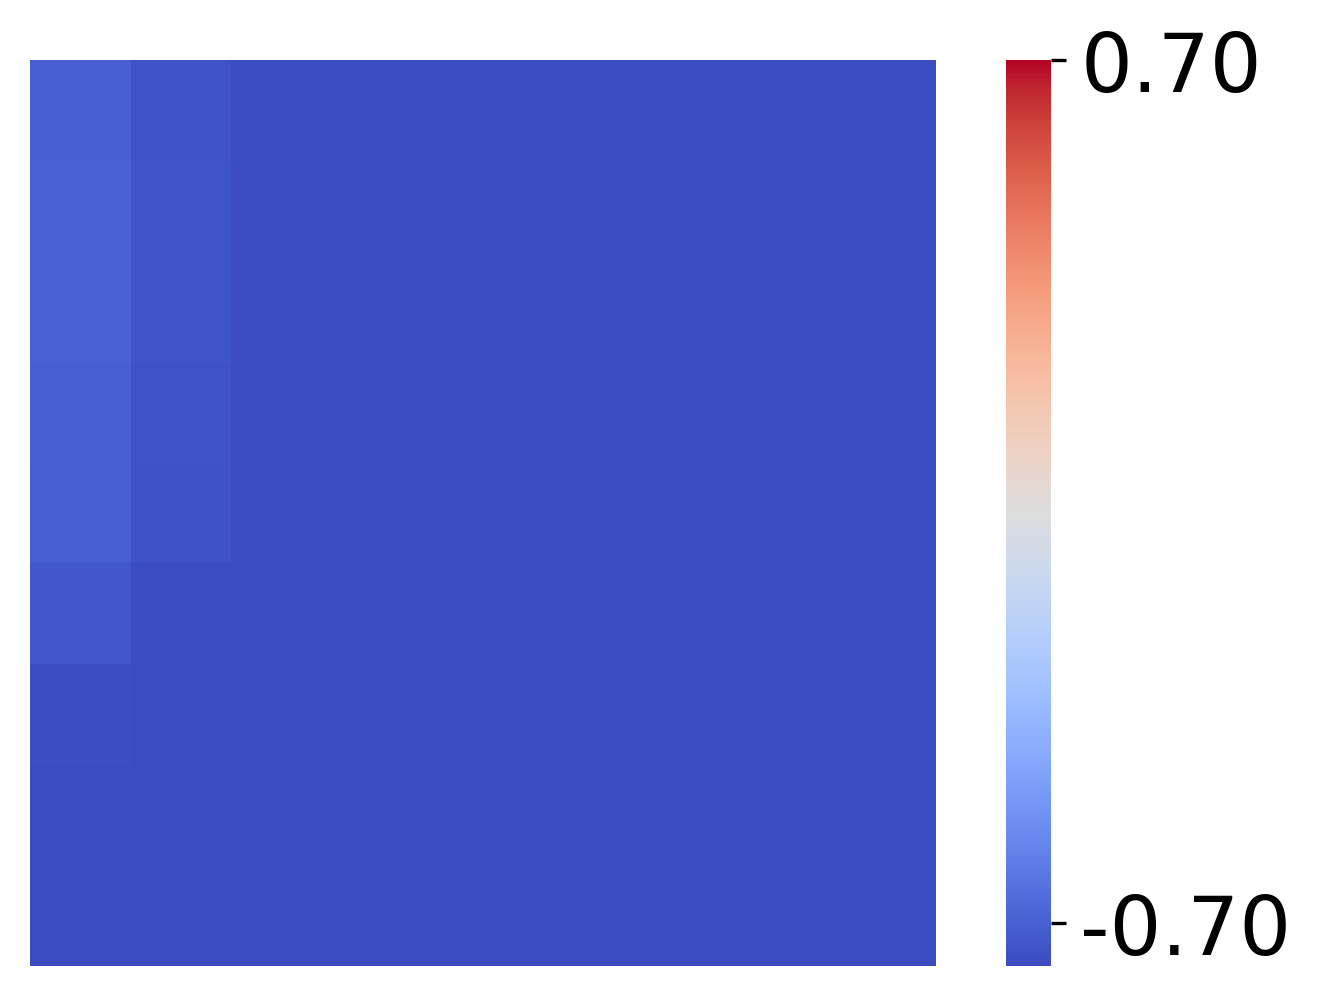

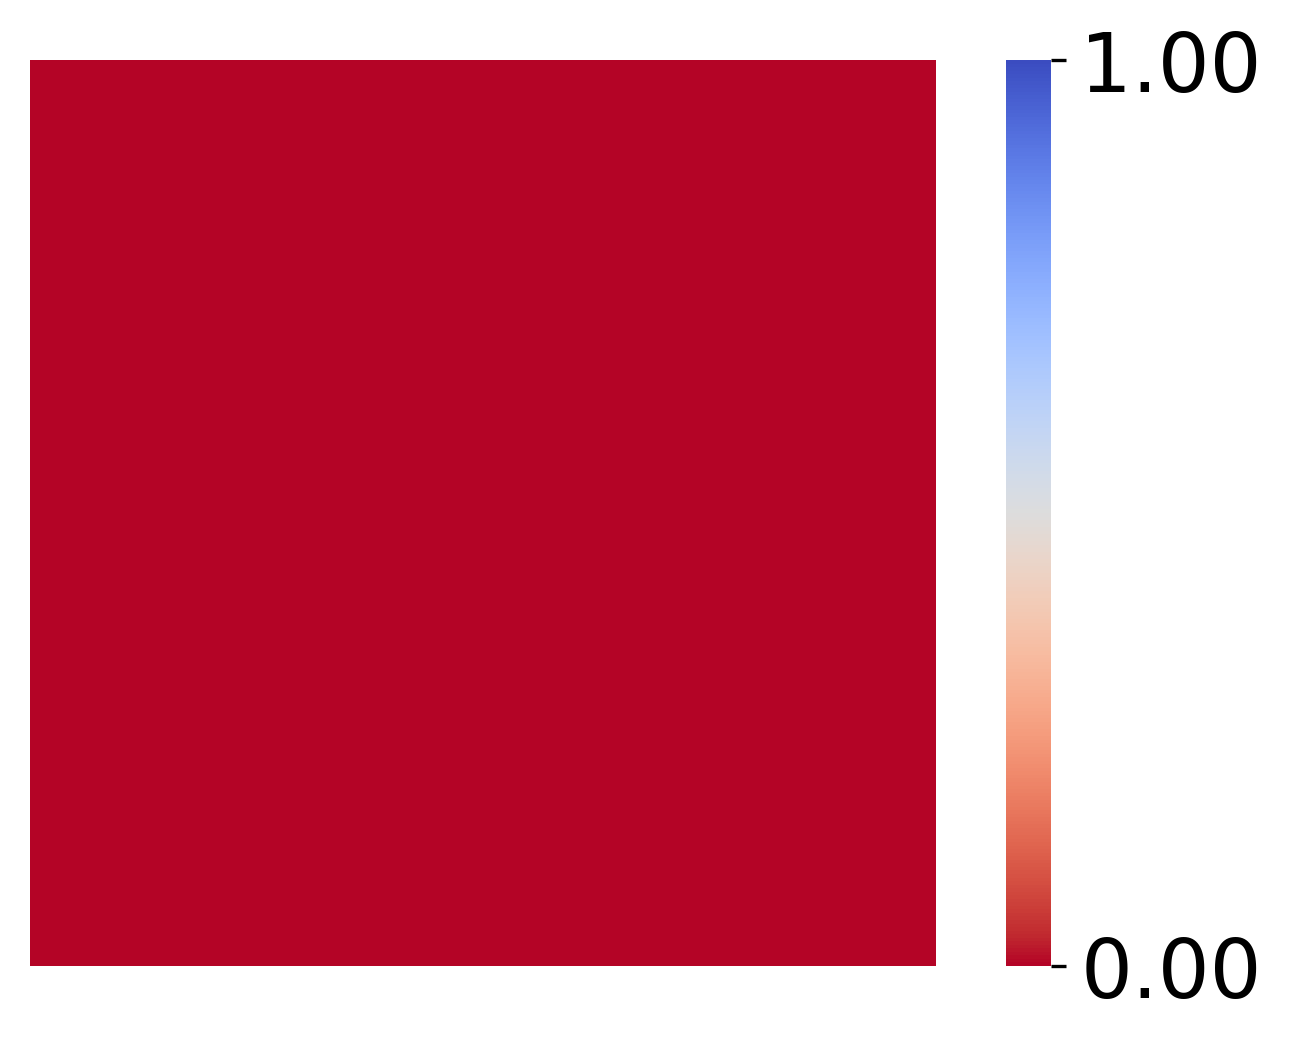

In [155]:
corr_fig, pvs_fig = compute_2D_correlation(sim_obss_t1, sim_sleepss_t2, effs_sorted, effs_sorted, "Rewards Task 1", "Rewards Task 2", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [156]:
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_trait_partialed.png'))
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_trait_partialed.svg'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_trait_partialed.png'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_trait_partialed.svg'))

corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_trait.svg'))

### Random Perturbation

In [157]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t1 as sim_timestamp

random_rewss_t1, random_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

random_rewss_t1 = random_rewss_t1.mean(axis=0)
random_obss_t1 = random_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss_t1 = np.flip(random_rewss_t1.T, axis=1)
random_obss_t1 = np.flip(random_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

random_rewss_t2, random_obss_t2, random_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

## post-hoc adjustment to get rid of relationship across tasks - TODO: resample cleanly
rng = np.random.default_rng()
random_rewss_t2 = rng.permuted(random_rewss_t2, axis=-1)
random_obss_t2 = rng.permuted(random_obss_t2, axis=-1)
random_sleepss_t2 = rng.permuted(random_sleepss_t2, axis=-1)

random_rewss_t2 = random_rewss_t2.mean(axis=0)
random_obss_t2 = random_obss_t2.mean(axis=0)
random_sleepss_t2 = random_sleepss_t2.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss_t2 = np.flip(random_rewss_t2.T, axis=1)
random_obss_t2 = np.flip(random_obss_t2.T, axis=1)
random_sleepss_t2 = np.flip(random_sleepss_t2.T, axis=1)

(150, 9)


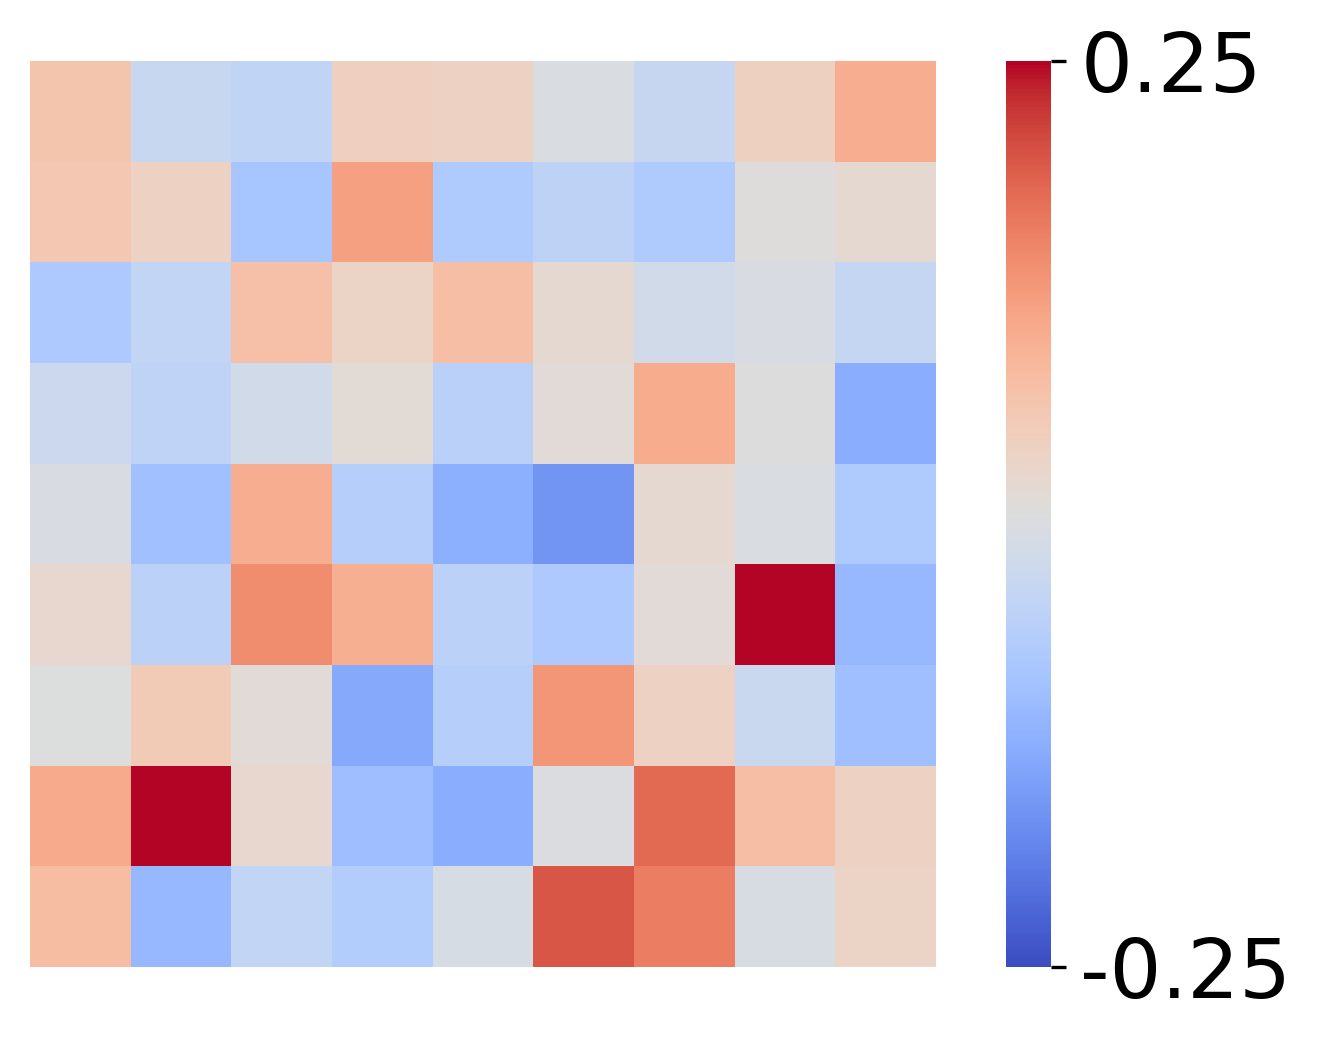

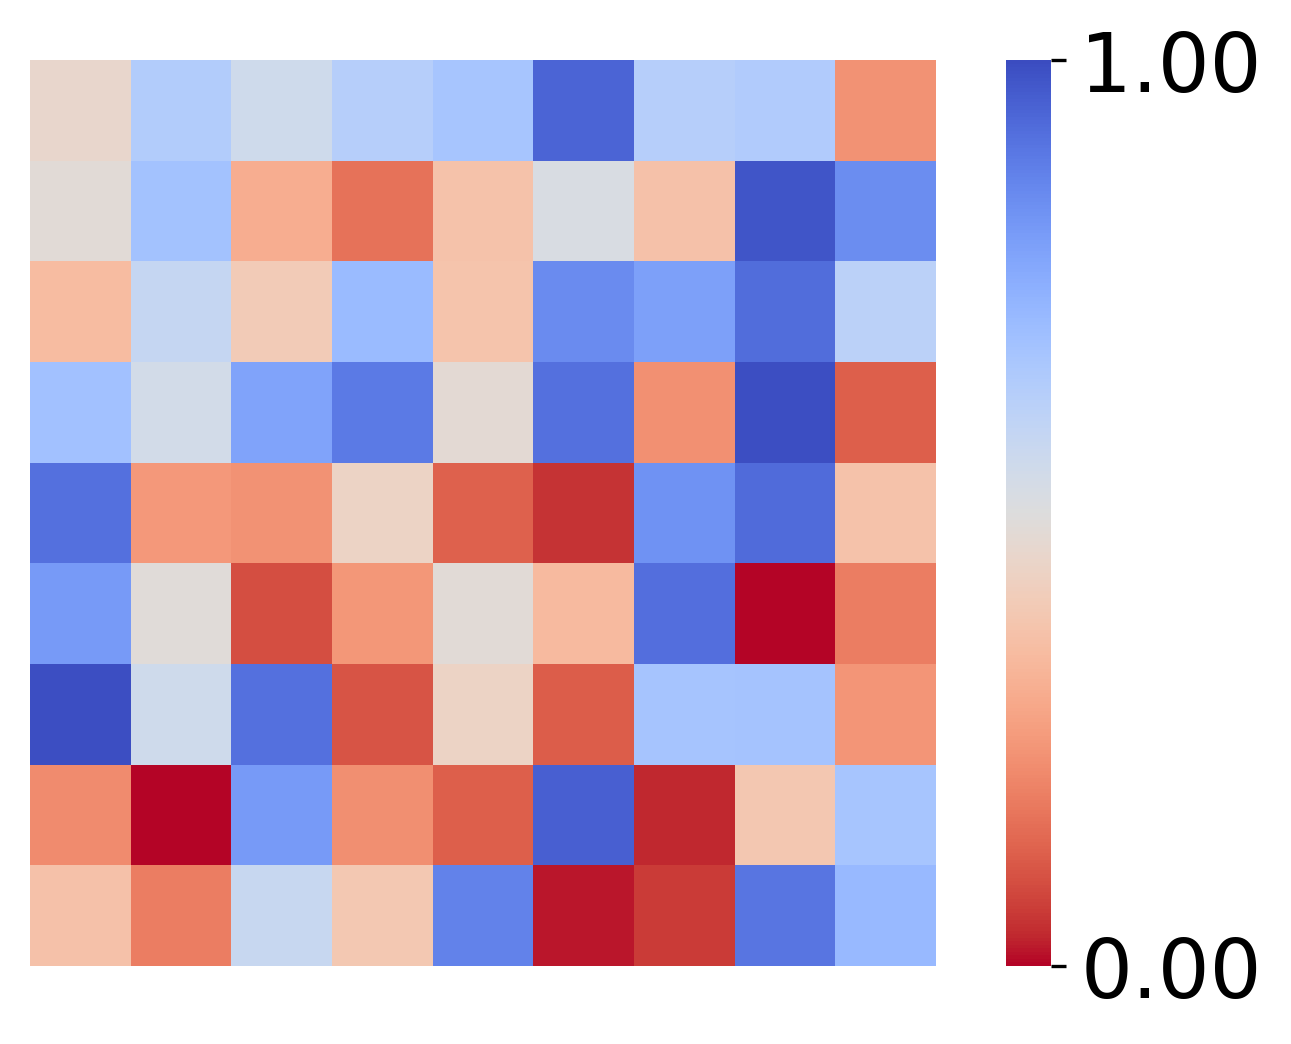

In [158]:
corr_fig, pvs_fig = compute_2D_correlation(random_obss_t1, random_sleepss_t2, effs, effs, "Rewards Task 1", "Rewards Task 2", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [159]:
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random_partialed.png'))
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random_partialed.svg'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random_partialed.png'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random_partialed.svg'))

corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_random.svg'))

### Zeros Perturbations

In [160]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models

from settings_ana import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t1 as sim_timestamp

zeros_rewss_t1, zeros_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

zeros_rewss_t1 =zeros_rewss_t1.mean(axis=0)
zeros_obss_t1 = zeros_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss_t1 = np.flip(zeros_rewss_t1.T, axis=1)
zeros_obss_t1 = np.flip(zeros_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)
effs_sorted = np.arange(0, 1.01, 0.125)

zeros_rewss_t2, zeros_obss_t2,zeros_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

## TODO: Check to make sure this is no longer necessary
rng = np.random.default_rng()
zeros_rewss_t2 = rng.permuted(zeros_rewss_t2, axis=-1)
zeros_obss_t2 = rng.permuted(zeros_obss_t2, axis=-1)
zeros_sleepss_t2 = rng.permuted(zeros_sleepss_t2, axis=-1)

zeros_rewss_t2 = zeros_rewss_t2.mean(axis=0)
zeros_obss_t2 = zeros_obss_t2.mean(axis=0)
zeros_sleepss_t2 = zeros_sleepss_t2.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss_t2 = np.flip(zeros_rewss_t2.T, axis=1)
zeros_obss_t2 = np.flip(zeros_obss_t2.T, axis=1)
zeros_sleepss_t2 = np.flip(zeros_sleepss_t2.T, axis=1)

## QUARANTINED - IS THIS DUPLICATED?
# from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
# from settings_ana import pepe_human_ape_models as ape_models

# from settings_ana import zeros_simulated_participants_folder_t1 as simulated_participants_folder
# from settings_ana import zeros_sim_timestamp_t1 as sim_timestamp

# zeros_rewss_t1, zeros_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

# zeros_rewss_t1 =zeros_rewss_t1.mean(axis=0)
# zeros_obss_t1 = zeros_obss_t1.mean(axis=0)

# ## correcting for switching from tau to efficacy
# zeros_rewss_t1 = np.flip(zeros_rewss_t1.T, axis=1)
# zeros_obss_t1 = np.flip(zeros_obss_t1.T, axis=1)

# from settings_ana import levc_human_ape_models as ape_models
# from settings_ana import zeros_simulated_participants_folder_t2 as simulated_participants_folder
# from settings_ana import zeros_sim_timestamp_t2 as sim_timestamp

# effs = np.arange(0, 1.01, 0.125)
# effs_sorted = np.arange(0, 1.01, 0.125)

# zeros_rewss_t2, zeros_obss_t2,zeros_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

# ## TODO: Check to make sure this is no longer necessary
# rng = np.random.default_rng()
# zeros_rewss_t2 = rng.permuted(zeros_rewss_t2, axis=-1)
# zeros_obss_t2 = rng.permuted(zeros_obss_t2, axis=-1)
# zeros_sleepss_t2 = rng.permuted(zeros_sleepss_t2, axis=-1)

# zeros_rewss_t2 = zeros_rewss_t2.mean(axis=0)
# zeros_obss_t2 = zeros_obss_t2.mean(axis=0)
# zeros_sleepss_t2 = zeros_sleepss_t2.mean(axis=0)

# ## correcting for switching from tau to efficacy
# zeros_rewss_t2 = np.flip(zeros_rewss_t2.T, axis=1)
# zeros_obss_t2 = np.flip(zeros_obss_t2.T, axis=1)
# zeros_sleepss_t2 = np.flip(zeros_sleepss_t2.T, axis=1)

(150, 9)


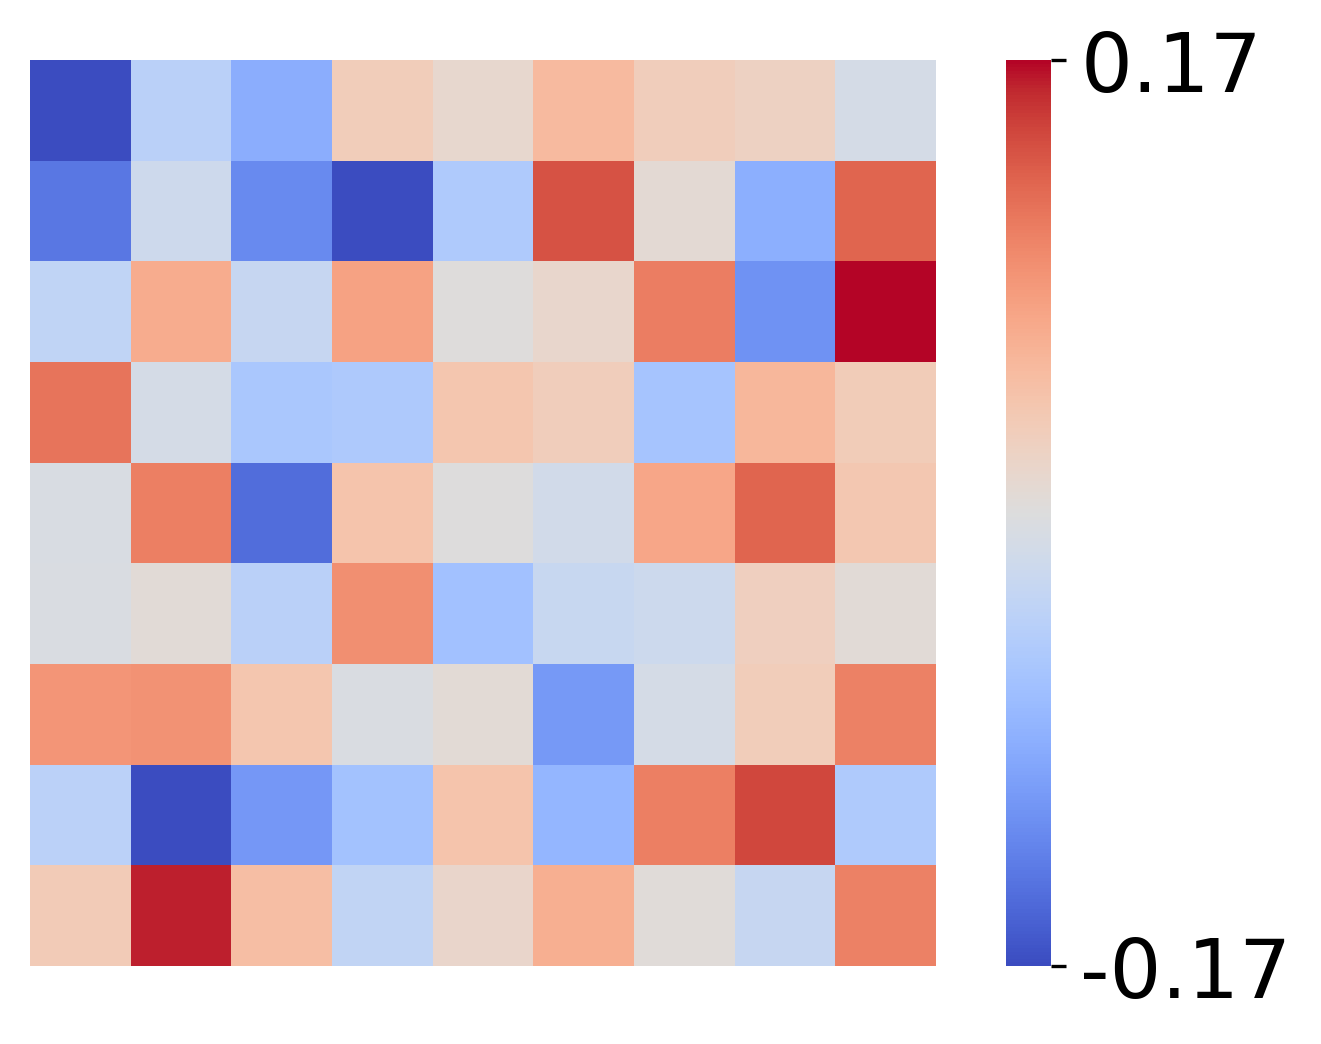

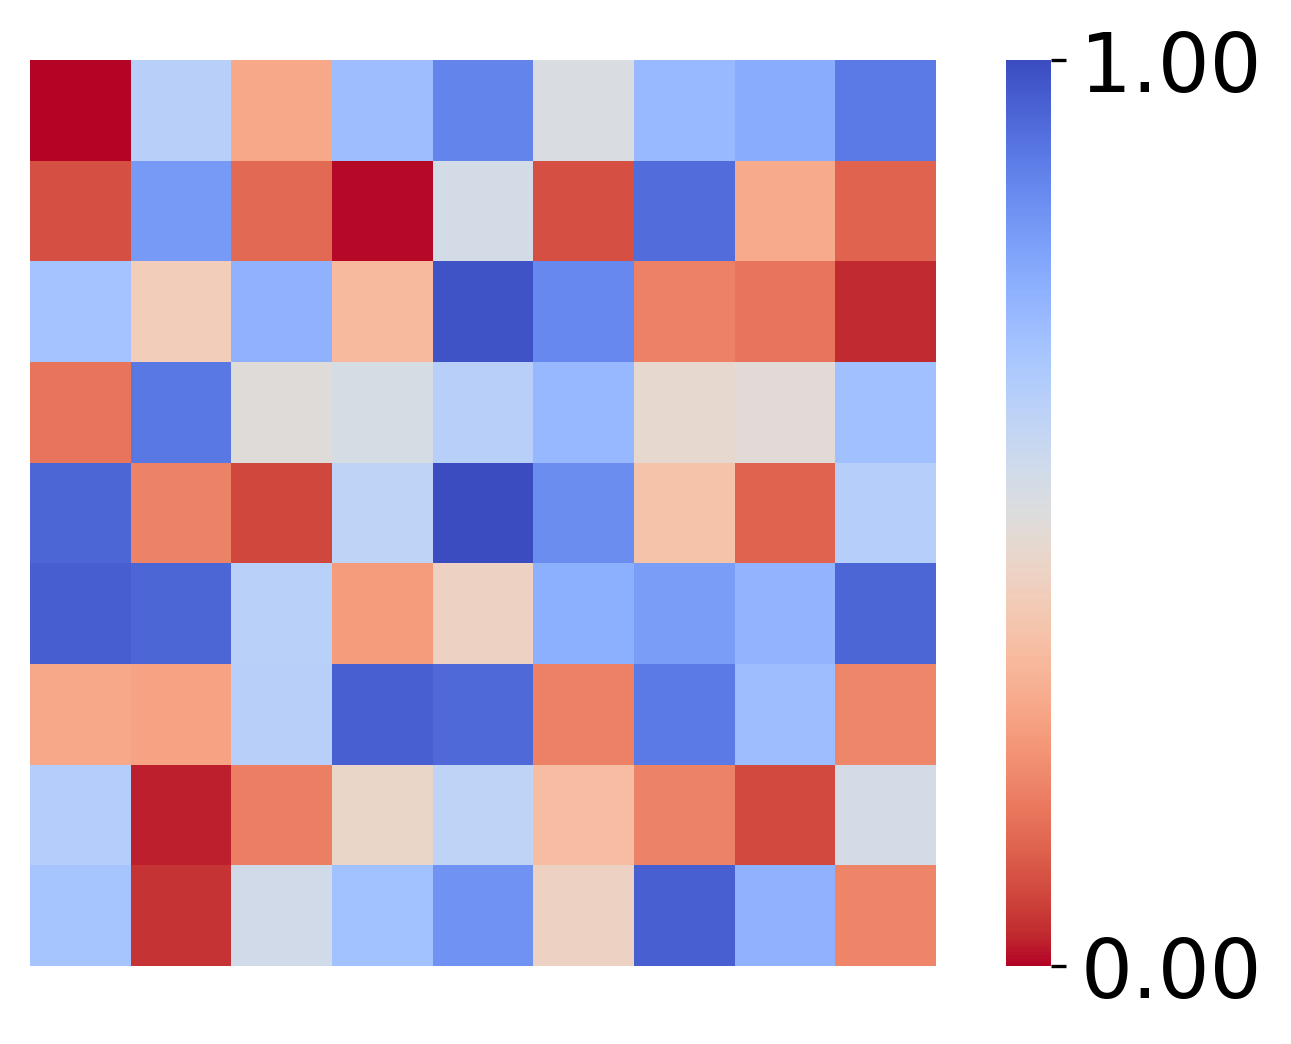

In [161]:
corr_fig, pvs_fig = compute_2D_correlation(zeros_obss_t1, zeros_sleepss_t2, effs, effs, "Rewards Task 1", "Rewards Task 2", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [162]:
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_zeros_partialed.png'))
# corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_zeros_partialed.svg'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_zeros_partialed.png'))
# pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_zeros_partialed.svg'))

corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_sleeps_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_sleeps_zeros.svg'))

### Stats

## Panel F: Across Tasks Observations
### Humans

In [163]:
from human_utils_project import get_clean_data

day = 'day3'
exp_date = '24-01-22-29'

group = None

df_day1, effs_train_day1, effs_test_day1, test_start_day1 = get_clean_data(day=1, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group= group, file_base=human_data_file_base)
df_day2, effs_train_day2, effs_test_day2, test_start_day2 = get_clean_data(day=2, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)
df_day3, effs_train_day3, effs_test_day3, test_start_day3 = get_clean_data(day=3, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)
effs = np.arange(0, 1.01, 0.125)
n_steps = 50

## WITH INNER JOIN SO THAT ONLY ROWS FROM ALL THREE DAYS ARE KEPT
df = df_day1.join(df_day2, how='outer', lsuffix='_day1', rsuffix='_day2')
df = df.join(df_day3.rename(columns=lambda x: f"{x}_day3"), how='inner')


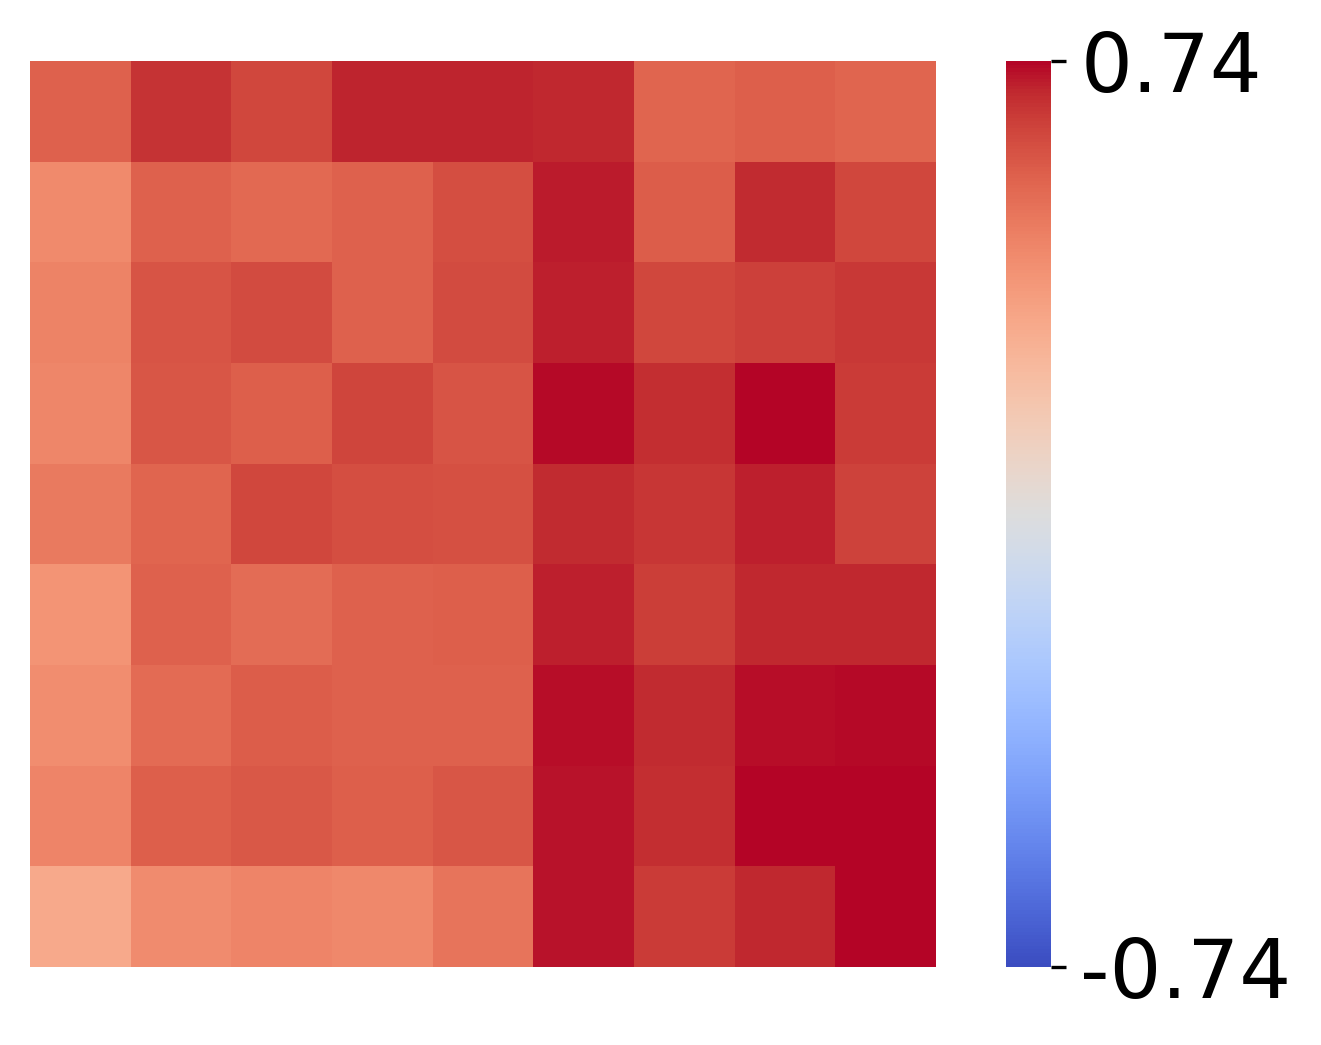

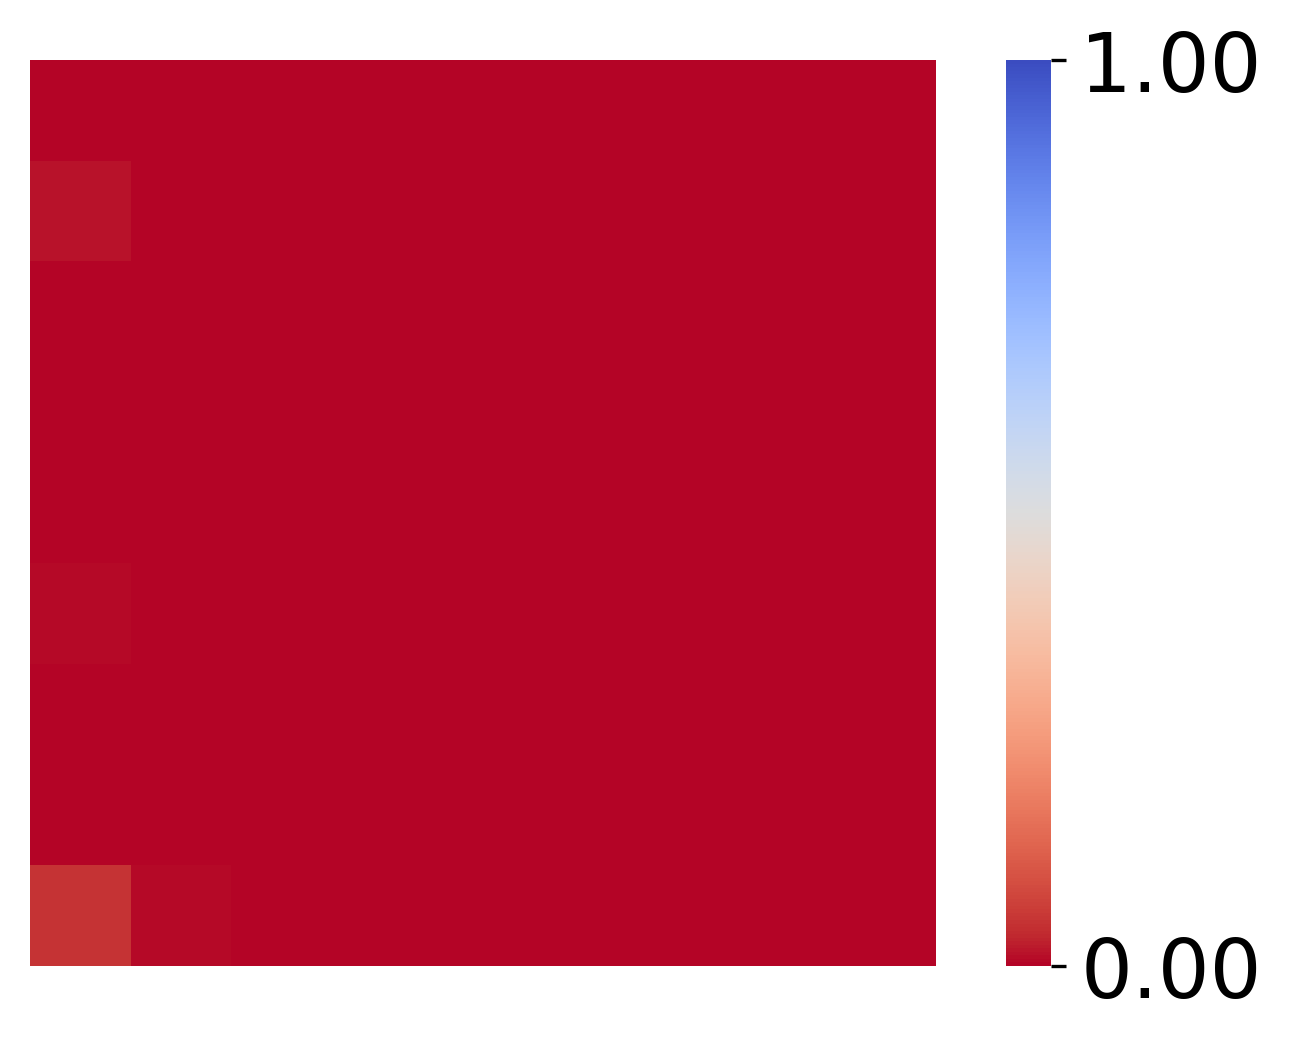

In [164]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['n_observes_day2'], df['n_observes_day3'], df['effs_day2'], df['effs_day3'], "Observes Task 1", "Observes Task 2", annot=False, groups=df['group_day1'], resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [165]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_humans.svg'))

### Trait-level Perturbations

In [166]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models

from settings_ana import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t1 as sim_timestamp

sim_rewss_t1, sim_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss_t1 = sim_rewss_t1.mean(axis=0)
sim_obss_t1 = sim_obss_t1.mean(axis=0)


## correcting for switching from tau to efficacy
sim_rewss_t1 = np.flip(sim_rewss_t1.T, axis=1)
sim_obss_t1 = np.flip(sim_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models

from settings_ana import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t2 as sim_timestamp

sim_rewss_t2, sim_obss_t2, sim_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss_t2 = sim_rewss_t2.mean(axis=0)
sim_obss_t2 = sim_obss_t2.mean(axis=0)
sim_sleepss_t2 = sim_sleepss_t2.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss_t2 = np.flip(sim_rewss_t2.T, axis=1)
sim_obss_t2 = np.flip(sim_obss_t2.T, axis=1)
sim_sleepss_t2 = np.flip(sim_sleepss_t2.T, axis=1)

effs_sorted = np.arange(0, 1.01, 0.125)

(150, 9)


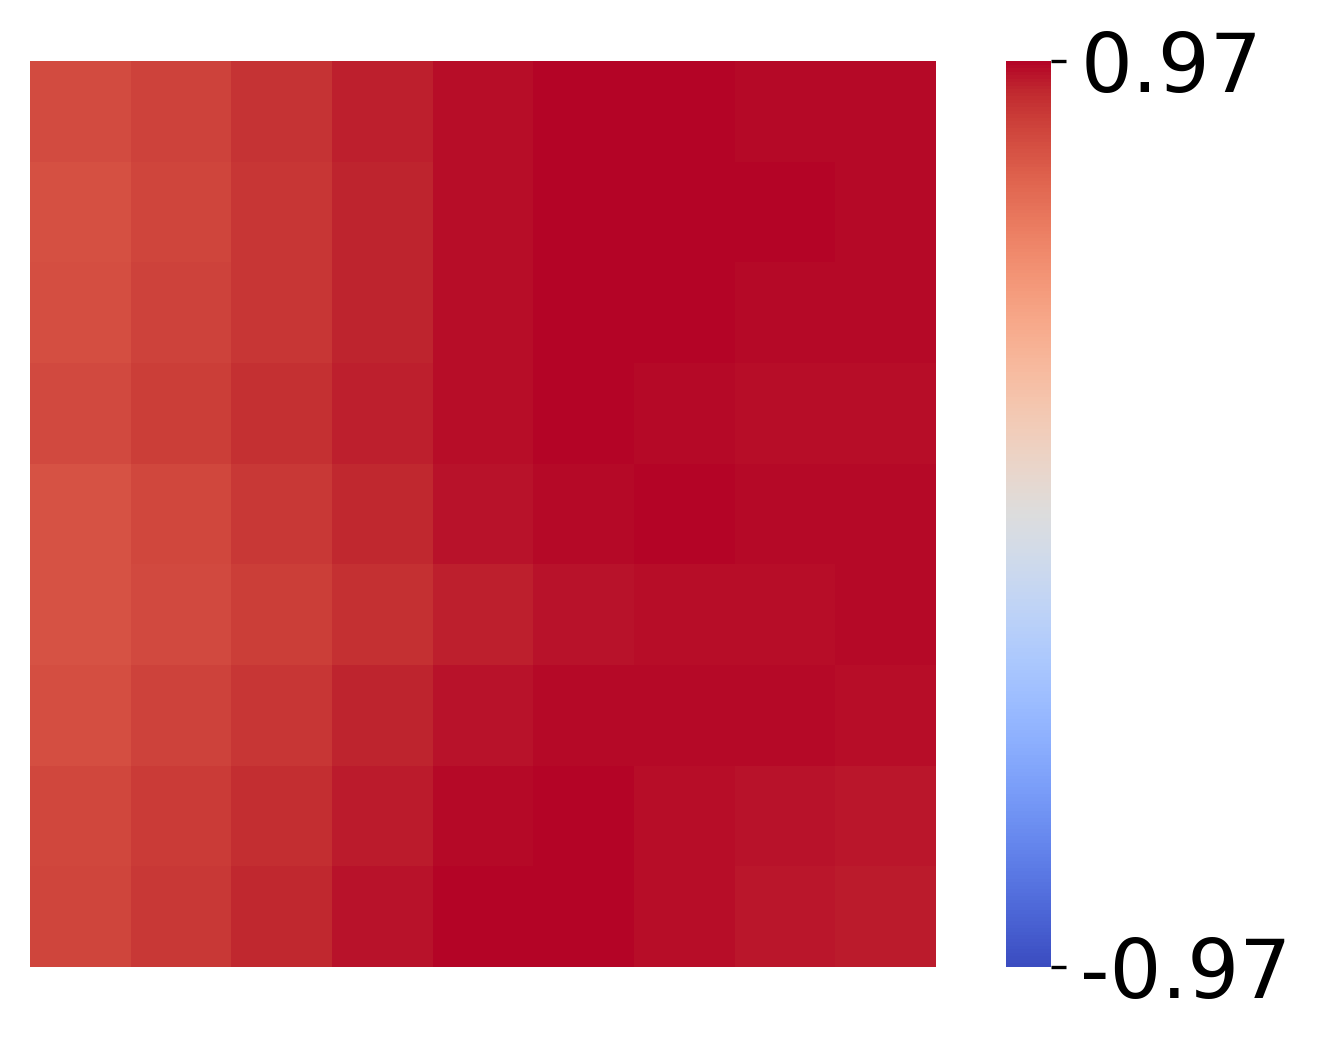

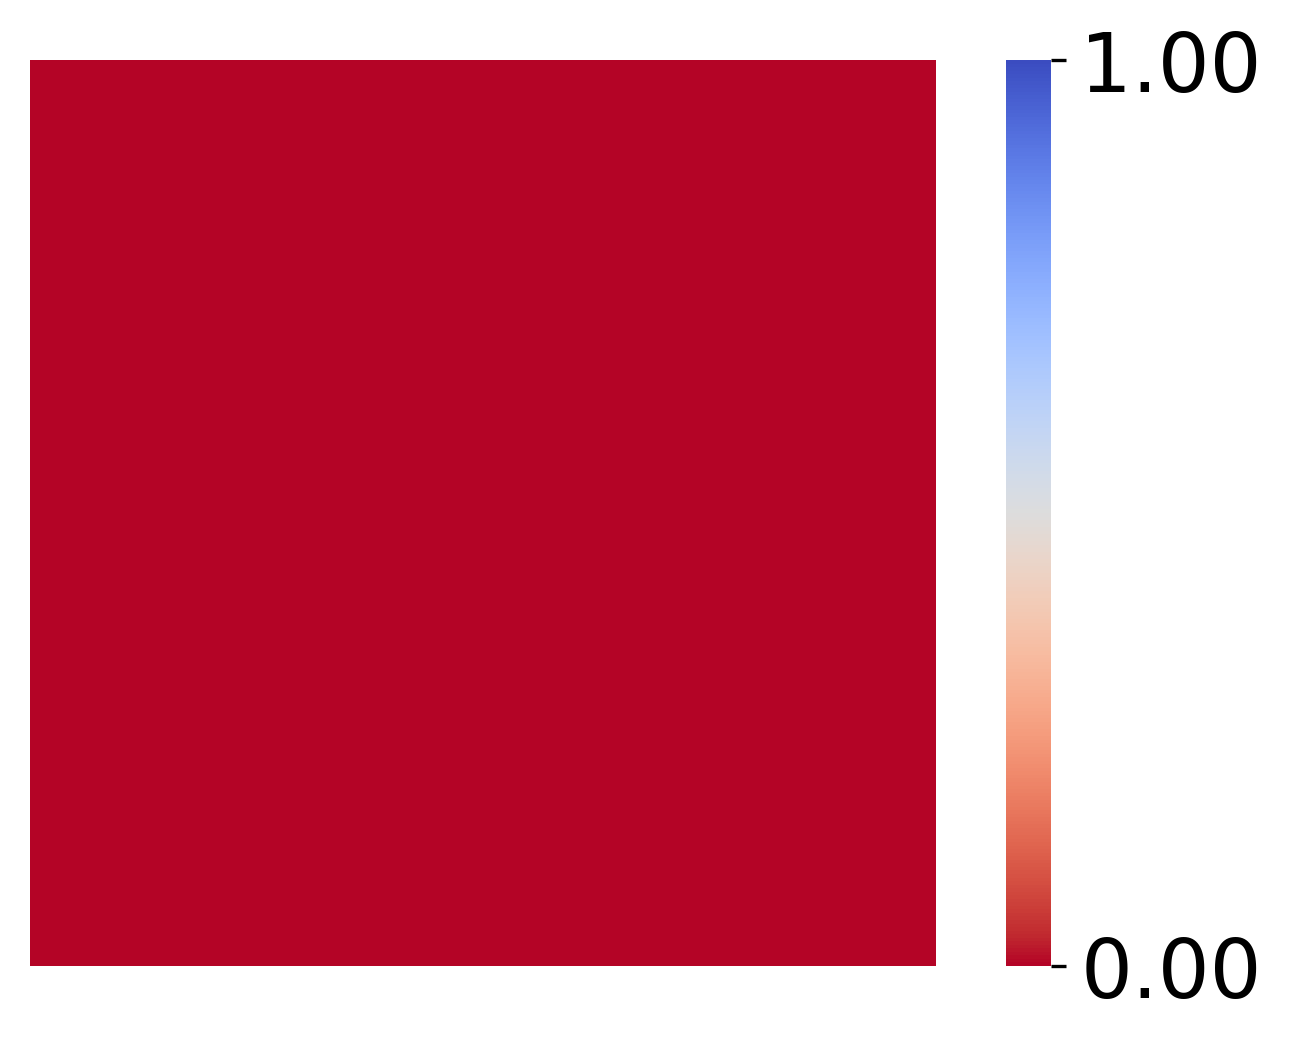

In [167]:
corr_fig, pvs_fig = compute_2D_correlation(sim_obss_t1, sim_obss_t2, effs_sorted, effs_sorted, "Observations Task 1", "Observations Task 2", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [168]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_trait.svg'))

### Random Perturbations

In [169]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t1 as sim_timestamp

random_rewss_t1, random_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

random_rewss_t1 = random_rewss_t1.mean(axis=0)
random_obss_t1 = random_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss_t1 = np.flip(random_rewss_t1.T, axis=1)
random_obss_t1 = np.flip(random_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

random_rewss_t2, random_obss_t2, random_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

## post-hoc adjustment to get rid of relationship across tasks - TODO: resample cleanly
rng = np.random.default_rng()
random_rewss_t2 = rng.permuted(random_rewss_t2, axis=-1)
random_obss_t2 = rng.permuted(random_obss_t2, axis=-1)
random_sleepss_t2 = rng.permuted(random_sleepss_t2, axis=-1)

random_rewss_t2 = random_rewss_t2.mean(axis=0)
random_obss_t2 = random_obss_t2.mean(axis=0)
random_sleepss_t2 = random_sleepss_t2.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss_t2 = np.flip(random_rewss_t2.T, axis=1)
random_obss_t2 = np.flip(random_obss_t2.T, axis=1)
random_sleepss_t2 = np.flip(random_sleepss_t2.T, axis=1)

(150, 9)


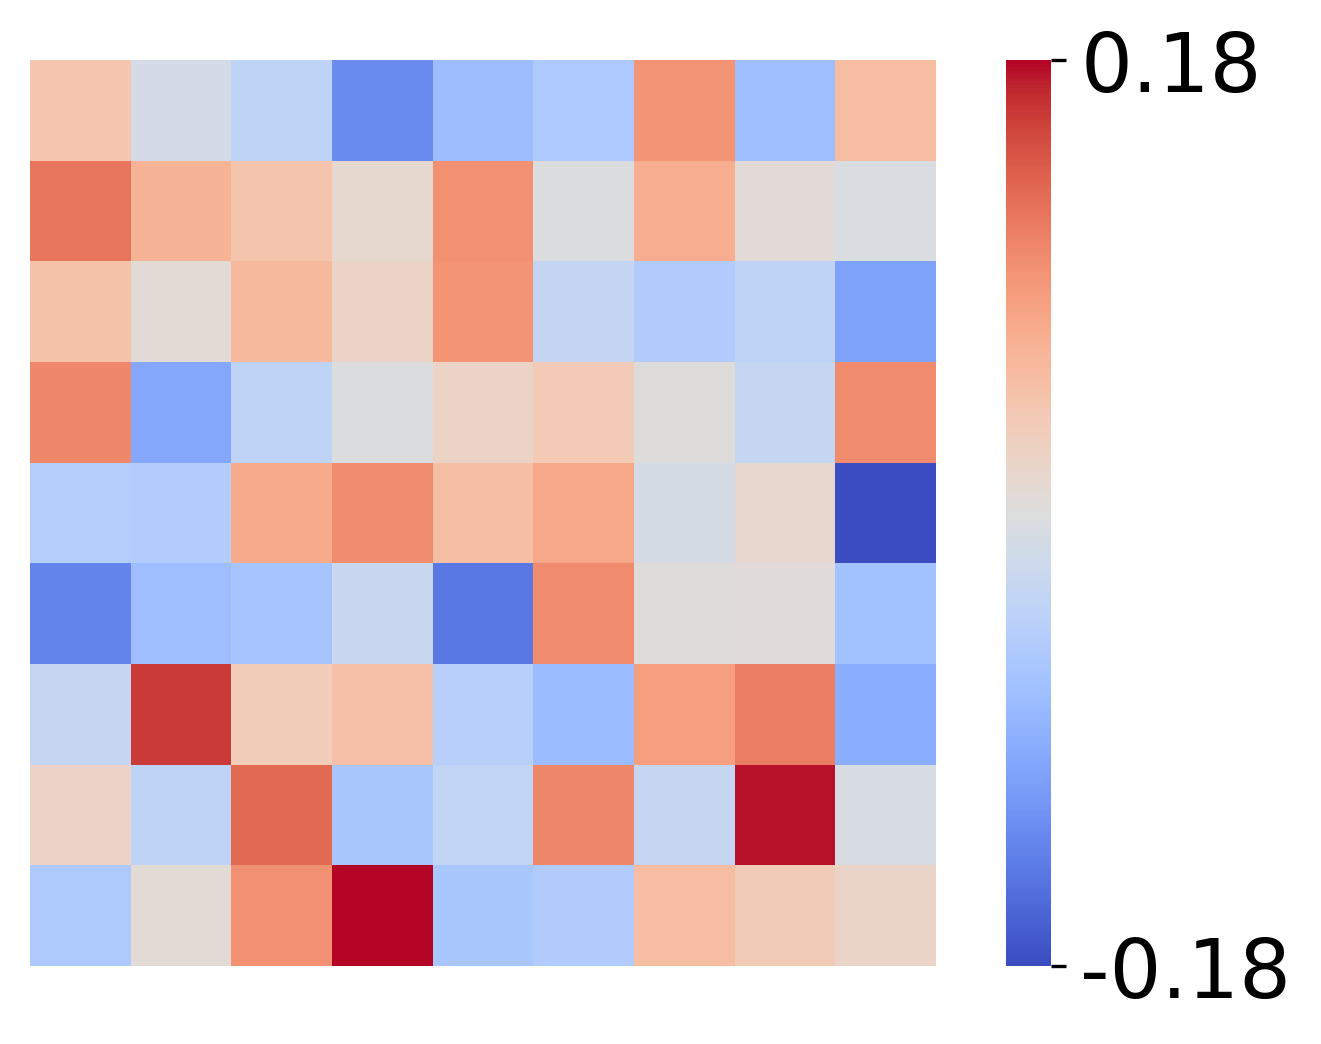

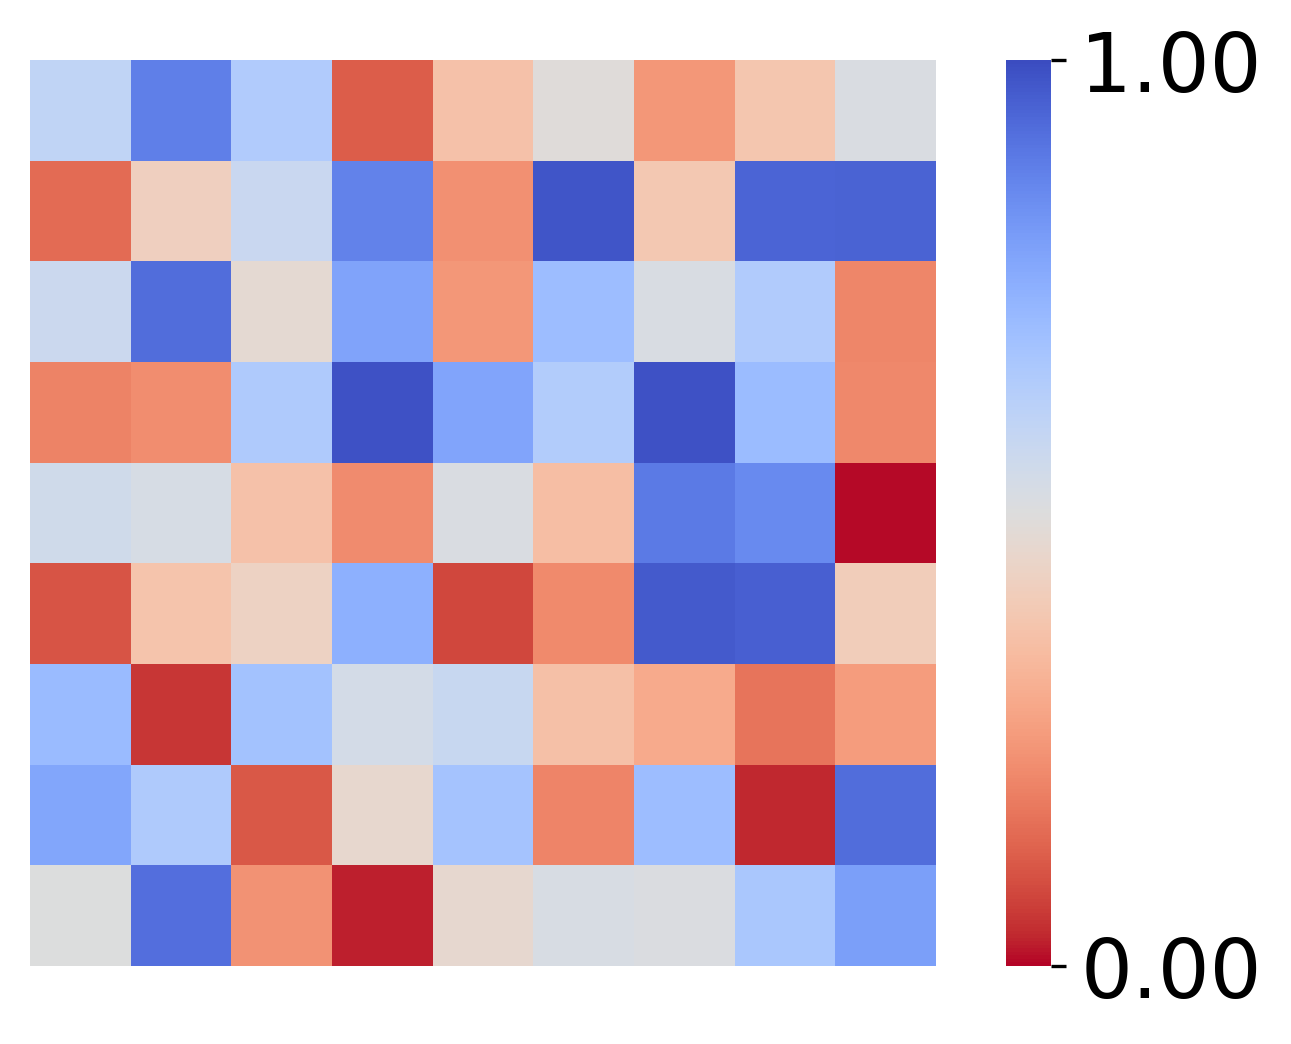

In [170]:
corr_fig, pvs_fig = compute_2D_correlation(random_obss_t1, random_obss_t2, effs_sorted, effs_sorted, "Observations Task 1", "Observations Task 2", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [171]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_random.svg'))

### Zeros Perturbations

In [172]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models

from settings_ana import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t1 as sim_timestamp

zeros_rewss_t1, zeros_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

zeros_rewss_t1 =zeros_rewss_t1.mean(axis=0)
zeros_obss_t1 = zeros_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss_t1 = np.flip(zeros_rewss_t1.T, axis=1)
zeros_obss_t1 = np.flip(zeros_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)
effs_sorted = np.arange(0, 1.01, 0.125)

zeros_rewss_t2, zeros_obss_t2,zeros_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

## TODO: Check to make sure this is no longer necessary
rng = np.random.default_rng()
zeros_rewss_t2 = rng.permuted(zeros_rewss_t2, axis=-1)
zeros_obss_t2 = rng.permuted(zeros_obss_t2, axis=-1)
zeros_sleepss_t2 = rng.permuted(zeros_sleepss_t2, axis=-1)

zeros_rewss_t2 = zeros_rewss_t2.mean(axis=0)
zeros_obss_t2 = zeros_obss_t2.mean(axis=0)
zeros_sleepss_t2 = zeros_sleepss_t2.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss_t2 = np.flip(zeros_rewss_t2.T, axis=1)
zeros_obss_t2 = np.flip(zeros_obss_t2.T, axis=1)
zeros_sleepss_t2 = np.flip(zeros_sleepss_t2.T, axis=1)

(150, 9)


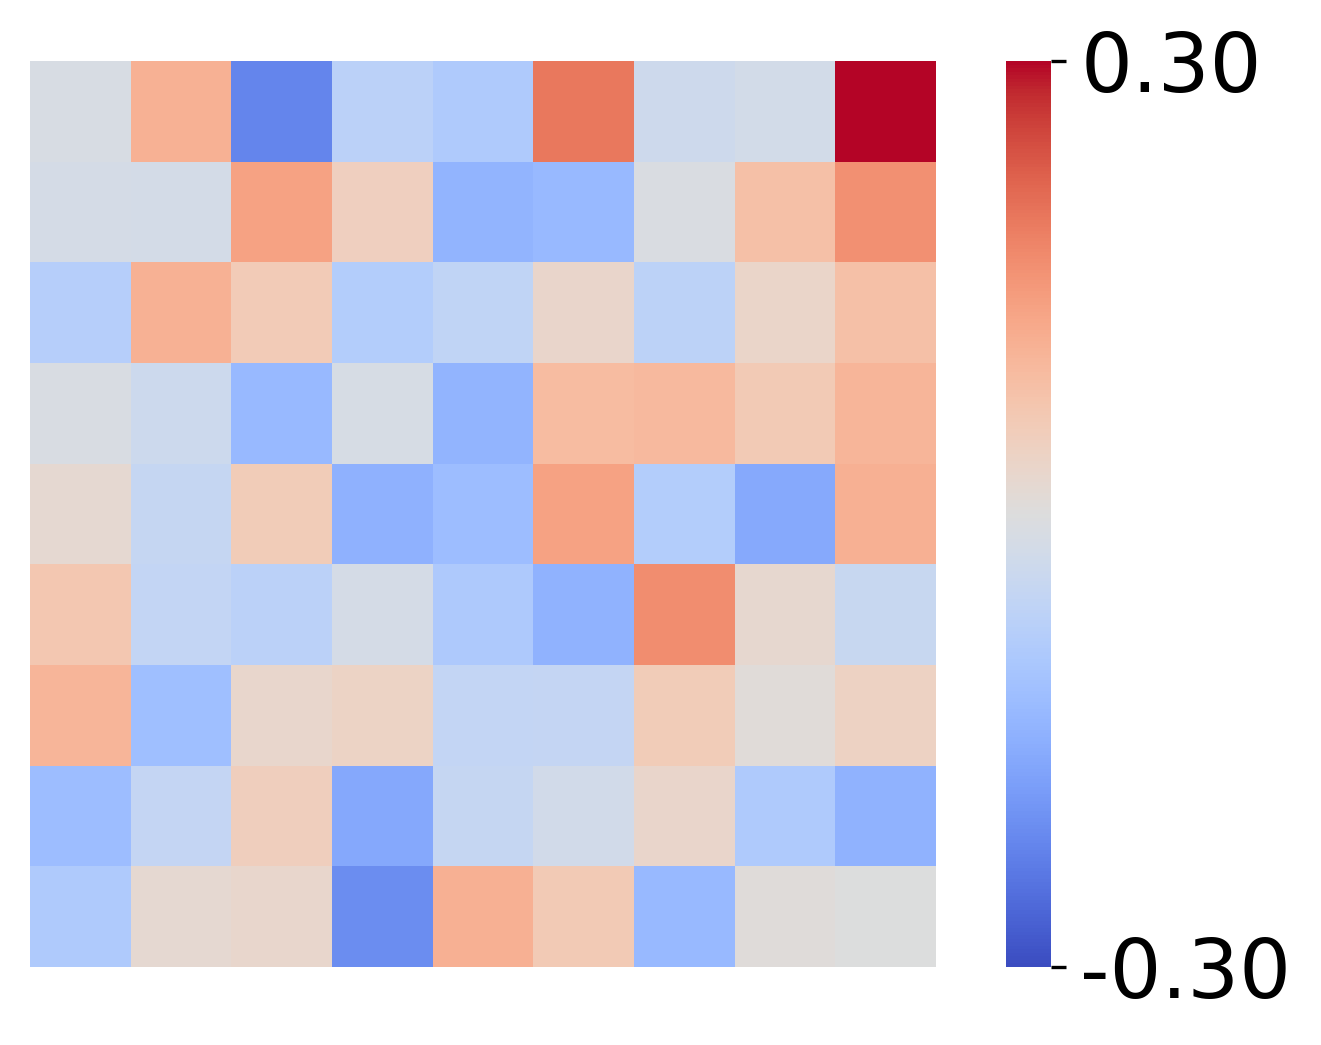

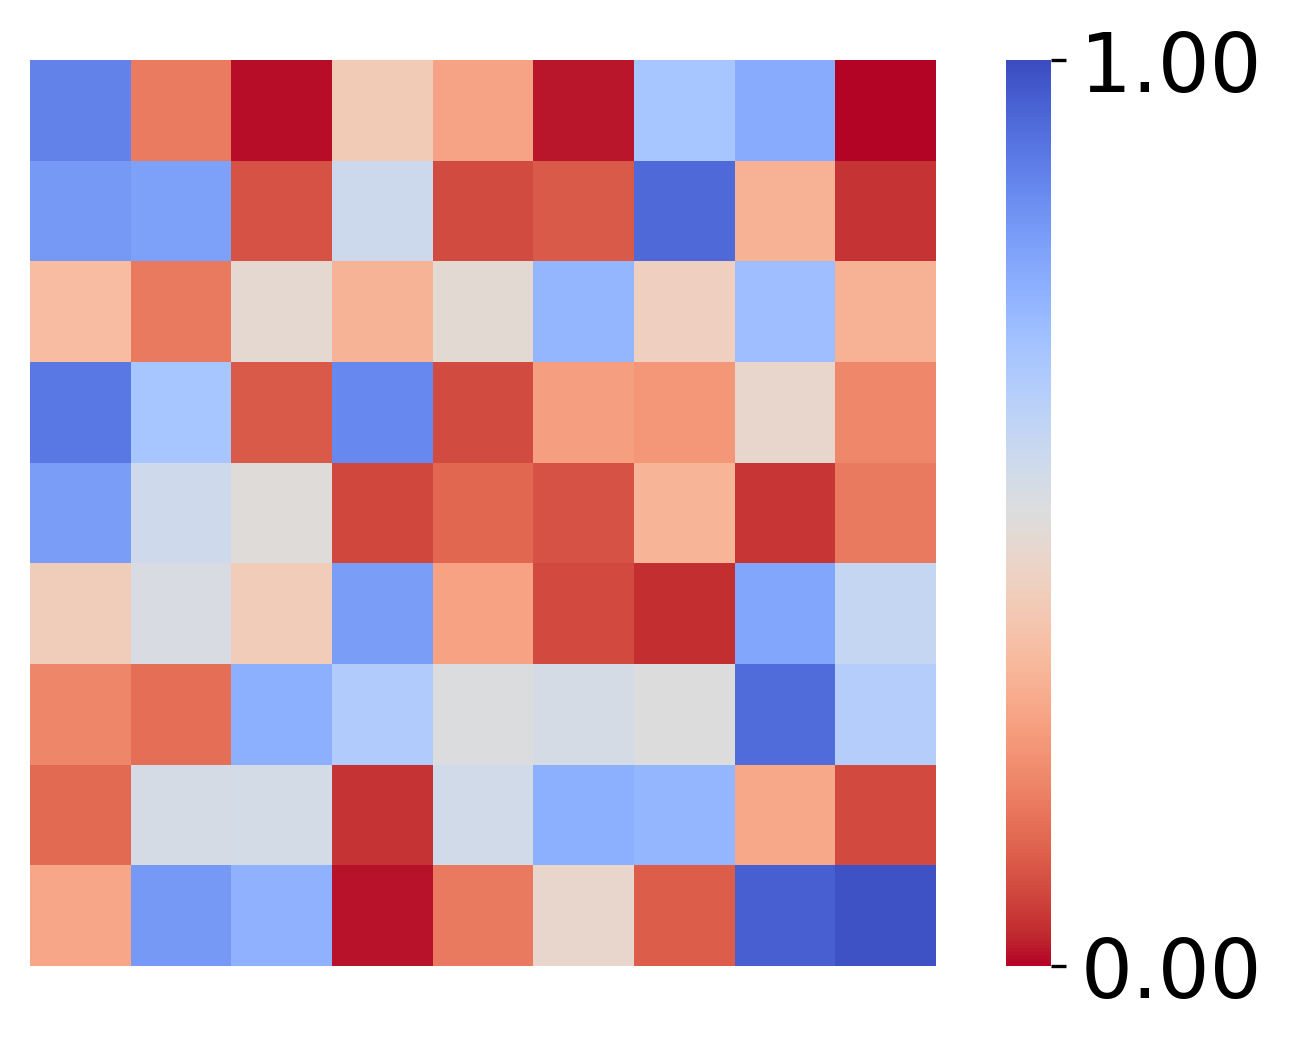

In [173]:
corr_fig, pvs_fig = compute_2D_correlation(zeros_obss_t1, zeros_obss_t2, effs_sorted, effs_sorted, "Observations Task 1", "Observations Task 2", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [174]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_observes_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_observes_zeros.svg'))

### Stats 

In [175]:
from human_utils_behavioral_analysis import compute_2D_correlation_matrices, compute_partial_2D_correlation_matrices

## day 2
data_obs_corr_g1, data_obs_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group_day2']]['n_observes_day2'].values), np.stack(df[~df['group_day2']]['n_observes_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day3']]['effs_day3'].values),)
data_obs_corr_g2, data_obs_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group_day2']]['n_observes_day2'].values), np.stack(df[df['group_day2']]['n_observes_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day3']]['effs_day3'].values),)

data_rews_corr_g1, data_rews_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group_day2']]['rewards_tallies_day2'].values), np.stack(df[~df['group_day2']]['rewards_tallies_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day3']]['effs_day3'].values),)
data_rews_corr_g2, data_rews_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group_day2']]['rewards_tallies_day2'].values), np.stack(df[df['group_day2']]['rewards_tallies_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day3']]['effs_day3'].values),)

data_obs_corr = (~df['group_day2']).sum() / len(df) * data_obs_corr_g1 + (df['group_day2']).sum() / len(df) * data_obs_corr_g2
data_obs_pvs = (~df['group_day2']).sum() / len(df) * data_obs_pvs_g1 + (df['group_day2']).sum() / len(df) * data_obs_pvs_g2

data_rews_corr = (~df['group_day2']).sum() / len(df) * data_rews_corr_g1 + (df['group_day2']).sum() / len(df) * data_rews_corr_g2
data_rews_pvs = (~df['group_day2']).sum() / len(df) * data_rews_pvs_g1 + (df['group_day2']).sum() / len(df) * data_rews_pvs_g2

data_sleeps_corr_g1, data_sleeps_pvs_g1 = compute_partial_2D_correlation_matrices(np.stack(df[~df['group_day2']]['n_observes_day2'].values), np.stack(df[~df['group_day2']]['n_sleeps_day3'].values), np.stack(df[~df['group_day2']]['n_observes_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day2']]['effs_day3'].values), np.stack(df[~df['group_day2']]['effs_day3'].values),)
data_sleeps_corr_g2, data_sleeps_pvs_g2 = compute_partial_2D_correlation_matrices(np.stack(df[df['group_day2']]['n_observes_day2'].values), np.stack(df[df['group_day2']]['n_sleeps_day3'].values), np.stack(df[df['group_day2']]['n_observes_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day2']]['effs_day3'].values),np.stack(df[df['group_day2']]['effs_day3'].values), )

data_sleeps_corr = (~df['group_day2']).sum() / len(df) * data_sleeps_corr_g1 + (df['group_day2']).sum() / len(df) * data_sleeps_corr_g2
data_sleeps_pvs = (~df['group_day2']).sum() / len(df) * data_sleeps_pvs_g1 + (df['group_day2']).sum() / len(df) * data_sleeps_pvs_g2

sim_obs_corr, sim_obs_pvs = compute_2D_correlation_matrices(sim_obss_t1, sim_obss_t2, effs, effs,)
sim_rews_corr, sim_rews_pvs = compute_2D_correlation_matrices(sim_rewss_t1, sim_rewss_t2, effs, effs,)
sim_sleeps_corr, sim_sleeps_pvs = compute_partial_2D_correlation_matrices(sim_obss_t1, sim_sleepss_t2, sim_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False,)
random_obs_corr, random_obs_pvs = compute_2D_correlation_matrices(random_obss_t1, random_obss_t2, effs, effs,)
random_rews_corr, random_rews_pvs = compute_2D_correlation_matrices(random_rewss_t1, random_rewss_t2, effs, effs,)
random_sleeps_corr, random_sleeps_pvs = compute_partial_2D_correlation_matrices(random_obss_t1, random_sleepss_t2, random_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False,)

(46, 9)
(65, 9)
(46, 9)
(65, 9)
(46, 9)
          n        r          CI95%    p-val
pearson  46  0.16779  [-0.13, 0.44]  0.27058
          n         r          CI95%     p-val
pearson  46  0.150584  [-0.15, 0.43]  0.323462
          n         r         CI95%    p-val
pearson  46  0.094526  [-0.2, 0.38]  0.53681
          n         r          CI95%     p-val
pearson  46 -0.085092  [-0.37, 0.21]  0.578374
          n         r          CI95%     p-val
pearson  46  0.185669  [-0.11, 0.45]  0.222046
          n         r          CI95%     p-val
pearson  46  0.275501  [-0.02, 0.53]  0.066991
          n         r          CI95%     p-val
pearson  46  0.113613  [-0.19, 0.39]  0.457417
          n         r          CI95%     p-val
pearson  46  0.135381  [-0.16, 0.41]  0.375241
          n         r          CI95%     p-val
pearson  46  0.025859  [-0.27, 0.32]  0.866102
          n         r          CI95%     p-val
pearson  46  0.260511  [-0.04, 0.51]  0.083923
          n         r       

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r          CI95%     p-val
pearson  46  0.034054  [-0.26, 0.32]  0.824256
          n         r          CI95%     p-val
pearson  46  0.132654  [-0.17, 0.41]  0.385022
          n         r          CI95%     p-val
pearson  46  0.028835  [-0.27, 0.32]  0.850854
          n         r         CI95%     p-val
pearson  46  0.357485  [0.07, 0.59]  0.015915
          n         r          CI95%     p-val
pearson  46 -0.265001  [-0.52, 0.03]  0.078533
          n         r         CI95%    p-val
pearson  46  0.099403  [-0.2, 0.38]  0.51591
          n         r          CI95%     p-val
pearson  46  0.137246  [-0.16, 0.41]  0.368635
          n         r          CI95%     p-val
pearson  46 -0.105472  [-0.39, 0.19]  0.490481
          n         r          CI95%     p-val
pearson  46  0.078265  [-0.22, 0.36]  0.609332
          n         r          CI95%     p-val
pearson  46 -0.092073  [-0.38, 0.21]  0.547477
          n         r          CI95%     p-val
pearson  46  0.0742

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r          CI95%     p-val
pearson  46 -0.035223  [-0.33, 0.26]  0.818319
          n         r          CI95%     p-val
pearson  46  0.231466  [-0.07, 0.49]  0.126044
(65, 9)
          n         r          CI95%     p-val
pearson  65  0.114327  [-0.14, 0.35]  0.368363
          n         r          CI95%     p-val
pearson  65  0.078238  [-0.17, 0.32]  0.538878
          n         r          CI95%     p-val
pearson  65  0.226536  [-0.02, 0.45]  0.071853
          n         r          CI95%     p-val
pearson  65  0.230992  [-0.02, 0.45]  0.066294
          n        r          CI95%     p-val
pearson  65  0.13527  [-0.11, 0.37]  0.286541
          n         r         CI95%     p-val
pearson  65  0.318577  [0.08, 0.52]  0.010299
          n         r        CI95%     p-val
pearson  65  0.291698  [0.05, 0.5]  0.019351
          n         r          CI95%     p-val
pearson  65  0.234006  [-0.01, 0.45]  0.062733
          n         r         CI95%     p-val
pearson  65  0

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r           CI95%     p-val
pearson  65 -0.251216  [-0.47, -0.01]  0.045247
          n         r          CI95%     p-val
pearson  65 -0.193654  [-0.42, 0.05]  0.125213
          n         r          CI95%     p-val
pearson  65 -0.114501  [-0.35, 0.14]  0.367628
          n         r          CI95%     p-val
pearson  65 -0.023292  [-0.27, 0.22]  0.855044
          n         r          CI95%     p-val
pearson  65 -0.066332  [-0.31, 0.18]  0.602526
          n         r          CI95%     p-val
pearson  65 -0.016161  [-0.26, 0.23]  0.899141
          n         r          CI95%    p-val
pearson  65 -0.132956  [-0.37, 0.12]  0.29494
          n         r          CI95%     p-val
pearson  65 -0.087655  [-0.33, 0.16]  0.490981
          n         r          CI95%     p-val
pearson  65 -0.104374  [-0.34, 0.15]  0.411773
          n         r          CI95%     p-val
pearson  65 -0.179054  [-0.41, 0.07]  0.156871
          n         r          CI95%     p-val
pearson  65 -

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

(150, 9)
           n         r         CI95%         p-val
pearson  150  0.594518  [0.48, 0.69]  1.310298e-15
           n         r         CI95%         p-val
pearson  150  0.590884  [0.48, 0.69]  2.147276e-15
           n         r         CI95%         p-val
pearson  150  0.541338  [0.42, 0.65]  1.017421e-12
           n         r        CI95%         p-val
pearson  150  0.488879  [0.36, 0.6]  2.518721e-10
           n         r         CI95%         p-val
pearson  150  0.432578  [0.29, 0.55]  3.600805e-08
           n         r         CI95%         p-val
pearson  150  0.391939  [0.25, 0.52]  7.686430e-07
           n         r         CI95%     p-val
pearson  150  0.304811  [0.15, 0.44]  0.000157
           n        r         CI95%     p-val
pearson  150  0.22419  [0.07, 0.37]  0.005985
           n         r         CI95%     p-val
pearson  150  0.202619  [0.04, 0.35]  0.013204
           n         r         CI95%         p-val
pearson  150  0.518175  [0.39, 0.63]  1.303133e-11

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r           CI95%         p-val
pearson  150 -0.810941  [-0.86, -0.75]  4.930588e-36
           n         r           CI95%         p-val
pearson  150 -0.855159  [-0.89, -0.81]  8.628028e-44
           n         r           CI95%         p-val
pearson  150 -0.514216  [-0.62, -0.39]  1.977029e-11
           n         r           CI95%         p-val
pearson  150 -0.456017  [-0.57, -0.32]  5.085399e-09
           n         r          CI95%     p-val
pearson  150 -0.354103  [-0.49, -0.2]  0.000009
           n         r           CI95%     p-val
pearson  150 -0.285463  [-0.43, -0.13]  0.000417
           n         r           CI95%     p-val
pearson  150 -0.173572  [-0.33, -0.01]  0.034263
           n         r           CI95%     p-val
pearson  150 -0.230058  [-0.38, -0.07]  0.004765
           n         r          CI95%         p-val
pearson  150 -0.480599  [-0.6, -0.35]  5.535389e-10
           n         r           CI95%         p-val
pearson  150 -0.667863  [-0.7

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150 -0.117842  [-0.27, 0.04]  0.152337
           n         r          CI95%     p-val
pearson  150 -0.068271  [-0.23, 0.09]  0.408064
           n         r         CI95%     p-val
pearson  150 -0.146816  [-0.3, 0.01]  0.073982
           n         r         CI95%     p-val
pearson  150 -0.044395  [-0.2, 0.12]  0.590845
           n         r          CI95%    p-val
pearson  150 -0.073361  [-0.23, 0.09]  0.37393
           n         r          CI95%     p-val
pearson  150  0.111722  [-0.05, 0.27]  0.174937
           n        r          CI95%     p-val
pearson  150 -0.01901  [-0.18, 0.14]  0.818007
           n         r          CI95%     p-val
pearson  150  0.107247  [-0.05, 0.26]  0.192969
           n         r         CI95%     p-val
pearson  150 -0.037456  [-0.2, 0.12]  0.650174
           n         r         CI95%     p-val
pearson  150  0.065228  [-0.1, 0.22]  0.429327
           n         r          CI95%     p-val
pear

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150  0.072039  [-0.09, 0.23]  0.382621
           n         r          CI95%     p-val
pearson  150  0.022583  [-0.14, 0.18]  0.784567
           n         r          CI95%     p-val
pearson  150 -0.133278  [-0.29, 0.03]  0.105145
           n         r          CI95%     p-val
pearson  150 -0.130951  [-0.29, 0.03]  0.111415
           n         r         CI95%     p-val
pearson  150 -0.059753  [-0.22, 0.1]  0.469136
           n         r          CI95%     p-val
pearson  150 -0.129373  [-0.28, 0.03]  0.115831
           n         r          CI95%     p-val
pearson  150  0.030763  [-0.13, 0.19]  0.709569
           n         r          CI95%     p-val
pearson  150 -0.053448  [-0.21, 0.11]  0.517384
           n        r          CI95%     p-val
pearson  150 -0.01499  [-0.18, 0.15]  0.856015
           n         r          CI95%     p-val
pearson  150 -0.009885  [-0.17, 0.15]  0.904757
           n         r          CI95%     p-

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

In [176]:
competitive_corr_regression((data_obs_corr), [(sim_obs_corr), (random_obs_corr)], do_fisher_transform=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     28.42
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           5.34e-10
Time:                        15:55:01   Log-Likelihood:                 59.784
No. Observations:                  81   AIC:                            -113.6
Df Residuals:                      78   BIC:                            -106.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2272      0.066      3.463      0.0

#### Cosine Similarity

In [177]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(data_obs_corr.reshape((1,-1)), sim_obs_corr.reshape((1,-1)))[0][0])
print(cosine_similarity(data_obs_corr.reshape((1,-1)), random_obs_corr.reshape((1,-1)))[0][0])

0.9920053026955808
0.08781581526373693


## Panel G: Across-Task Rewards
### Humans

In [178]:
from human_utils_project import get_clean_data

exp_date = '24-01-22-29'

group = None

df_day1, effs_train_day1, effs_test_day1, test_start_day1 = get_clean_data(day=1, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group= group, file_base=human_data_file_base)
df_day2, effs_train_day2, effs_test_day2, test_start_day2 = get_clean_data(day=2, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)
df_day3, effs_train_day3, effs_test_day3, test_start_day3 = get_clean_data(day=3, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)
effs = np.arange(0, 1.01, 0.125)
n_steps = 50

## WITH INNER JOIN SO THAT ONLY ROWS FROM ALL THREE DAYS ARE KEPT
df = df_day1.join(df_day2, how='outer', lsuffix='_day1', rsuffix='_day2')
df = df.join(df_day3.rename(columns=lambda x: f"{x}_day3"), how='inner')


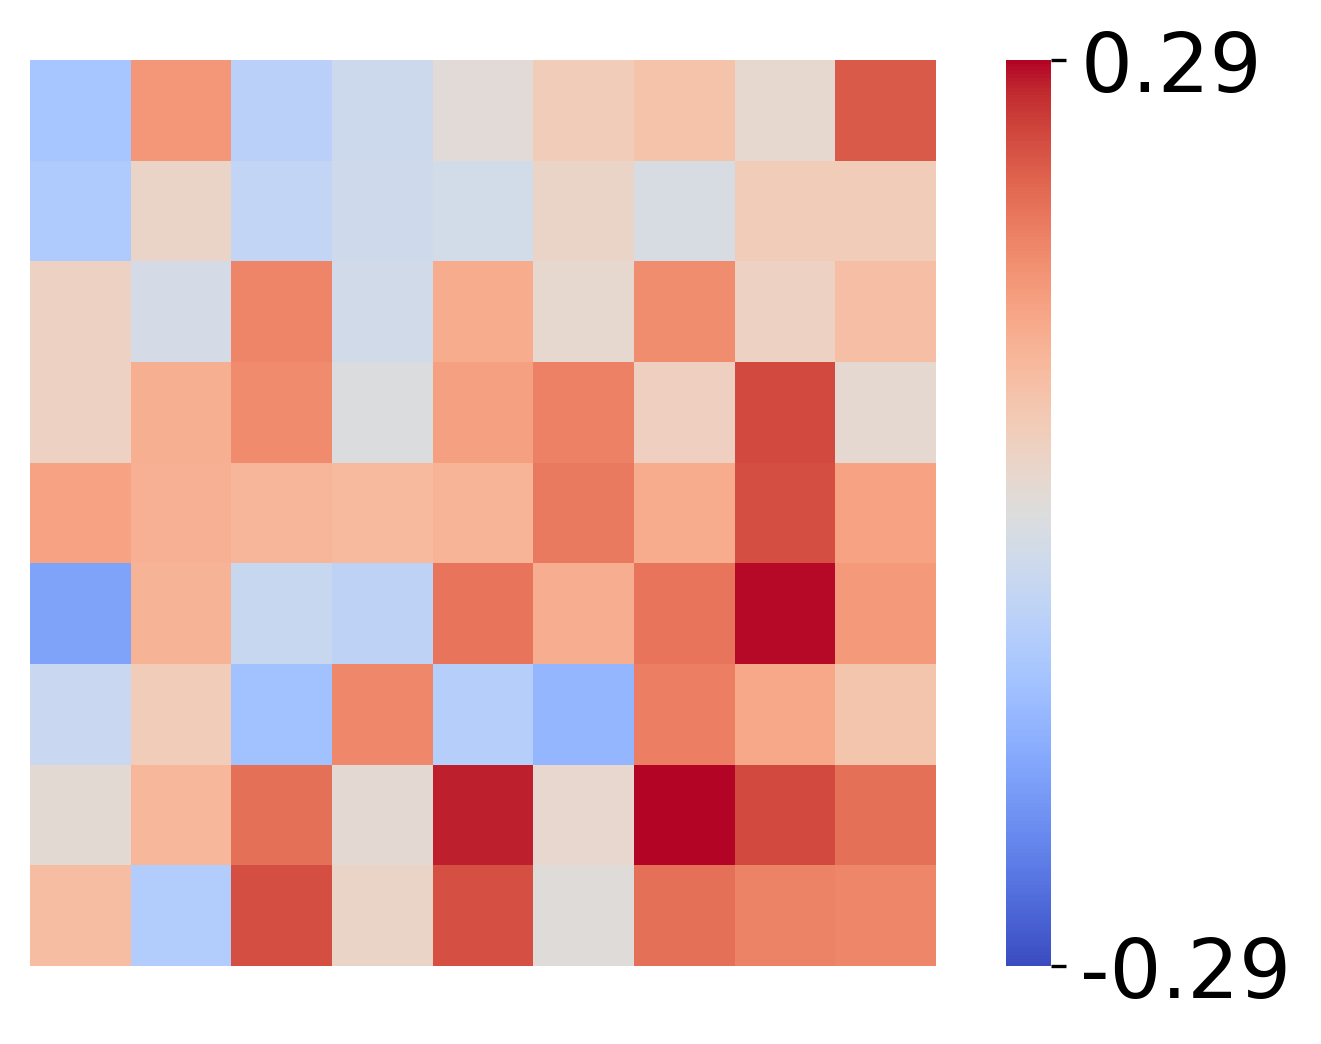

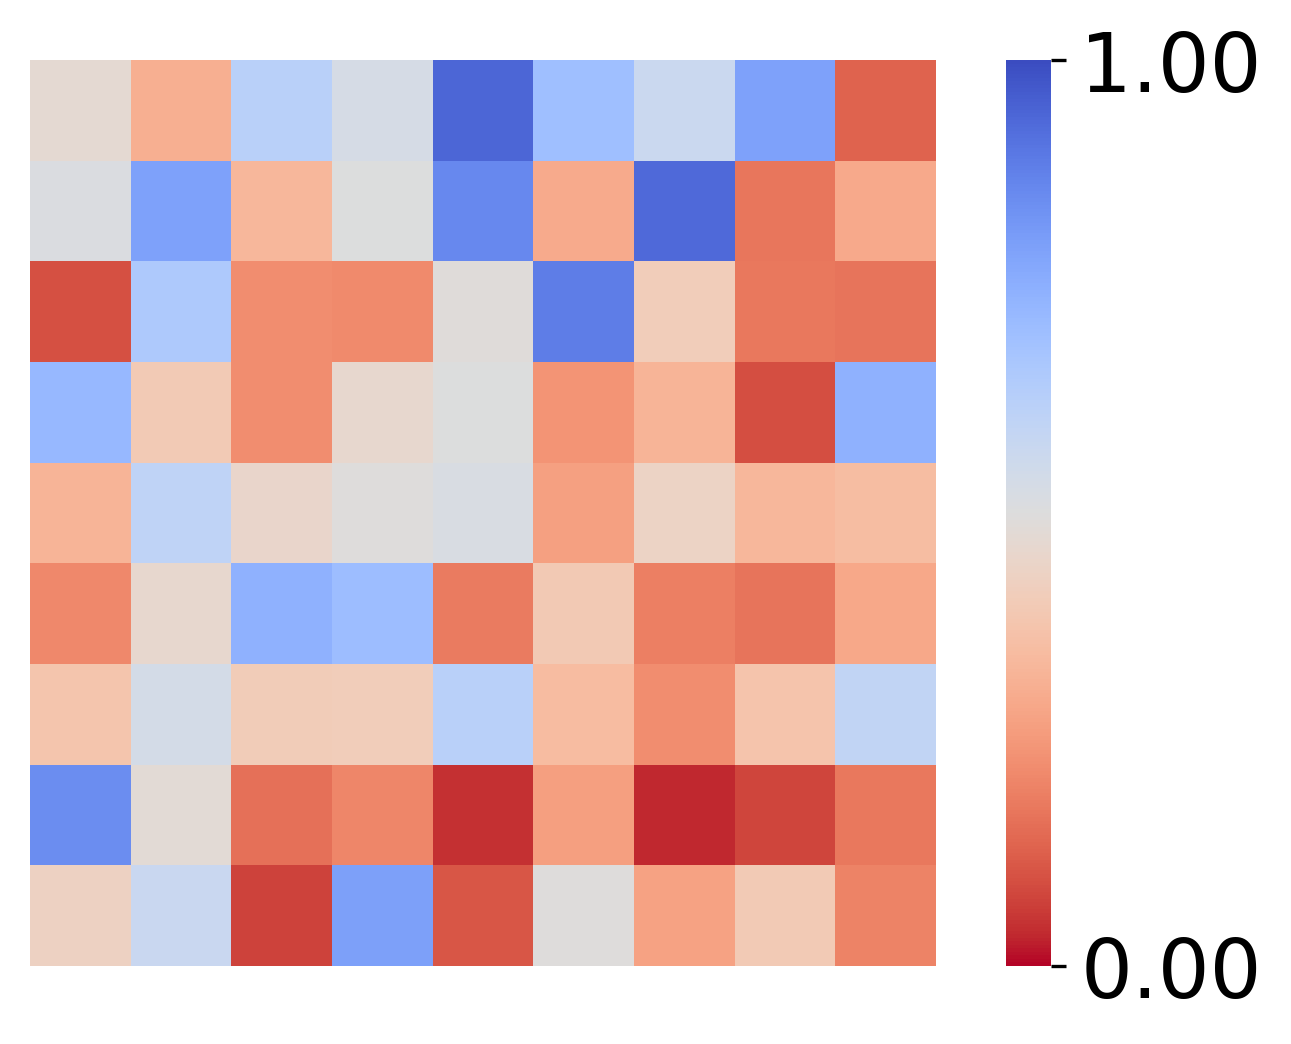

In [179]:
from human_utils_behavioral_analysis import compute_2D_correlation

corr_fig, pvs_fig = compute_2D_correlation(df['rewards_tallies_day2'], df['rewards_tallies_day3'], df['effs_day2'], df['effs_day3'], "Rewards Task 1", "Rewards Task 2", annot=False, groups=df['group_day1'], resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [180]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_rewards_humans.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_rewards_humans.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_rewards_humans.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_rewards_humans.svg'))

### Trait-level Perturbations

In [181]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t1 as sim_timestamp

sim_rewss_t1, sim_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss_t1 = sim_rewss_t1.mean(axis=0)
sim_obss_t1 = sim_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
sim_rewss_t1 = np.flip(sim_rewss_t1.T, axis=1)
sim_obss_t1 = np.flip(sim_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t2 as sim_timestamp

effs_sorted = effs = np.arange(0, 1.01, 0.125)

sim_rewss_t2, sim_obss_t2, sim_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss_t2 = sim_rewss_t2.mean(axis=0)
sim_obss_t2 = sim_obss_t2.mean(axis=0)
sim_sleepss_t2 = sim_sleepss_t2.mean(axis=0)


## correcting for switching from tau to efficacy
sim_rewss_t2 = np.flip(sim_rewss_t2.T, axis=1)
sim_obss_t2 = np.flip(sim_obss_t2.T, axis=1)
sim_sleepss_t2 = np.flip(sim_sleepss_t2.T, axis=1)

(150, 9)


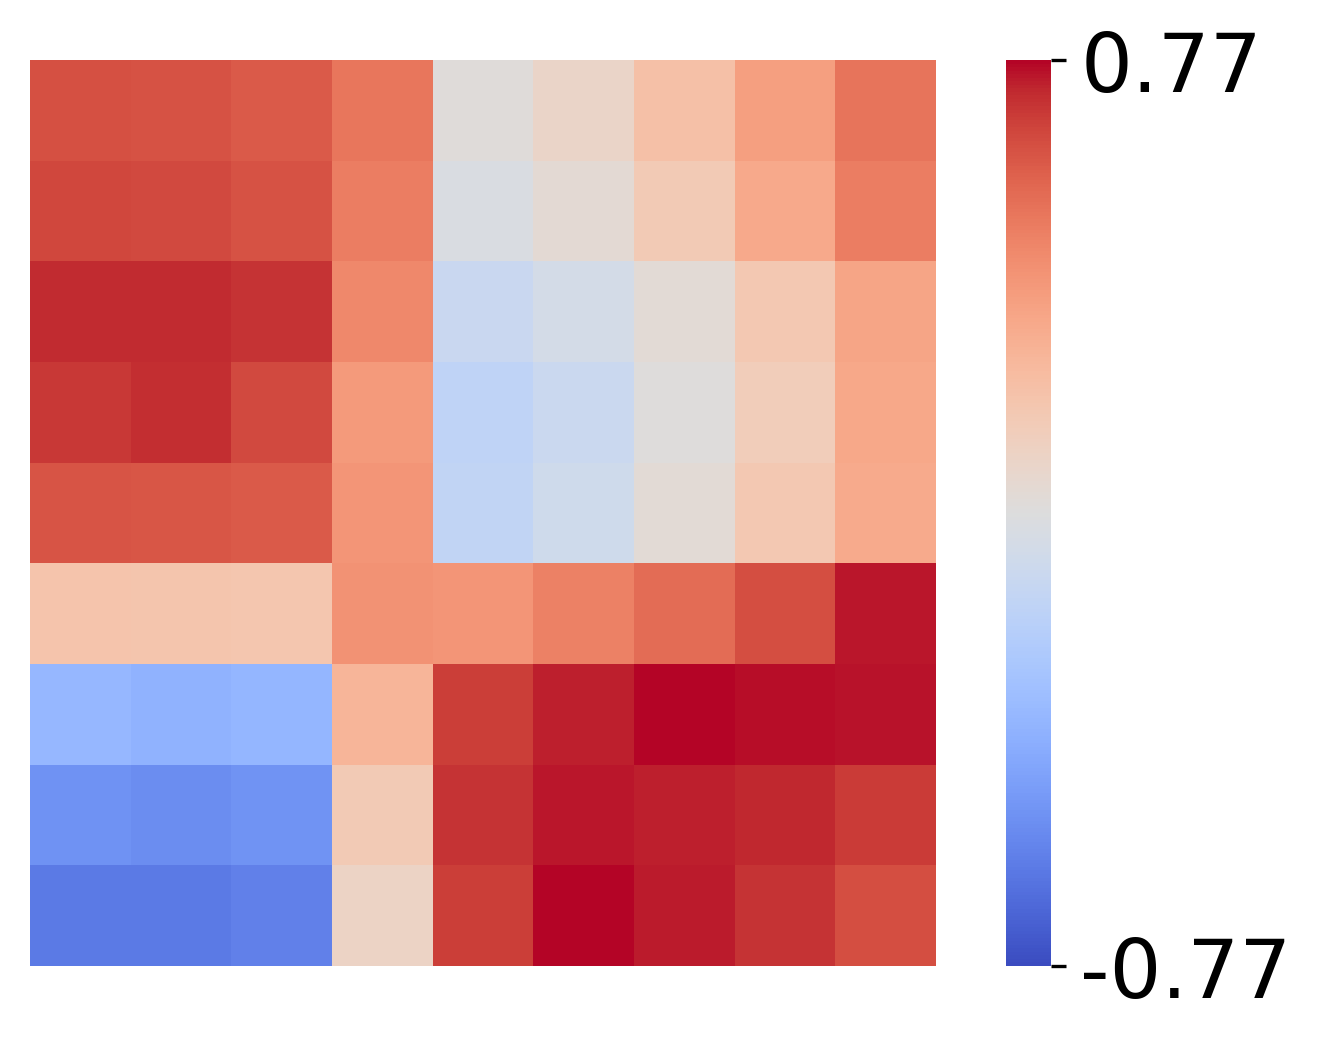

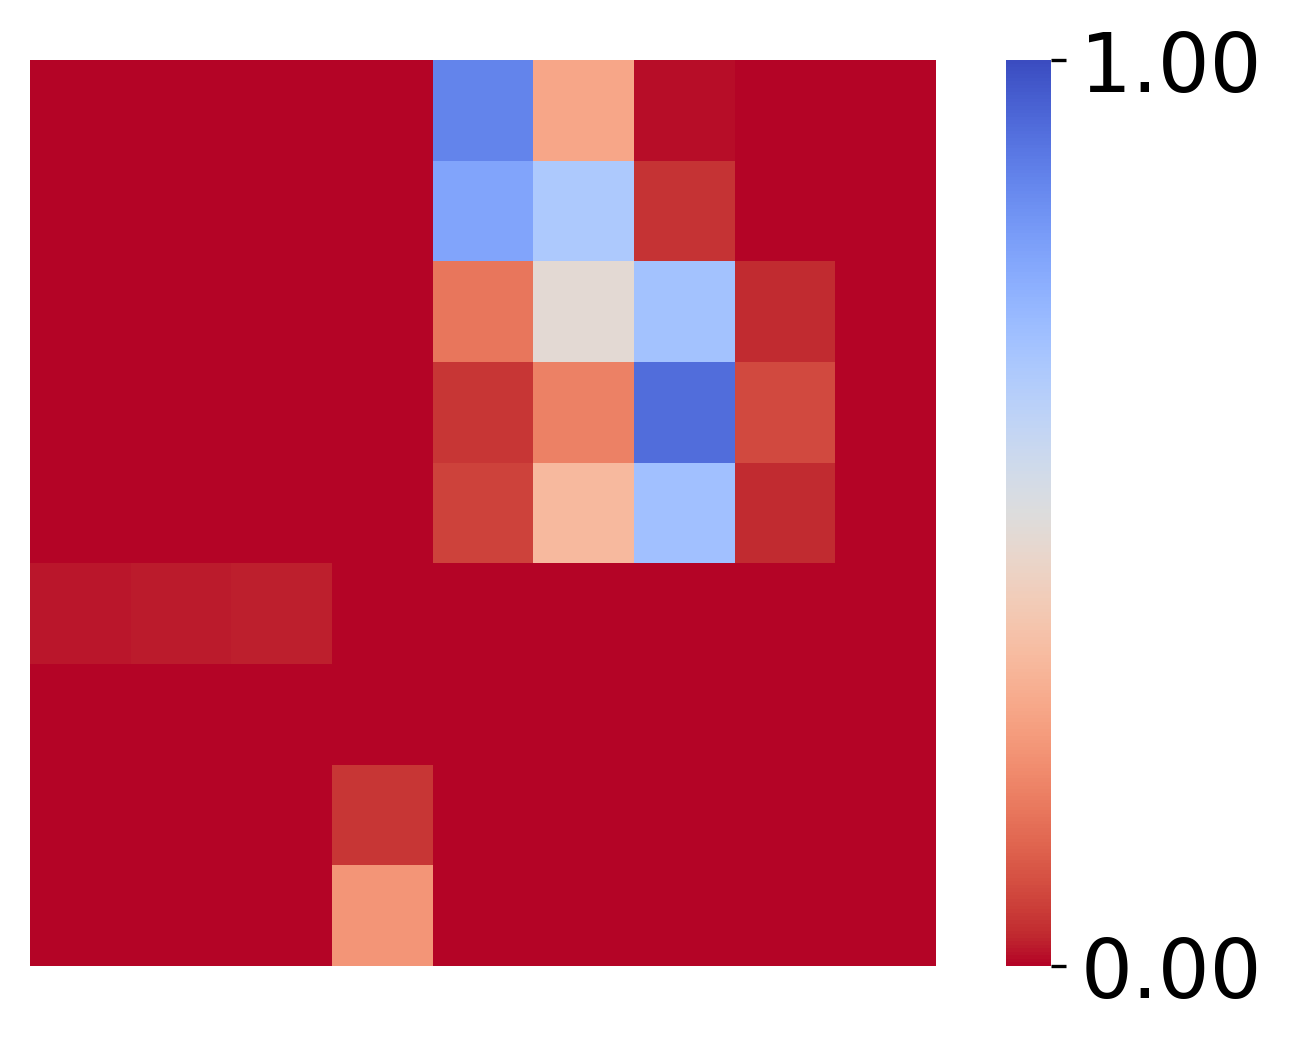

In [182]:
corr_fig, pvs_fig = compute_2D_correlation(sim_rewss_t1, sim_rewss_t2, effs_sorted, effs_sorted, "Rewards Task 1", "Rewards Task 2", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [183]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_rewards_trait.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_rewards_trait.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_rewards_trait.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_rewards_trait.svg'))

### Random Perturbations

In [184]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t1 as sim_timestamp

random_rewss_t1, random_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

random_rewss_t1 = random_rewss_t1.mean(axis=0)
random_obss_t1 = random_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss_t1 = np.flip(random_rewss_t1.T, axis=1)
random_obss_t1 = np.flip(random_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

random_rewss_t2, random_obss_t2, random_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

## post-hoc adjustment to get rid of relationship across tasks - TODO: resample cleanly
rng = np.random.default_rng()
random_rewss_t2 = rng.permuted(random_rewss_t2, axis=-1)
random_obss_t2 = rng.permuted(random_obss_t2, axis=-1)
random_sleepss_t2 = rng.permuted(random_sleepss_t2, axis=-1)

random_rewss_t2 = random_rewss_t2.mean(axis=0)
random_obss_t2 = random_obss_t2.mean(axis=0)
random_sleepss_t2 = random_sleepss_t2.mean(axis=0)

## correcting for switching from tau to efficacy
random_rewss_t2 = np.flip(random_rewss_t2.T, axis=1)
random_obss_t2 = np.flip(random_obss_t2.T, axis=1)
random_sleepss_t2 = np.flip(random_sleepss_t2.T, axis=1)

(150, 9)


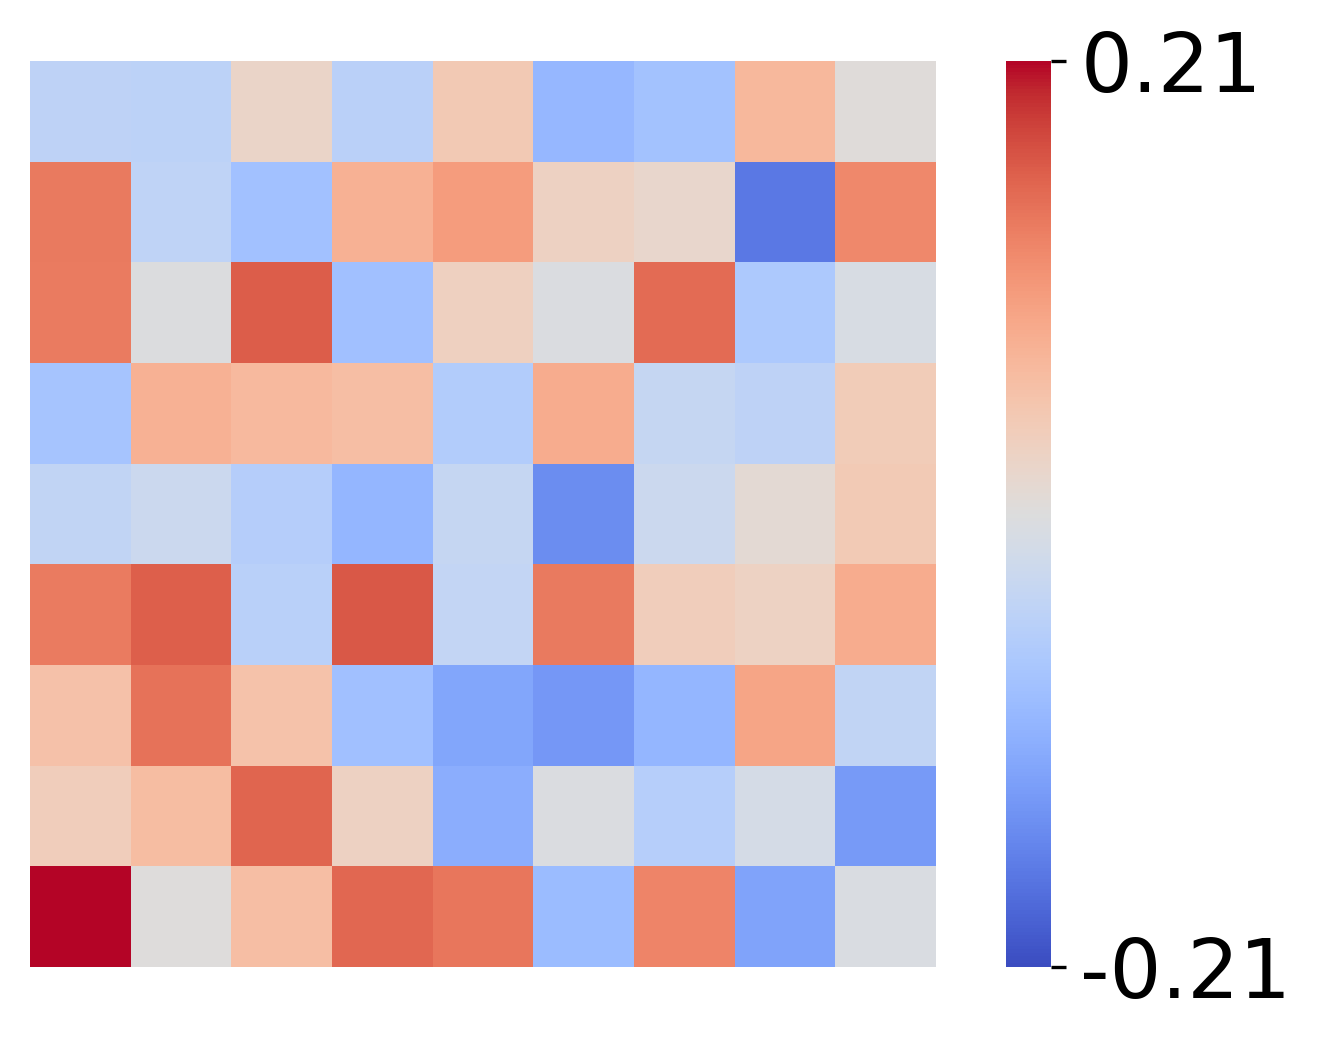

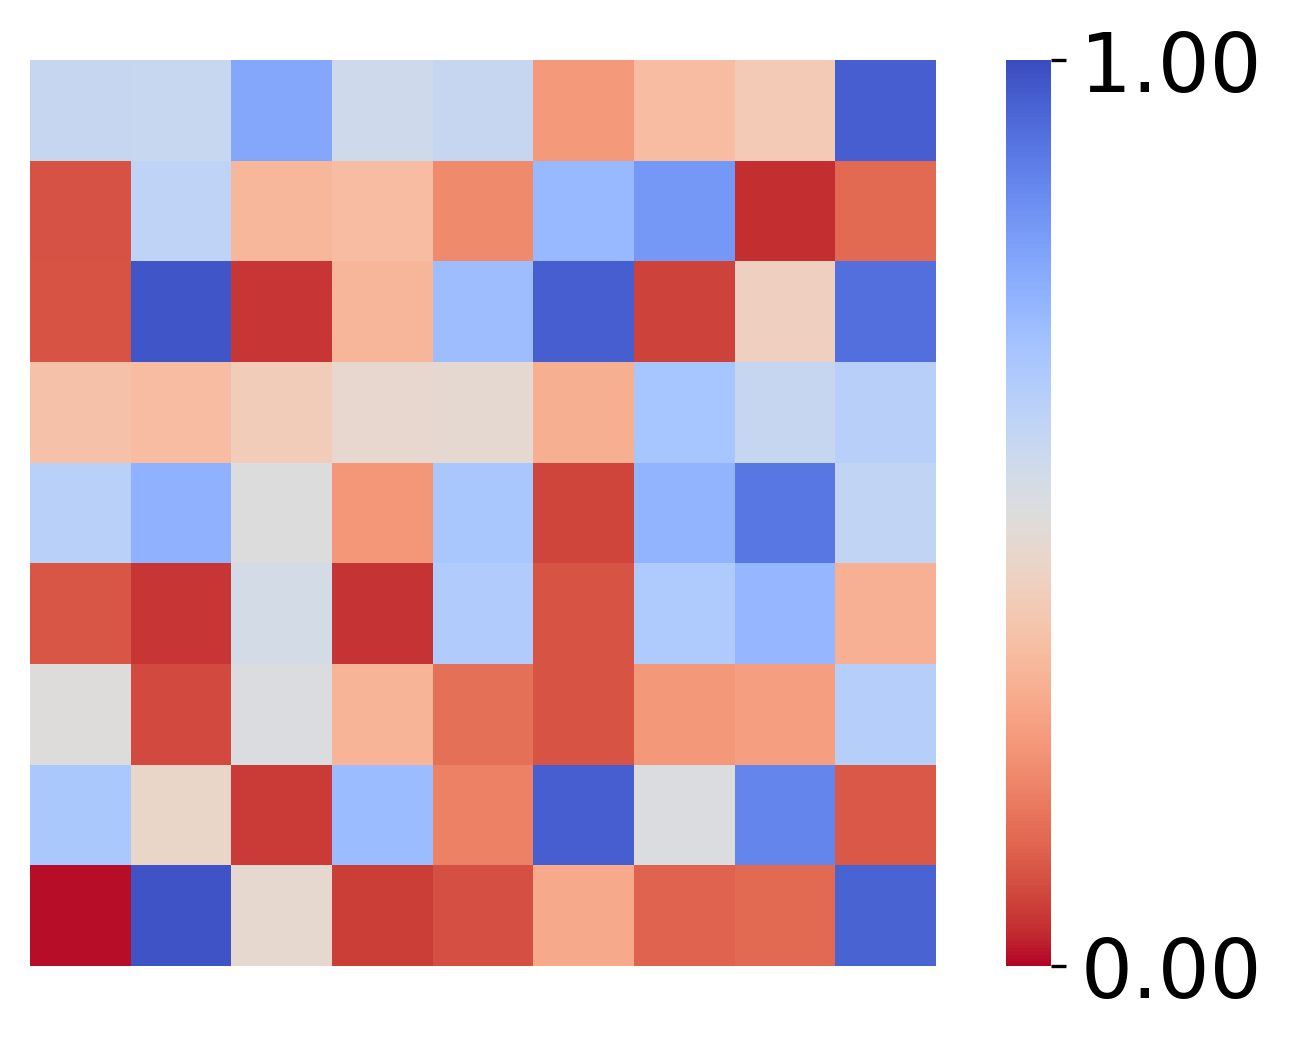

In [185]:
corr_fig, pvs_fig = compute_2D_correlation(random_rewss_t1, random_rewss_t2, effs, effs, "Rewards Task 1", "Rewards Task 2", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [186]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_rewards_random.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_rewards_random.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_rewards_random.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_rewards_random.svg'))

### Zeros Perturbation

In [187]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models

from settings_ana import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t1 as sim_timestamp

zeros_rewss_t1, zeros_obss_t1, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)

zeros_rewss_t1 =zeros_rewss_t1.mean(axis=0)
zeros_obss_t1 = zeros_obss_t1.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss_t1 = np.flip(zeros_rewss_t1.T, axis=1)
zeros_obss_t1 = np.flip(zeros_obss_t1.T, axis=1)

from settings_ana import levc_human_ape_models as ape_models
from settings_ana import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_ana import zeros_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)
effs_sorted = np.arange(0, 1.01, 0.125)

zeros_rewss_t2, zeros_obss_t2,zeros_sleepss_t2 = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)

## TODO: Check to make sure this is no longer necessary
rng = np.random.default_rng()
zeros_rewss_t2 = rng.permuted(zeros_rewss_t2, axis=-1)
zeros_obss_t2 = rng.permuted(zeros_obss_t2, axis=-1)
zeros_sleepss_t2 = rng.permuted(zeros_sleepss_t2, axis=-1)

zeros_rewss_t2 = zeros_rewss_t2.mean(axis=0)
zeros_obss_t2 = zeros_obss_t2.mean(axis=0)
zeros_sleepss_t2 = zeros_sleepss_t2.mean(axis=0)

## correcting for switching from tau to efficacy
zeros_rewss_t2 = np.flip(zeros_rewss_t2.T, axis=1)
zeros_obss_t2 = np.flip(zeros_obss_t2.T, axis=1)
zeros_sleepss_t2 = np.flip(zeros_sleepss_t2.T, axis=1)

(150, 9)


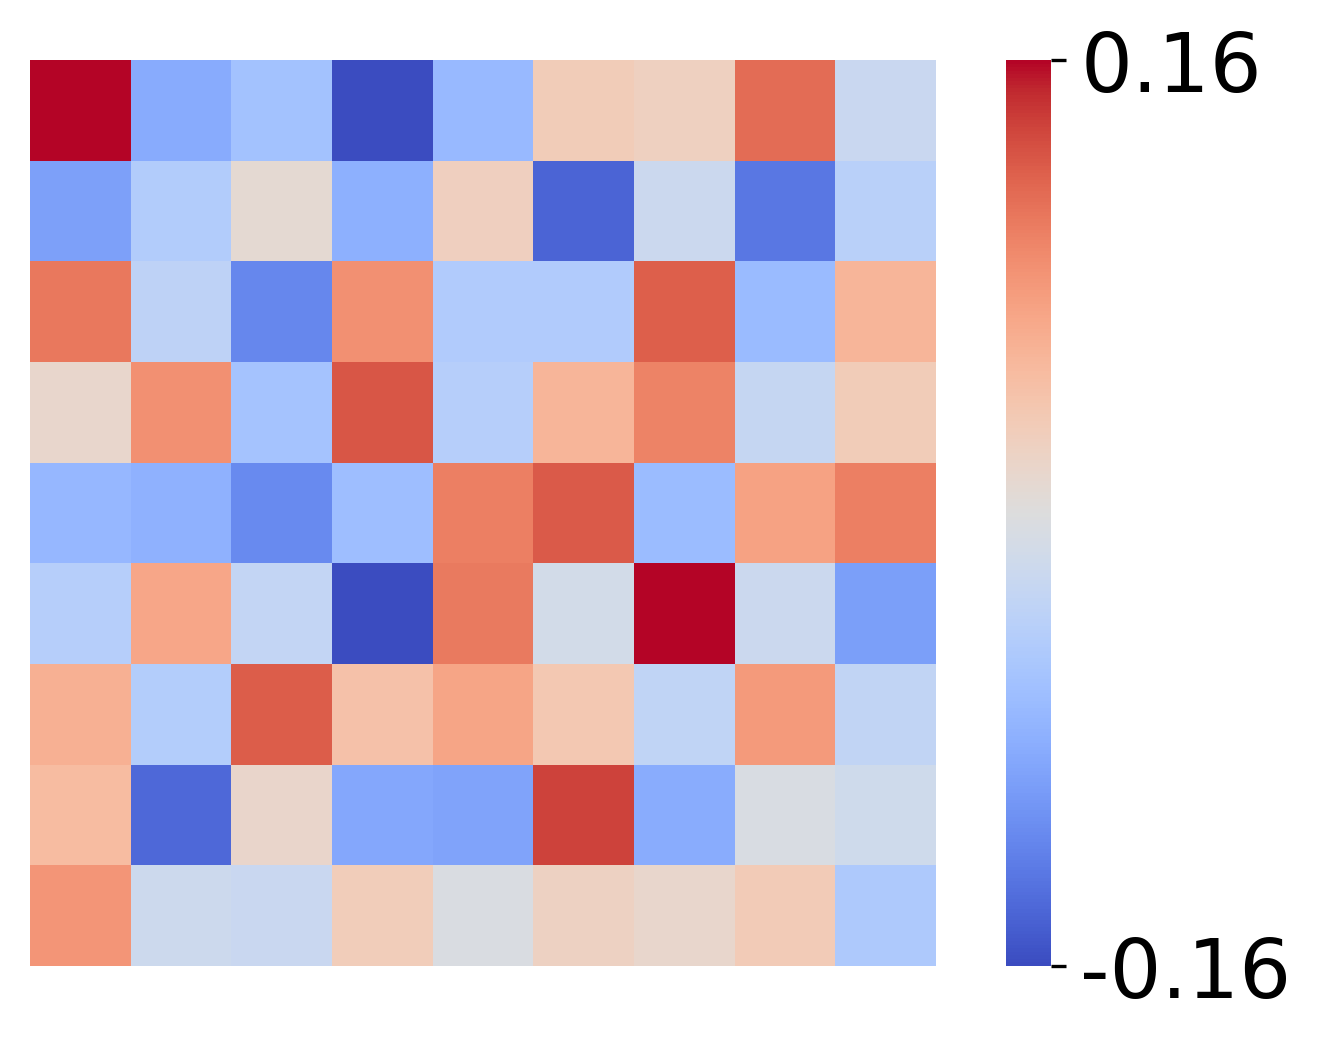

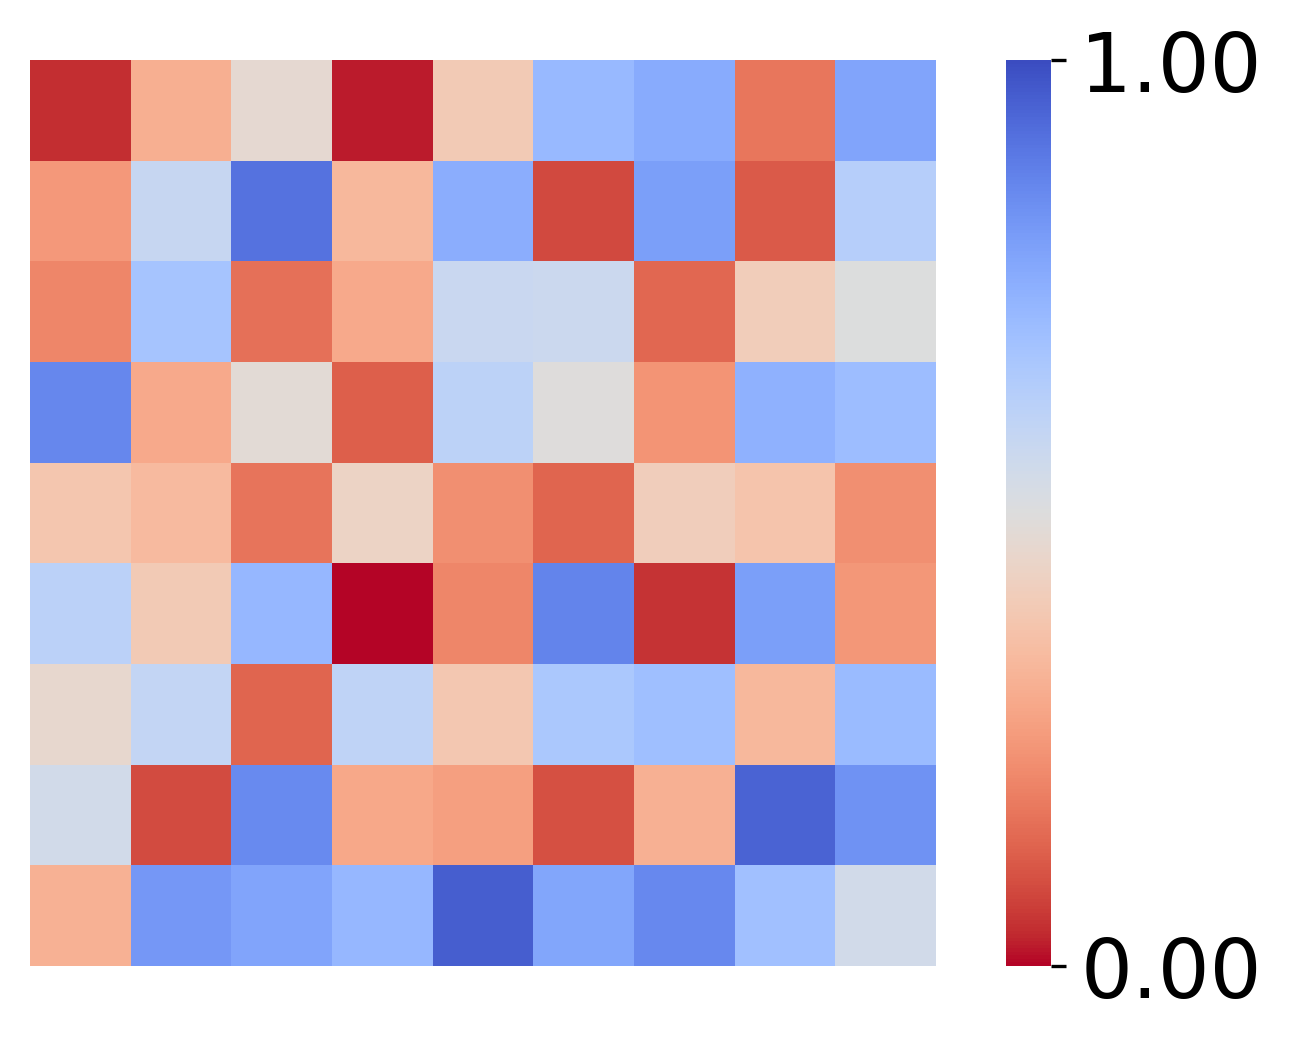

In [188]:
corr_fig, pvs_fig = compute_2D_correlation(zeros_rewss_t1, zeros_rewss_t2, effs, effs, "Rewards Task 1", "Rewards Task 2", annot=False, resize_colorbar=True, square=square, axes_off=axes_off, font_size_multiplier=1.4)

In [189]:
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_rewards_zeros.png'))
corr_fig.savefig(os.path.join(analysis_folder, 'corrs_across_rewards_zeros.svg'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_rewards_zeros.png'))
pvs_fig.savefig(os.path.join(analysis_folder, 'pvs_across_rewards_zeros.svg'))

### Stats

In [190]:
from human_utils_behavioral_analysis import compute_2D_correlation_matrices, compute_partial_2D_correlation_matrices

## day 2
data_obs_corr_g1, data_obs_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group_day2']]['n_observes_day2'].values), np.stack(df[~df['group_day2']]['n_observes_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day3']]['effs_day3'].values),)
data_obs_corr_g2, data_obs_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group_day2']]['n_observes_day2'].values), np.stack(df[df['group_day2']]['n_observes_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day3']]['effs_day3'].values),)

data_rews_corr_g1, data_rews_pvs_g1 = compute_2D_correlation_matrices(np.stack(df[~df['group_day2']]['rewards_tallies_day2'].values), np.stack(df[~df['group_day2']]['rewards_tallies_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day3']]['effs_day3'].values),)
data_rews_corr_g2, data_rews_pvs_g2 = compute_2D_correlation_matrices(np.stack(df[df['group_day2']]['rewards_tallies_day2'].values), np.stack(df[df['group_day2']]['rewards_tallies_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day3']]['effs_day3'].values),)

data_obs_corr = (~df['group_day2']).sum() / len(df) * data_obs_corr_g1 + (df['group_day2']).sum() / len(df) * data_obs_corr_g2
data_obs_pvs = (~df['group_day2']).sum() / len(df) * data_obs_pvs_g1 + (df['group_day2']).sum() / len(df) * data_obs_pvs_g2

data_rews_corr = (~df['group_day2']).sum() / len(df) * data_rews_corr_g1 + (df['group_day2']).sum() / len(df) * data_rews_corr_g2
data_rews_pvs = (~df['group_day2']).sum() / len(df) * data_rews_pvs_g1 + (df['group_day2']).sum() / len(df) * data_rews_pvs_g2

data_sleeps_corr_g1, data_sleeps_pvs_g1 = compute_partial_2D_correlation_matrices(np.stack(df[~df['group_day2']]['n_observes_day2'].values), np.stack(df[~df['group_day2']]['n_sleeps_day3'].values), np.stack(df[~df['group_day2']]['n_observes_day3'].values), np.stack(df[~df['group_day2']]['effs_day2'].values), np.stack(df[~df['group_day2']]['effs_day3'].values), np.stack(df[~df['group_day2']]['effs_day3'].values),)
data_sleeps_corr_g2, data_sleeps_pvs_g2 = compute_partial_2D_correlation_matrices(np.stack(df[df['group_day2']]['n_observes_day2'].values), np.stack(df[df['group_day2']]['n_sleeps_day3'].values), np.stack(df[df['group_day2']]['n_observes_day3'].values), np.stack(df[df['group_day2']]['effs_day2'].values), np.stack(df[df['group_day2']]['effs_day3'].values),np.stack(df[df['group_day2']]['effs_day3'].values), )

data_sleeps_corr = (~df['group_day2']).sum() / len(df) * data_sleeps_corr_g1 + (df['group_day2']).sum() / len(df) * data_sleeps_corr_g2
data_sleeps_pvs = (~df['group_day2']).sum() / len(df) * data_sleeps_pvs_g1 + (df['group_day2']).sum() / len(df) * data_sleeps_pvs_g2

sim_obs_corr, sim_obs_pvs = compute_2D_correlation_matrices(sim_obss_t1, sim_obss_t2, effs, effs,)
sim_rews_corr, sim_rews_pvs = compute_2D_correlation_matrices(sim_rewss_t1, sim_rewss_t2, effs, effs,)
sim_sleeps_corr, sim_sleeps_pvs = compute_partial_2D_correlation_matrices(sim_obss_t1, sim_sleepss_t2, sim_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False,)
random_obs_corr, random_obs_pvs = compute_2D_correlation_matrices(random_obss_t1, random_obss_t2, effs, effs,)
random_rews_corr, random_rews_pvs = compute_2D_correlation_matrices(random_rewss_t1, random_rewss_t2, effs, effs,)
random_sleeps_corr, random_sleeps_pvs = compute_partial_2D_correlation_matrices(random_obss_t1, random_sleepss_t2, random_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False,)

zeros_obs_corr, zeros_obs_pvs = compute_2D_correlation_matrices(zeros_obss_t1, zeros_obss_t2, effs, effs,)
zeros_rews_corr, zeros_rews_pvs = compute_2D_correlation_matrices(zeros_rewss_t1, zeros_rewss_t2, effs, effs,)
zeros_sleeps_corr, zeros_sleeps_pvs = compute_partial_2D_correlation_matrices(zeros_obss_t1, zeros_sleepss_t2, zeros_obss_t2, effs_sorted, effs_sorted, effs_sorted, semi=False,)

(46, 9)
(65, 9)
(46, 9)
(65, 9)
(46, 9)
          n        r          CI95%    p-val
pearson  46  0.16779  [-0.13, 0.44]  0.27058
          n         r          CI95%     p-val
pearson  46  0.150584  [-0.15, 0.43]  0.323462
          n         r         CI95%    p-val
pearson  46  0.094526  [-0.2, 0.38]  0.53681
          n         r          CI95%     p-val
pearson  46 -0.085092  [-0.37, 0.21]  0.578374
          n         r          CI95%     p-val
pearson  46  0.185669  [-0.11, 0.45]  0.222046
          n         r          CI95%     p-val
pearson  46  0.275501  [-0.02, 0.53]  0.066991
          n         r          CI95%     p-val
pearson  46  0.113613  [-0.19, 0.39]  0.457417
          n         r          CI95%     p-val
pearson  46  0.135381  [-0.16, 0.41]  0.375241
          n         r          CI95%     p-val
pearson  46  0.025859  [-0.27, 0.32]  0.866102
          n         r          CI95%     p-val
pearson  46  0.260511  [-0.04, 0.51]  0.083923
          n         r       

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r          CI95%     p-val
pearson  46 -0.265001  [-0.52, 0.03]  0.078533
          n         r         CI95%    p-val
pearson  46  0.099403  [-0.2, 0.38]  0.51591
          n         r          CI95%     p-val
pearson  46  0.137246  [-0.16, 0.41]  0.368635
          n         r          CI95%     p-val
pearson  46 -0.105472  [-0.39, 0.19]  0.490481
          n         r          CI95%     p-val
pearson  46  0.078265  [-0.22, 0.36]  0.609332
          n         r          CI95%     p-val
pearson  46 -0.092073  [-0.38, 0.21]  0.547477
          n         r          CI95%     p-val
pearson  46  0.074225  [-0.22, 0.36]  0.627978
          n         r         CI95%     p-val
pearson  46 -0.100197  [-0.38, 0.2]  0.512545
          n         r          CI95%    p-val
pearson  46  0.287822  [-0.01, 0.54]  0.05521
          n         r          CI95%     p-val
pearson  46 -0.167634  [-0.44, 0.13]  0.271031
          n         r         CI95%     p-val
pearson  46  0.360507 

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r         CI95%     p-val
pearson  65  0.269944  [0.03, 0.48]  0.030989
          n         r          CI95%     p-val
pearson  65 -0.103397  [-0.34, 0.15]  0.416187
          n        r          CI95%     p-val
pearson  65  0.08722  [-0.16, 0.33]  0.493145
          n        r          CI95%     p-val
pearson  65 -0.12848  [-0.36, 0.12]  0.311643
          n         r          CI95%     p-val
pearson  65  0.024056  [-0.22, 0.27]  0.850344
          n         r          CI95%    p-val
pearson  65  0.002273  [-0.24, 0.25]  0.98578
          n         r         CI95%     p-val
pearson  65  0.149846  [-0.1, 0.38]  0.237275
          n         r         CI95%     p-val
pearson  65  0.058251  [-0.19, 0.3]  0.647519
          n         r          CI95%     p-val
pearson  65 -0.026624  [-0.27, 0.22]  0.834577
          n         r          CI95%     p-val
pearson  65  0.001271  [-0.24, 0.25]  0.992048
          n         r          CI95%     p-val
pearson  65  0.017048  [-

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

          n         r          CI95%     p-val
pearson  65  0.010699  [-0.24, 0.26]  0.933127
          n        r          CI95%     p-val
pearson  65 -0.13858  [-0.37, 0.11]  0.274802
          n         r         CI95%    p-val
pearson  65 -0.054031  [-0.3, 0.19]  0.67154
          n         r          CI95%     p-val
pearson  65 -0.095346  [-0.33, 0.15]  0.453588
          n         r          CI95%     p-val
pearson  65 -0.030104  [-0.27, 0.22]  0.813328
          n         r          CI95%    p-val
pearson  65 -0.192279  [-0.42, 0.06]  0.12797
          n         r          CI95%     p-val
pearson  65 -0.098985  [-0.34, 0.15]  0.436458
          n         r          CI95%     p-val
pearson  65 -0.190797  [-0.42, 0.06]  0.130991
          n        r          CI95%     p-val
pearson  65 -0.07985  [-0.32, 0.17]  0.530522
          n         r          CI95%     p-val
pearson  65  0.004158  [-0.24, 0.25]  0.973985
          n         r          CI95%     p-val
pearson  65 -0.231615  

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r           CI95%         p-val
pearson  150 -0.514216  [-0.62, -0.39]  1.977029e-11
           n         r           CI95%         p-val
pearson  150 -0.456017  [-0.57, -0.32]  5.085399e-09
           n         r          CI95%     p-val
pearson  150 -0.354103  [-0.49, -0.2]  0.000009
           n         r           CI95%     p-val
pearson  150 -0.285463  [-0.43, -0.13]  0.000417
           n         r           CI95%     p-val
pearson  150 -0.173572  [-0.33, -0.01]  0.034263
           n         r           CI95%     p-val
pearson  150 -0.230058  [-0.38, -0.07]  0.004765
           n         r          CI95%         p-val
pearson  150 -0.480599  [-0.6, -0.35]  5.535389e-10
           n         r           CI95%         p-val
pearson  150 -0.667863  [-0.75, -0.57]  1.364201e-20
           n        r           CI95%         p-val
pearson  150 -0.75805  [-0.82, -0.68]  4.460498e-29
           n         r           CI95%         p-val
pearson  150 -0.818534  [-0.87,

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150 -0.017141  [-0.18, 0.14]  0.835628
           n         r          CI95%     p-val
pearson  150 -0.009463  [-0.17, 0.15]  0.908805
           n         r          CI95%     p-val
pearson  150 -0.014937  [-0.18, 0.15]  0.856518
           n         r          CI95%     p-val
pearson  150  0.009192  [-0.15, 0.17]  0.911407
           n         r         CI95%     p-val
pearson  150  0.220512  [0.06, 0.37]  0.006885
           n         r          CI95%     p-val
pearson  150  0.003834  [-0.16, 0.16]  0.962986
           n         r          CI95%     p-val
pearson  150 -0.031516  [-0.19, 0.13]  0.702793
           n        r          CI95%     p-val
pearson  150 -0.01215  [-0.17, 0.15]  0.883075
           n         r         CI95%     p-val
pearson  150  0.037156  [-0.12, 0.2]  0.652793
           n         r          CI95%     p-val
pearson  150  0.115404  [-0.05, 0.27]  0.161064
           n         r         CI95%     p-val

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150 -0.013287  [-0.17, 0.15]  0.872224
           n         r          CI95%     p-val
pearson  150 -0.007662  [-0.17, 0.15]  0.926107
           n         r          CI95%    p-val
pearson  150  0.011919  [-0.15, 0.17]  0.88529
           n         r          CI95%    p-val
pearson  150 -0.108852  [-0.27, 0.05]  0.18635
           n         r          CI95%     p-val
pearson  150 -0.094109  [-0.25, 0.07]  0.253617
           n         r         CI95%     p-val
pearson  150  0.061947  [-0.1, 0.22]  0.452947
           n         r          CI95%     p-val
pearson  150  0.006826  [-0.15, 0.17]  0.934157
           n         r          CI95%    p-val
pearson  150 -0.117017  [-0.27, 0.04]  0.15525
           n         r          CI95%     p-val
pearson  150  0.108196  [-0.05, 0.26]  0.189037
           n         r          CI95%     p-val
pearson  150  0.004845  [-0.16, 0.17]  0.953233
           n         r          CI95%     p-val


/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150  0.124201  [-0.04, 0.28]  0.131262
           n         r          CI95%     p-val
pearson  150  0.024615  [-0.14, 0.18]  0.765723
           n         r         CI95%     p-val
pearson  150  0.043885  [-0.12, 0.2]  0.595121
           n         r          CI95%     p-val
pearson  150  0.003801  [-0.16, 0.16]  0.963302
           n         r          CI95%     p-val
pearson  150  0.032613  [-0.13, 0.19]  0.692955
           n         r          CI95%     p-val
pearson  150 -0.055166  [-0.21, 0.11]  0.503987
           n        r          CI95%    p-val
pearson  150 -0.04756  [-0.21, 0.11]  0.56463
           n         r          CI95%     p-val
pearson  150 -0.134394  [-0.29, 0.03]  0.102239
           n         r         CI95%     p-val
pearson  150 -0.157112  [-0.31, 0.0]  0.055678
           n         r          CI95%     p-val
pearson  150  0.028726  [-0.13, 0.19]  0.728018
           n         r          CI95%   p-val
pe

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

           n         r          CI95%     p-val
pearson  150 -0.004892  [-0.17, 0.16]  0.952784
           n         r          CI95%     p-val
pearson  150  0.074353  [-0.09, 0.23]  0.367482
           n         r         CI95%     p-val
pearson  150 -0.038524  [-0.2, 0.12]  0.640888
           n         r          CI95%     p-val
pearson  150 -0.050291  [-0.21, 0.11]  0.542461
           n        r         CI95%     p-val
pearson  150  0.04205  [-0.12, 0.2]  0.610617
           n         r          CI95%     p-val
pearson  150 -0.140611  [-0.29, 0.02]  0.087187
           n         r          CI95%    p-val
pearson  150 -0.004484  [-0.17, 0.16]  0.95672
           n         r         CI95%     p-val
pearson  150  0.039777  [-0.12, 0.2]  0.630057
           n         r         CI95%     p-val
pearson  150  0.045407  [-0.12, 0.2]  0.582401
           n         r          CI95%     p-val
pearson  150 -0.027893  [-0.19, 0.13]  0.735605
           n         r          CI95%     p-val
pear

/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pvs_matrix[i, j] = stats['p-val']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:441: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  corr_matrix[i, j] = stats['r']
/home/kai/Documents/Projects/learning-metacontrol/humans/human_utils_behavioral_analysis.py:442: FutureWarning: Calling float on a single element Series is deprecated and will ra

In [191]:
from human_utils_behavioral_analysis import competitive_corr_regression

competitive_corr_regression((data_rews_corr), [(sim_rews_corr), (random_rews_corr), (zeros_rews_corr)])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.3780
Date:                Mon, 07 Oct 2024   Prob (F-statistic):              0.769
Time:                        15:55:06   Log-Likelihood:                 65.008
No. Observations:                  81   AIC:                            -122.0
Df Residuals:                      77   BIC:                            -112.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0719      0.016      4.362      0.0

#### Cosine Similarity

In [192]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(data_rews_corr.reshape((1,-1)), sim_rews_corr.reshape((1,-1)))[0][0])
print(cosine_similarity(data_rews_corr.reshape((1,-1)), random_rews_corr.reshape((1,-1)))[0][0])

0.44408509890183717
0.06004259659855874


## Panel H: Aggregated Similarities Bar Plot

In [193]:
from human_utils_behavioral_analysis import upper_tri_masking
from human_utils_behavioral_analysis import compute_2D_correlation_matrices, compute_partial_2D_correlation_matrices
from sklearn.utils import resample

def combine_group_correlation_matrices(values, effs, groups, values2 = None, effs2 = None, covar = None, effs_covar = None):
    if values2 is None:
        values2 = values.copy()
    if effs2 is None:
        effs2 = effs.copy()

    if covar is None:
        data_corr_g1, data_pvs_g1 = compute_2D_correlation_matrices(np.stack(values[~groups].values), np.stack(values2[~groups].values), np.stack(effs[~groups].values), np.stack(effs2[~groups].values),)
        data_corr_g2, data_pvs_g2 = compute_2D_correlation_matrices(np.stack(values[groups].values), np.stack(values2[groups].values), np.stack(effs[groups].values), np.stack(effs[groups].values),)    
    else:
        data_corr_g1, data_pvs_g1 = compute_partial_2D_correlation_matrices(np.stack(values[~groups].values), np.stack(values2[~groups].values), np.stack(covar[~groups].values), np.stack(effs[~groups].values), np.stack(effs2[~groups].values), np.stack(effs_covar[~groups].values))
        data_corr_g2, data_pvs_g2 = compute_partial_2D_correlation_matrices(np.stack(values[groups].values), np.stack(values2[groups].values), np.stack(covar[groups].values), np.stack(effs[groups].values), np.stack(effs[groups].values), np.stack(effs_covar[groups].values))

    data_corr = (~groups).sum() / len(df) * data_corr_g1 + (groups).sum() / len(df) * data_corr_g2
    data_pvs = (~groups).sum() / len(df) * data_pvs_g1 + (groups).sum() / len(df) * data_pvs_g2

    return data_corr, data_pvs

def compute_cosine_similarity(a, b, upper_tri = True):
    from sklearn.metrics.pairwise import cosine_similarity
    if upper_tri:
        a = upper_tri_masking(a)
        b = upper_tri_masking(b)
    return cosine_similarity(a.reshape((1,-1)), b.reshape((1,-1)))[0][0]

def compute_resampled_cosine_similarity(item, groups, item_effs,  comparison, item2=None, item2_effs = None, comparison2 = None, covar=None, effs_covar=None, comparison_covar = None, effs = np.arange(0, 1.01, 0.125), n_iterations = 100, upper_tri = True):

    if comparison2 is None:
        comparison2 = comparison.copy()

    bootstrapped_cos_sims = []
    for _ in range(n_iterations):
        indicesA = item.index[np.where(groups == False)[0]]
        indicesB = item.index[np.where(groups == True)[0]]

        bootstrapped_indicesA = resample(indicesA, replace=True, n_samples=len(indicesA))
        bootstrapped_indicesB = resample(indicesB, replace=False, n_samples=len(indicesB))
        bootstrapped_indices = np.sort(np.concatenate((bootstrapped_indicesA, bootstrapped_indicesB)))

        #bootstrapped_indices_comparison = resample(np.arange(len(comparison)), replace=True, n_samples=len(comparison))

        if item2 is not None:
            print(item)
            print(item2)
            item2_subindexed = item2.loc[bootstrapped_indices].copy()
        else:
            item2_subindexed = item2
        if covar is not None:
            covar_subindexed = covar.loc[bootstrapped_indices].copy()
        else:
            covar_subindexed = covar
        if effs_covar is not None:
            effs_covar_subindexed = effs_covar.loc[bootstrapped_indices].copy()
        else:
            effs_covar_subindexed = effs_covar
        if item2_effs is not None:
            item2_effs_subindexed = item2_effs.loc[bootstrapped_indices].copy()
        else:
            item2_effs_subindexed = item2_effs

        bootstrapped_data_corr, bootstrapped_data_pvs = combine_group_correlation_matrices(item.loc[bootstrapped_indices], item_effs.loc[bootstrapped_indices], groups.loc[bootstrapped_indices], covar=covar_subindexed, effs_covar=effs_covar_subindexed, values2=item2_subindexed, effs2 = item2_effs_subindexed)
        if comparison_covar is None:
            bootstrapped_comp_corr, bootstrapped_comp_pvs = compute_2D_correlation_matrices(comparison, comparison2, effs, effs)
        else:
            bootstrapped_comp_corr, bootstrapped_comp_pvs = compute_partial_2D_correlation_matrices(comparison, comparison2, comparison_covar, effs, effs, effs)

        bootstrapped_cos_sim = compute_cosine_similarity(bootstrapped_data_corr, bootstrapped_comp_corr, upper_tri = upper_tri)
        bootstrapped_cos_sims.append(bootstrapped_cos_sim)
    return bootstrapped_cos_sims


In [13]:

%%capture

n_iterations = 100

rows = []

### IMPORT EFFICACY ESTIMATES FOR SIMULATIONS
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import trait_sim_timestamp_t1 as sim_timestamp

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

sim_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations).T

from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_ana import pepe_human_ape_models as ape_models
from settings_ana import random_simulated_participants_folder_t1 as simulated_participants_folder
from settings_ana import random_sim_timestamp_t1 as sim_timestamp

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'random', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_random_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

### CONSTRUCT SIM_ESTS
random_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)) + sim_participant_perturbations)

### TASK 1
#for item_name, item, comparisons in zip(['Obs', 'Rews'], [df['n_observes_day2'], df['rewards_tallies_day2']], [[sim_obss_t1, random_obss_t1], [sim_rewss_t1, random_rewss_t1]]):
for item_name, item, comparisons in zip(['Rews','Obs', 'Ests'], [df['rewards_tallies_day2'],df['n_observes_day2'], df['efficacy_estimates_day2']], [ [sim_rewss_t1, random_rewss_t1],[sim_obss_t1, random_obss_t1], [sim_estss, random_estss]]):
    data_corr, data_pvs = combine_group_correlation_matrices(item, df['effs_day2'], df['group_day2'].values,)
    for comparison_name, comparison in zip(['Trait', 'Random'], comparisons):
        comp_corr, comp_pvs = compute_2D_correlation_matrices(comparison, comparison, effs, effs)
        cos_sim = compute_cosine_similarity(data_corr, comp_corr)

        bootstrapped_cos_sims = compute_resampled_cosine_similarity(item, df['group_day2'], df['effs_day2'], comparison, n_iterations=n_iterations)

        ci =  pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
        rows.append({"task": "T1", "item": item_name, "Comparison": comparison_name, "Cosine Similarity": cos_sim, "Lower": ci.iloc[0], "Upper": ci.iloc[1]})

### TASK 2
for item_name, item, comparisons in zip([ 'Rews', 'Sleeps', 'Obs',],
                                         [ df['rewards_tallies_day3'], df['n_sleeps_day3'], df['n_observes_day3'],], 
                                         [[sim_rewss_t2, random_rewss_t2],
                                          [sim_sleepss_t2, random_sleepss_t2],
                                            [sim_obss_t2, random_obss_t2], 
                                            ]):
    data_corr, data_pvs = combine_group_correlation_matrices(item, df['effs_day3'], df['group_day2'].values,)
    for comparison_name, comparison in zip(['Trait', 'Random'], comparisons):
        comp_corr, comp_pvs = compute_2D_correlation_matrices(comparison, comparison, effs, effs)
        cos_sim = compute_cosine_similarity(data_corr, comp_corr)
        bootstrapped_cos_sims = compute_resampled_cosine_similarity(item, df['group_day3'], df['effs_day3'], comparison, n_iterations=n_iterations)
        ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
        rows.append({"task": "T2", "item": item_name, "Comparison": comparison_name, "Cosine Similarity": cos_sim, "Lower": ci.iloc[0], "Upper": ci.iloc[1]})

    # If desired, I can include the observes task 1-observes task 2 similarity matrix here
    if item_name == 'Observes':
        data_corr, data_pvs = combine_group_correlation_matrices(item, df['effs_day3'], df['group_day2'].values, partial=False)

### ACROSS TASKS
for item_name, item_task1, item_task2, comparisons_task1, comparisons_task2, covar, effs_covar, comparisons_covar in zip(#['Task 1 Observes with Sleeps Task 2*', 'Task 1 Observes with Task 2 Observes', 'Task 1 Rewards with Task 2 Rewards'],
                                        [  'T1 Rews-T2 Rews', 'T1 Obs-T2 Sleeps*', 'T1 Obs-T2 Obs', #'T1 Ests-T1 Obs',
                                          ],
                                        [df['rewards_tallies_day2'],df['n_observes_day2'], df['n_observes_day2'],#  df['n_observes_day2'],
                                            ],
                                        [  df['rewards_tallies_day3'],df['n_sleeps_day3'], df['n_observes_day3'], #df['efficacy_estimates_day2']
                                          ],
                                        [[sim_rewss_t1, random_rewss_t1],
                                        [sim_obss_t1, random_obss_t1],
                                         [sim_obss_t1, random_obss_t1],
                                           # [sim_obss, random_obss],
                                         ],
                                        [[sim_rewss_t2, random_rewss_t2],
                                        [sim_sleepss_t2, random_sleepss_t2],
                                            [sim_obss_t2, random_obss_t2], 
                                            #[sim_estss, random_estss],
                                            ],
                                        [None, df['n_observes_day3'], None,# None
                                            ],
                                        [None, df['effs_day3'], None,# None
                                            ],
                                        [ [None, None],
                                        [sim_obss_t2, random_obss_t2],
                                            [None, None],
                                            #[None, None],
                                           ]):
    print(item_name)
    data_corr, data_pvs = combine_group_correlation_matrices(item_task1, df['effs_day2'], df['group_day2'].values, values2 = item_task2, effs2 = df['effs_day3'], covar=covar, effs_covar=effs_covar)
    for comparison_name, comparison_task1, comparison_task2, comparison_covar in zip(['Trait', 'Random'], comparisons_task1, comparisons_task2, comparisons_covar):
        print(comparison_name)
        if comparison_covar is None:
            comp_corr, comp_pvs = compute_2D_correlation_matrices(comparison_task1, comparison_task2, effs, effs)
        else:
            comp_corr, comp_pvs = compute_partial_2D_correlation_matrices(comparison_task1, comparison_task2, comparison_covar, effs, effs, effs)
        cos_sim = compute_cosine_similarity(data_corr, comp_corr, upper_tri = False)
        
        print(item_task2)
        bootstrapped_cos_sims = compute_resampled_cosine_similarity(item_task1, df['group_day2'], df['effs_day2'],comparison_task1, item2=item_task2, item2_effs=df['effs_day3'], comparison2= comparison_task2, covar=covar, effs_covar=effs_covar, comparison_covar=comparison_covar, n_iterations=n_iterations, upper_tri=False)
        ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])

        rows.append({"task": "Across Tasks", "item": item_name, "Comparison": comparison_name, "Cosine Similarity": cos_sim, "Lower": ci.iloc[0], "Upper": ci.iloc[1]})

### COMBINATION
df_cosim = pd.DataFrame(rows)

df_cosim['Name'] = df_cosim['task'] + ' ' + df_cosim['item']
df_cosim.loc[df_cosim['task'] == "Across Tasks",'Name'] = df_cosim[df_cosim['task'] == "Across Tasks"]['item']

print(df_cosim.head())

df_cosim.to_pickle(os.path.join(analysis_folder, 'df_cosim.pkl'))

In [14]:
df_cosim = pd.read_pickle(os.path.join(analysis_folder, 'df_cosim.pkl'))

In [15]:
df_cosim.round(3)

task               item Comparison  Cosine Similarity  Lower  \
0             T1               Rews      Trait              0.544  0.368   
1             T1               Rews     Random              0.192  0.047   
2             T1                Obs      Trait              0.993  0.983   
3             T1                Obs     Random             -0.207 -0.225   
4             T1               Ests      Trait              0.876  0.798   
5             T1               Ests     Random             -0.049 -0.111   
6             T2               Rews      Trait              0.408  0.250   
7             T2               Rews     Random              0.026 -0.089   
8             T2             Sleeps      Trait              0.957  0.930   
9             T2             Sleeps     Random              0.140  0.116   
10            T2                Obs      Trait              0.996  0.992   
11            T2                Obs     Random              0.119  0.105   
12  Across Tasks    T1 Rews-T2 Rews      Trait              0.444  0.263   
13  Across Tasks    T1 Rews-T2 Rews     Random             -0.226 -0.271   
14  Across Tasks  T1 Obs-T2 Sleeps*      Trait              0.222 -0.036   
15  Across Tasks  T1 Obs-T2 Sleeps*     Random             -0.165 -0.280   
16  Across Tasks      T1 Obs-T2 Obs      Trait              0.992  0.975   
17  Across Tasks      T1 Obs-T2 Obs     Random             -0.132 -0.143   

    Upper               Name  
0   0.614            T1 Rews  
1   0.284            T1 Rews  
2   0.996             T1 Obs  
3  -0.184             T1 Obs  
4   0.905            T1 Ests  
5   0.015            T1 Ests  
6   0.482            T2 Rews  
7   0.148            T2 Rews  
8   0.969          T2 Sleeps  
9   0.165          T2 Sleeps  
10  0.998             T2 Obs  
11  0.131             T2 Obs  
12  0.480    T1 Rews-T2 Rews  
13 -0.115    T1 Rews-T2 Rews  
14  0.402  T1 Obs-T2 Sleeps*  
15 -0.036  T1 Obs-T2 Sleeps*  
16  0.994      T1 Obs-T2 Obs  
17 -0.121      T1 Obs-T2 Obs

/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

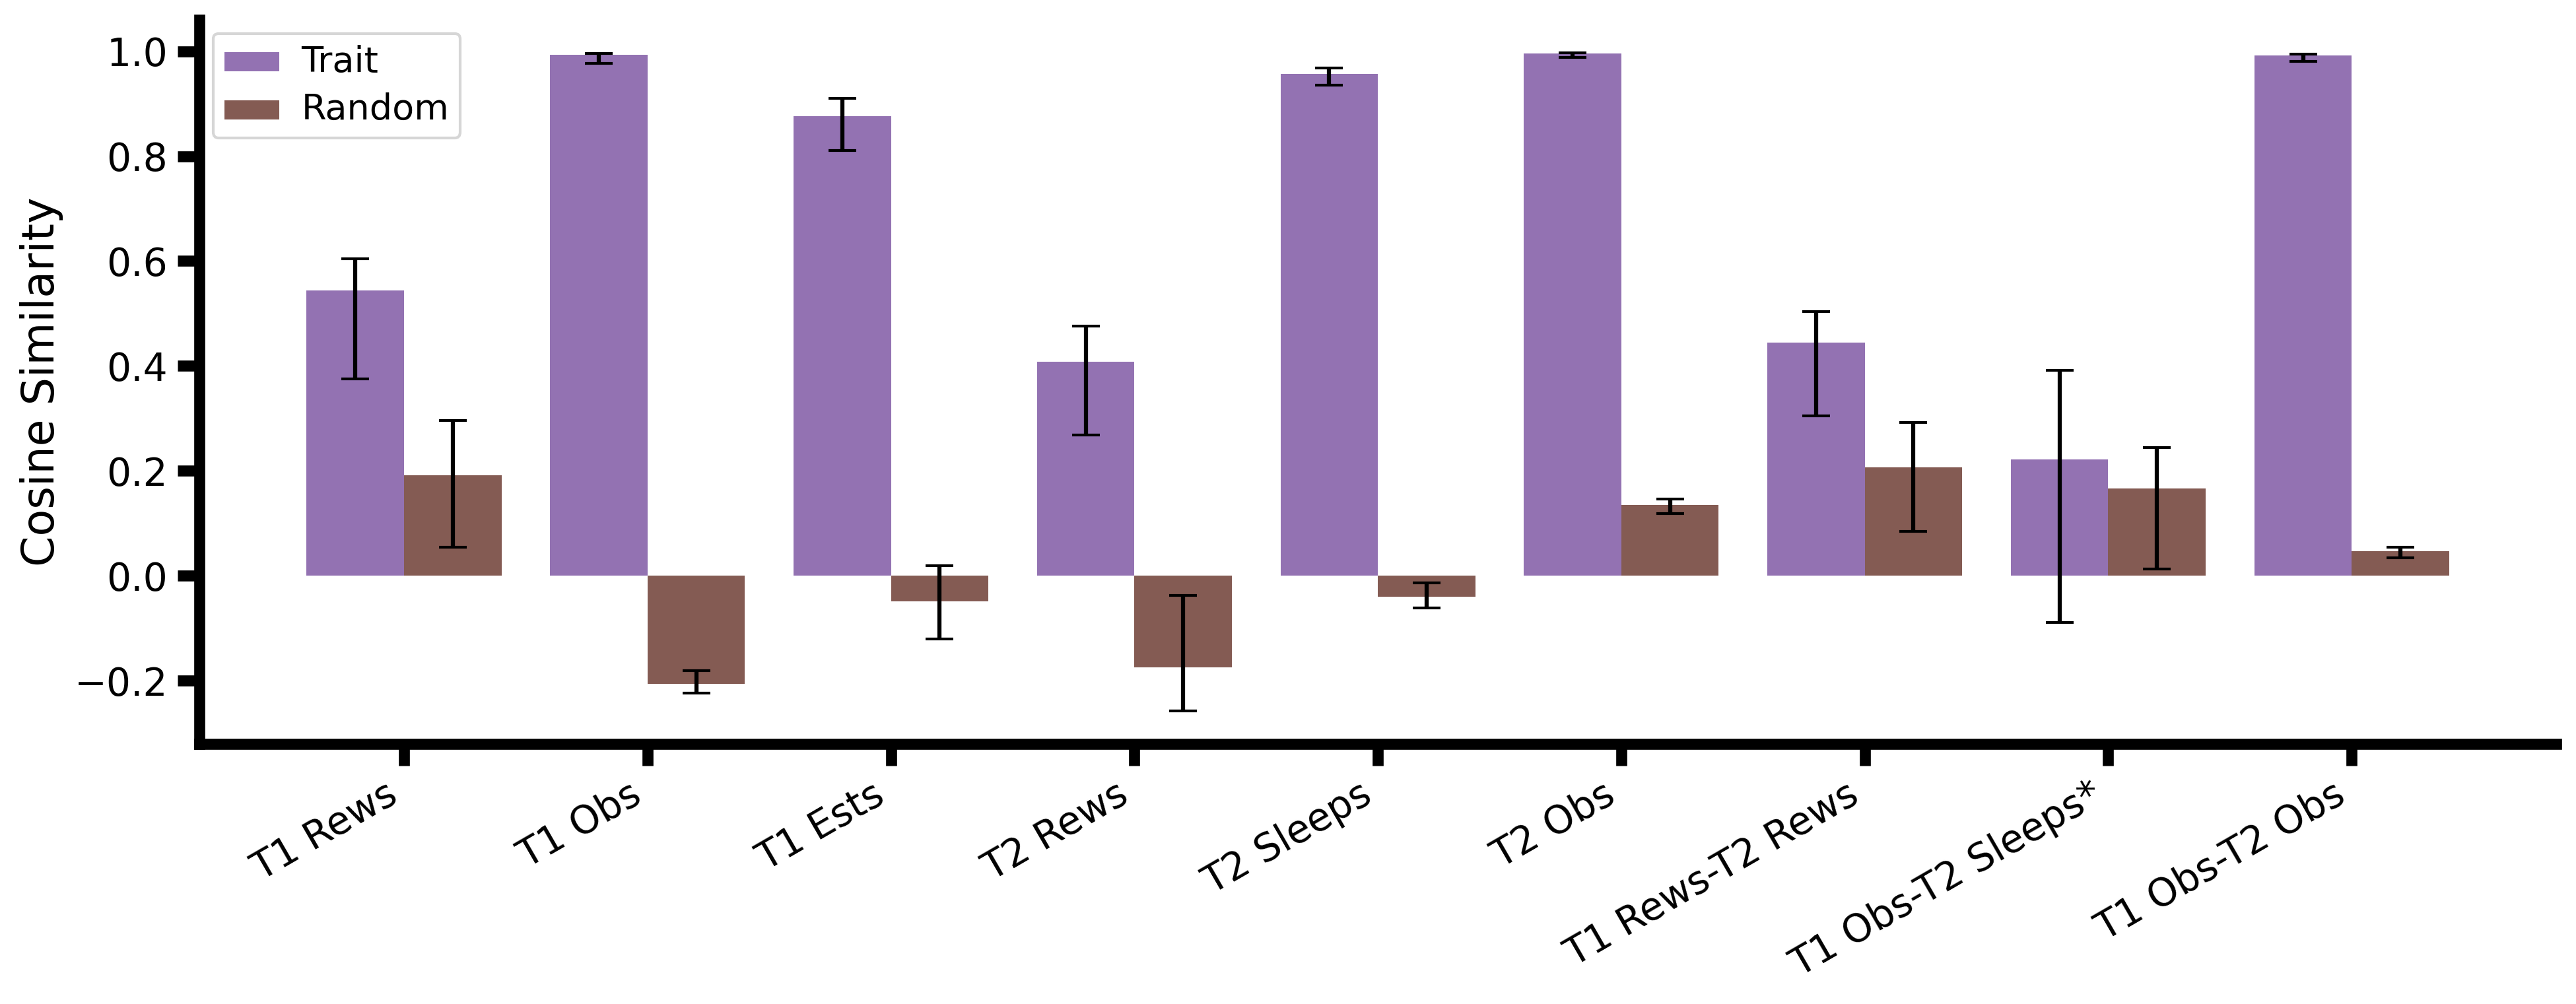

In [197]:
import seaborn as sns

#fig = plt.figure(figsize=(8.5, 4.8), dpi=300)
fig = plt.figure(figsize=(15.3541, 4.8428), dpi=300)
ax = fig.add_subplot(111)

### Create a Seaborn 
s = sns.barplot(x='Name', y='Cosine Similarity', hue='Comparison', data=df_cosim, ax=ax, palette=['C4', 'C5'])
s.get_legend().set_title(None)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xlabel(None)

# Adding error bars
for bar in ax.patches:
    # Get the height of the bar
    height = bar.get_height()
    # Find the index where 'Cosine Similarity' is close to the height of the bar
    index = np.where(np.isclose(df_cosim['Cosine Similarity'], height))[0][0]
    lower = df_cosim.loc[df_cosim.index[index], 'Lower']
    upper = df_cosim.loc[df_cosim.index[index], 'Upper']
    mean = df_cosim.loc[df_cosim.index[index], 'Cosine Similarity']
    plt.errorbar(x=bar.get_x() + bar.get_width() / 2, y=mean, 
                 yerr=[[mean-lower], [upper-mean]], fmt='none', ecolor='black', capsize=5)

format_axis(ax)        

In [198]:
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot.png'))
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot.svg'))

In [6]:
df_cosim = df_cosim[df_cosim['Comparison'] == "Trait"]

/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


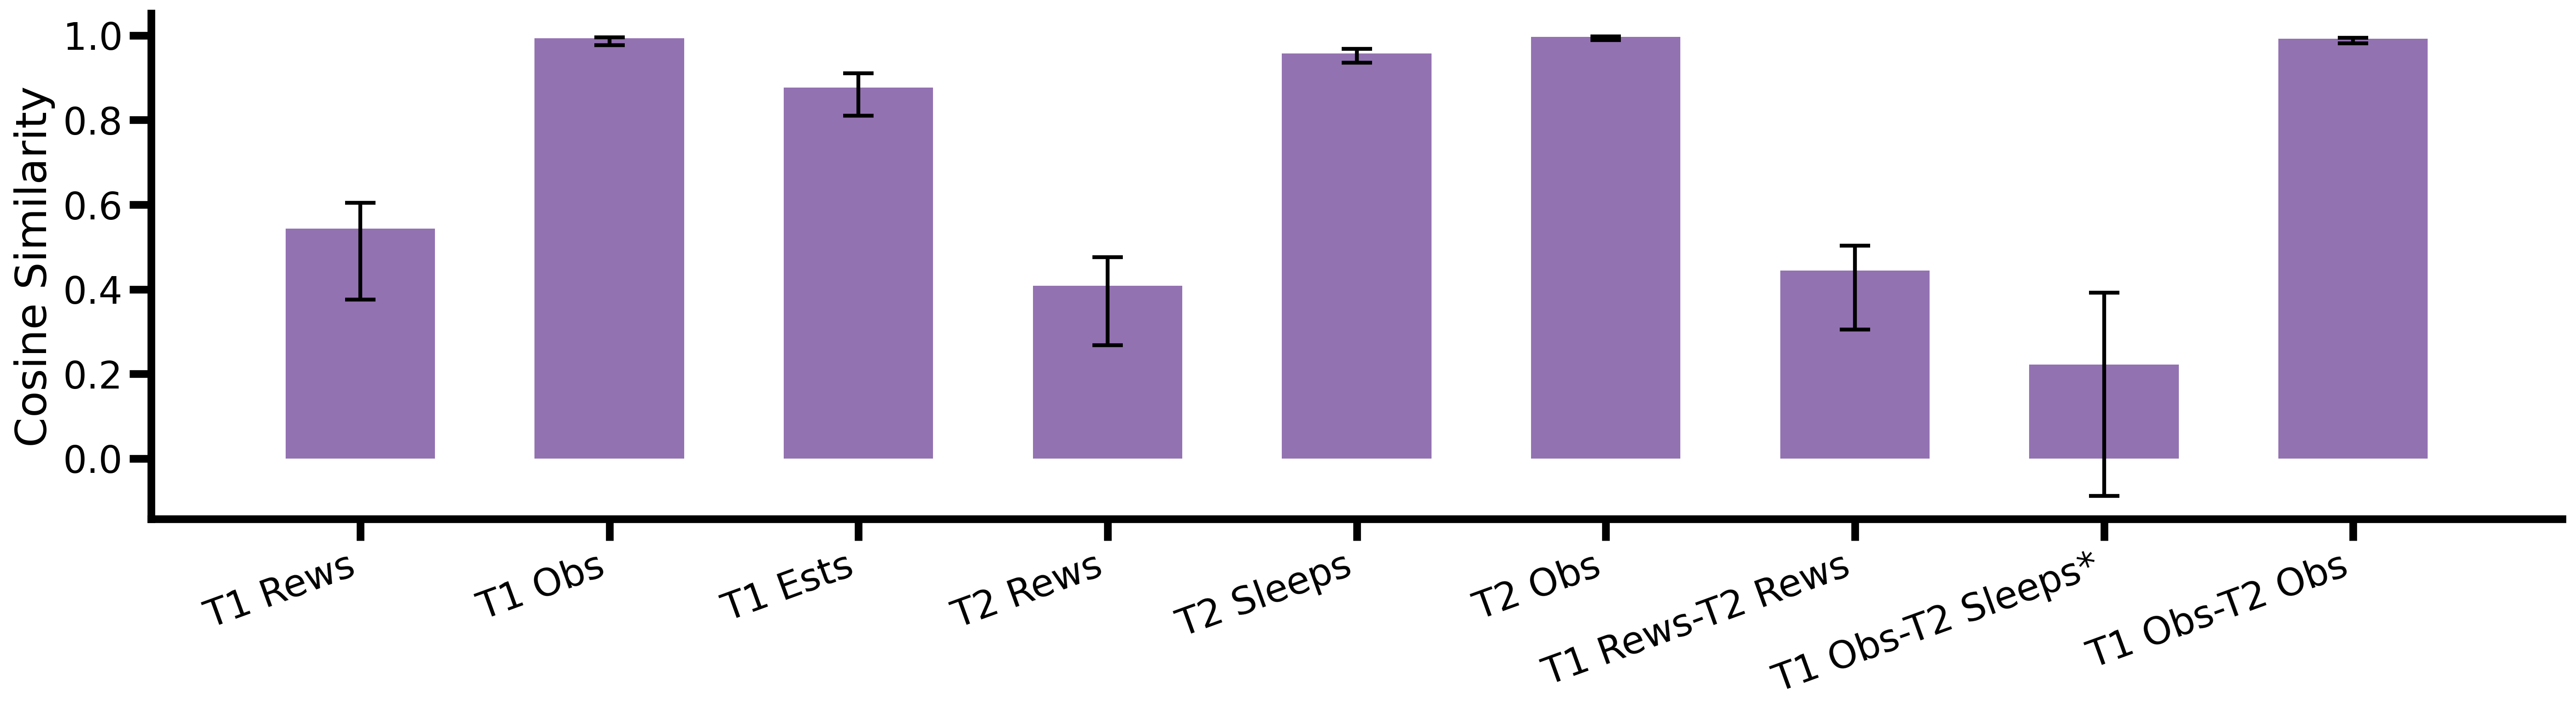

In [17]:
import seaborn as sns

#fig = plt.figure(figsize=(15.3541, 4.8428), dpi=300)
fig = plt.figure(figsize=(22.5105, 4.8428), dpi=300)
ax = fig.add_subplot(111)

### Create a Seaborn 
s = sns.barplot(x='Name', y='Cosine Similarity', data=df_cosim, ax=ax, palette=['C4'],)

ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
ax.set_xlabel(None)

# Adding error bars
for bar in ax.patches:
    # Get the height of the bar
    height = bar.get_height()
    # Find the index where 'Cosine Similarity' is close to the height of the bar
    index = np.where(np.isclose(df_cosim['Cosine Similarity'], height))[0][0]
    lower = df_cosim.loc[df_cosim.index[index], 'Lower']
    upper = df_cosim.loc[df_cosim.index[index], 'Upper']
    mean = df_cosim.loc[df_cosim.index[index], 'Cosine Similarity']
    plt.errorbar(x=bar.get_x() + bar.get_width() / 2, y=mean, 
                 yerr=[[mean-lower], [upper-mean]], fmt='none', ecolor='black', 
                 capsize=8, 
                 elinewidth=2, markeredgewidth=2)
    
new_value = 0.6
for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - new_value

    # we change the bar width
    patch.set_width(new_value)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)

format_axis(ax, font_size_multiplier=1.4)        

In [18]:
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_trait.png'))
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_trait.svg'))